In [202]:
# %%
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from matplotlib.animation import FuncAnimation

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [203]:
# %%
# Create output directory
output_dir = os.path.join(os.getcwd(), "woSubstrate")
os.makedirs(output_dir, exist_ok=True)

In [204]:
# %%
# Function to export tensor to CSV using NumPy
def export_tensor_to_csv_numpy(tensor, filename):
    array = tensor.detach().cpu().numpy()

    # Ensure the array is of floating-point type
    if not np.issubdtype(array.dtype, np.floating):
        array = array.astype(np.float64)
    
    # Save with double precision and '.' as decimal delimiter
    np.savetxt(filename, array, delimiter=',', fmt='%.15f')
    print(f"Exported tensor to {filename} using NumPy with double precision.")

In [205]:
# %%
# Hyperparameters
grid_size = 14  # Adjusted to match MATLAB's gridSize
total_iterations = 10000  # Adjusted to match MATLAB's totalIterations
substrate_val = 0.999  # belongs to (0,1]
depth = 2
alpha_mat = torch.zeros((grid_size, grid_size), device=device)
no_runs = 30

# Reaction-Diffusion parameters
pa = 0.8
# pa = 0.54545455 
# pb = 0.6
pb = 0.8
pe = 3.5
d = 500
dt = 1e-5
threshold = 1
gamma = 625
ph = 1
alpha = 1
amax = 30 # activator limiter 20
smax = 1e6 # suppressor limiter 40
rnd_init = 0.25
rnd_subs = 0.15

# Laplacian weights
lap = 6.8/13.6
lap_side = 1/13.6
lap_diag = .7/13.6 

In [206]:
# Assuming 'no_runs', 'grid_size', 'device', 'substrate_val', 'rnd_subs' are defined

# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((no_runs, grid_size, grid_size), device=device)
v = torch.zeros((no_runs, grid_size, grid_size), device=device)
c = torch.zeros((no_runs, grid_size, grid_size), device=device)
n = torch.zeros((no_runs, grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

n = torch.linspace(1, substrate_val, grid_size, device=device).repeat(grid_size, 1)  # (grid_size, grid_size)
n = n.unsqueeze(0).repeat(no_runs, 1, 1)  # (no_runs, grid_size, grid_size)
n = torch.min(
    n * (1 - rnd_subs + torch.rand(no_runs, grid_size, grid_size, device=device) * rnd_subs * 2),
    torch.ones_like(n)
)


print(mid)

print(u.shape)
print(v.shape)
print(c.shape)
print(n.shape)


7
torch.Size([30, 14, 14])
torch.Size([30, 14, 14])
torch.Size([30, 14, 14])
torch.Size([30, 14, 14])


In [207]:
# %%
# Initial activator and suppressor states
cen_span = 2
random_tensor = 0.2
cen_point = int(grid_size/2)

for run in range(no_runs):
    for k in range(-cen_span, cen_span+1):
        for l in range(-cen_span, cen_span+1):
            if math.sqrt(k*k+l*l) <= cen_span:  # Check to ensure indices are within bounds
                c[run, cen_point+k, cen_point+l] = 0.8 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2)
                u[run, cen_point+k, cen_point+l] = 0.5 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2) 
                v[run, cen_point+k, cen_point+l] = 0.1 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2) 

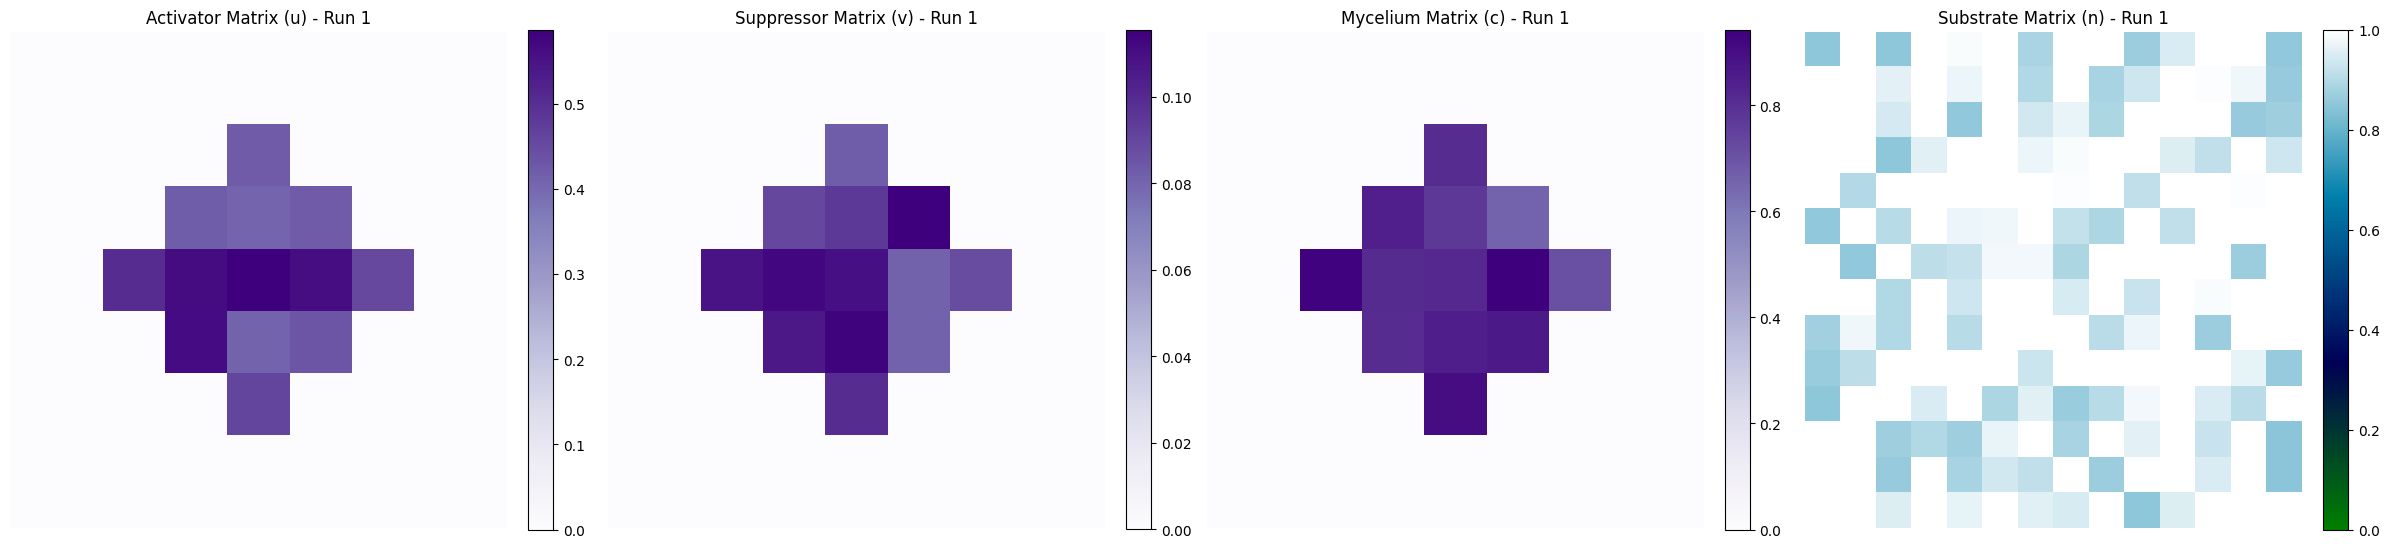

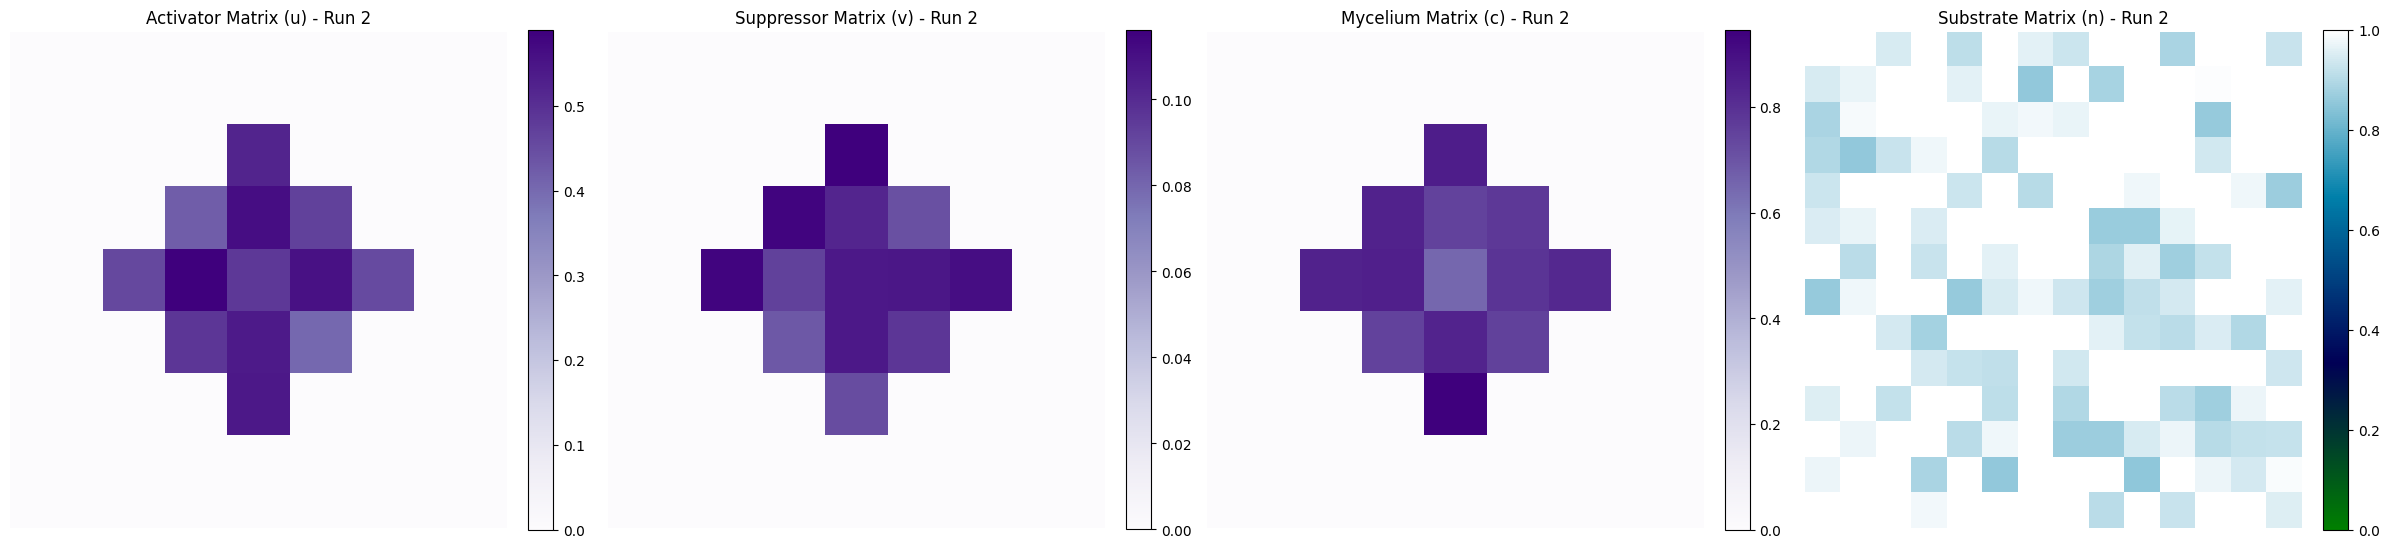

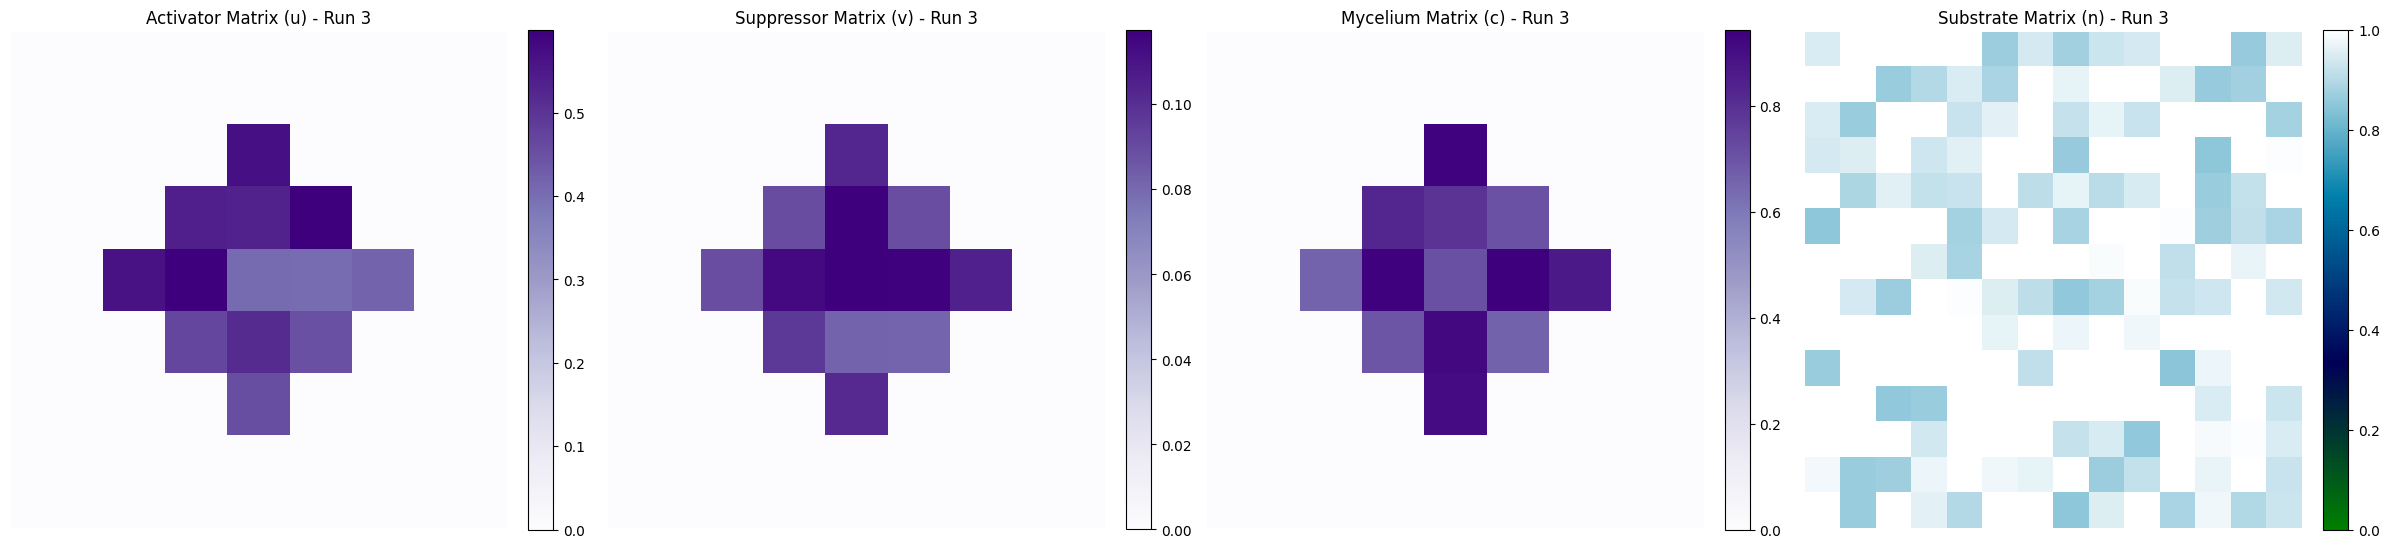

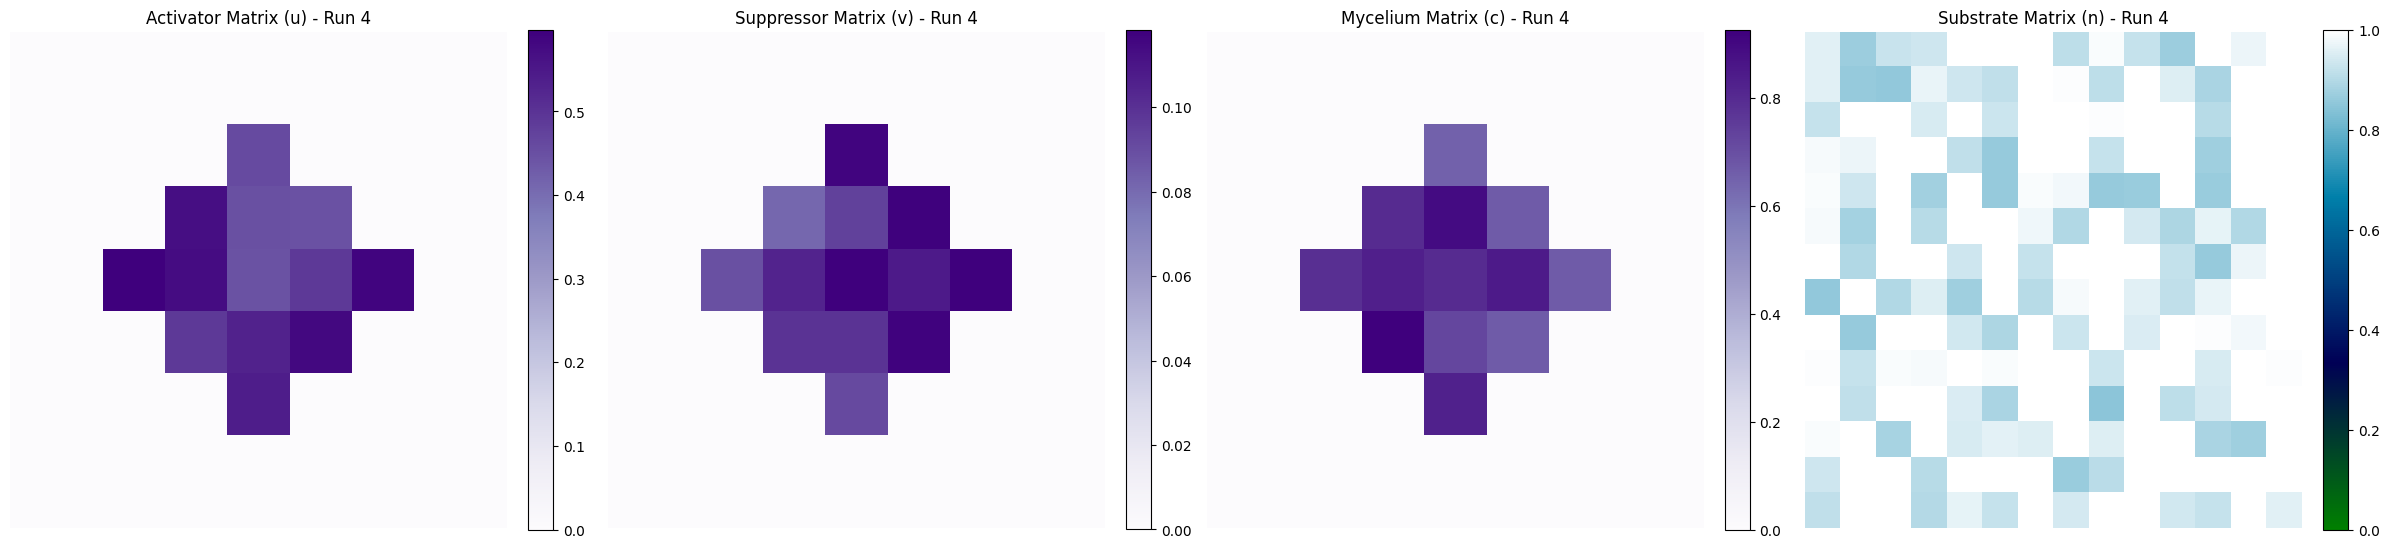

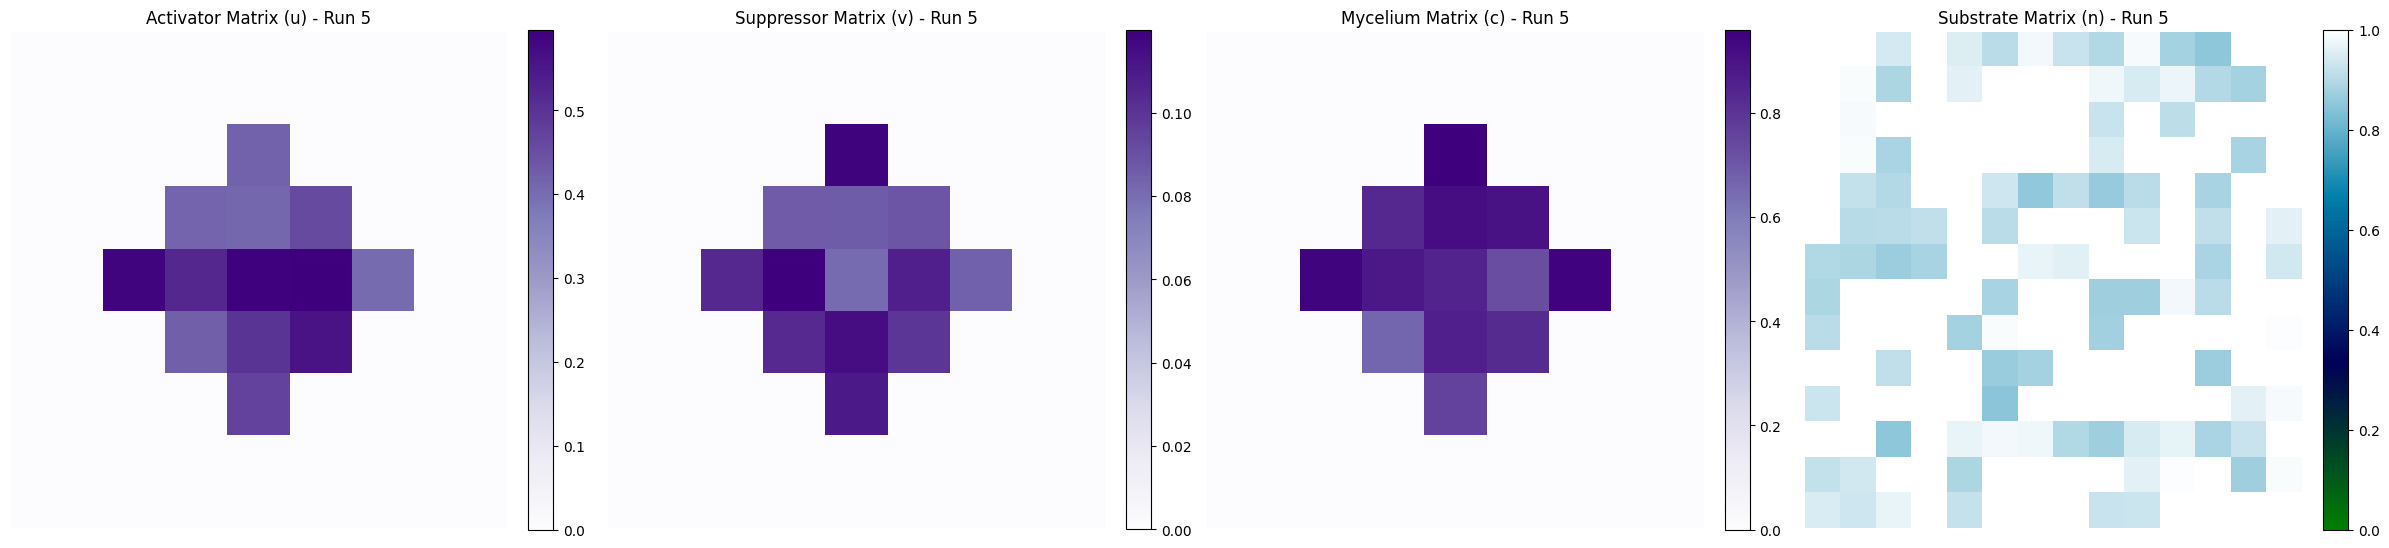

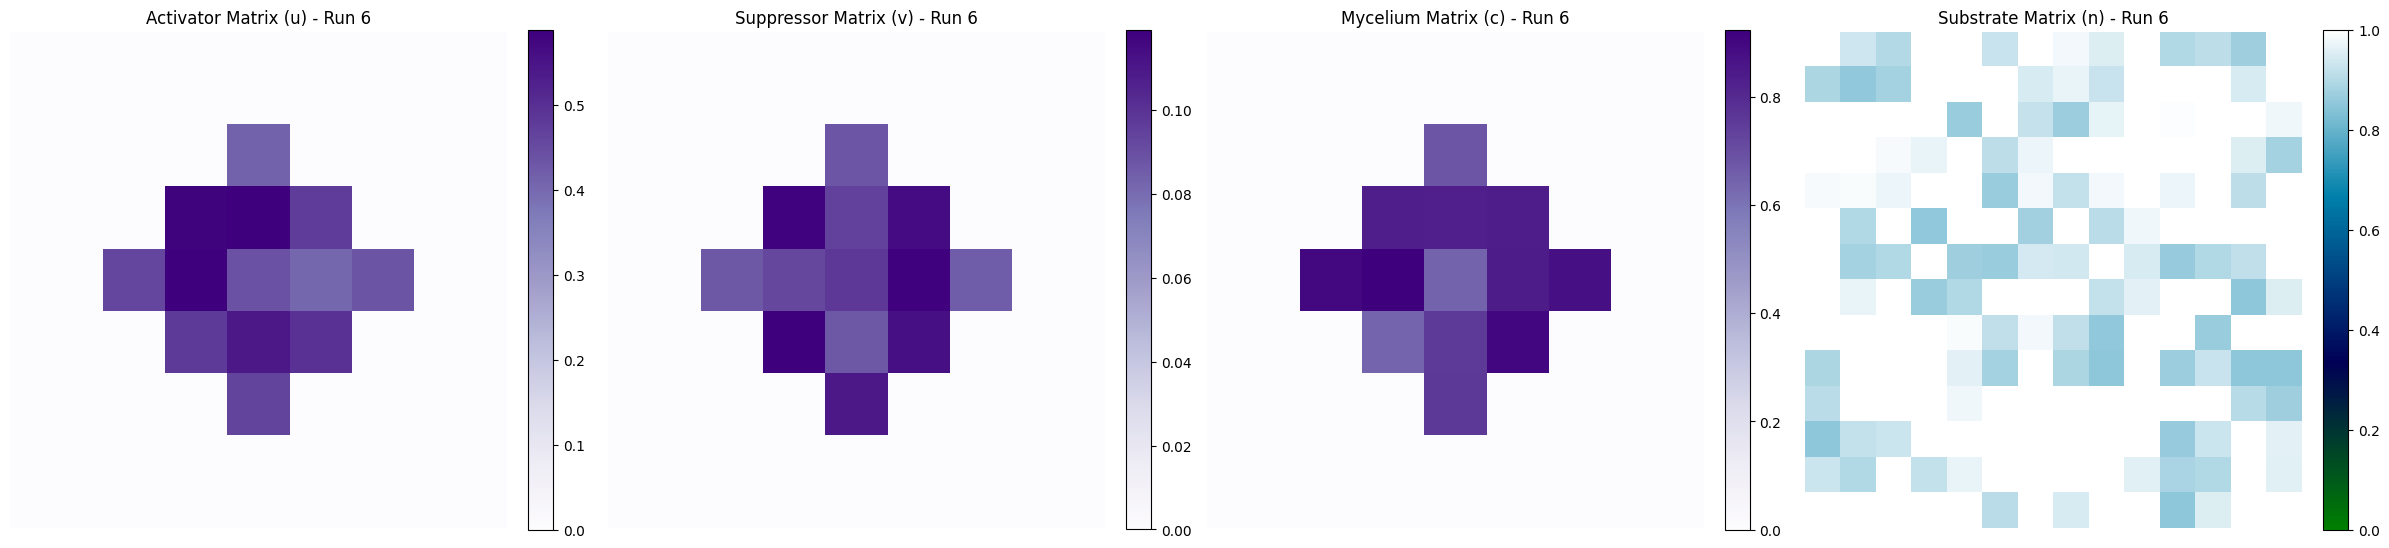

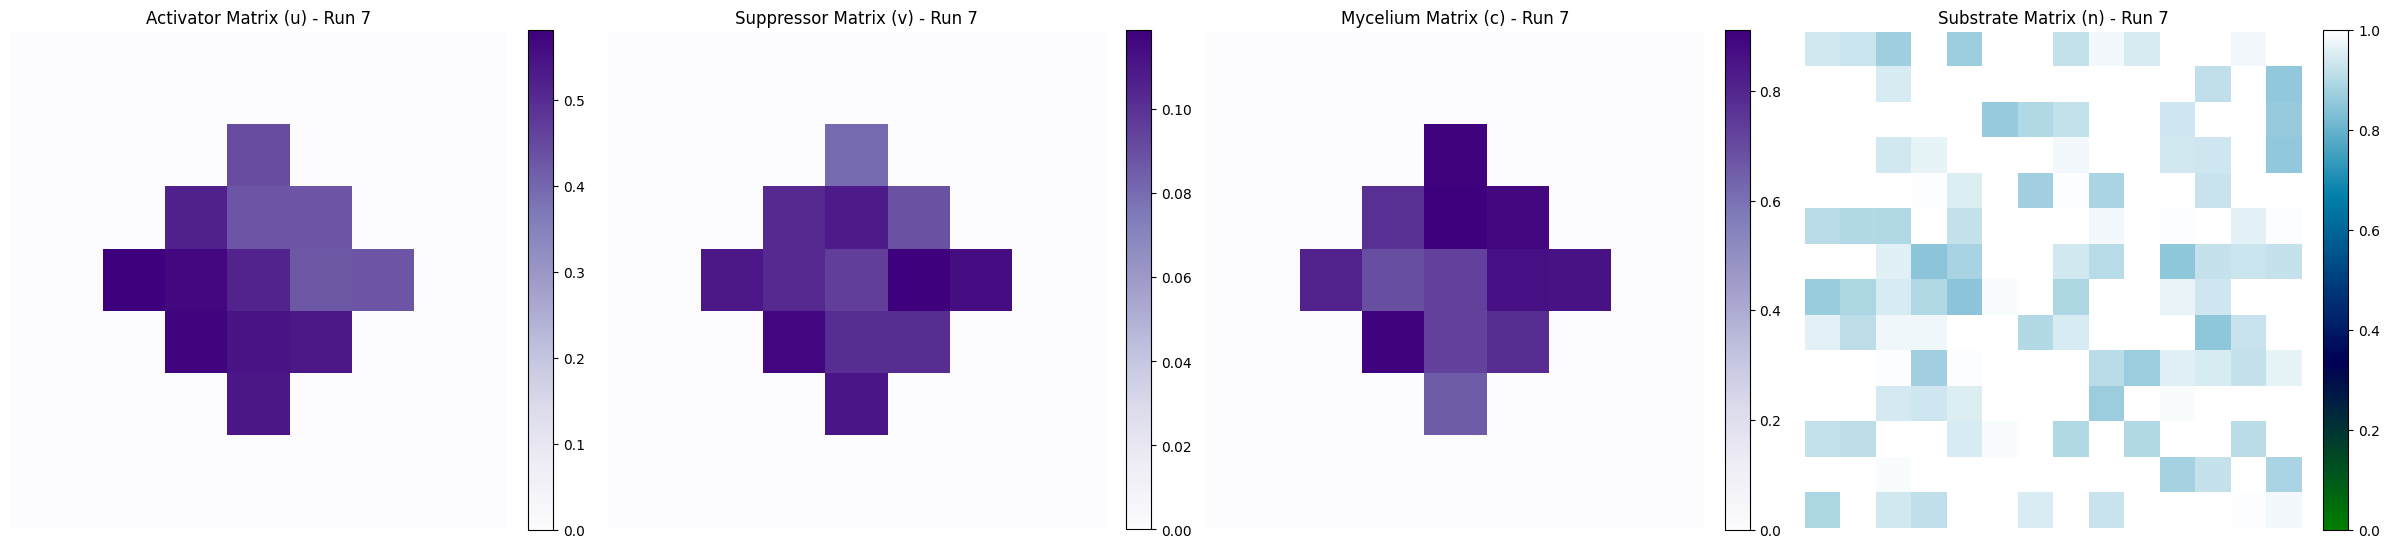

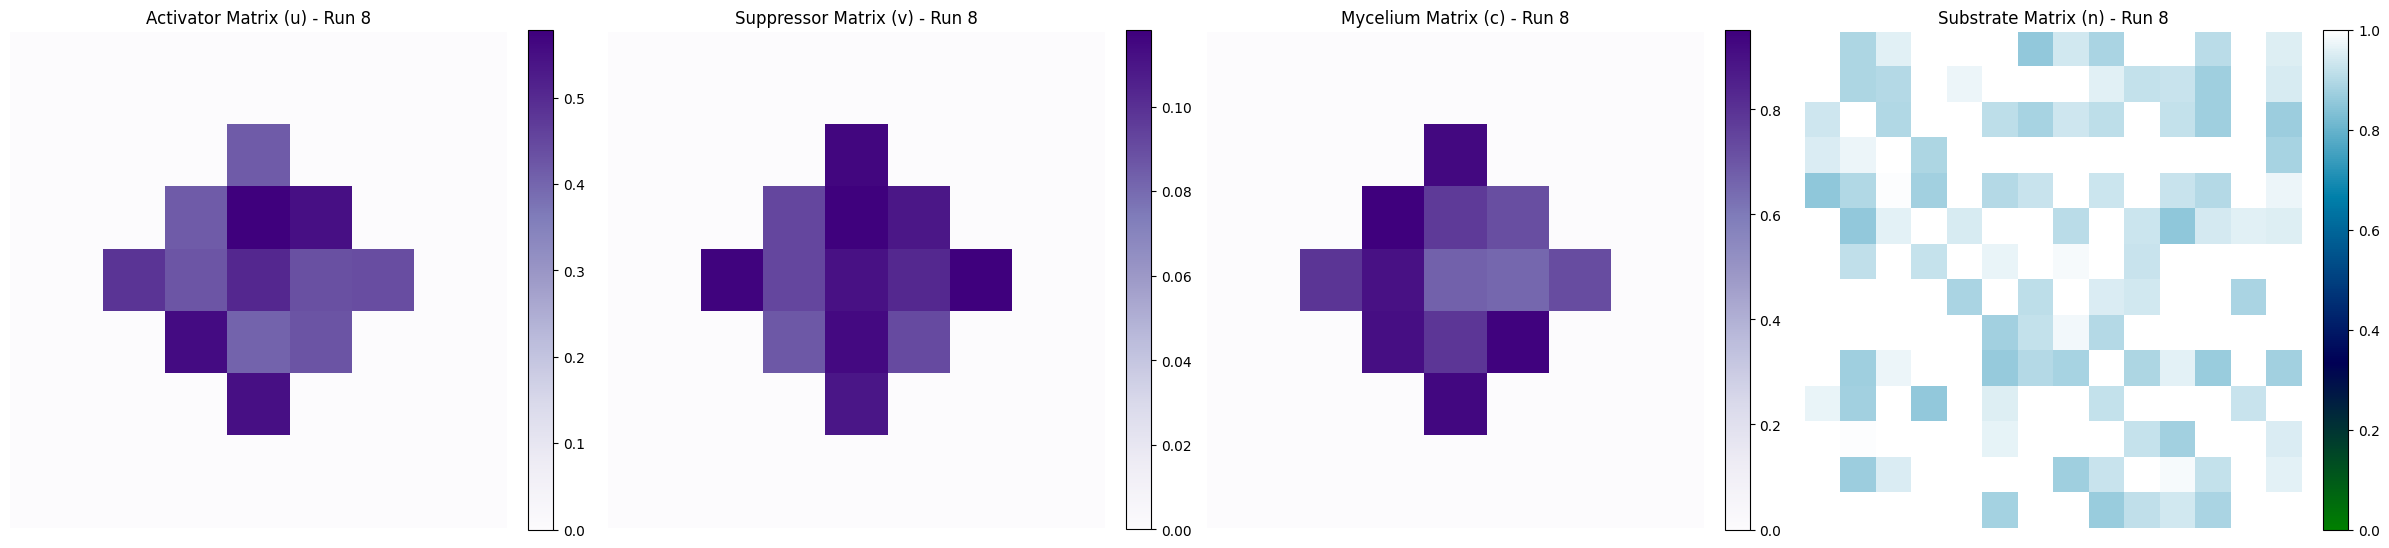

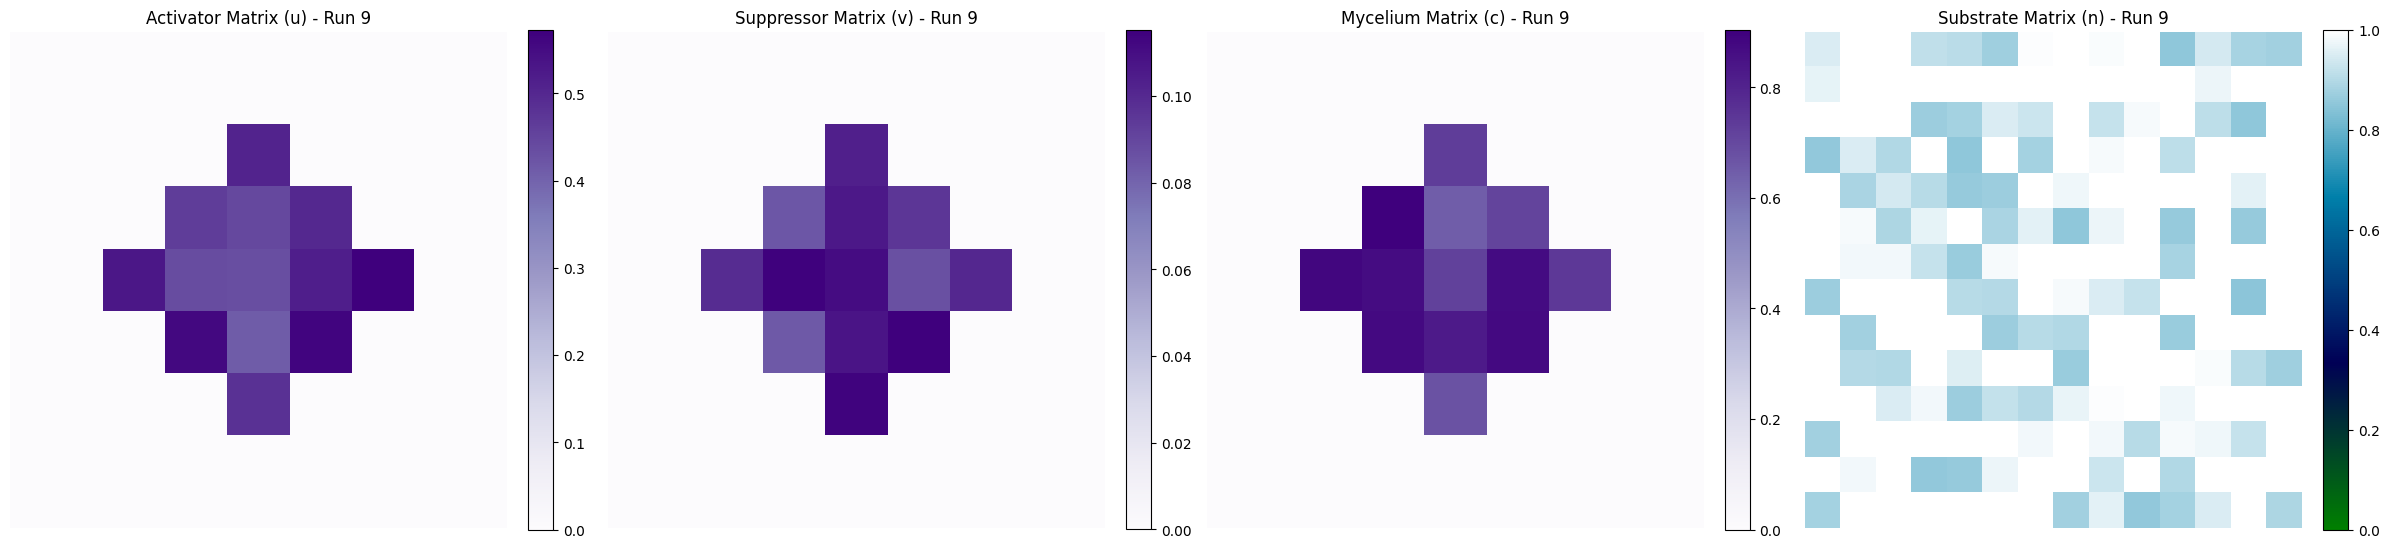

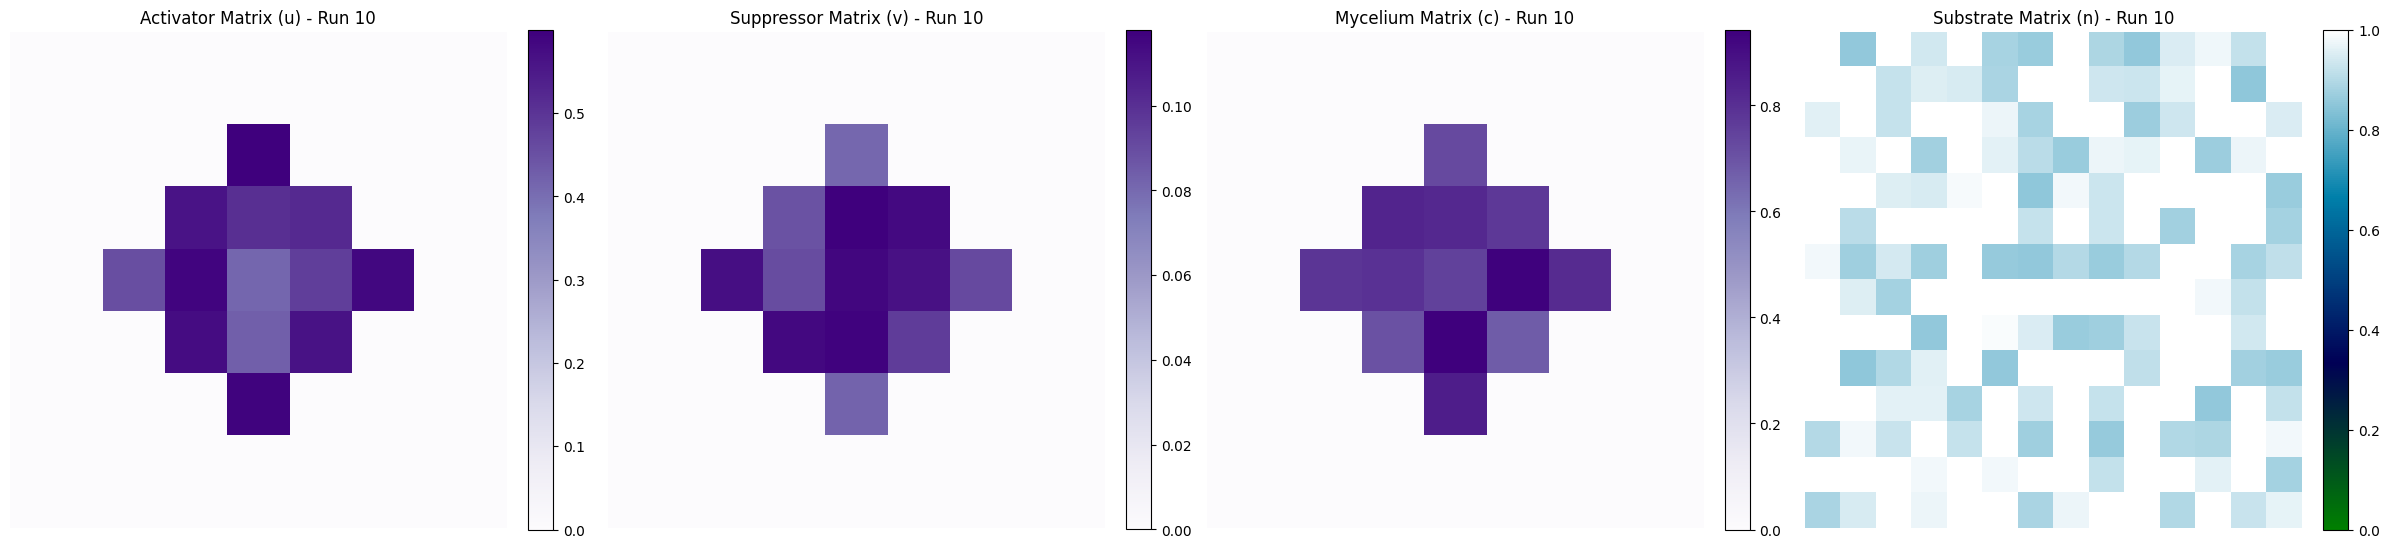

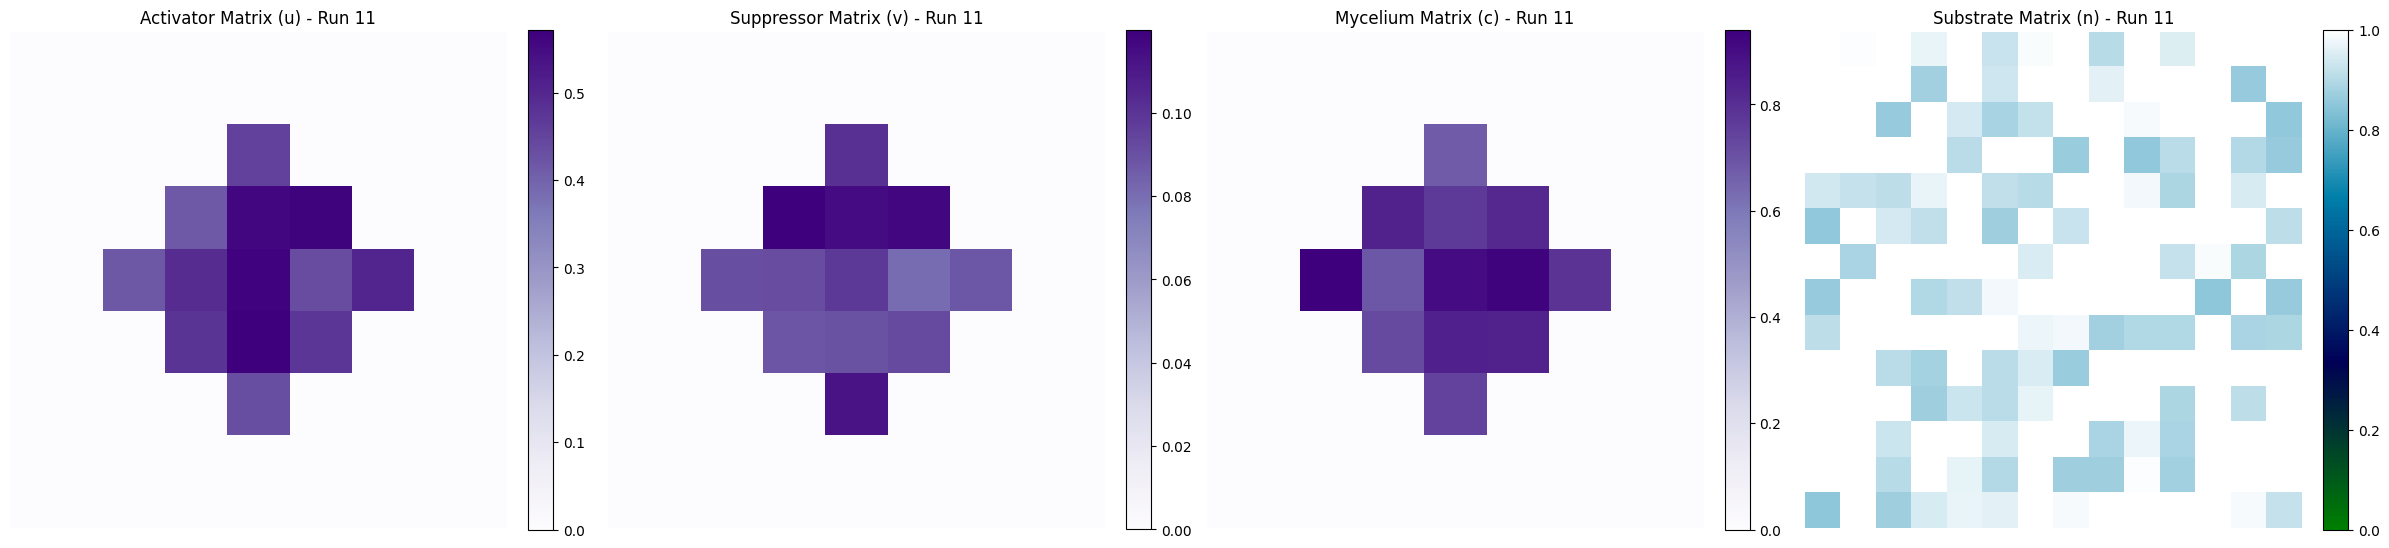

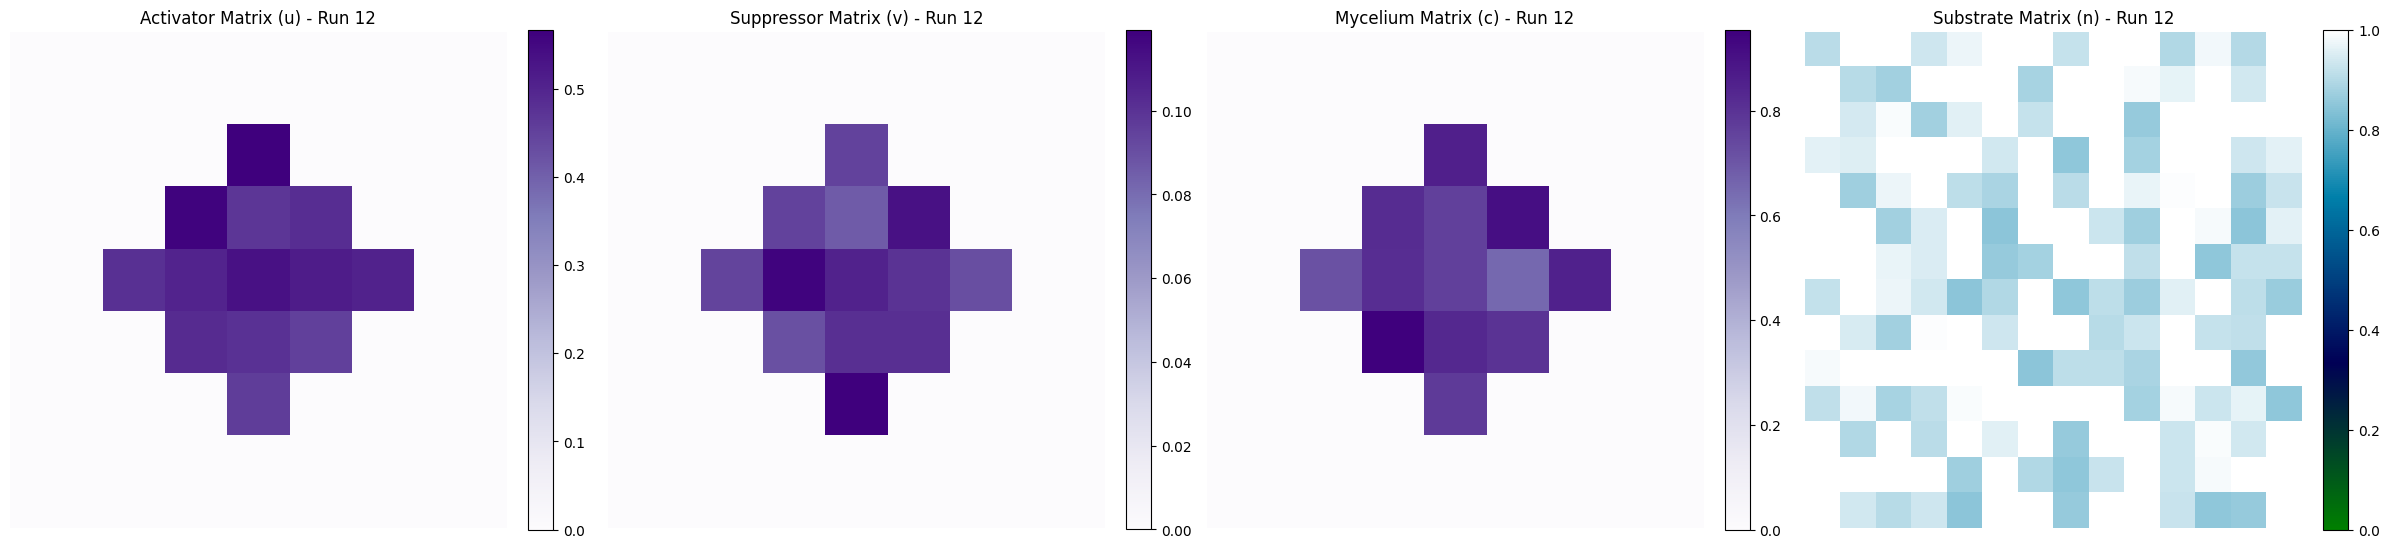

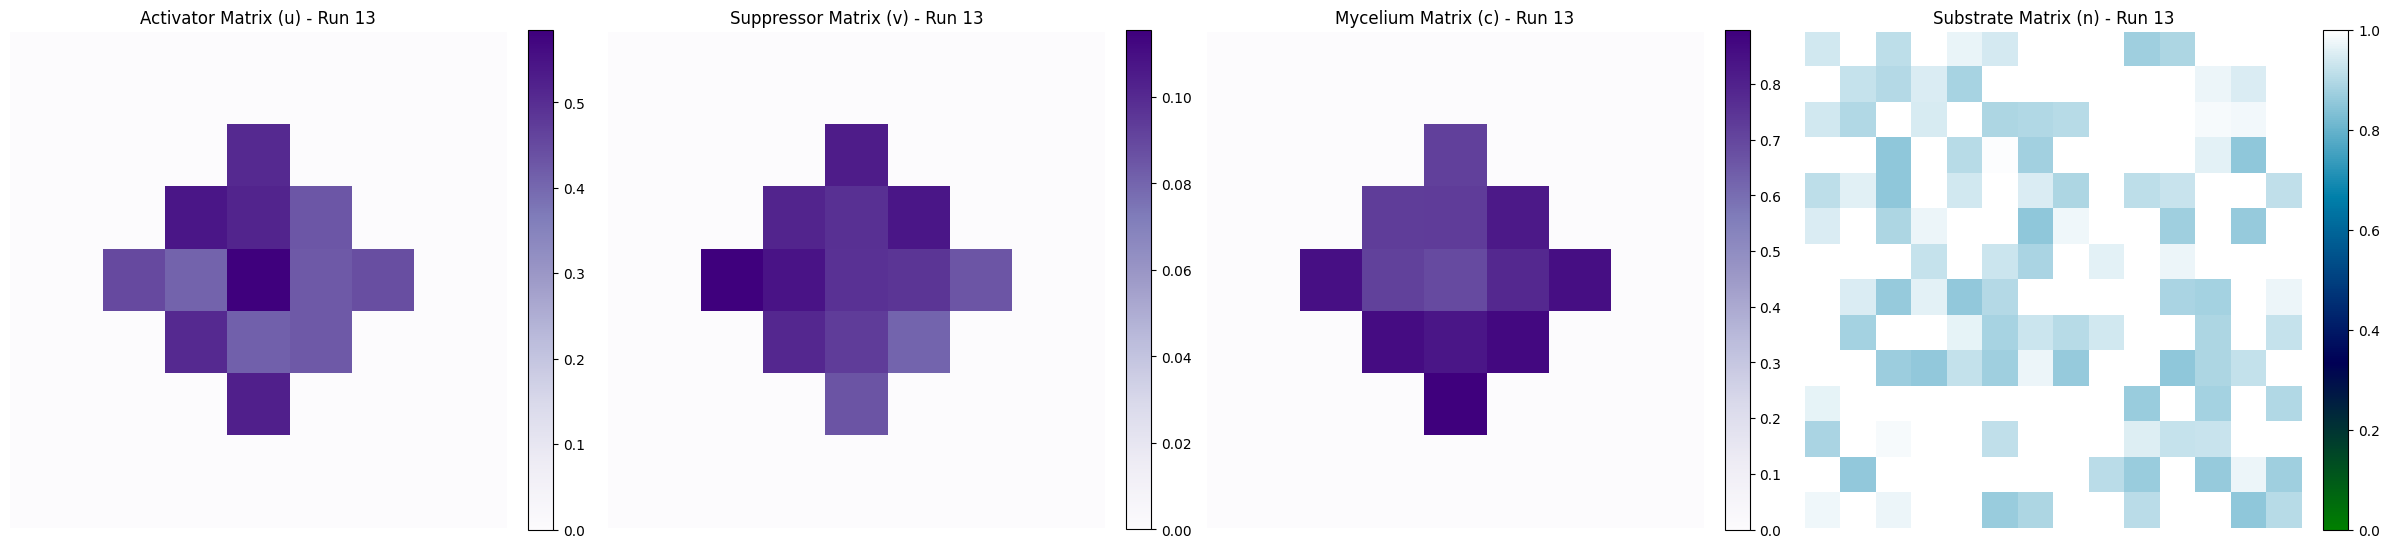

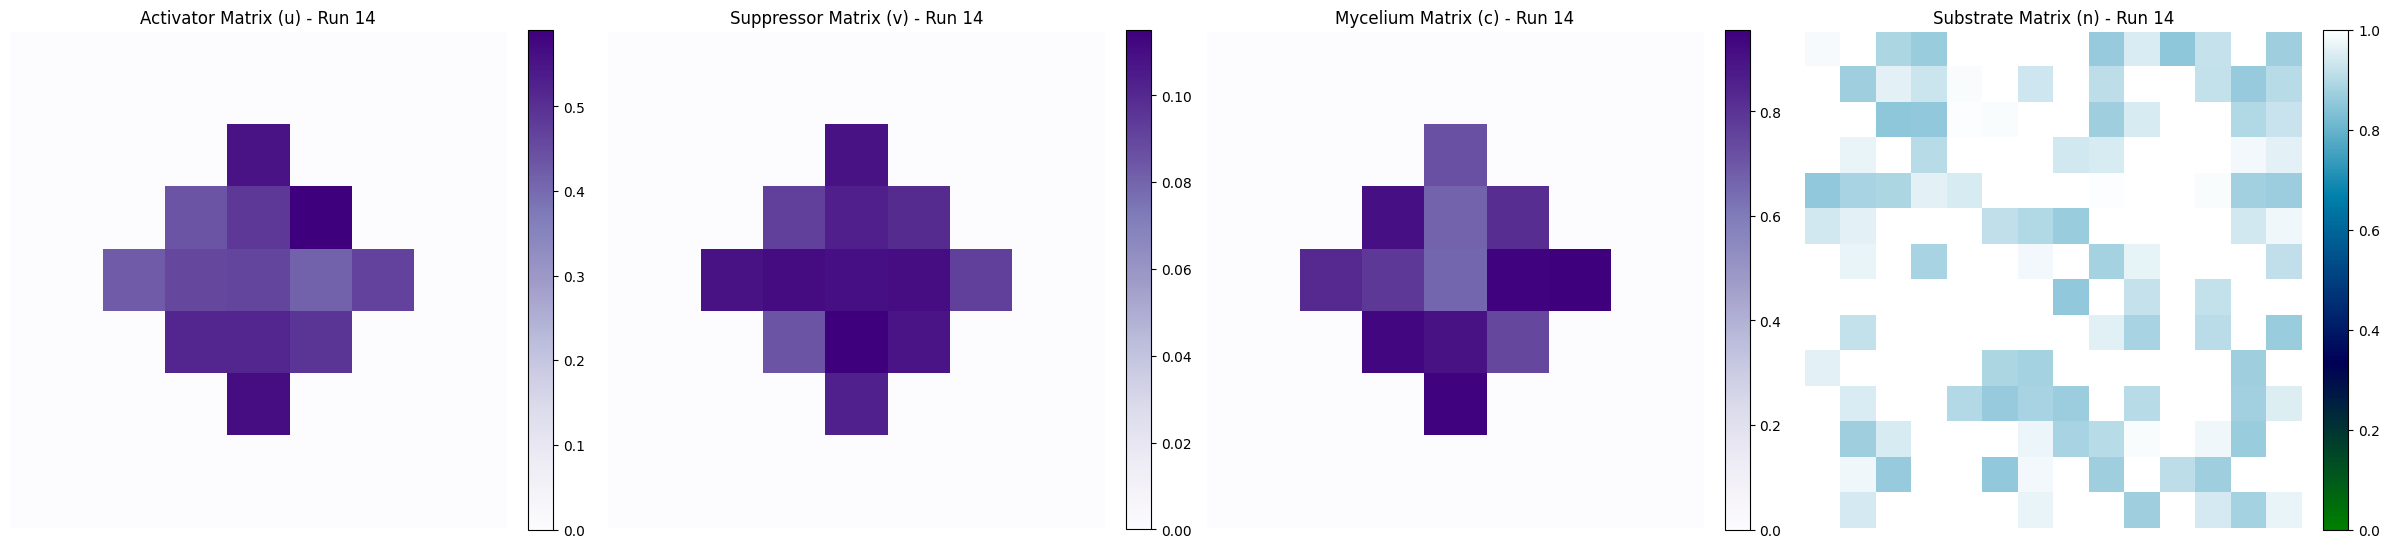

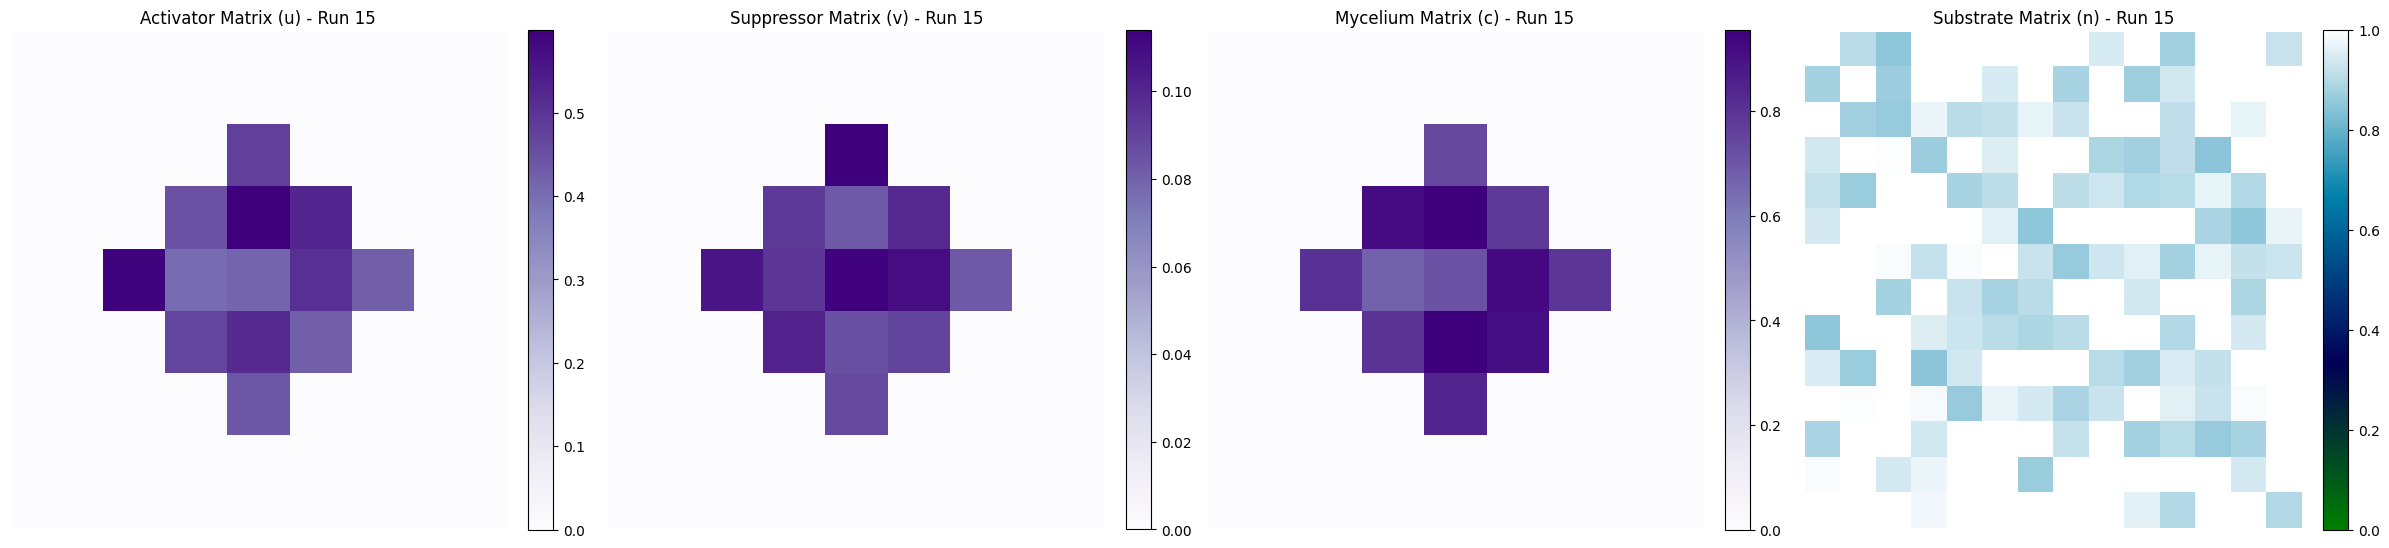

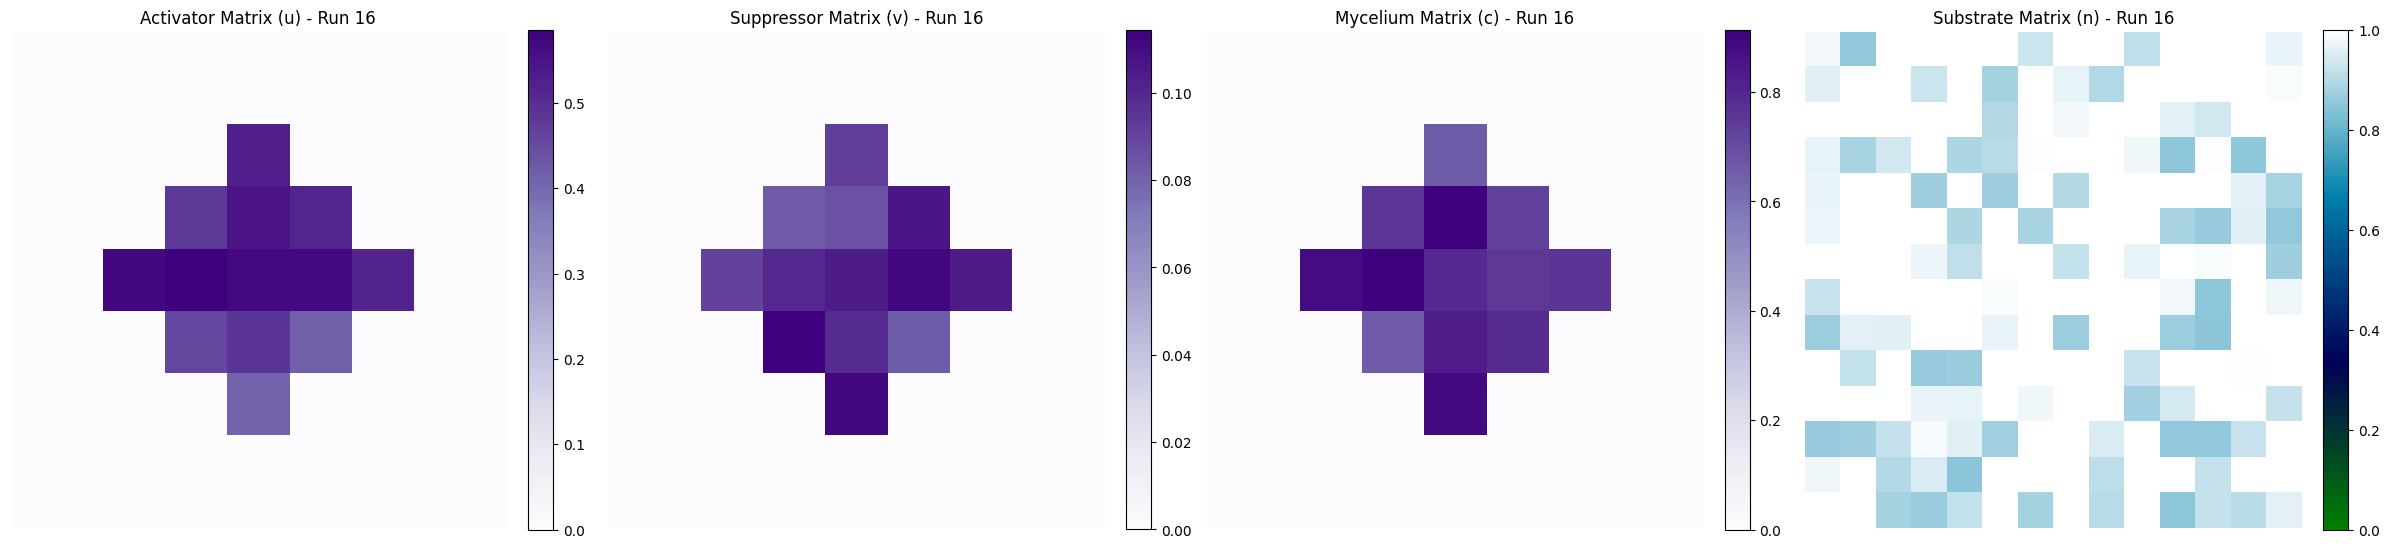

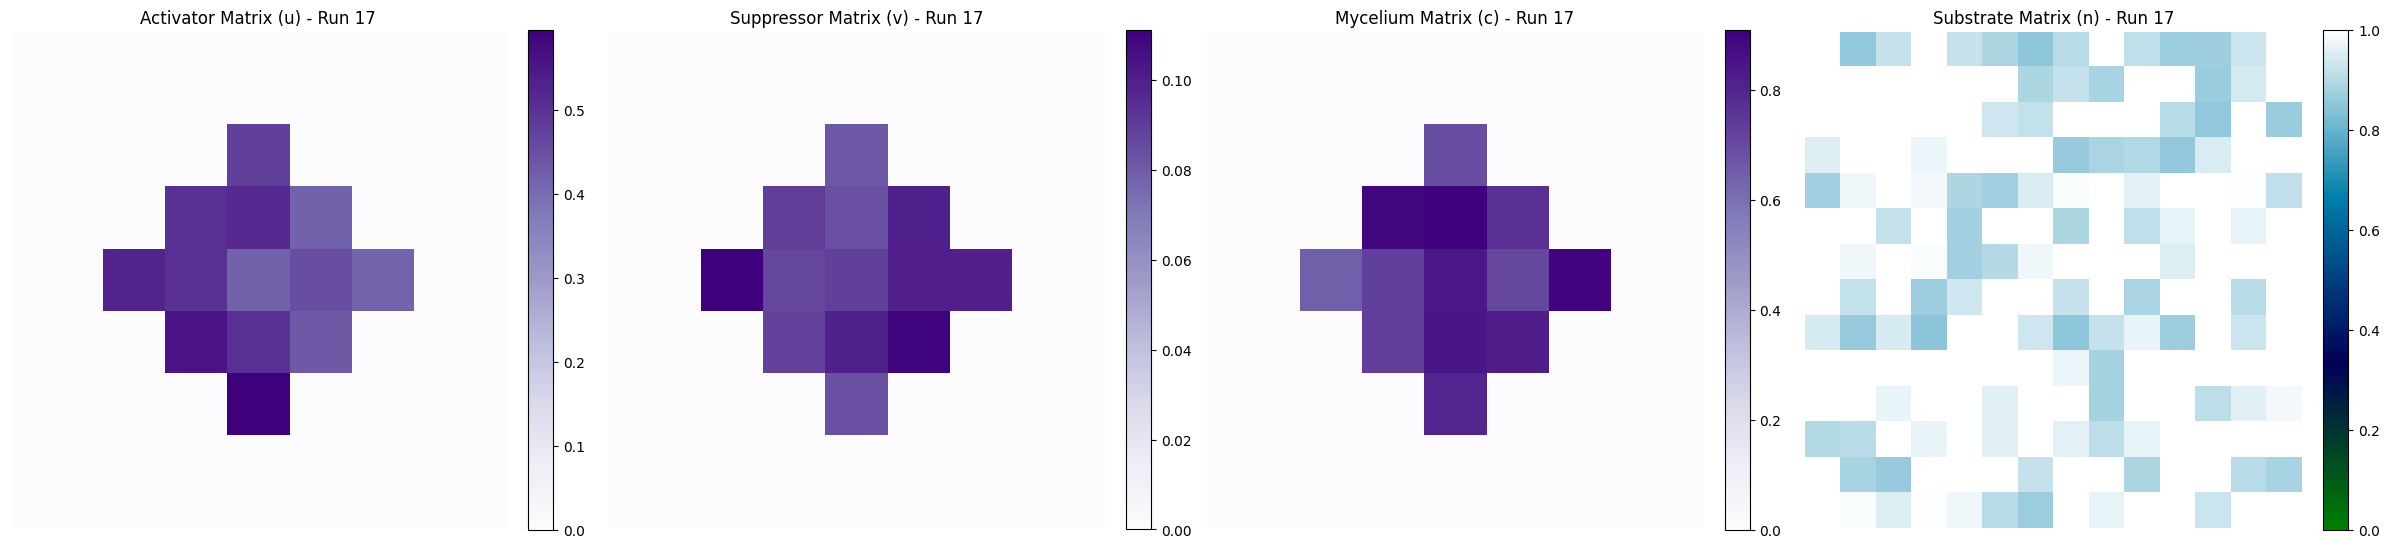

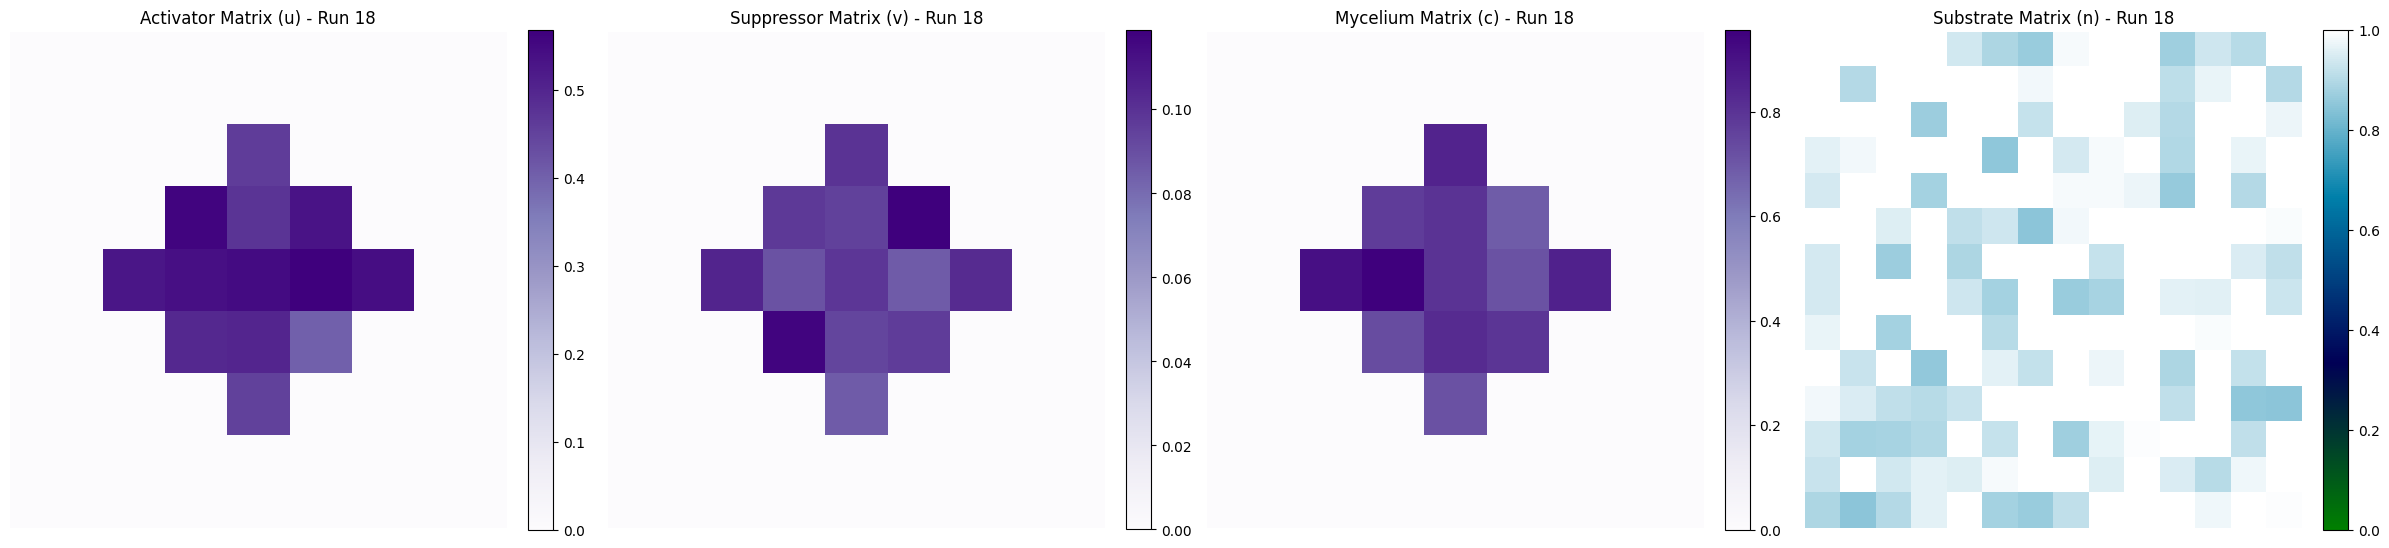

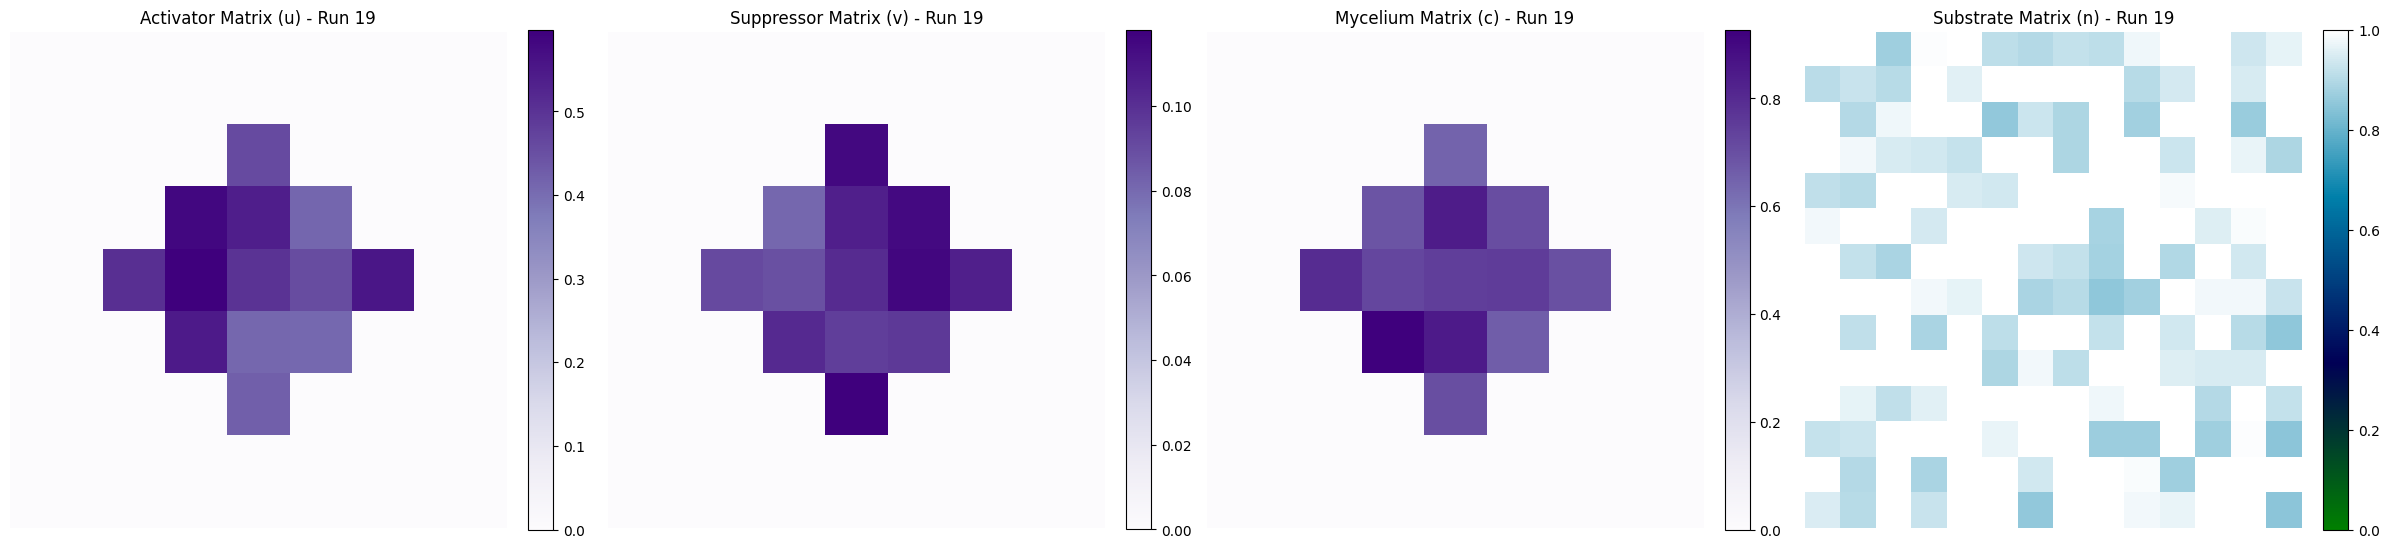

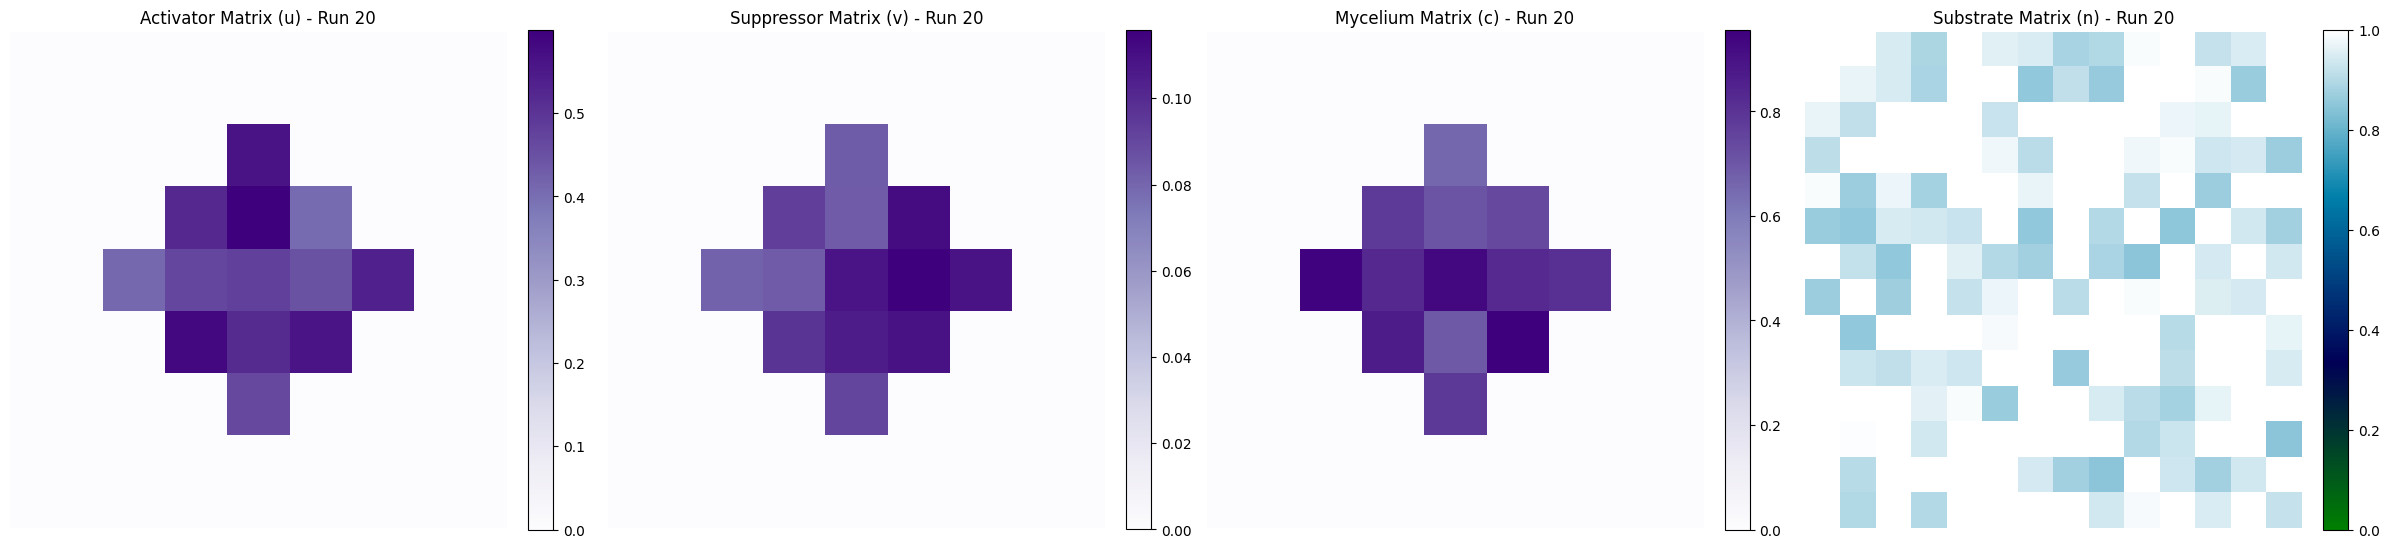

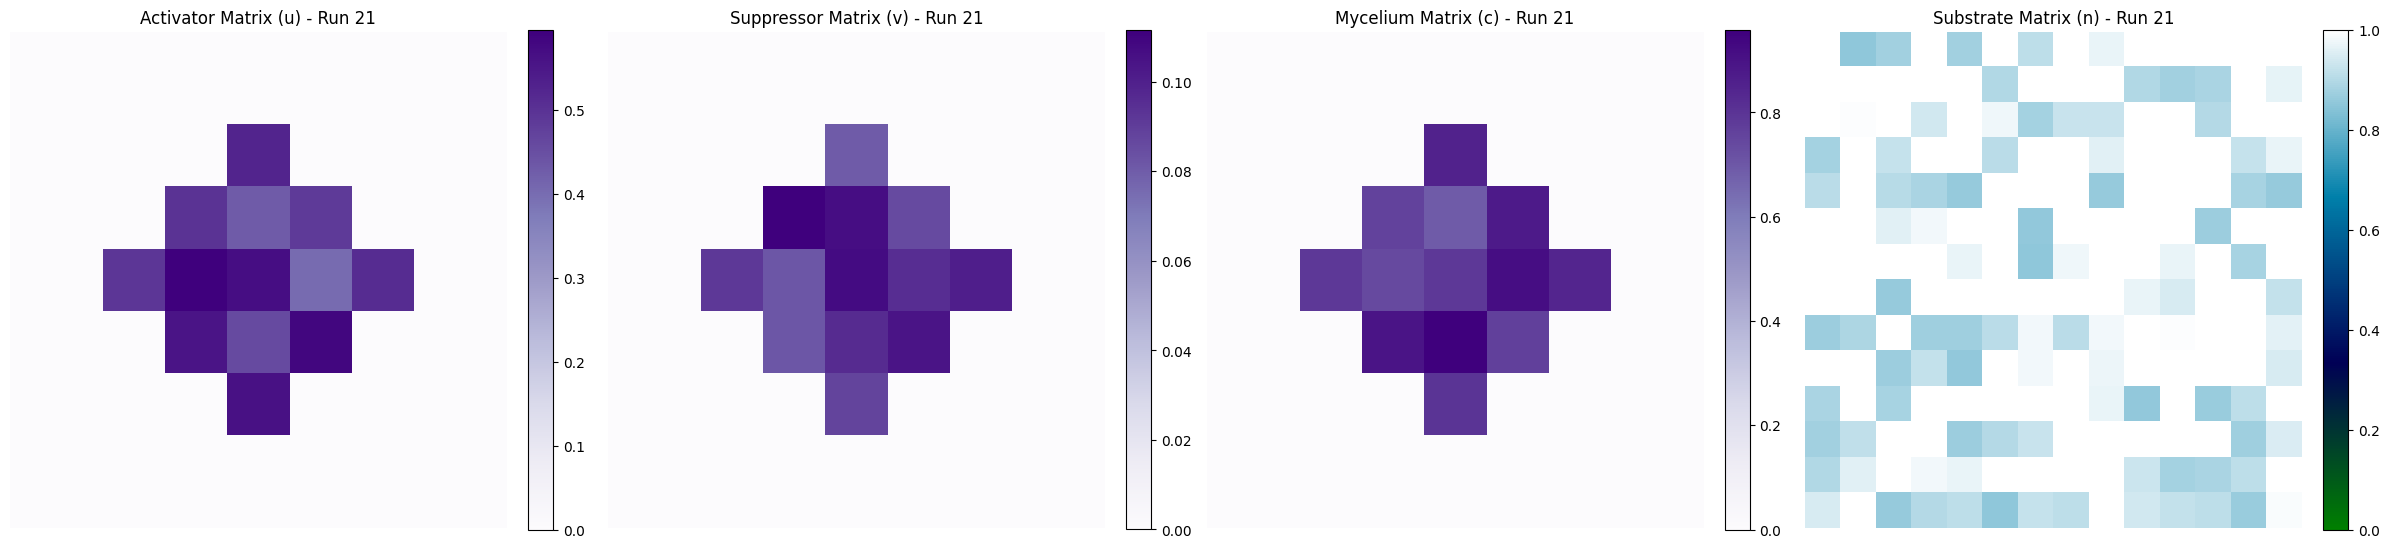

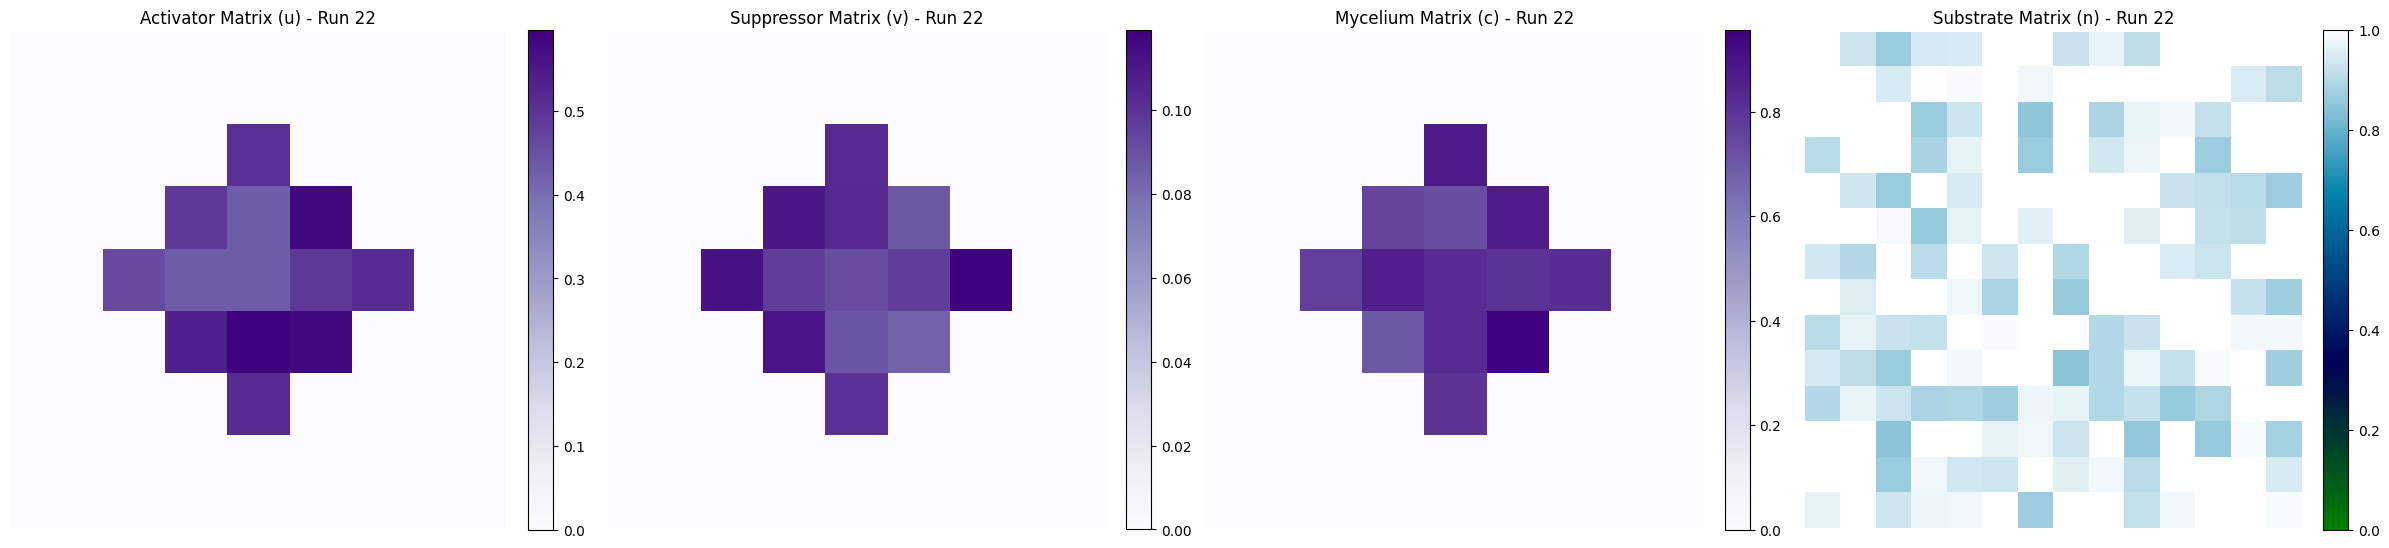

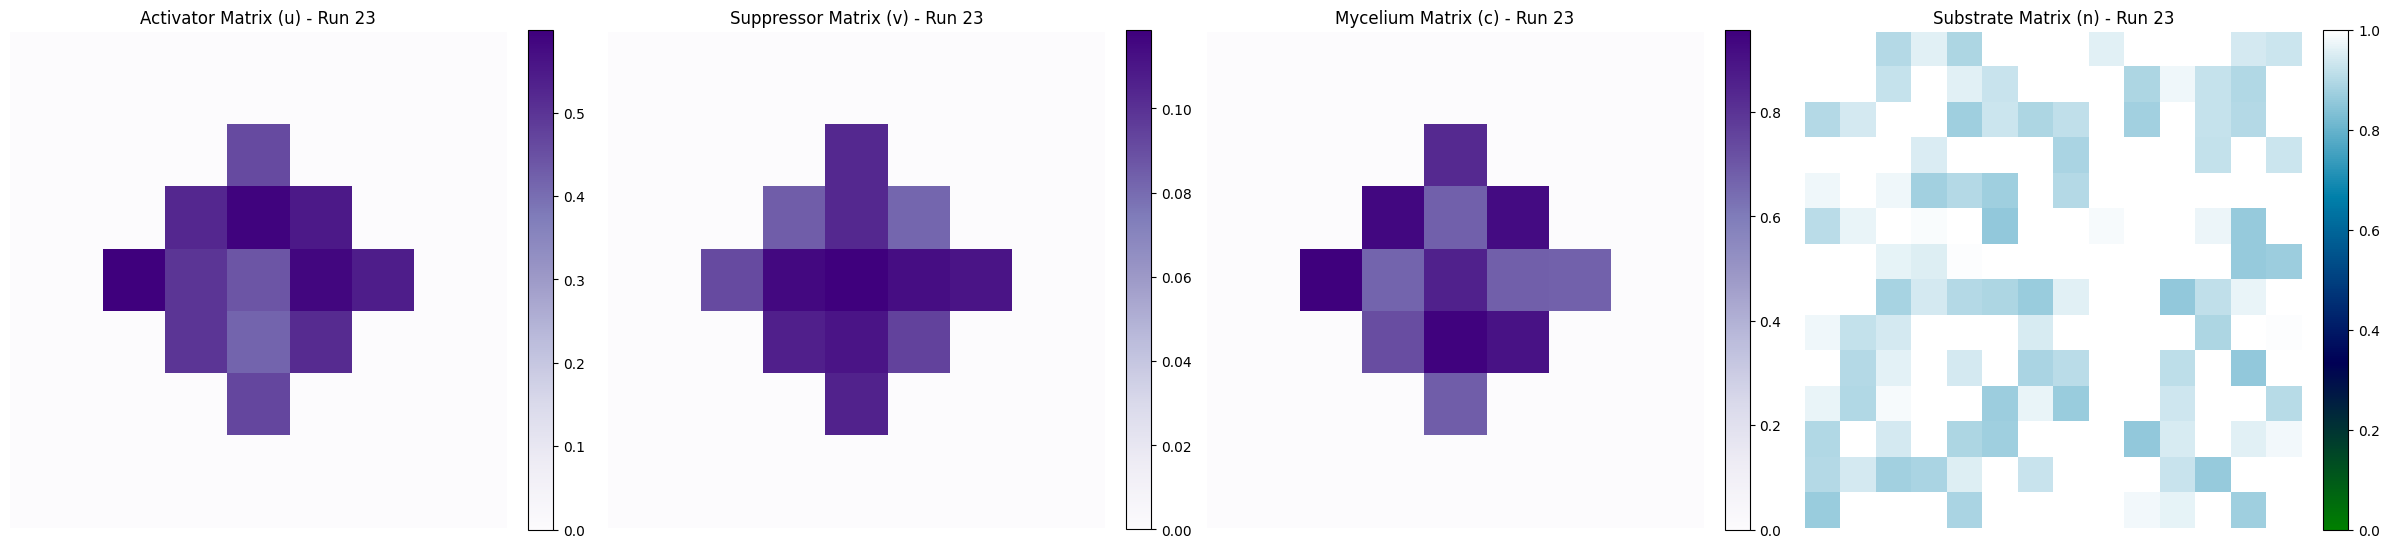

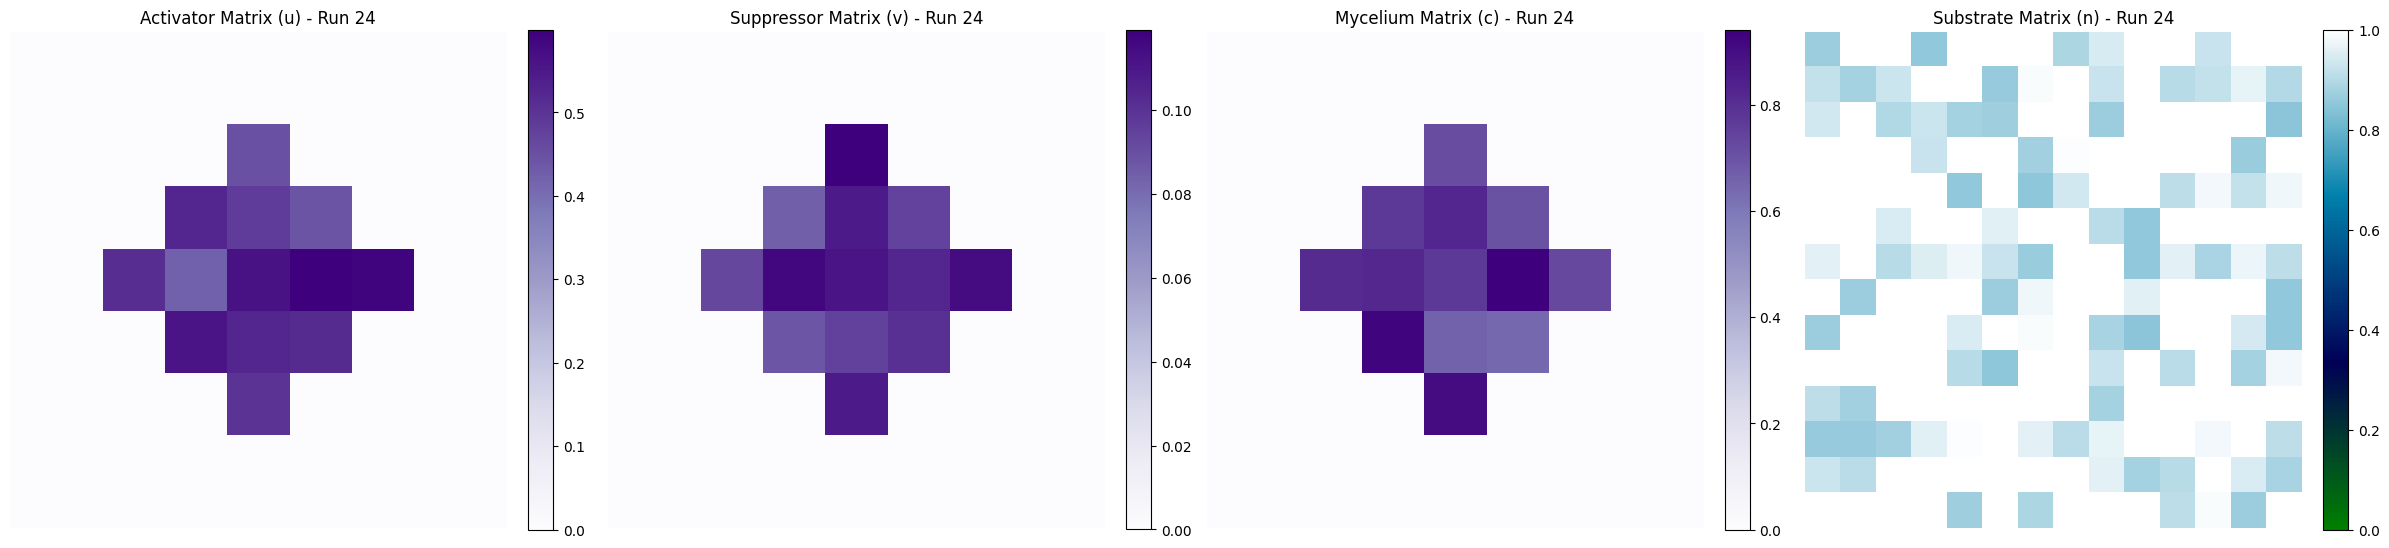

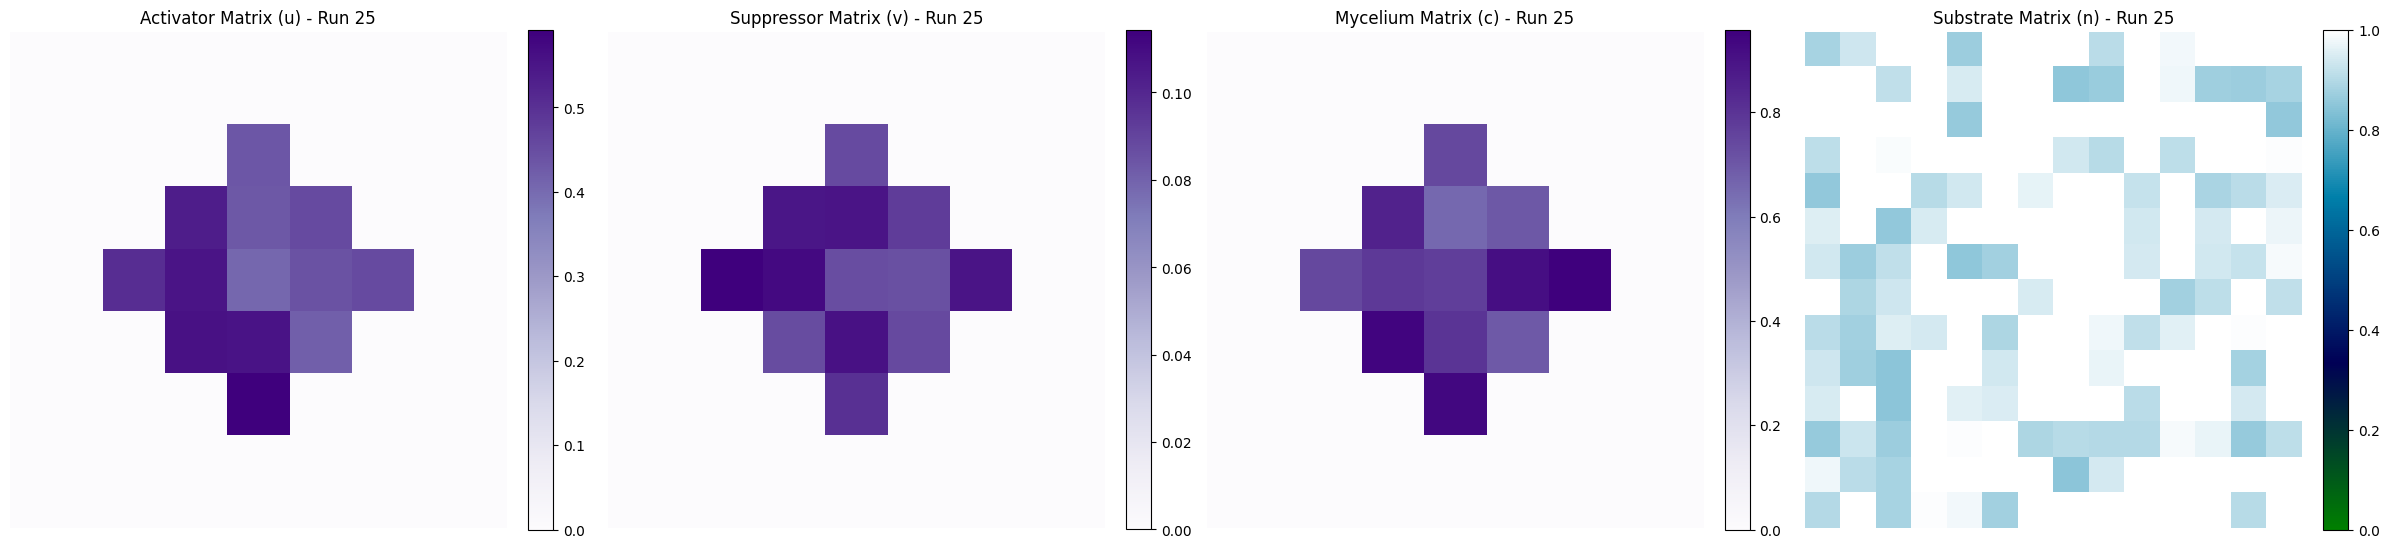

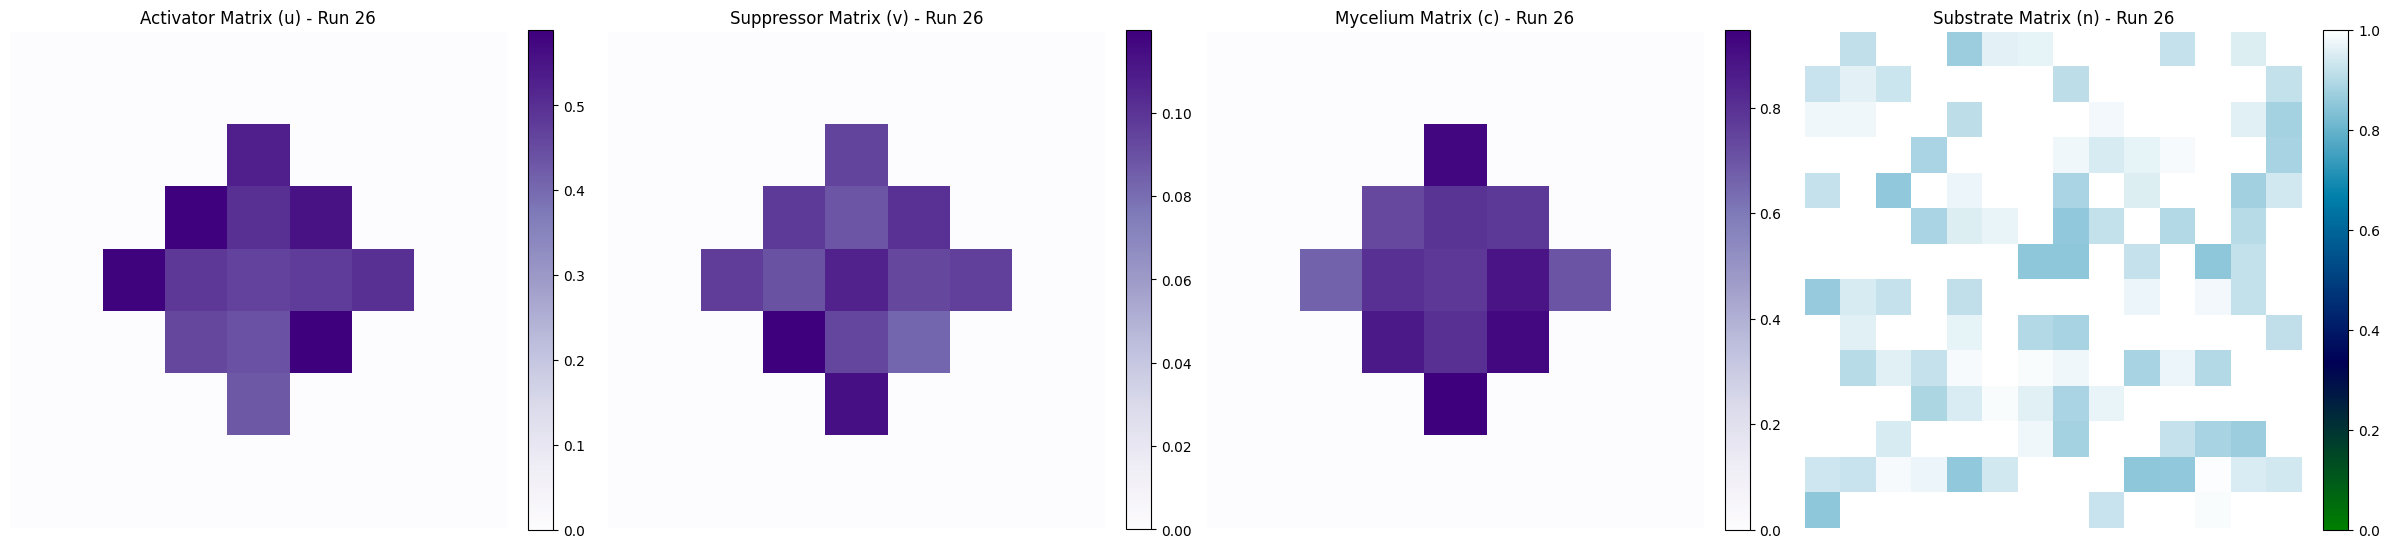

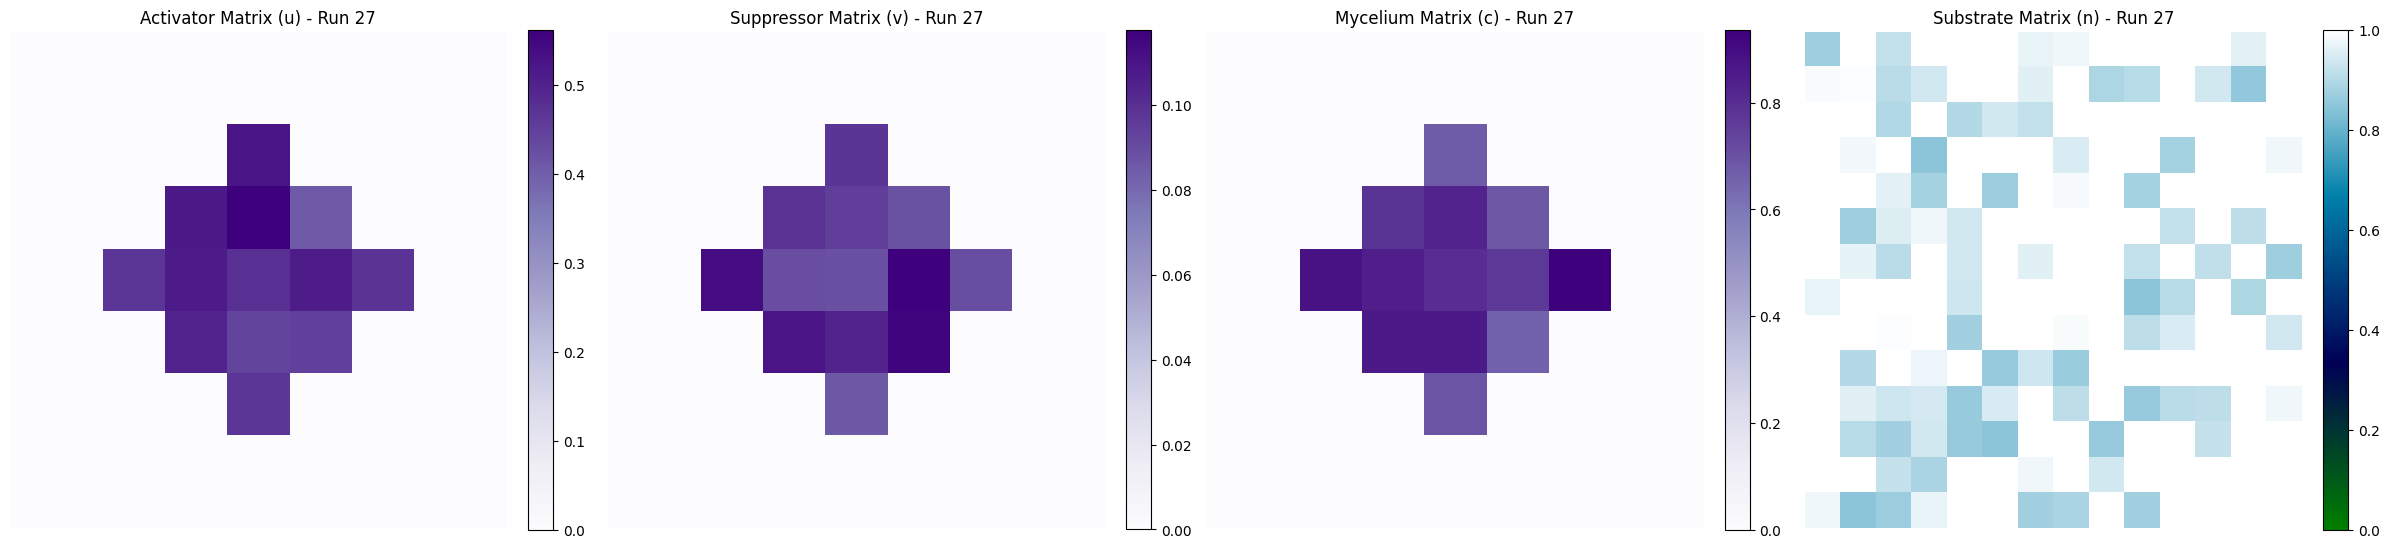

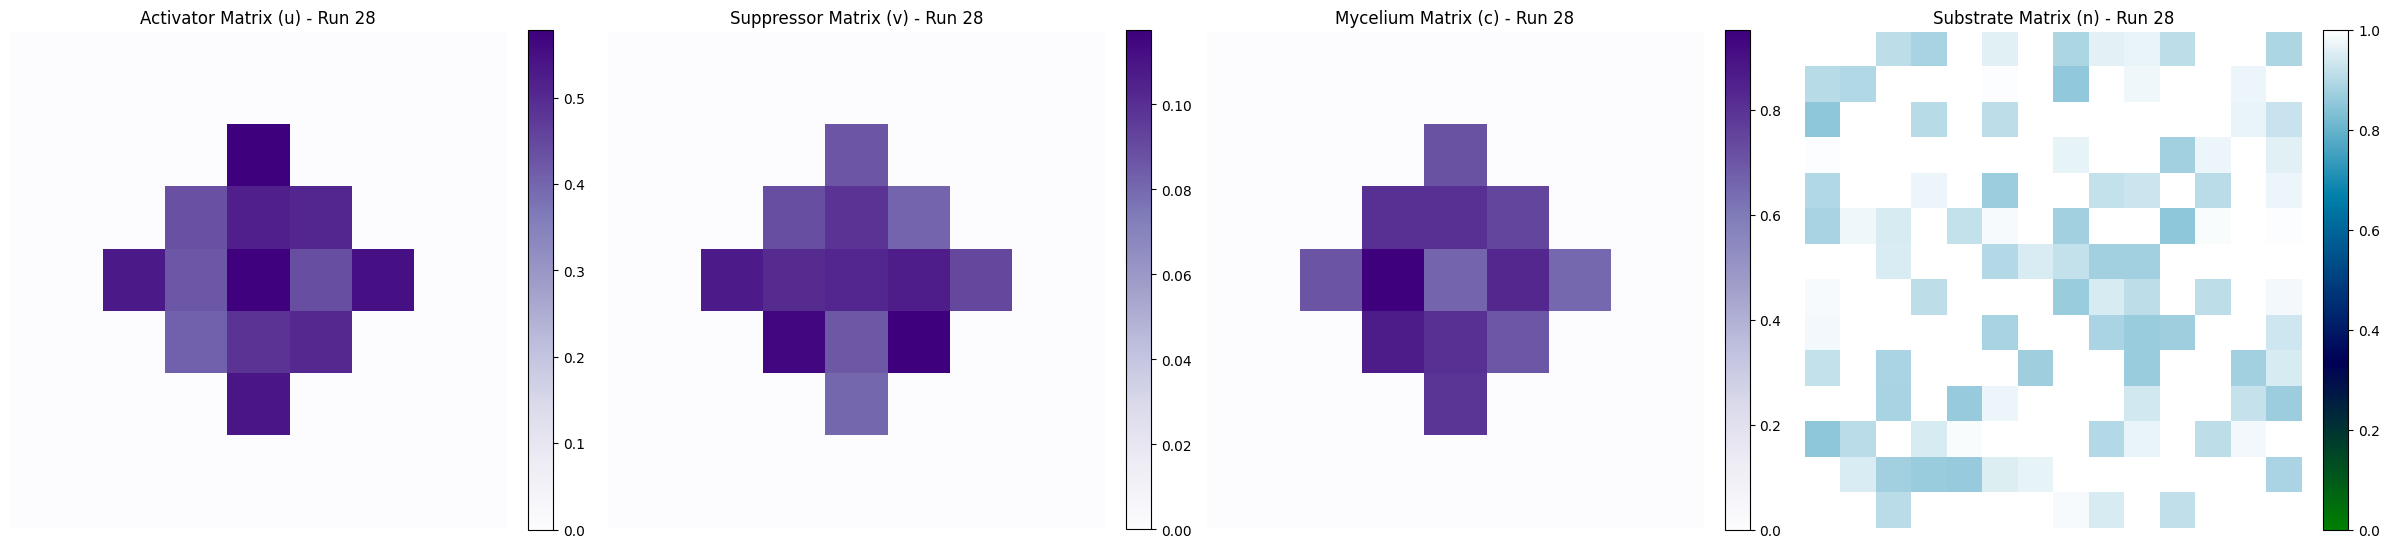

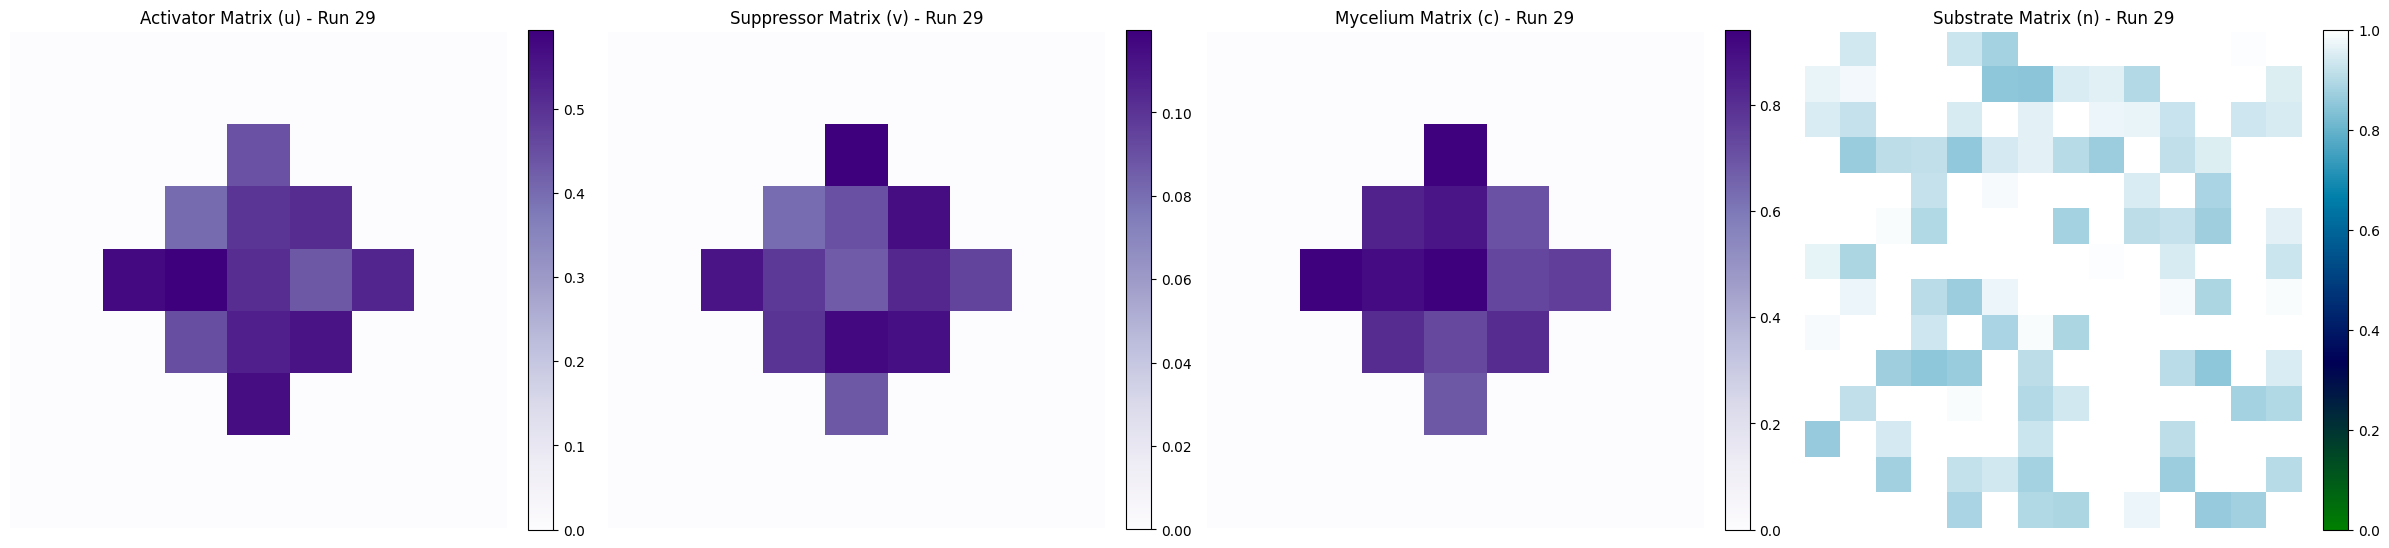

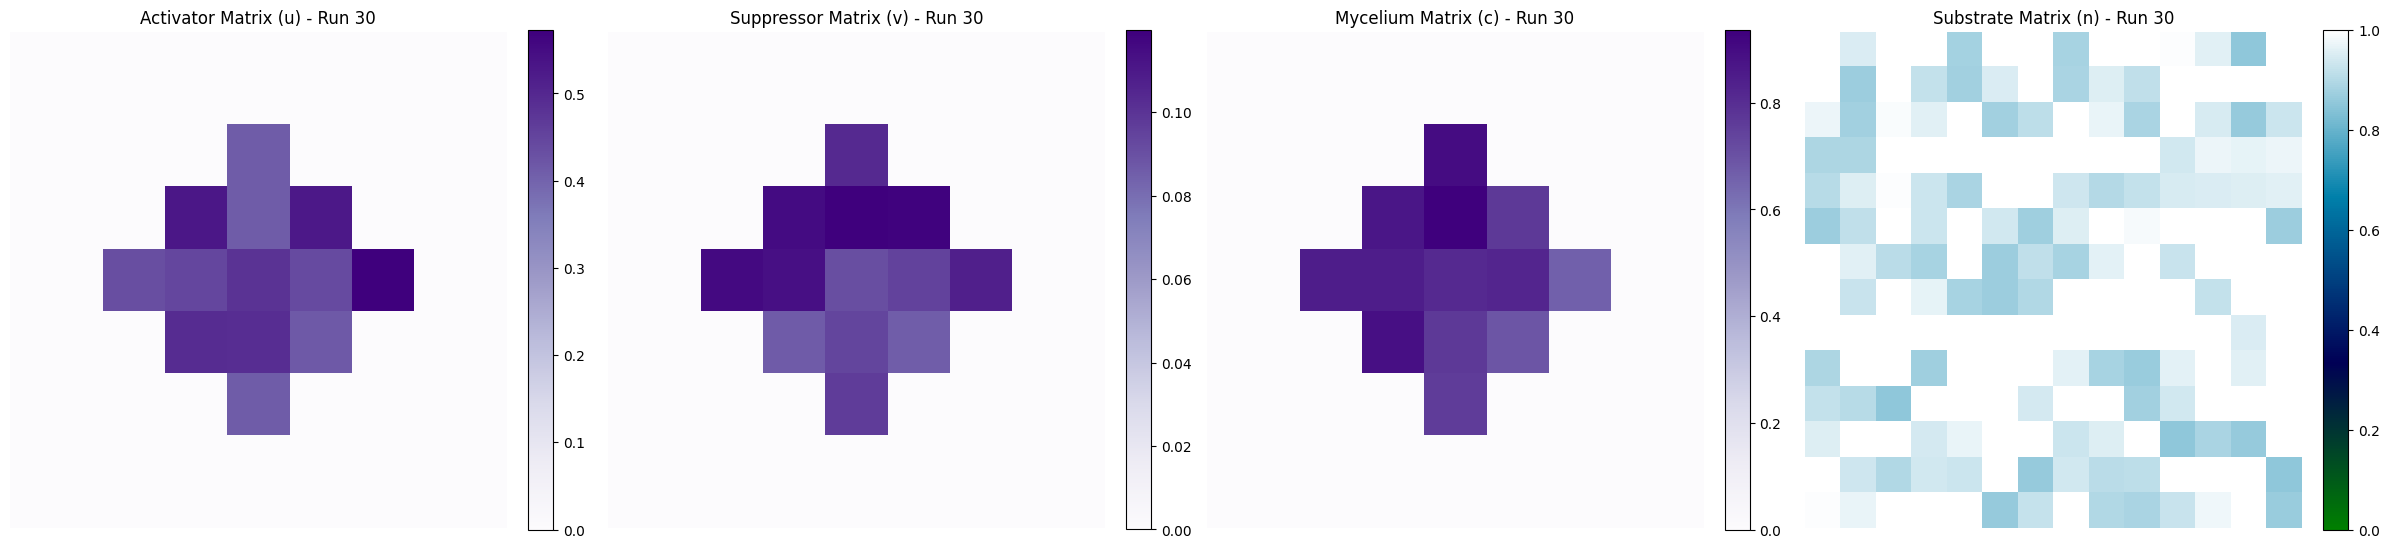

In [208]:
# Assuming 'u', 'v', 'c', 'n', 'mid', 'cen_span', 'no_runs', 'amax', 'smax', and other necessary variables are defined and valid
for run in range(no_runs):

    fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Wider figure to accommodate four subplots

    # Define limits for zooming into the center
    x_limits = (mid-cen_span*2, mid+cen_span*2)
    y_limits = (mid-cen_span*2, mid+cen_span*2)

    # Plot u matrix
    im_u = axs[0].imshow(u[run].cpu().numpy(), cmap='Purples')
    axs[0].set_title(f'Activator Matrix (u) - Run {run + 1}')
    axs[0].axis('off')
    axs[0].set_xlim(x_limits)
    axs[0].set_ylim(y_limits)
    fig.colorbar(im_u, ax=axs[0], fraction=0.046, pad=0.04)  # Add colorbar to the plot of u

    # Plot v matrix
    im_v = axs[1].imshow(v[run].cpu().numpy(), cmap='Purples')
    axs[1].set_title(f'Suppressor Matrix (v) - Run {run + 1}')
    axs[1].axis('off')
    axs[1].set_xlim(x_limits)
    axs[1].set_ylim(y_limits)
    fig.colorbar(im_v, ax=axs[1], fraction=0.046, pad=0.04)  # Add colorbar to the plot of v

    # Plot c matrix
    im_c = axs[2].imshow(c[run].cpu().numpy(), cmap='Purples')
    axs[2].set_title(f'Mycelium Matrix (c) - Run {run + 1}')
    axs[2].axis('off')
    axs[2].set_xlim(x_limits)
    axs[2].set_ylim(y_limits)
    fig.colorbar(im_c, ax=axs[2], fraction=0.046, pad=0.04)  # Add colorbar to the plot of c

    # Plot n matrix
    im_n = axs[3].imshow(n[run].cpu().numpy(), cmap='ocean', vmin=0, vmax=1)
    axs[3].set_title(f'Substrate Matrix (n) - Run {run + 1}')
    axs[3].axis('off')
    fig.colorbar(im_n, ax=axs[3], fraction=0.046, pad=0.04)  # Add colorbar to the plot of n

    plt.tight_layout()
    plt.show()


In [209]:
def update_visualization(run, step, u, v, c, n):
    fig = plt.figure(figsize=(15, 15))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='viridis', vmin=0, vmax=amax)
    ax1.set_title(f'Run {run + 1} - Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='viridis', vmin=0, vmax=smax)
    ax2.set_title(f'Run {run + 1} - Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='Purples', vmin=0, vmax=1)
    ax3.set_title(f'Run {run + 1} - Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='ocean', vmin=0, vmax=1)
    ax4.set_title(f'Run {run + 1} - Substrate at iteration {step}')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

In [210]:
# %%
# # Pre-calculate the Laplacian kernel indices and weights if they remain constant
lap_kernel = torch.zeros((2*depth+1, 2*depth+1), device=device)
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            lap_kernel[depth, depth] = lap
        elif abs(dx) == abs(dy):
            lap_kernel[depth + dx, depth + dy] = lap_diag
        else:
            lap_kernel[depth + dx, depth + dy] = lap_side

print(lap_kernel)
print(lap_kernel.shape)

# %%
# Define the 3x3 Laplacian kernel L
L = torch.tensor([
    [lap_diag, lap_side, lap_diag],
    [lap_side, -lap,     lap_side],
    [lap_diag, lap_side, lap_diag]
], dtype=torch.float32, device=device)

print(L)

repeat_factor = grid_size // 5
D = lap_kernel.repeat(repeat_factor, repeat_factor)


print(f"D shape: {D.shape}")  # Should be (grid_size, grid_size)

tensor([[0.0515, 0.0735, 0.0735, 0.0735, 0.0515],
        [0.0735, 0.0515, 0.0735, 0.0515, 0.0735],
        [0.0735, 0.0735, 0.5000, 0.0735, 0.0735],
        [0.0735, 0.0515, 0.0735, 0.0515, 0.0735],
        [0.0515, 0.0735, 0.0735, 0.0735, 0.0515]], device='cuda:0')
torch.Size([5, 5])
tensor([[ 0.0515,  0.0735,  0.0515],
        [ 0.0735, -0.5000,  0.0735],
        [ 0.0515,  0.0735,  0.0515]], device='cuda:0')
D shape: torch.Size([10, 10])


In [211]:
# %%
import torch.nn.functional as F

def conv2_same(input_tensor, kernel):
    # Ensure the kernel has 4 dimensions
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, kH, kW]
    elif kernel.dim() == 4:
        pass  # Already in the correct shape
    else:
        raise ValueError("Kernel must be a 2D or 4D tensor.")
    
    # Extract kernel dimensions
    _, _, kH, kW = kernel.shape
    
    # Calculate padding for 'same' convolution
    pad_h = (kH - 1) // 2
    pad_w = (kW - 1) // 2
    
    # Reshape input to [N, C, H, W]
    input_reshaped = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Perform convolution with calculated padding
    conv_result = F.conv2d(input_reshaped, kernel, padding=(pad_h, pad_w))
    
    # Reshape back to [H, W]
    return conv_result.squeeze(0).squeeze(0)

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_0_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_0_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_0_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_0_step_0.csv using NumPy with double precision.


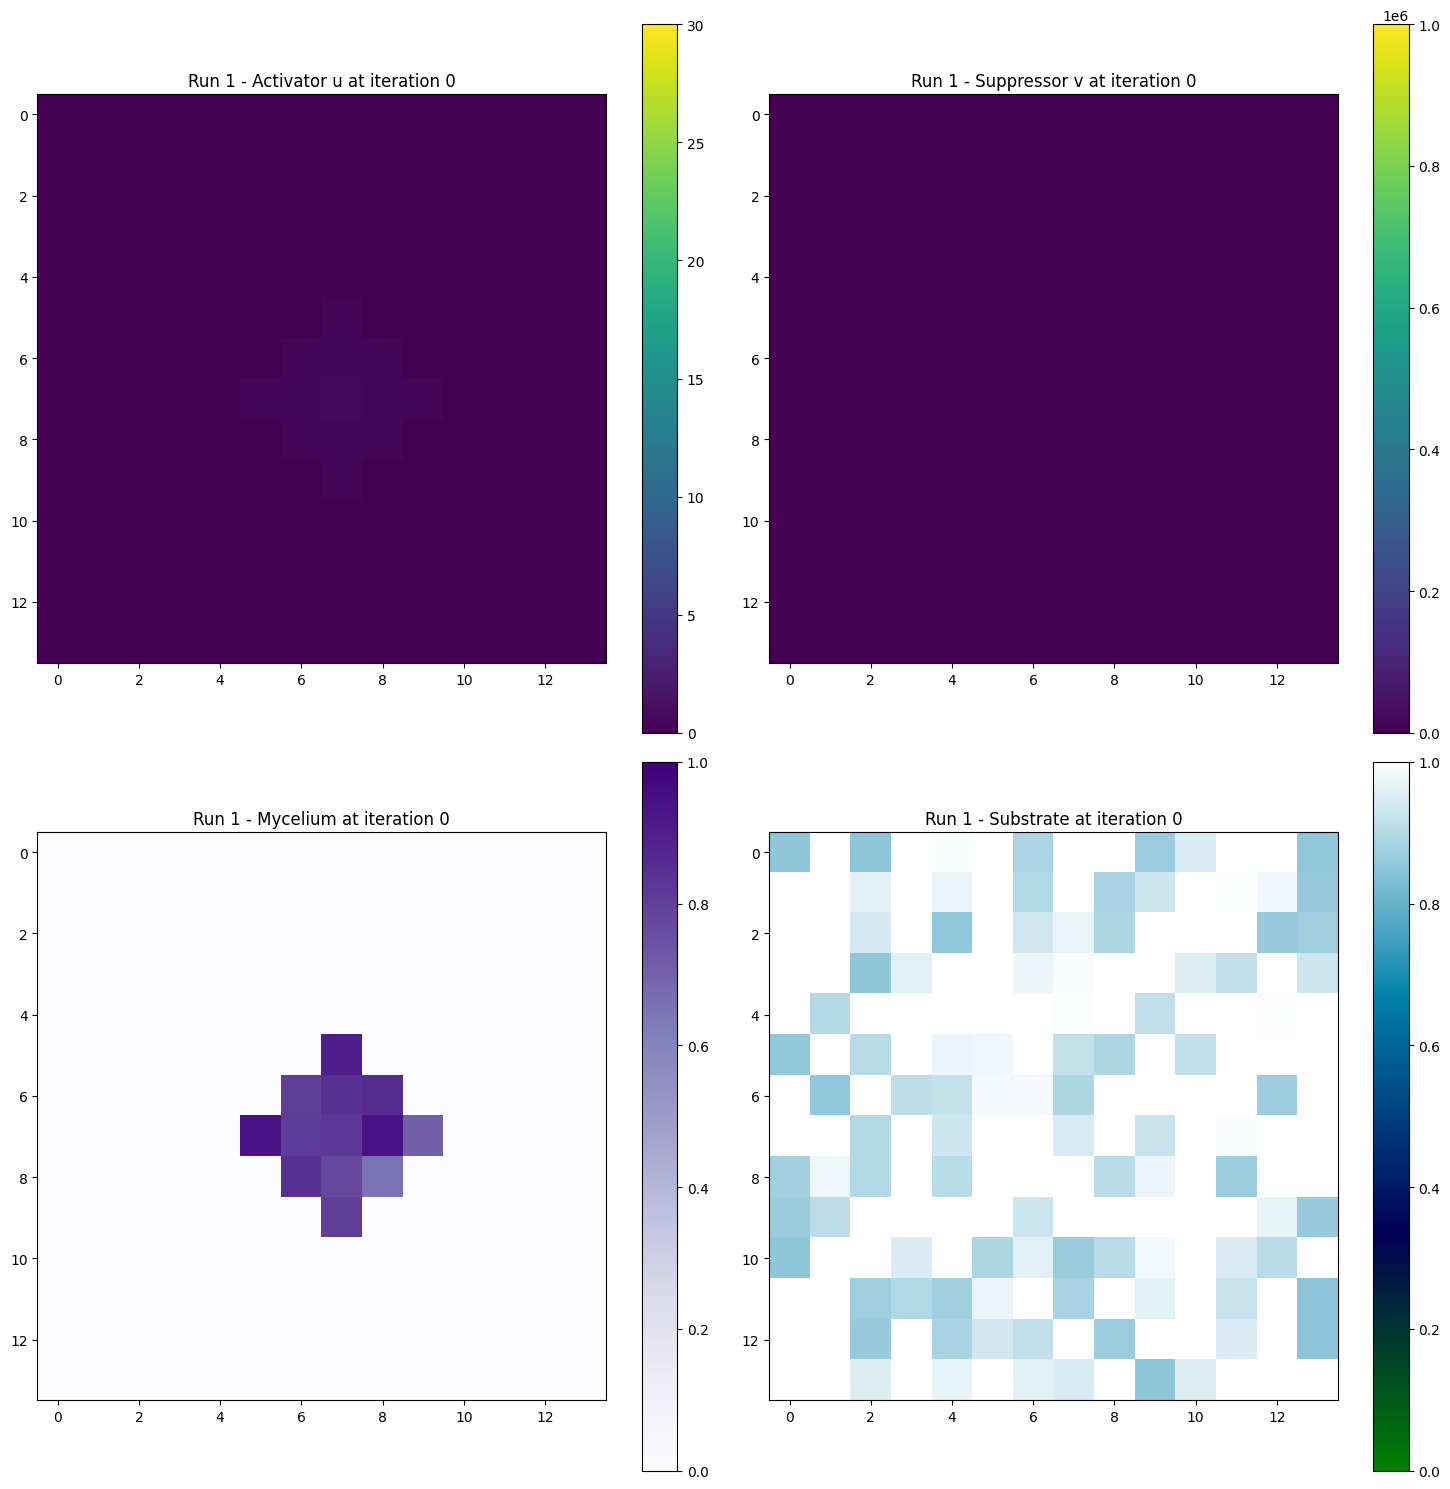

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_0_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_0_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_0_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_0_step_10000.csv using NumPy with double precision.


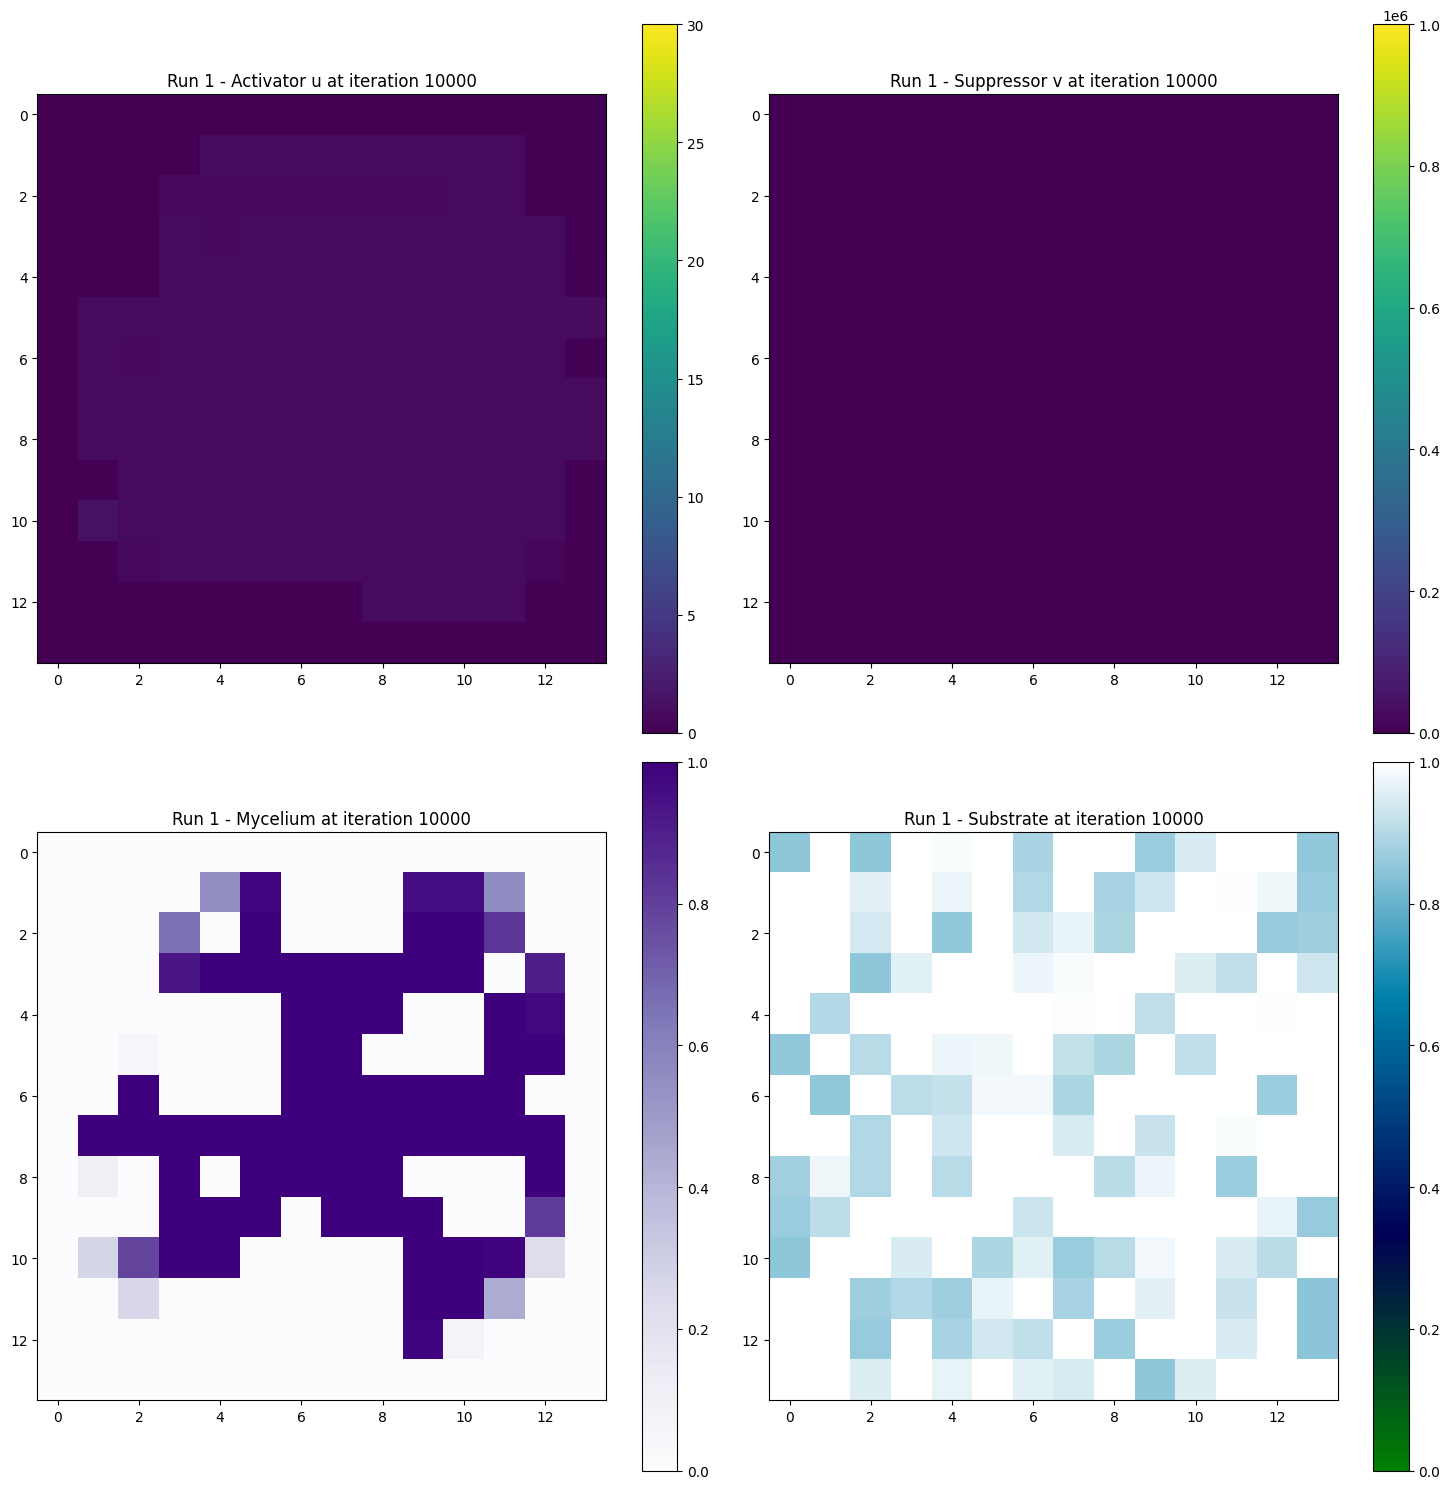

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_1_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_1_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_1_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_1_step_0.csv using NumPy with double precision.


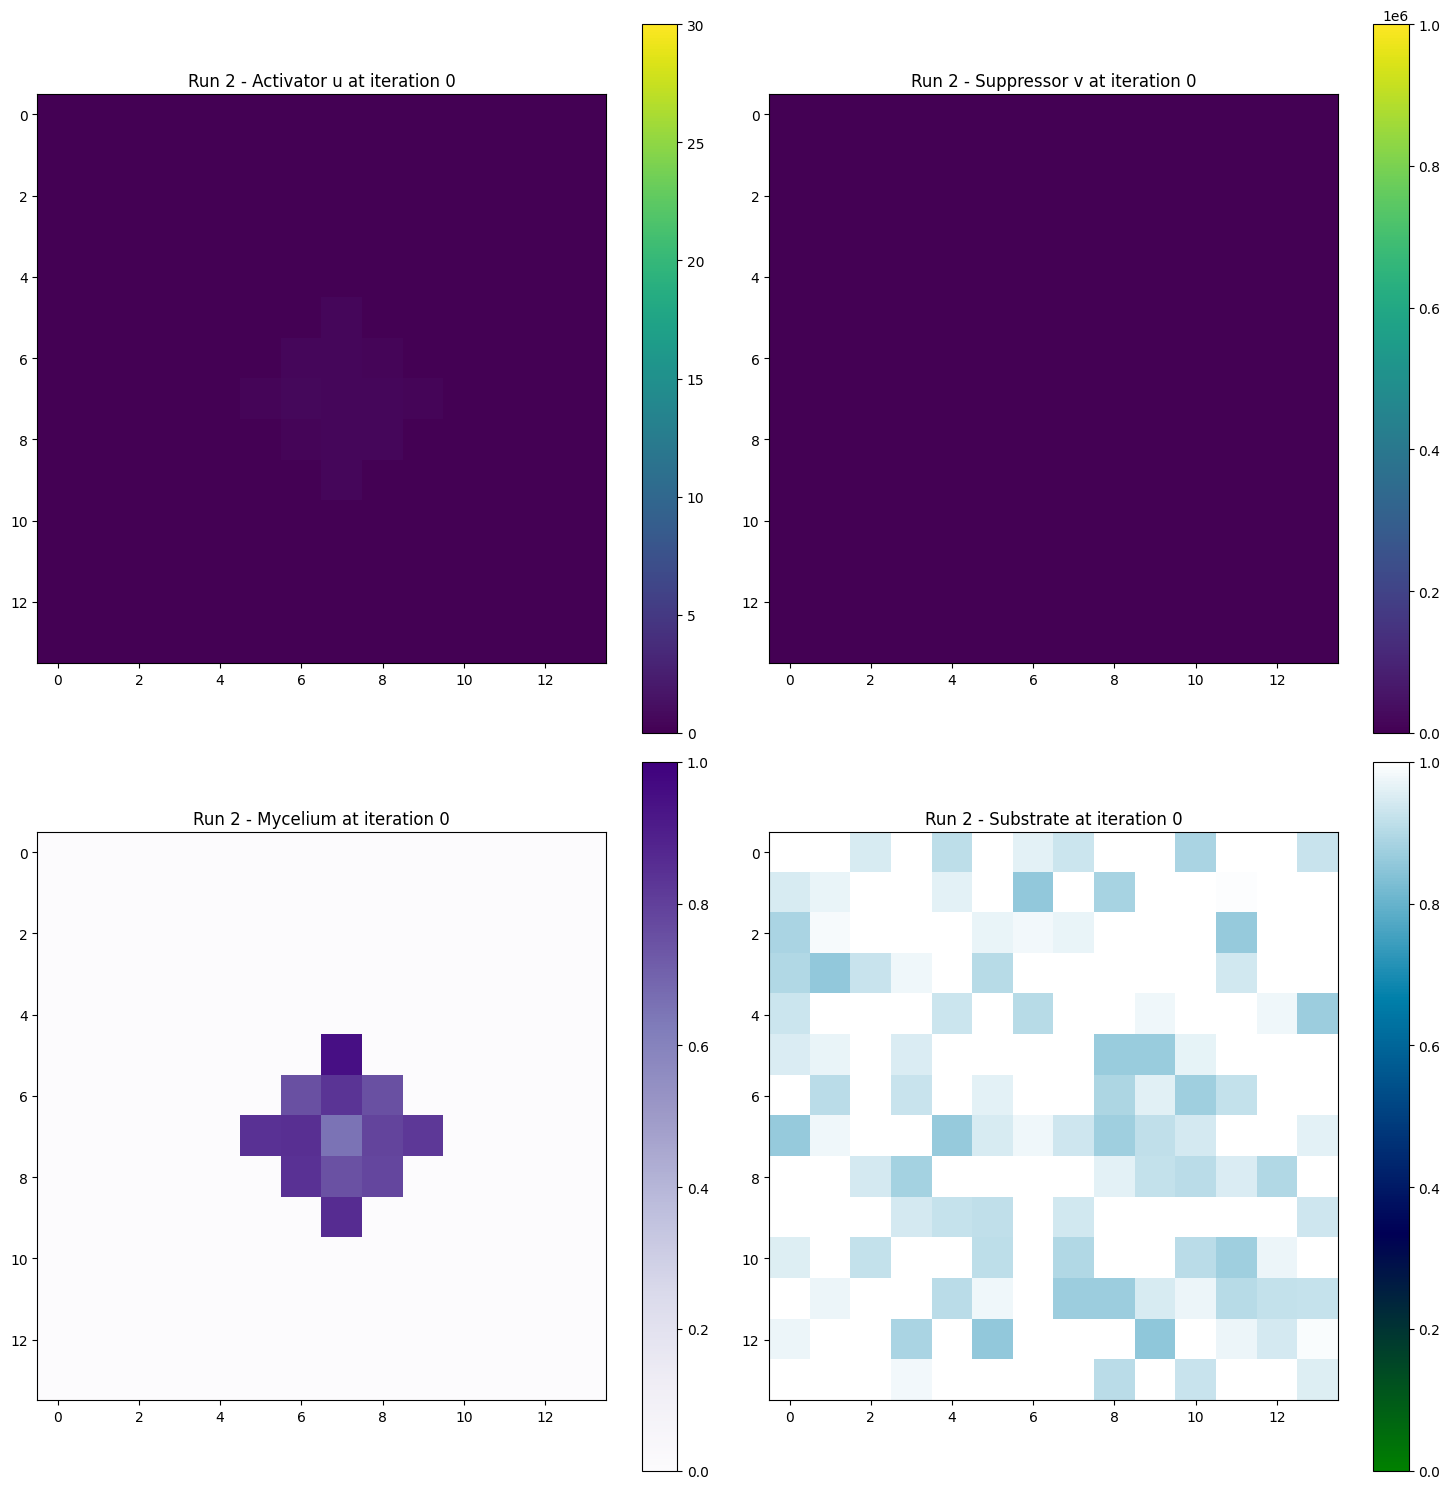

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_1_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_1_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_1_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_1_step_10000.csv using NumPy with double precision.


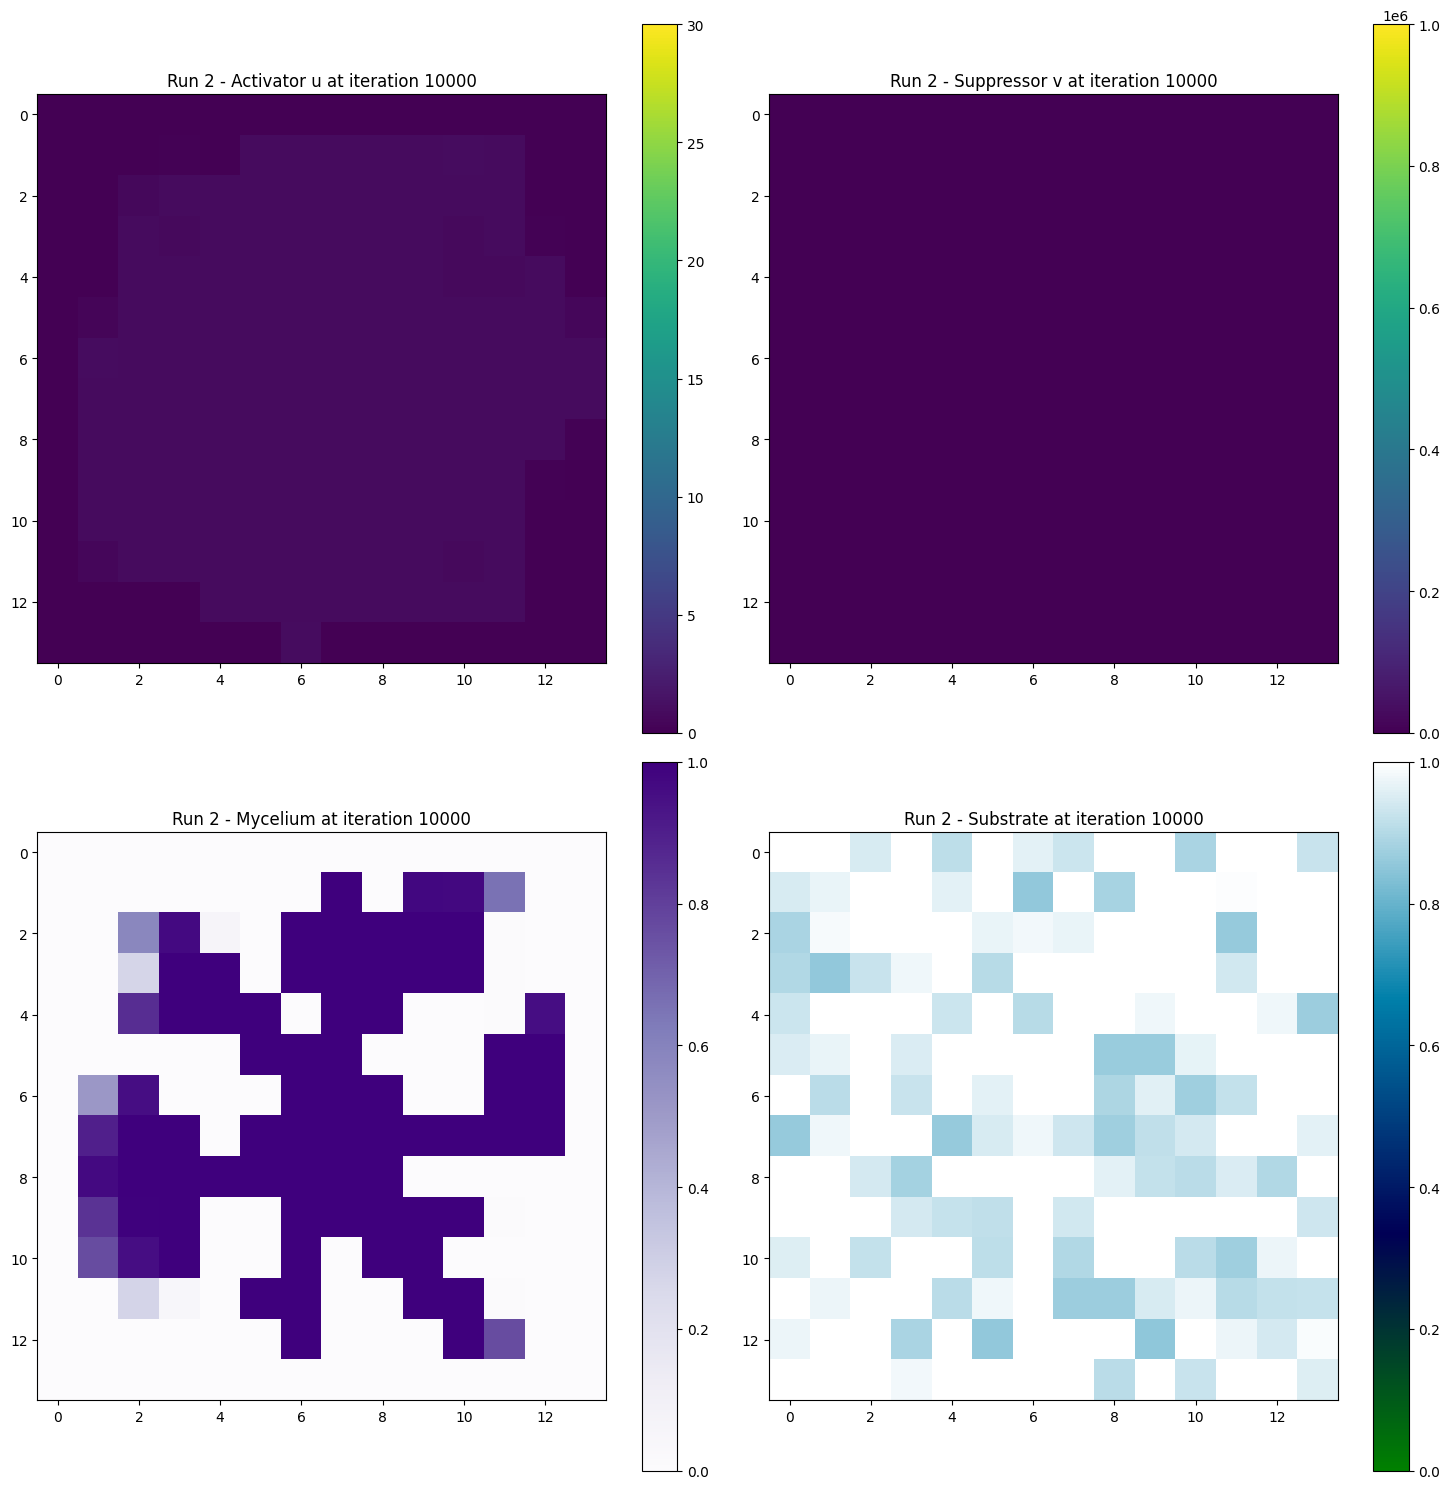

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_2_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_2_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_2_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_2_step_0.csv using NumPy with double precision.


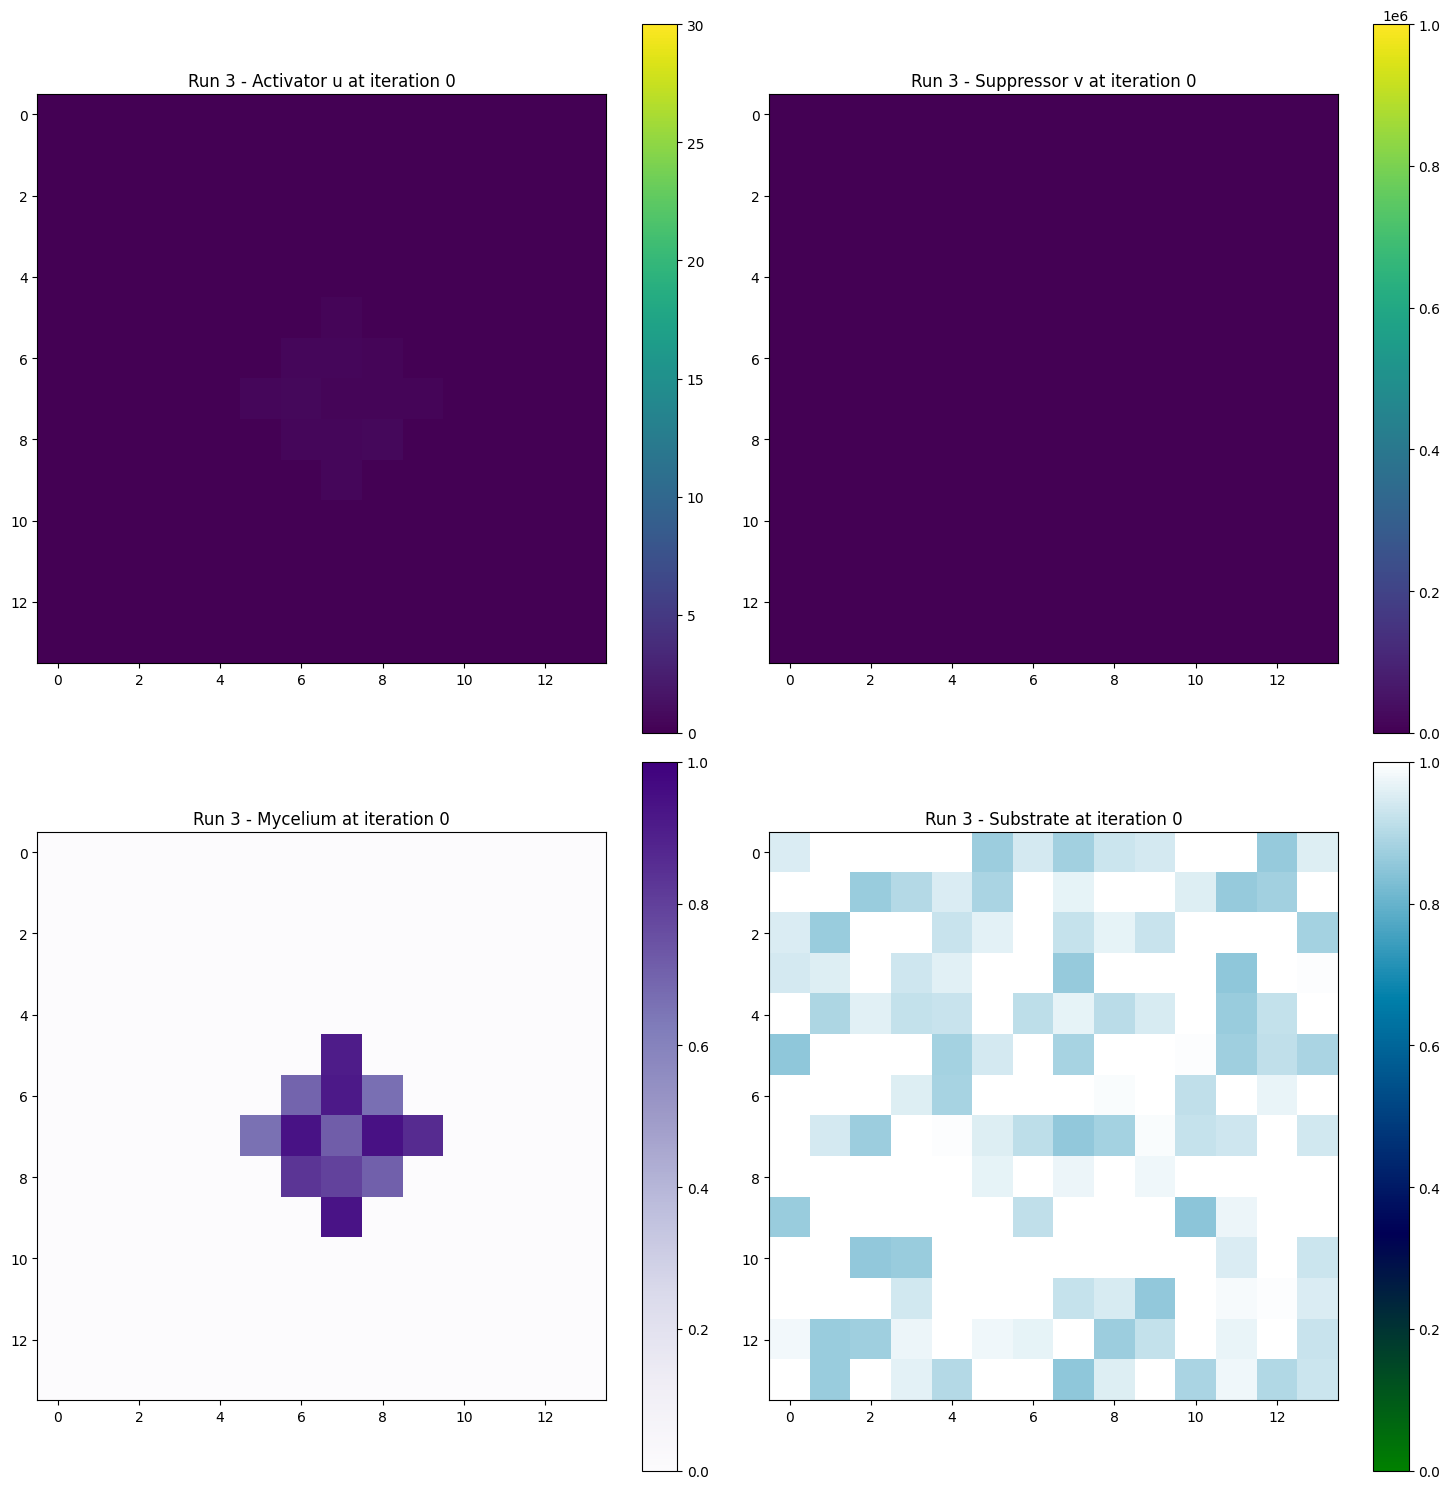

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_2_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_2_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_2_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_2_step_10000.csv using NumPy with double precision.


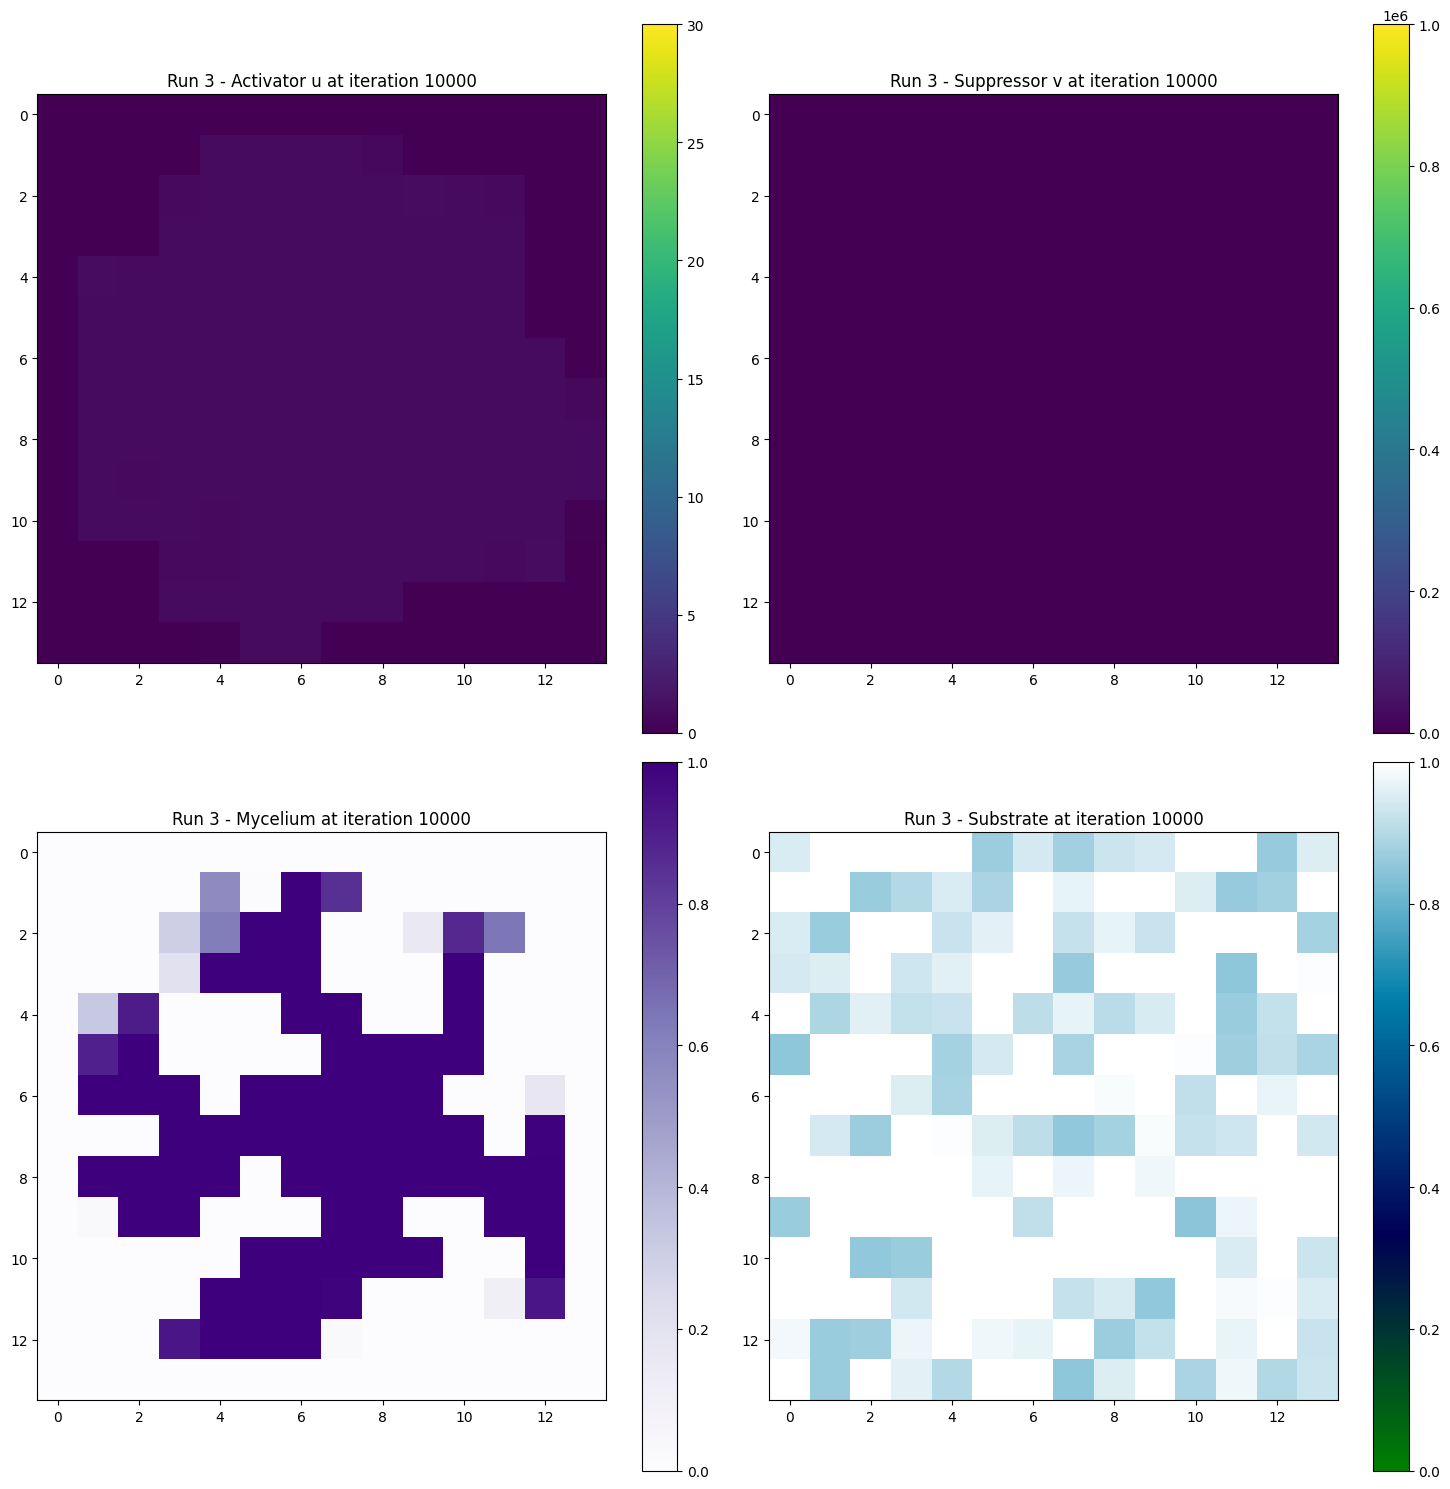

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_3_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_3_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_3_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_3_step_0.csv using NumPy with double precision.


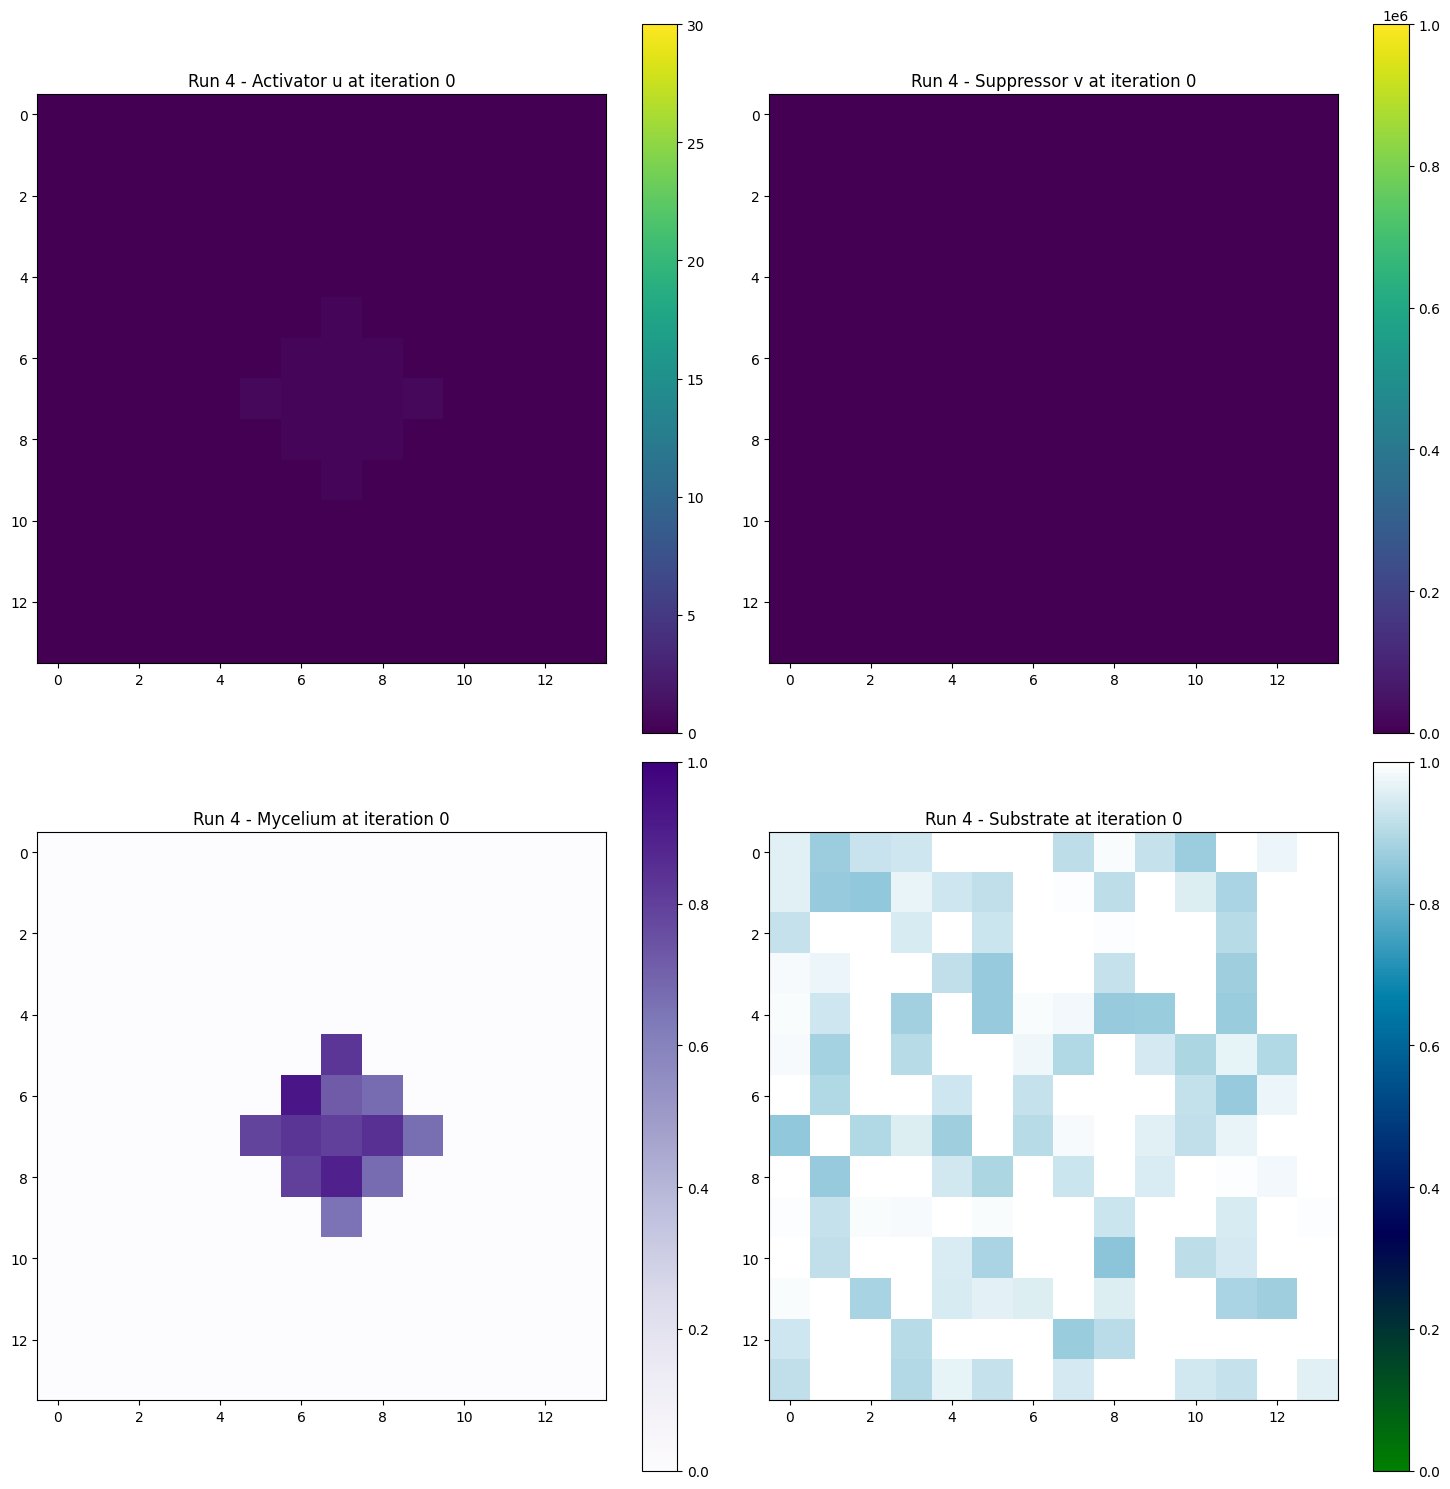

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_3_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_3_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_3_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_3_step_10000.csv using NumPy with double precision.


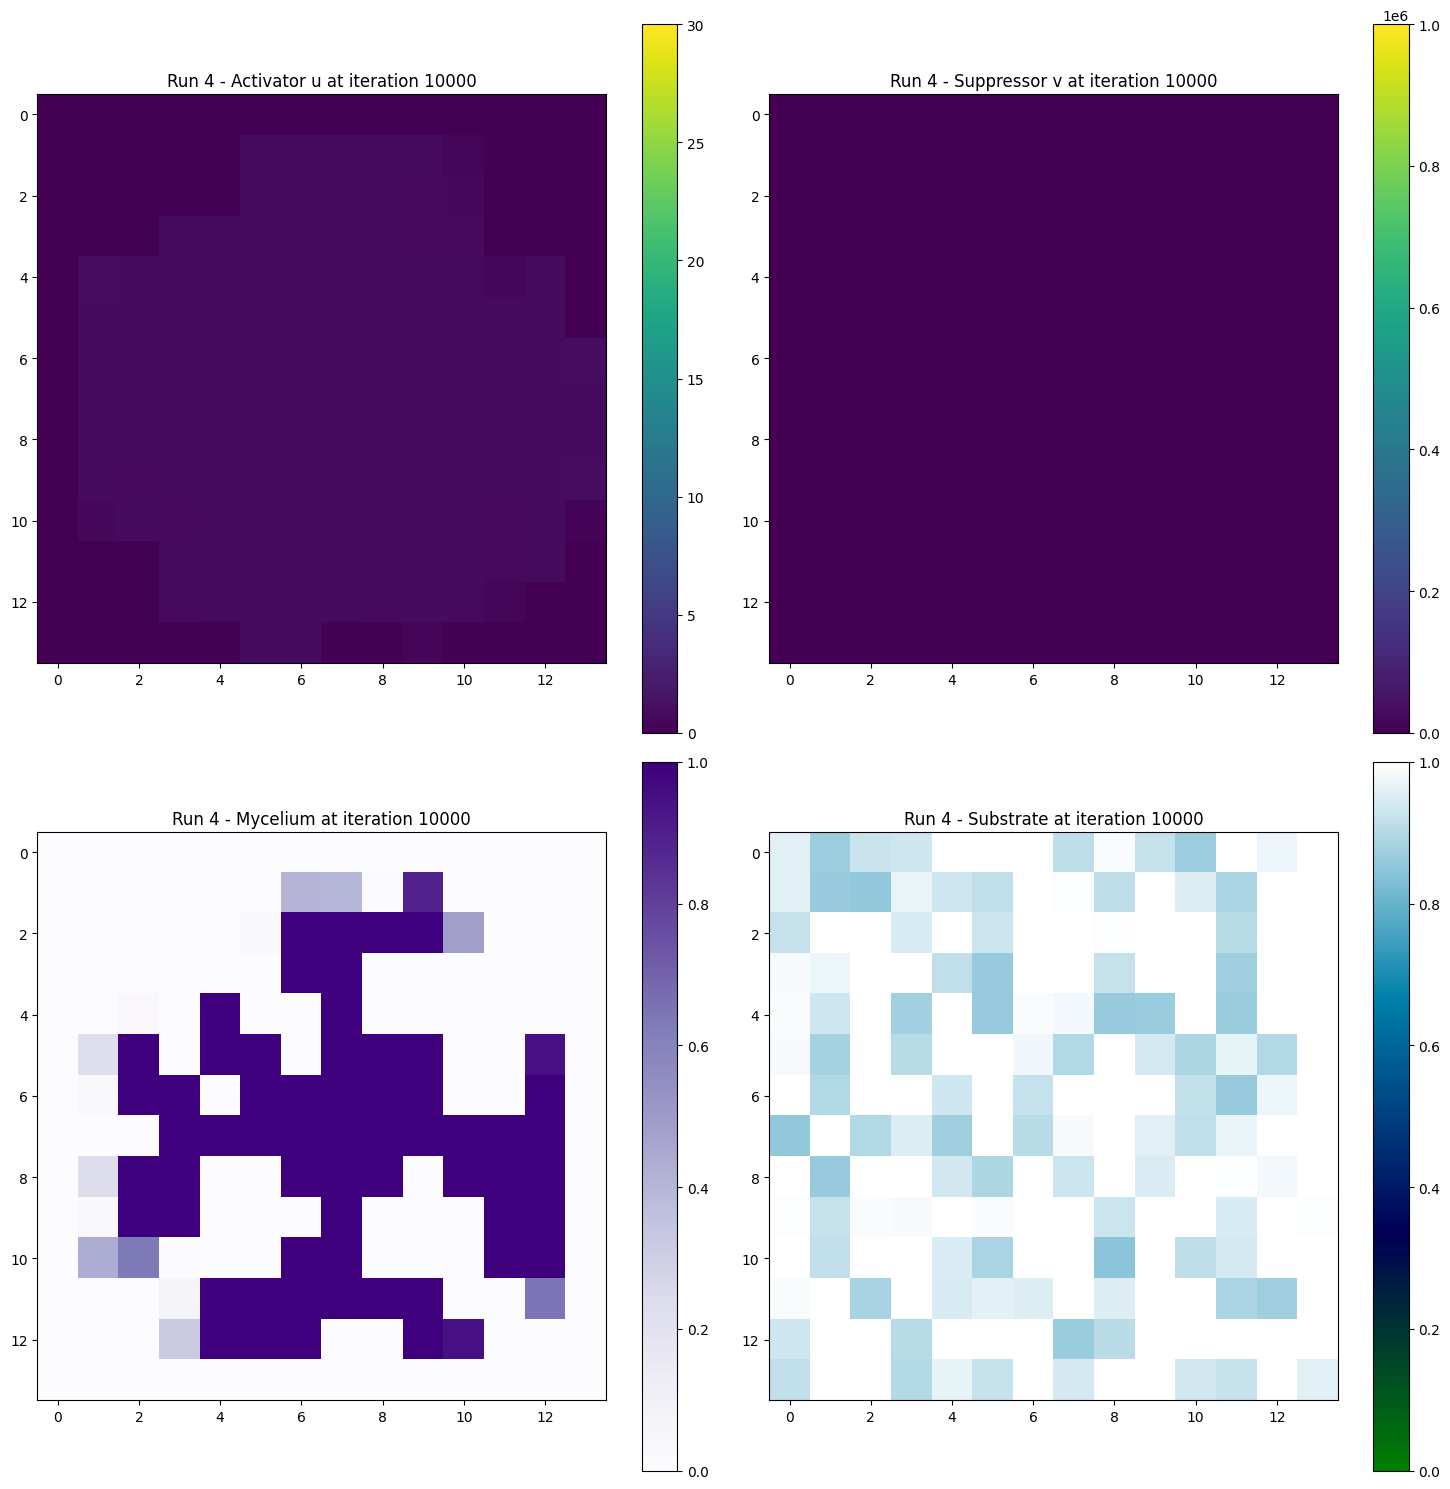

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_4_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_4_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_4_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_4_step_0.csv using NumPy with double precision.


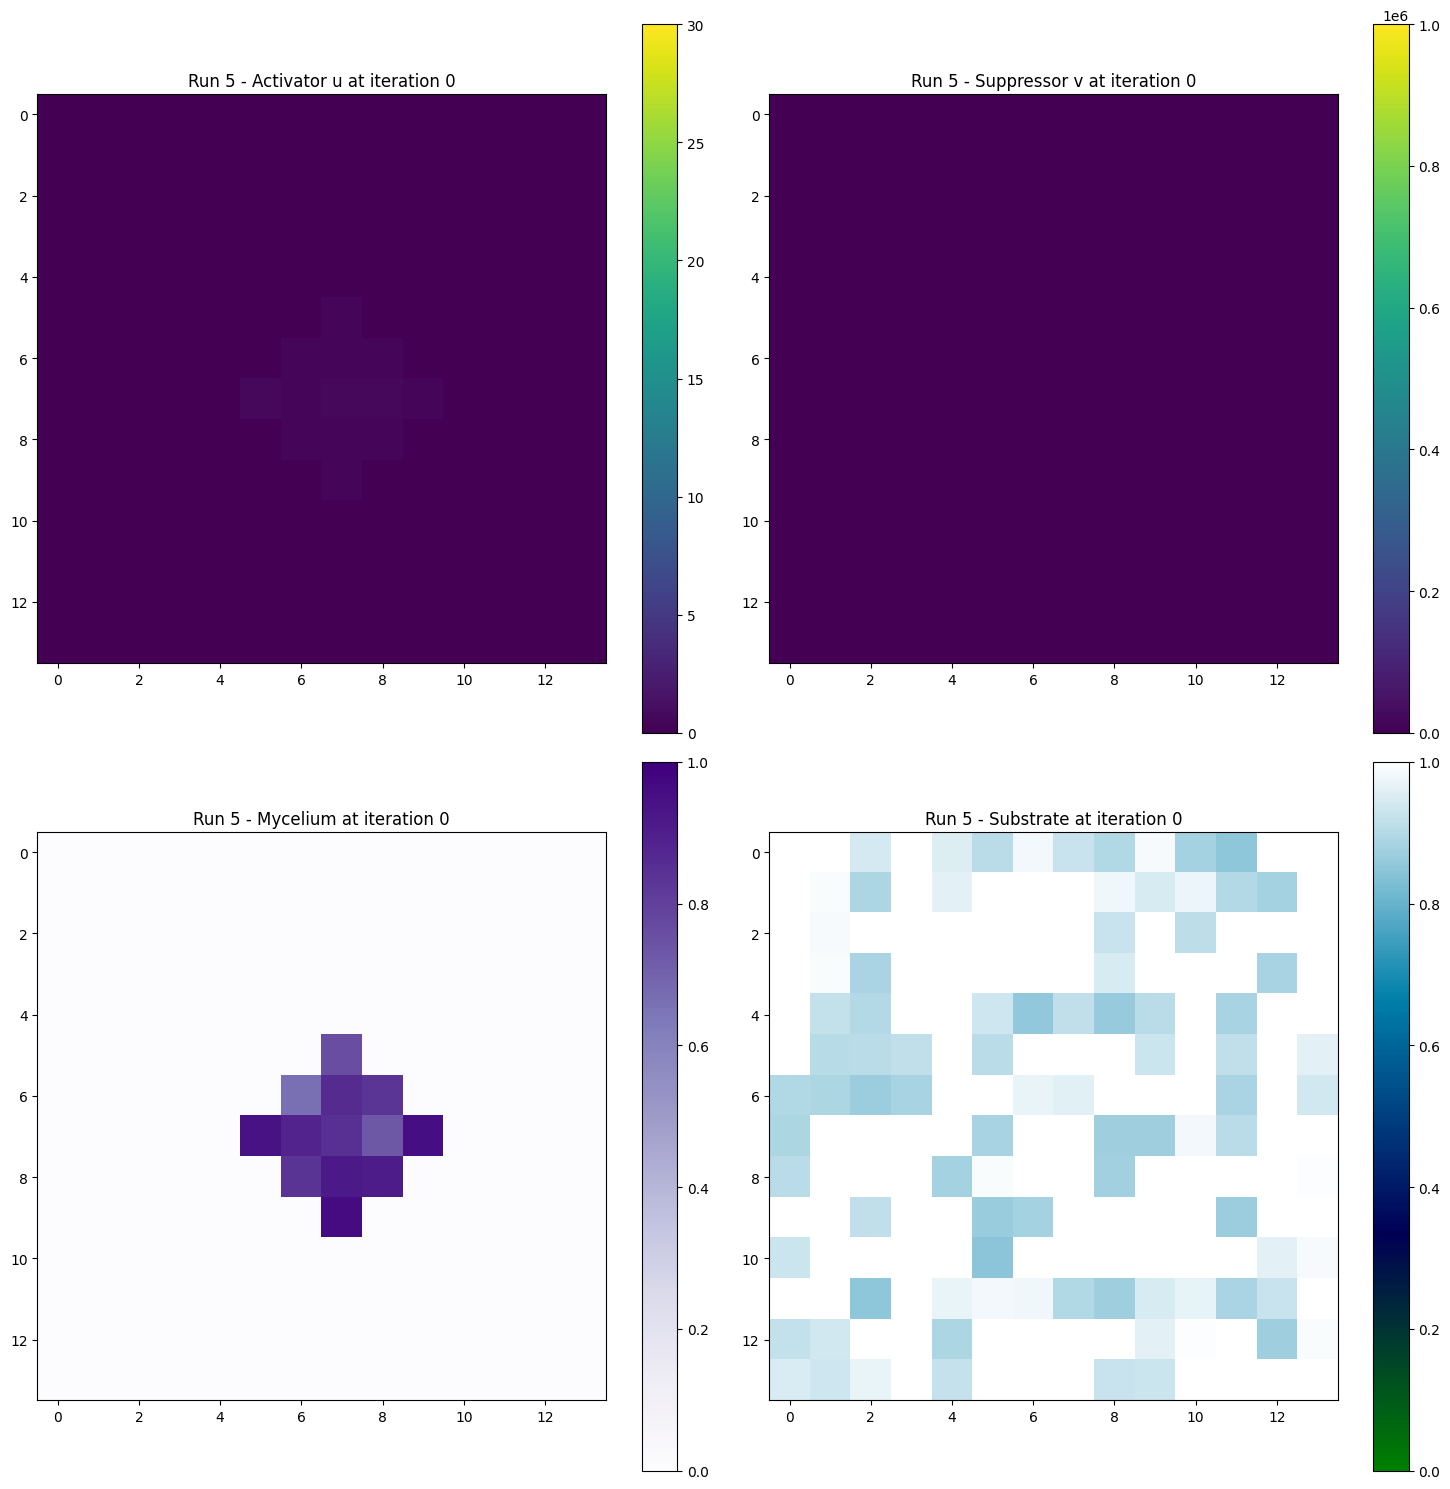

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_4_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_4_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_4_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_4_step_10000.csv using NumPy with double precision.


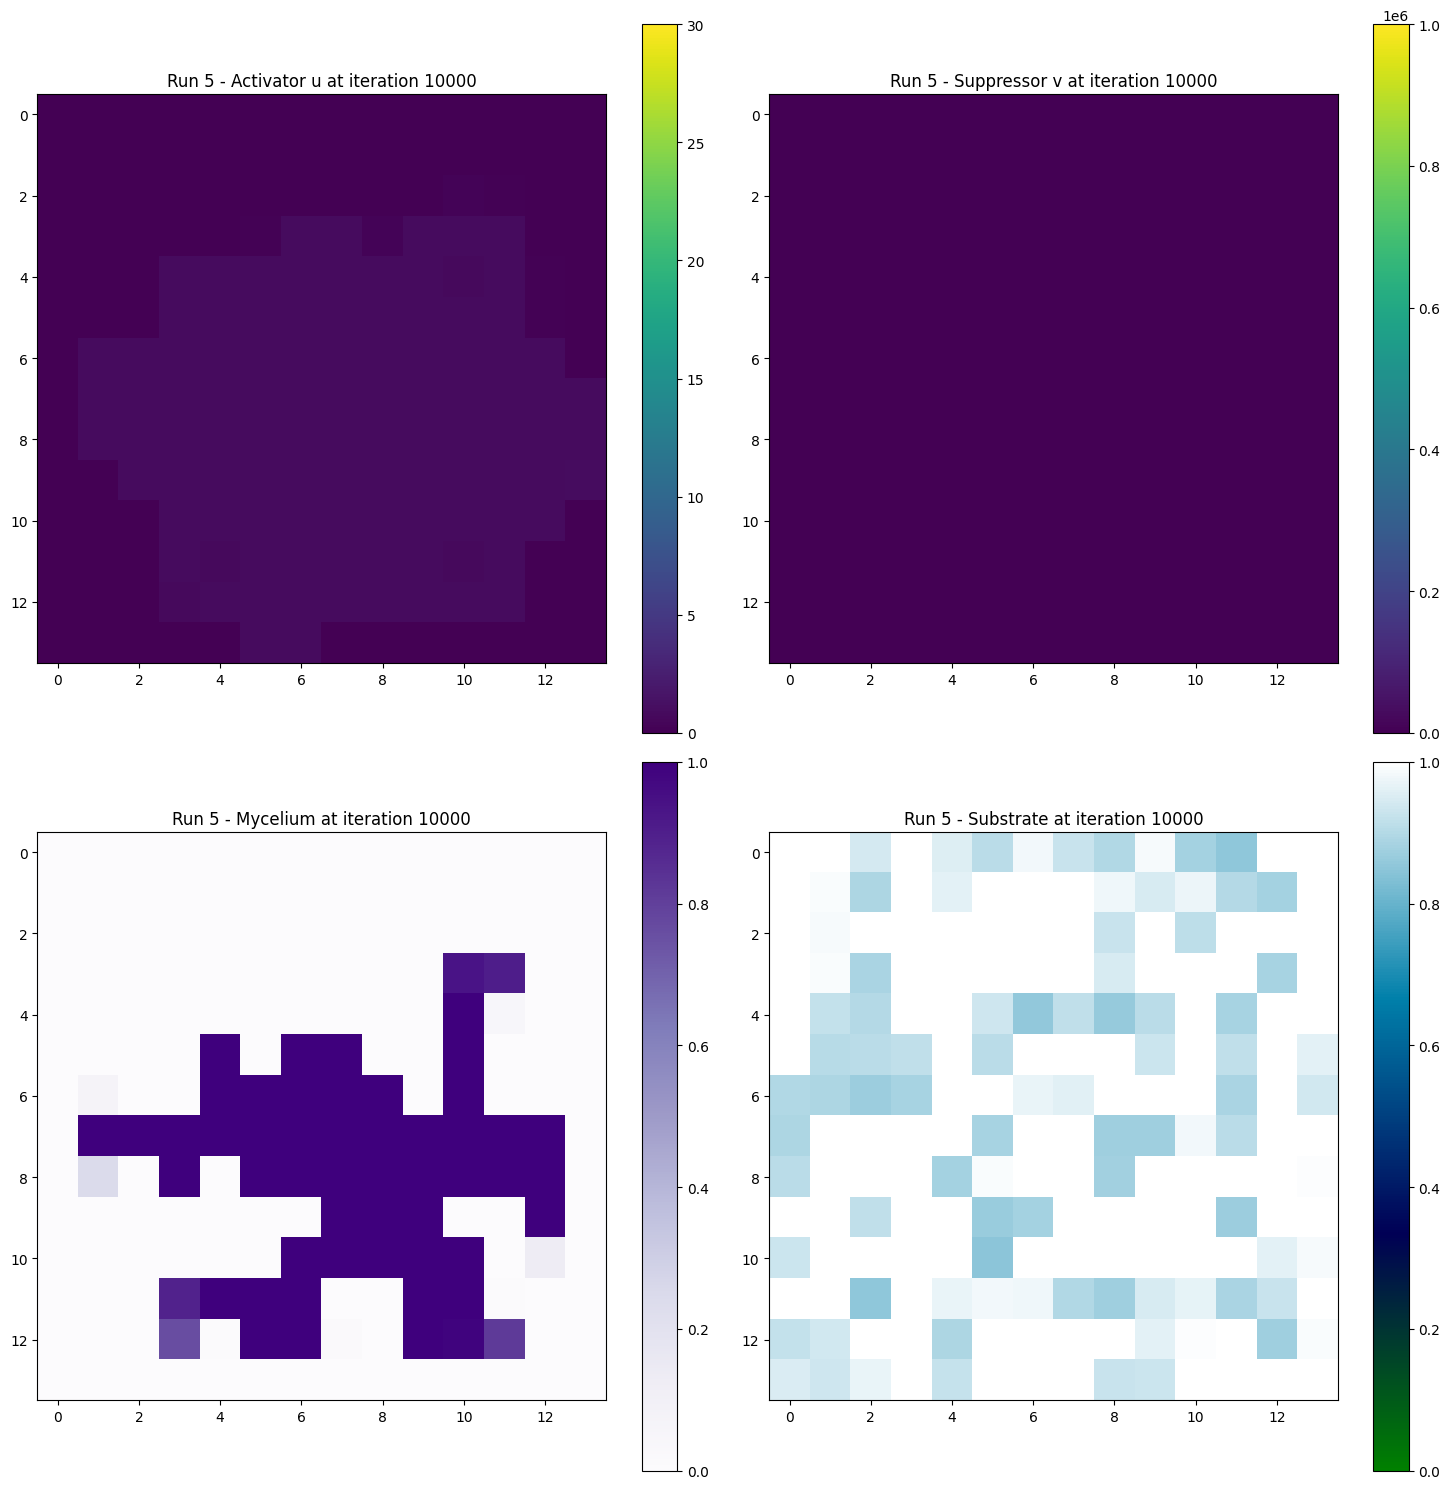

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_5_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_5_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_5_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_5_step_0.csv using NumPy with double precision.


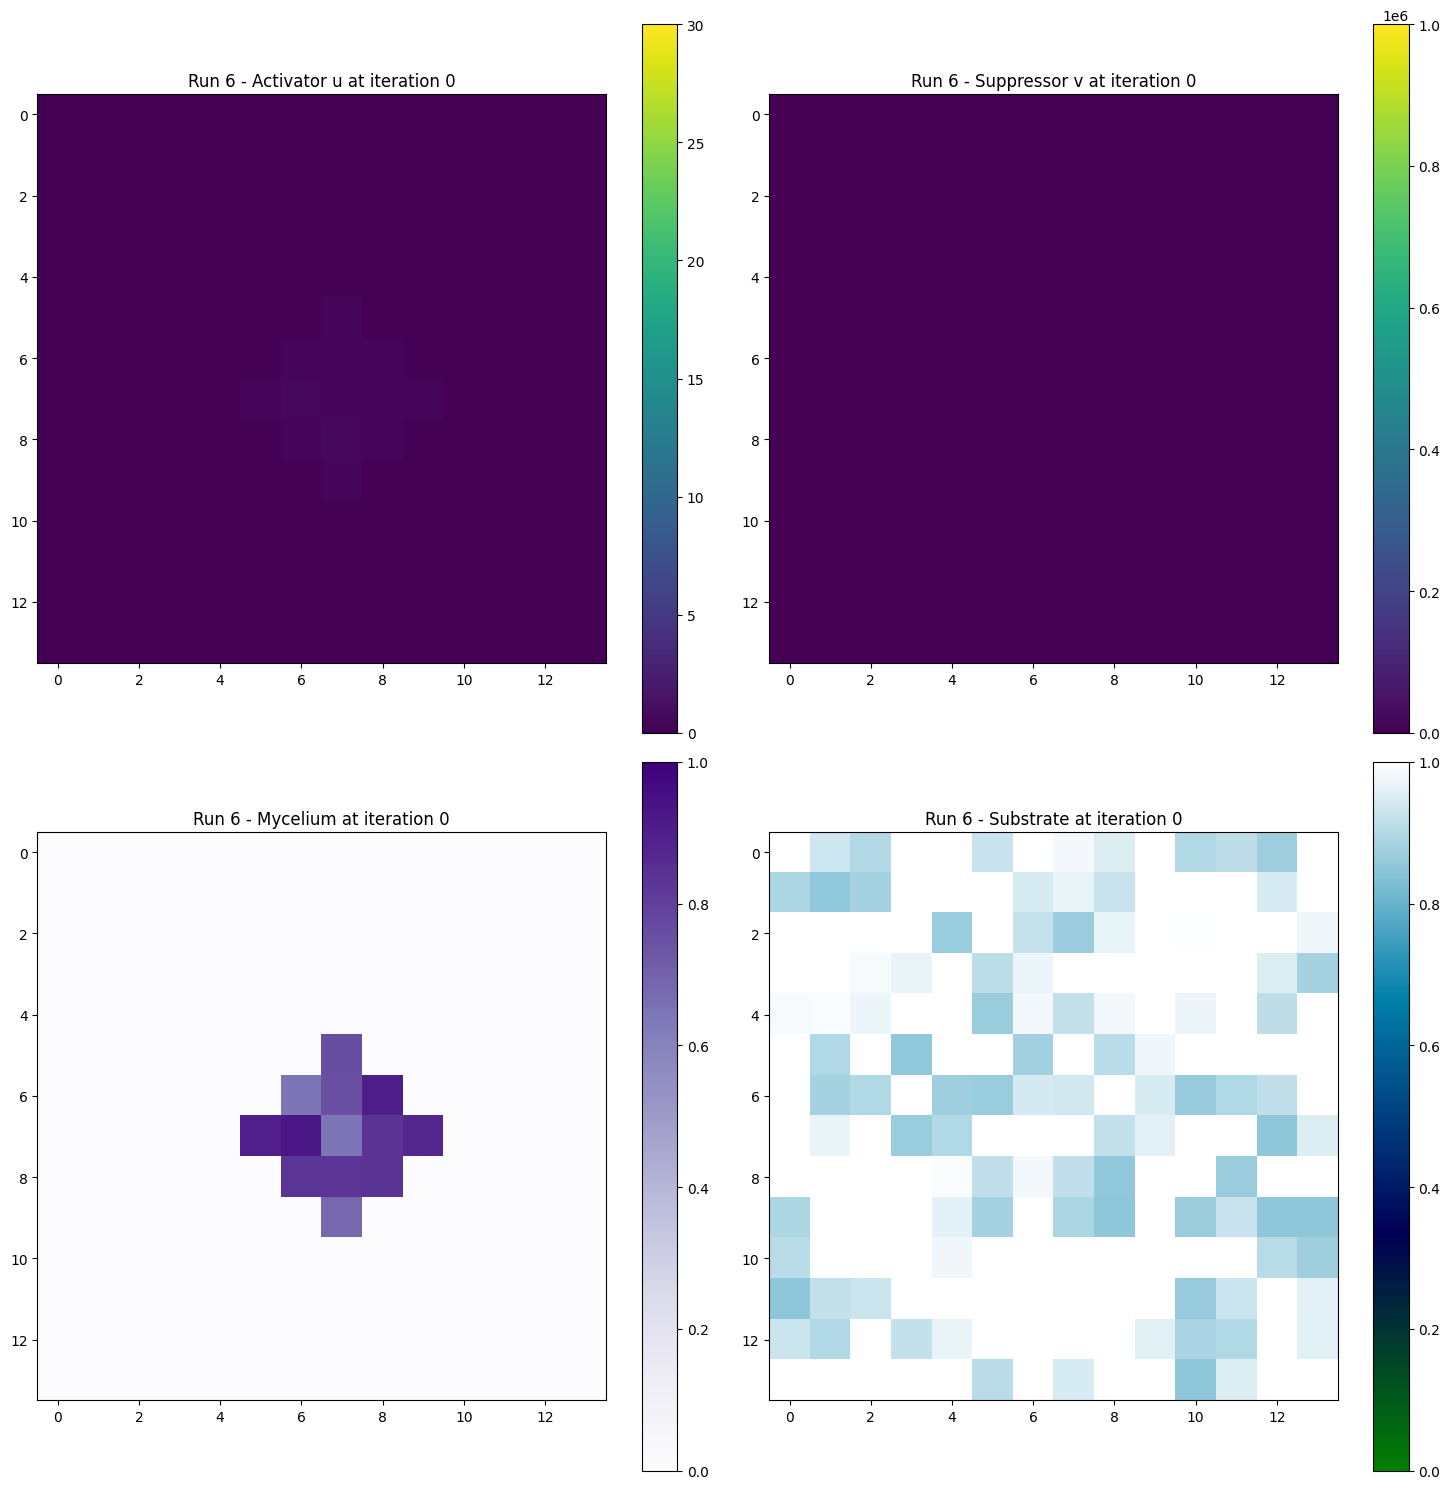

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_5_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_5_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_5_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_5_step_10000.csv using NumPy with double precision.


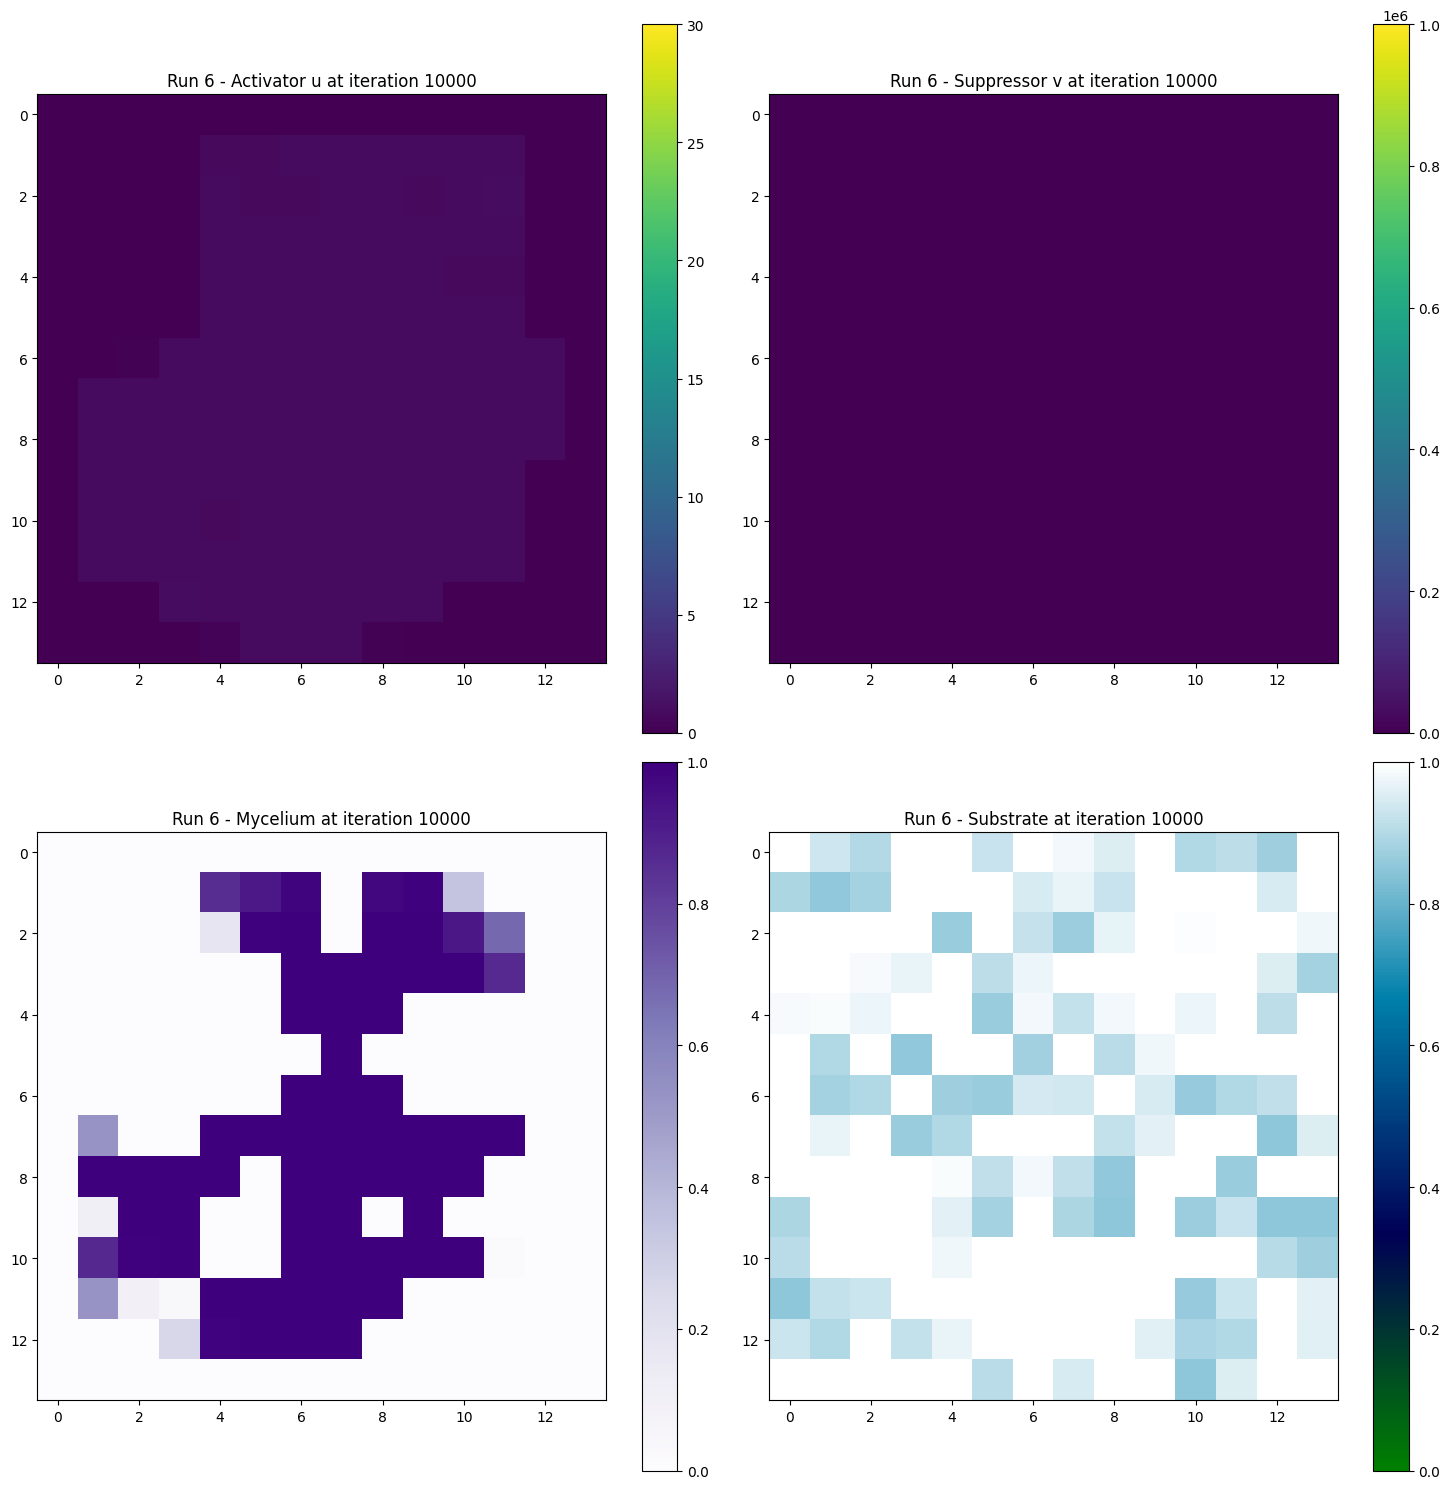

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_6_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_6_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_6_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_6_step_0.csv using NumPy with double precision.


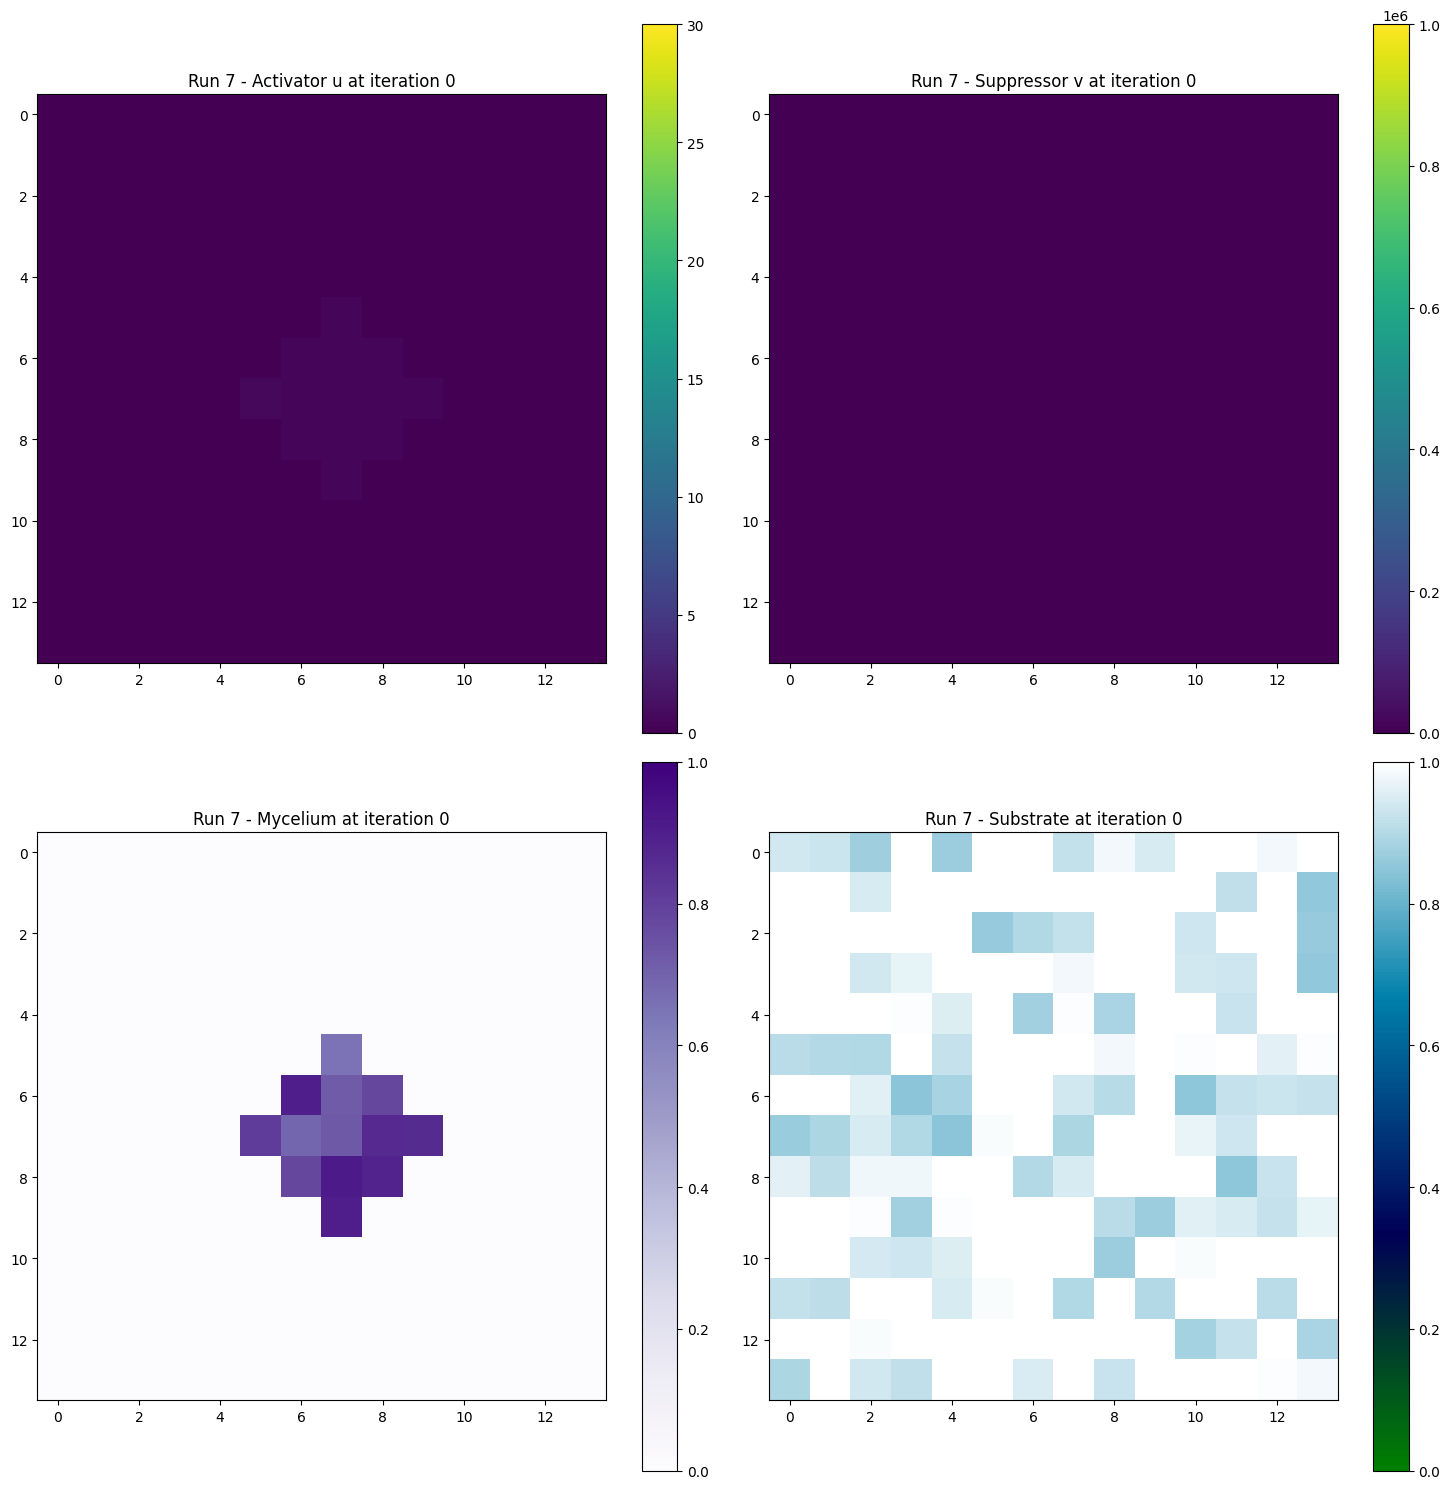

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_6_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_6_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_6_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_6_step_10000.csv using NumPy with double precision.


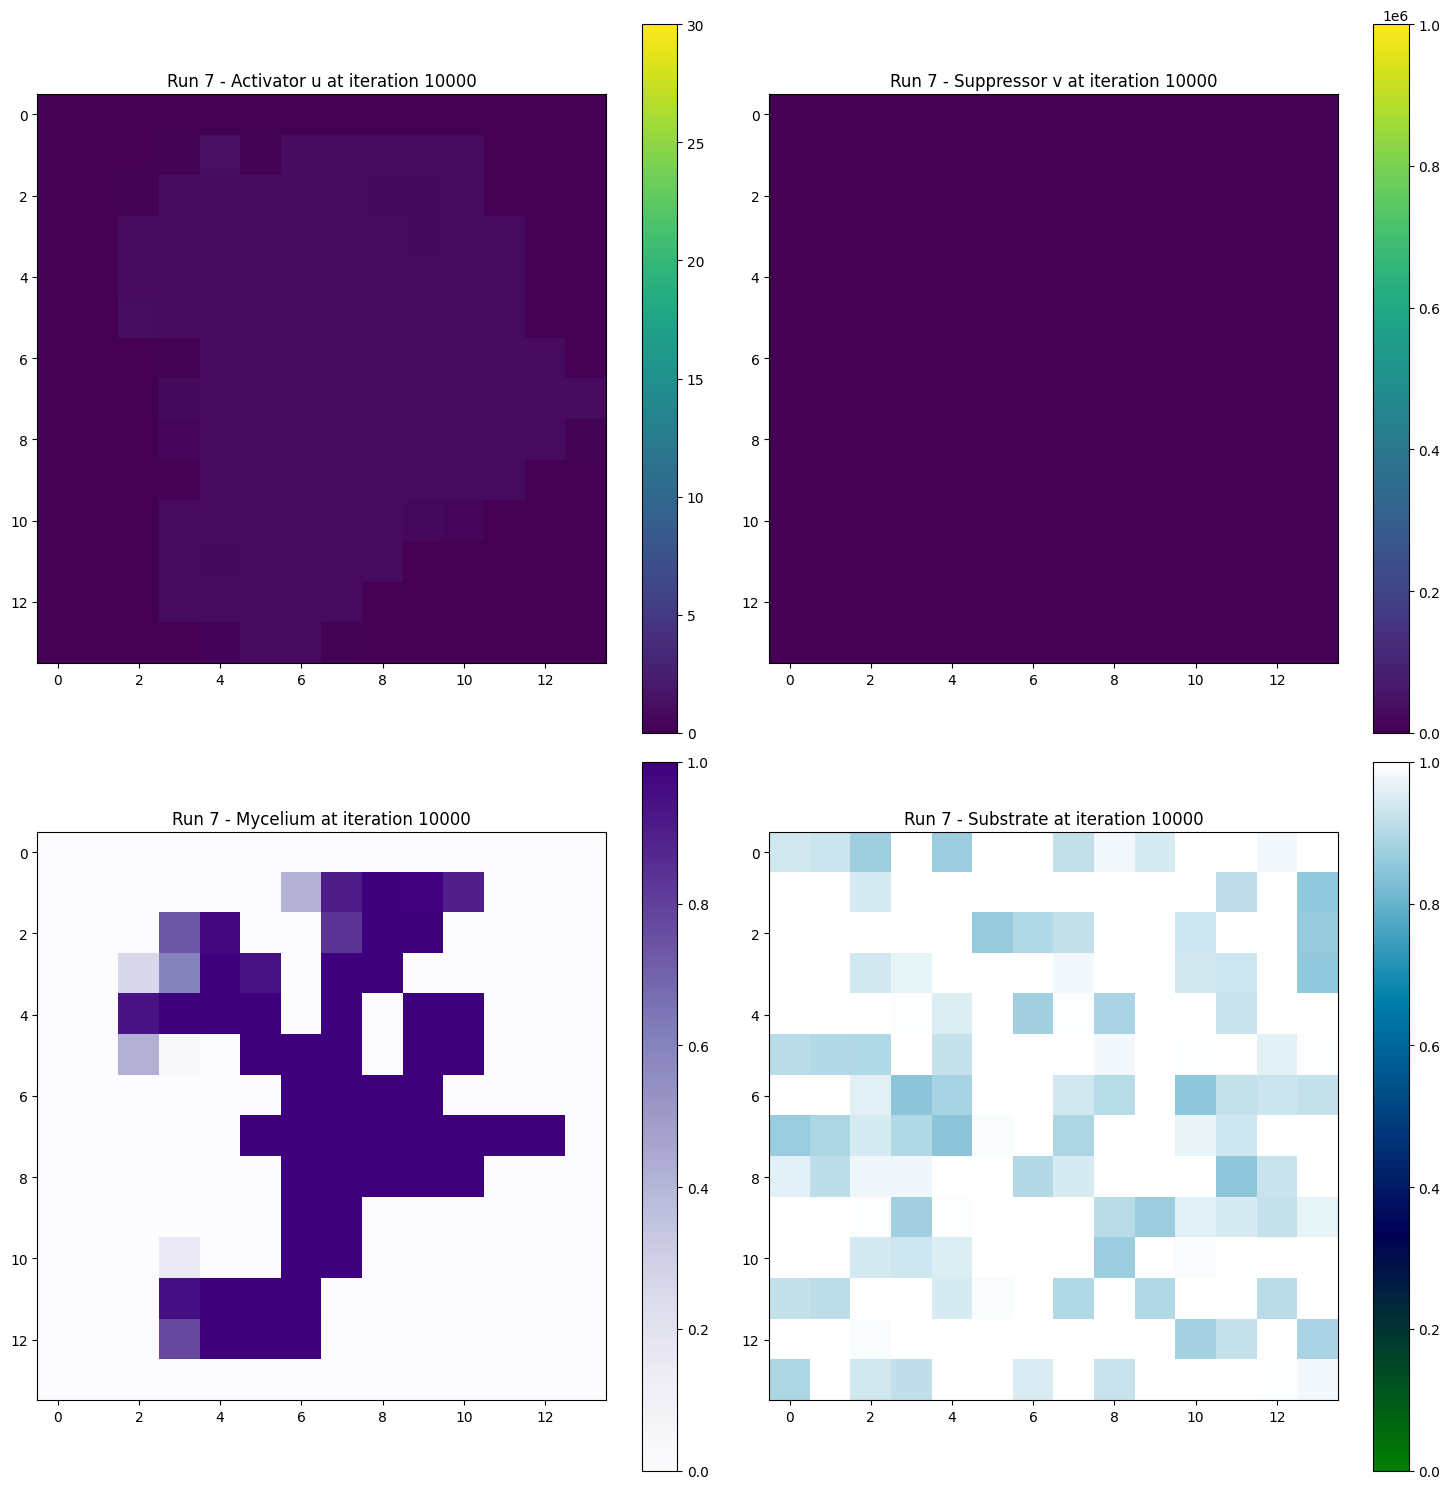

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_7_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_7_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_7_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_7_step_0.csv using NumPy with double precision.


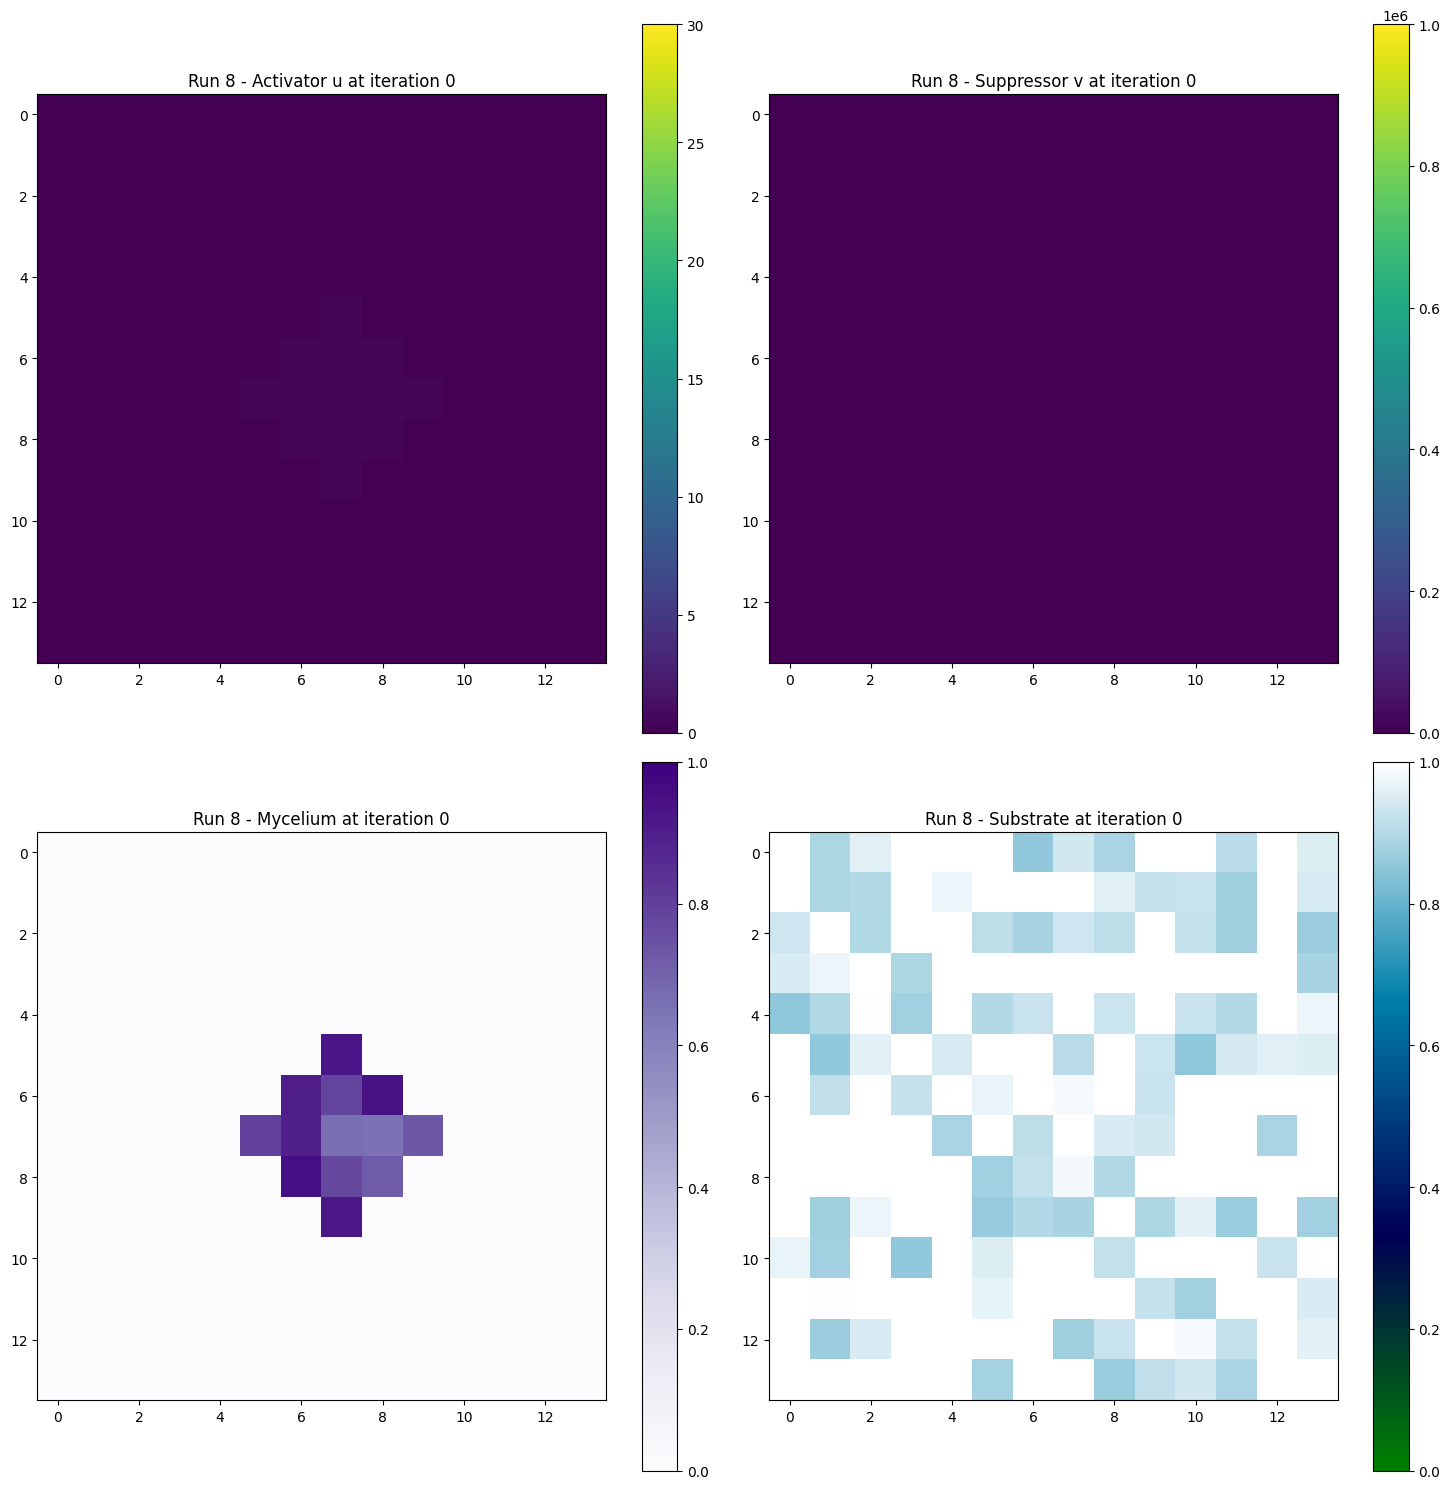

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_7_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_7_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_7_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_7_step_10000.csv using NumPy with double precision.


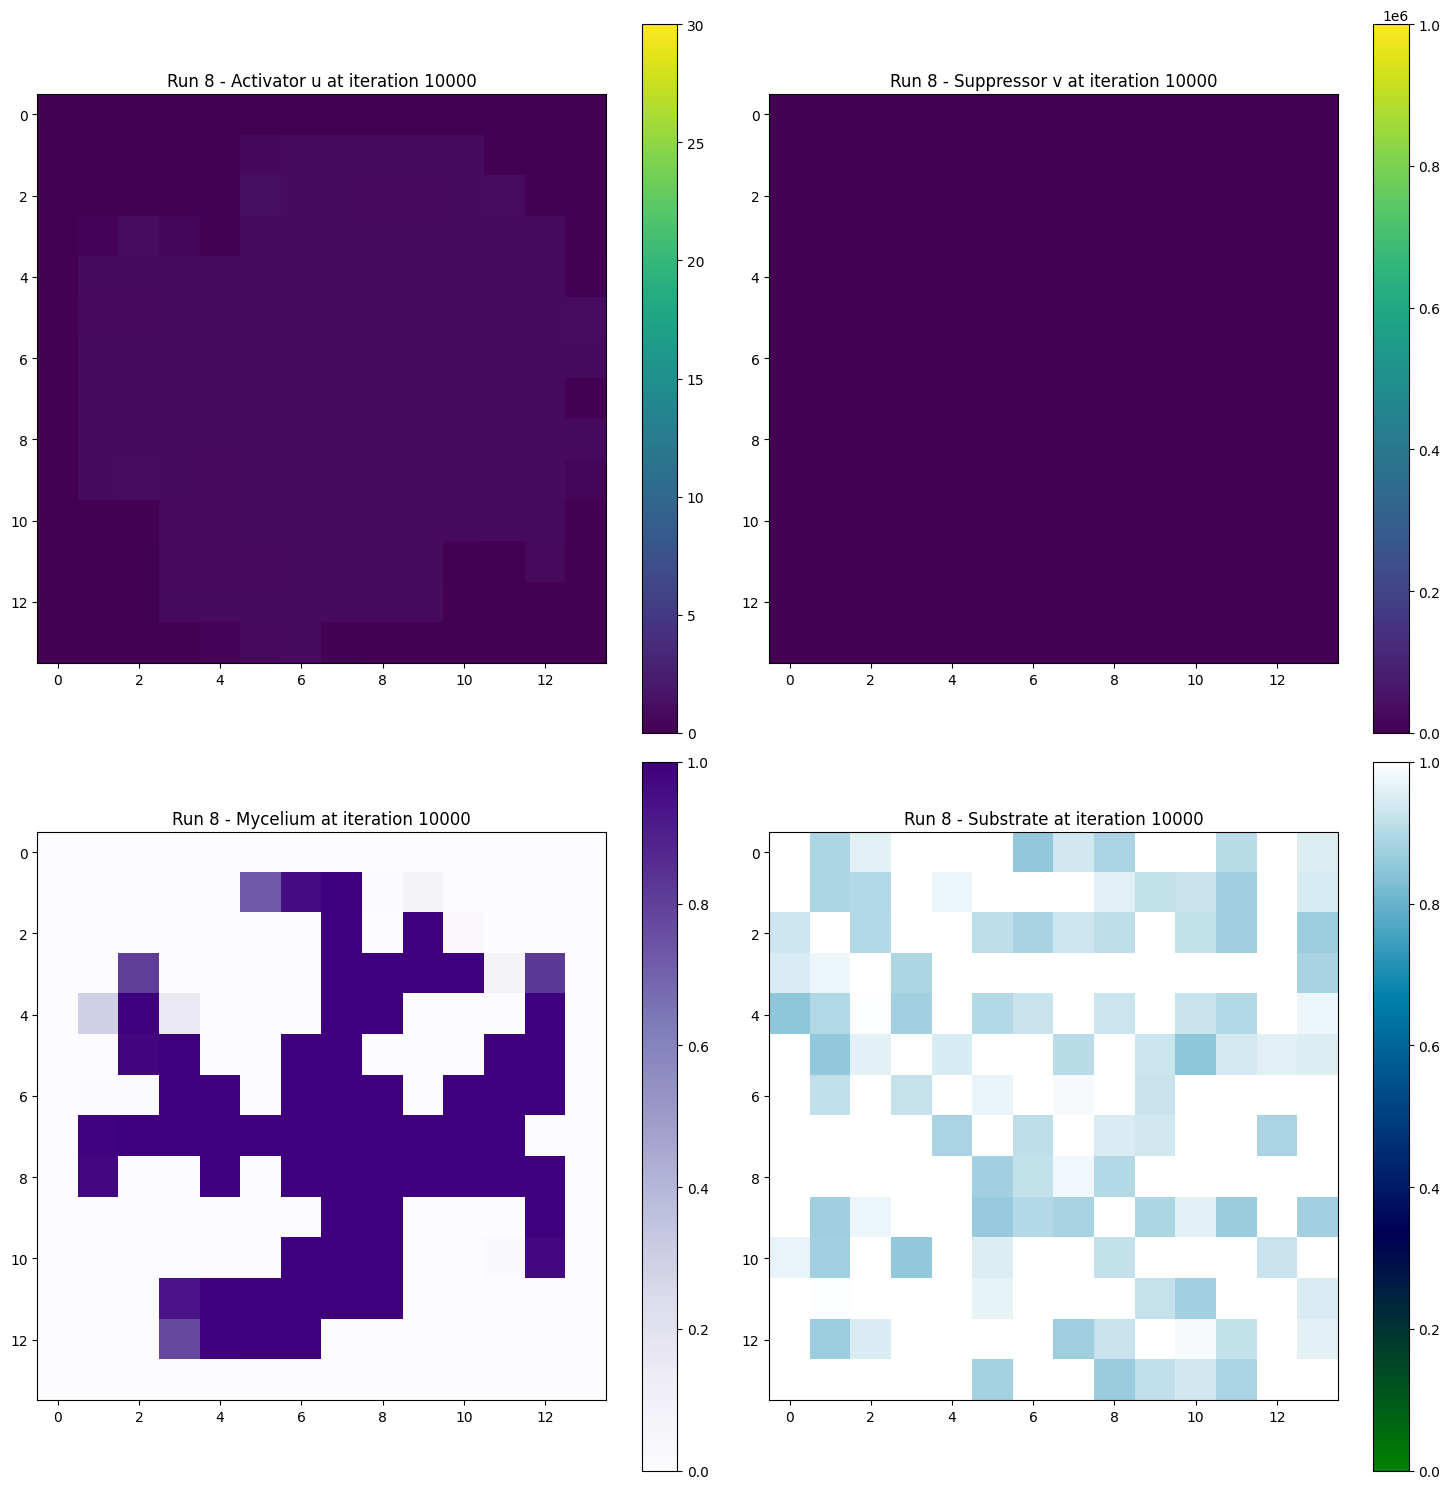

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_8_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_8_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_8_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_8_step_0.csv using NumPy with double precision.


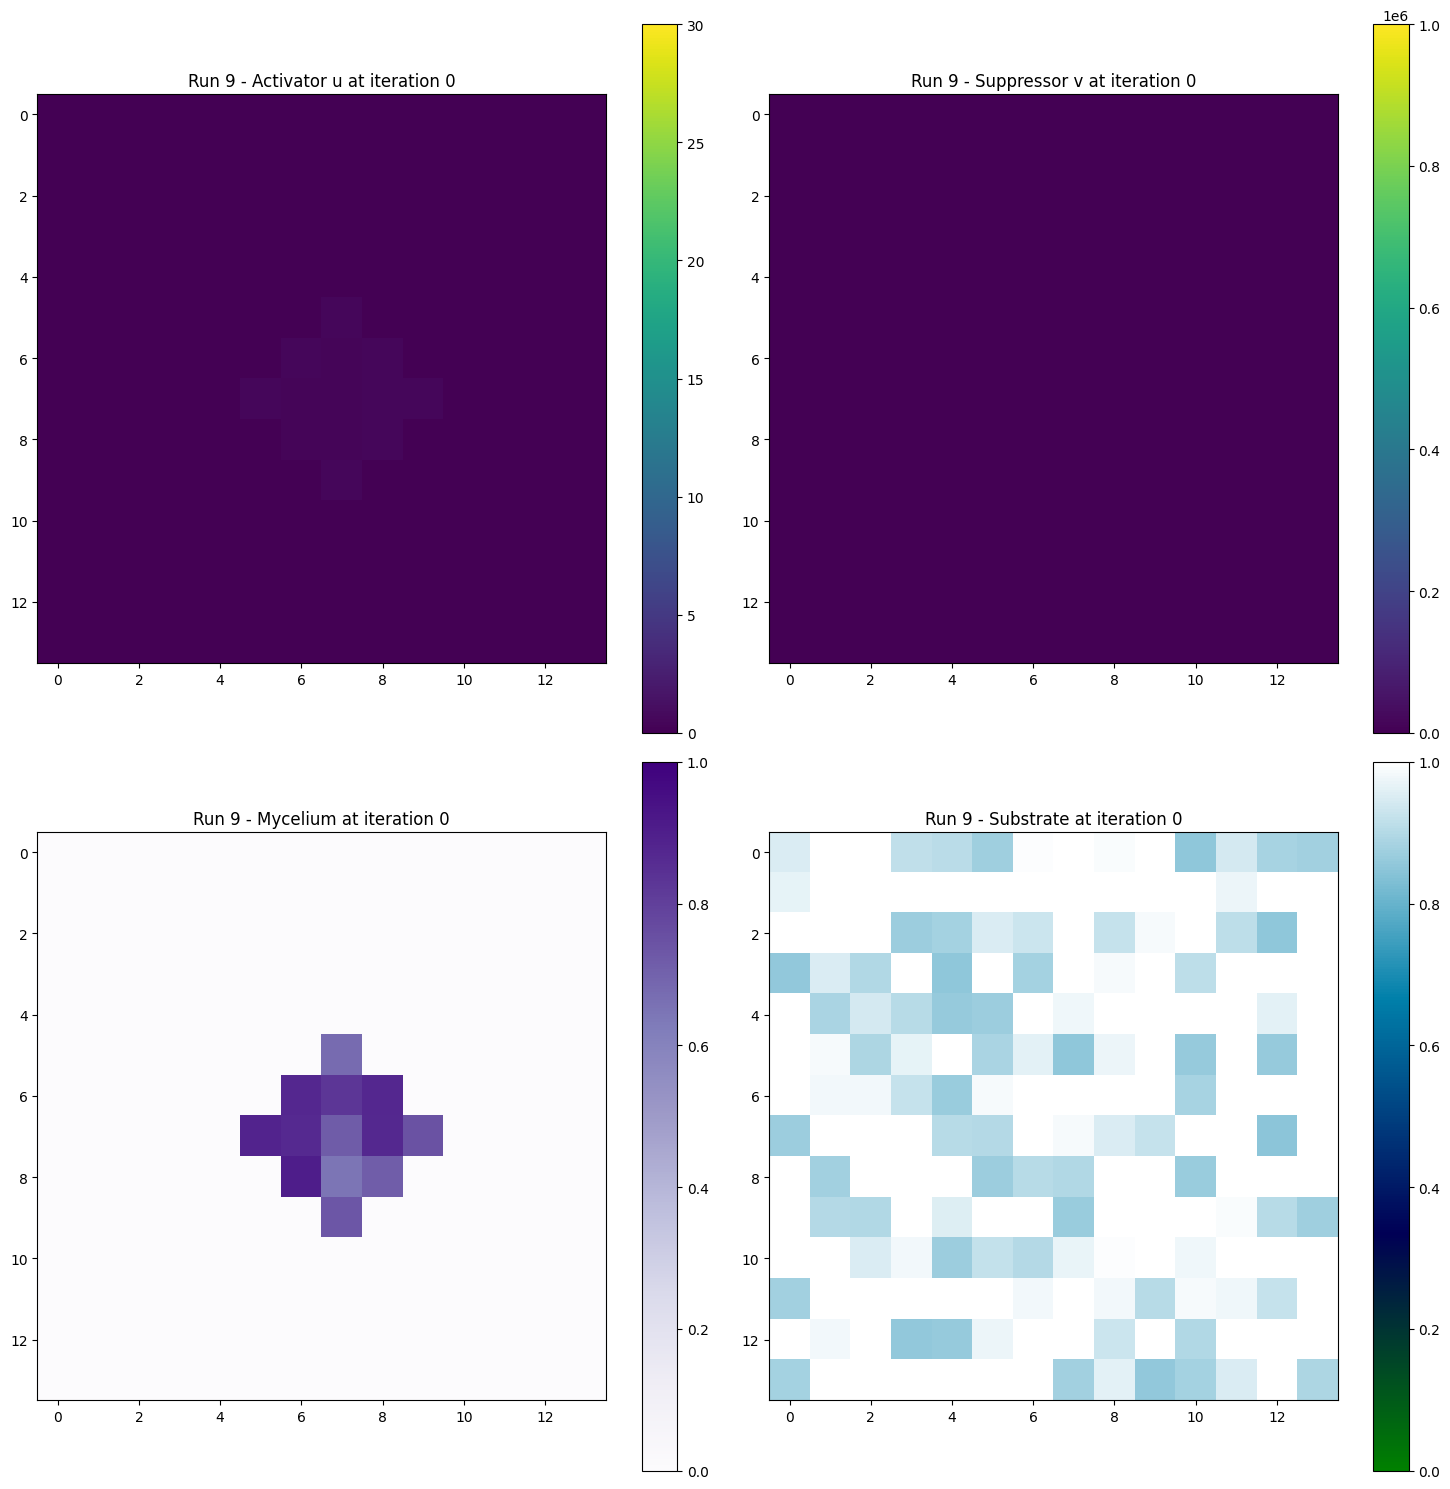

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_8_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_8_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_8_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_8_step_10000.csv using NumPy with double precision.


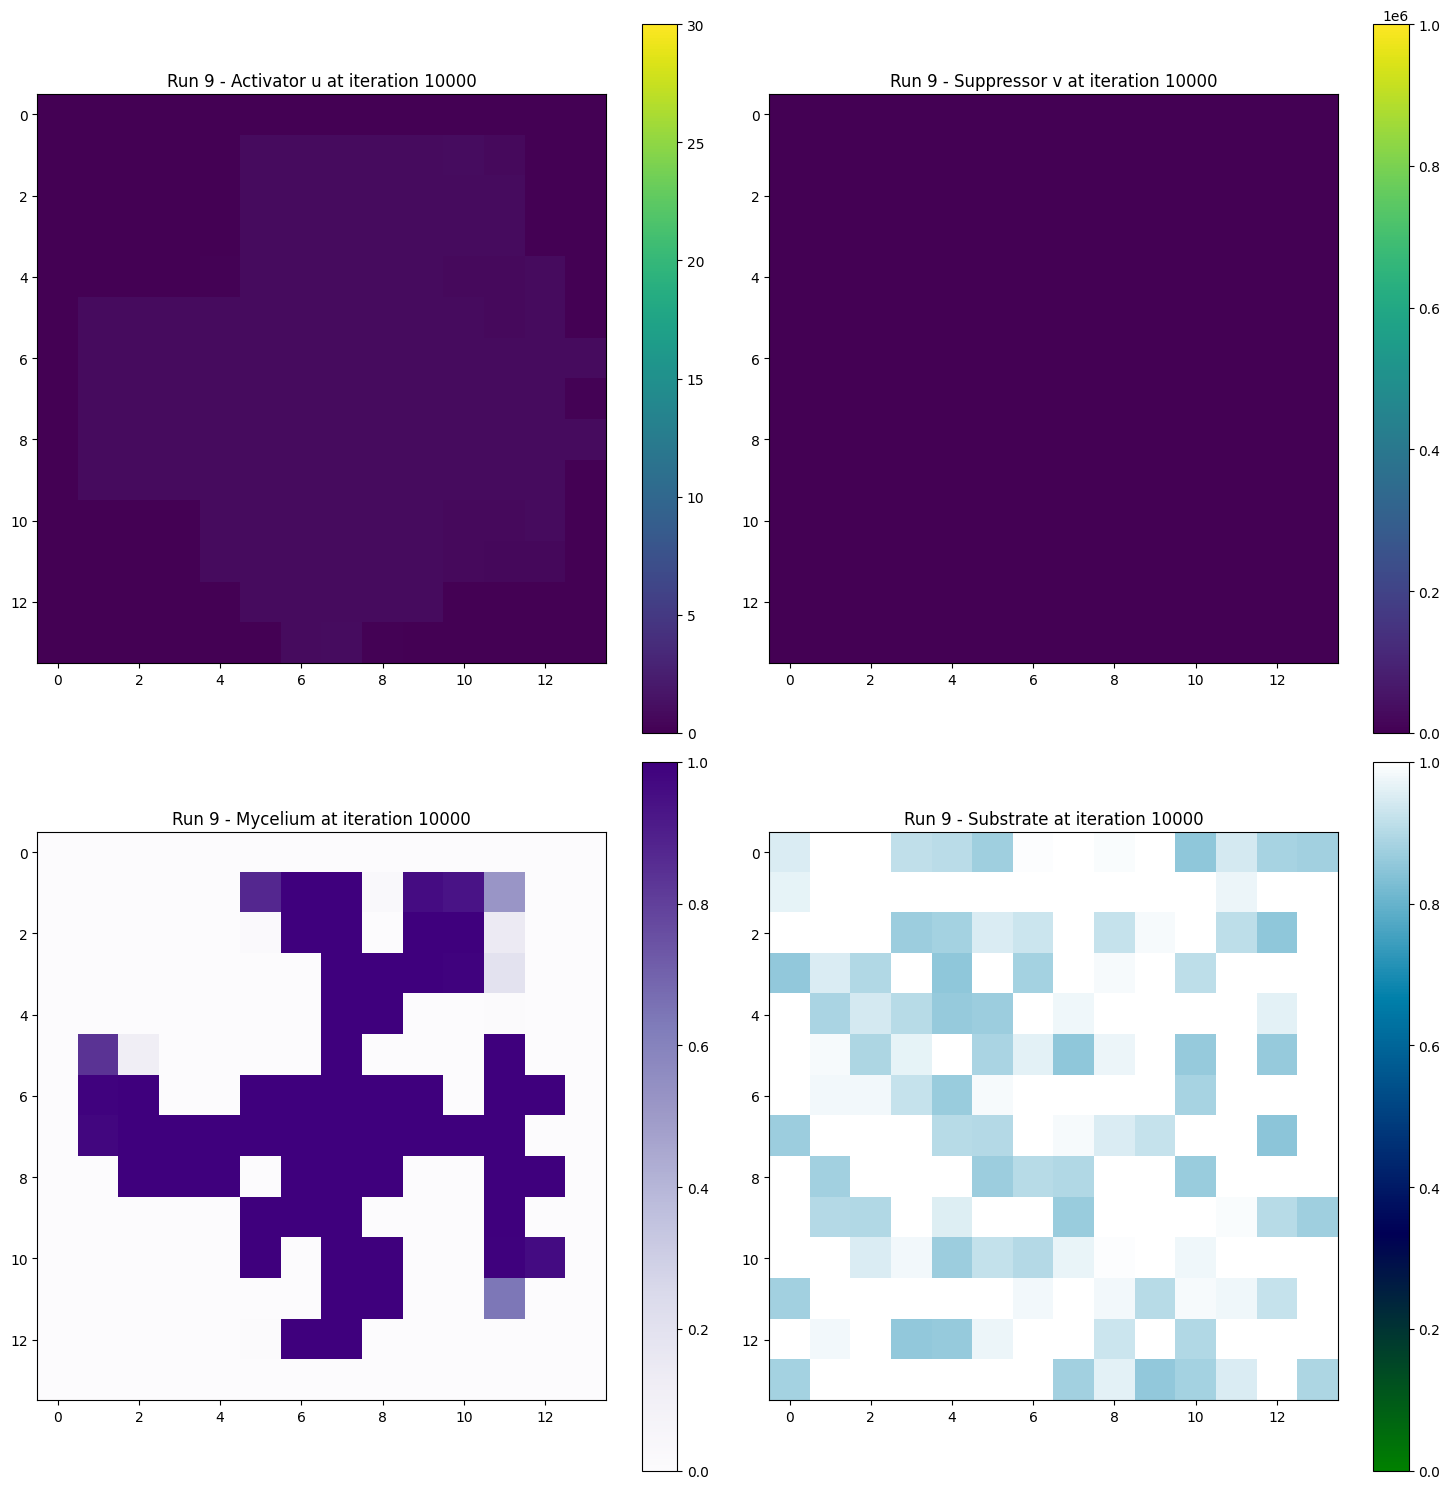

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_9_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_9_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_9_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_9_step_0.csv using NumPy with double precision.


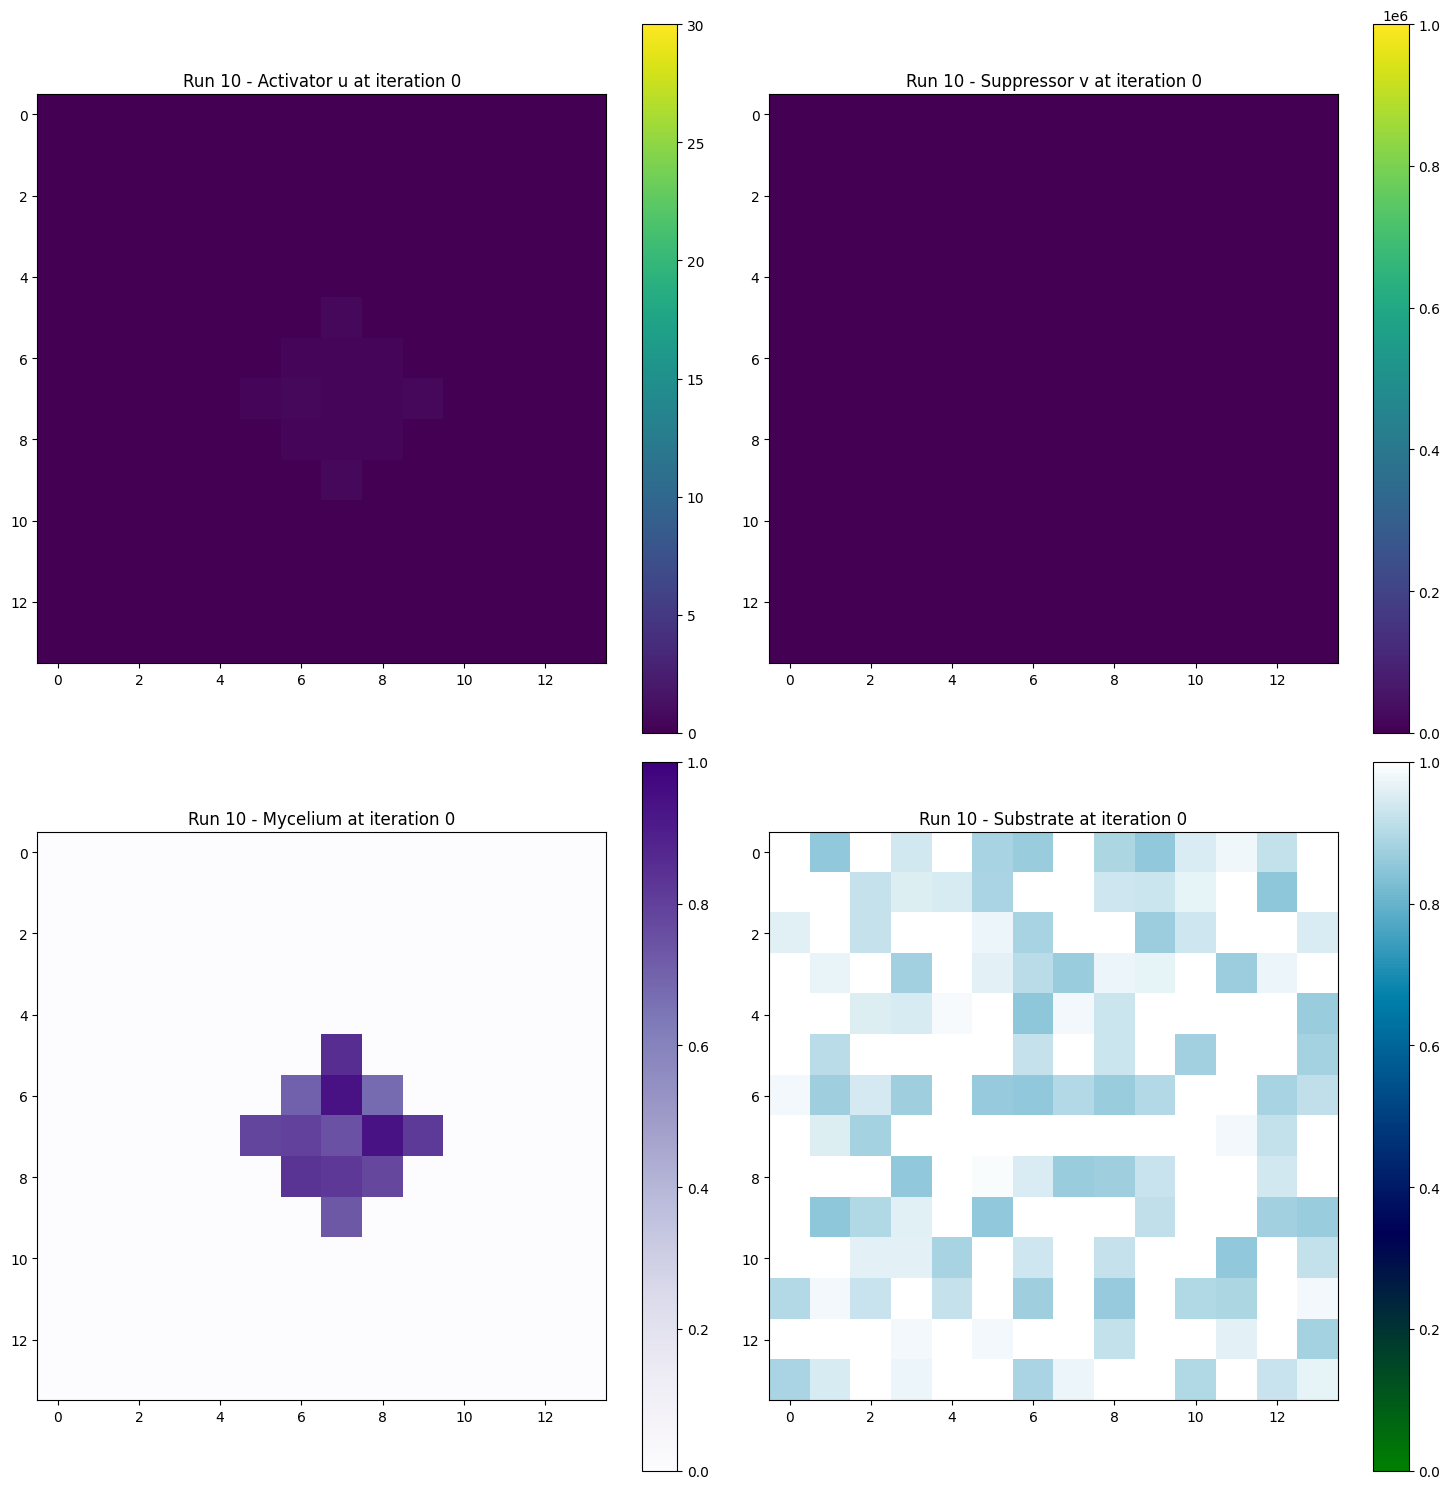

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_9_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_9_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_9_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_9_step_10000.csv using NumPy with double precision.


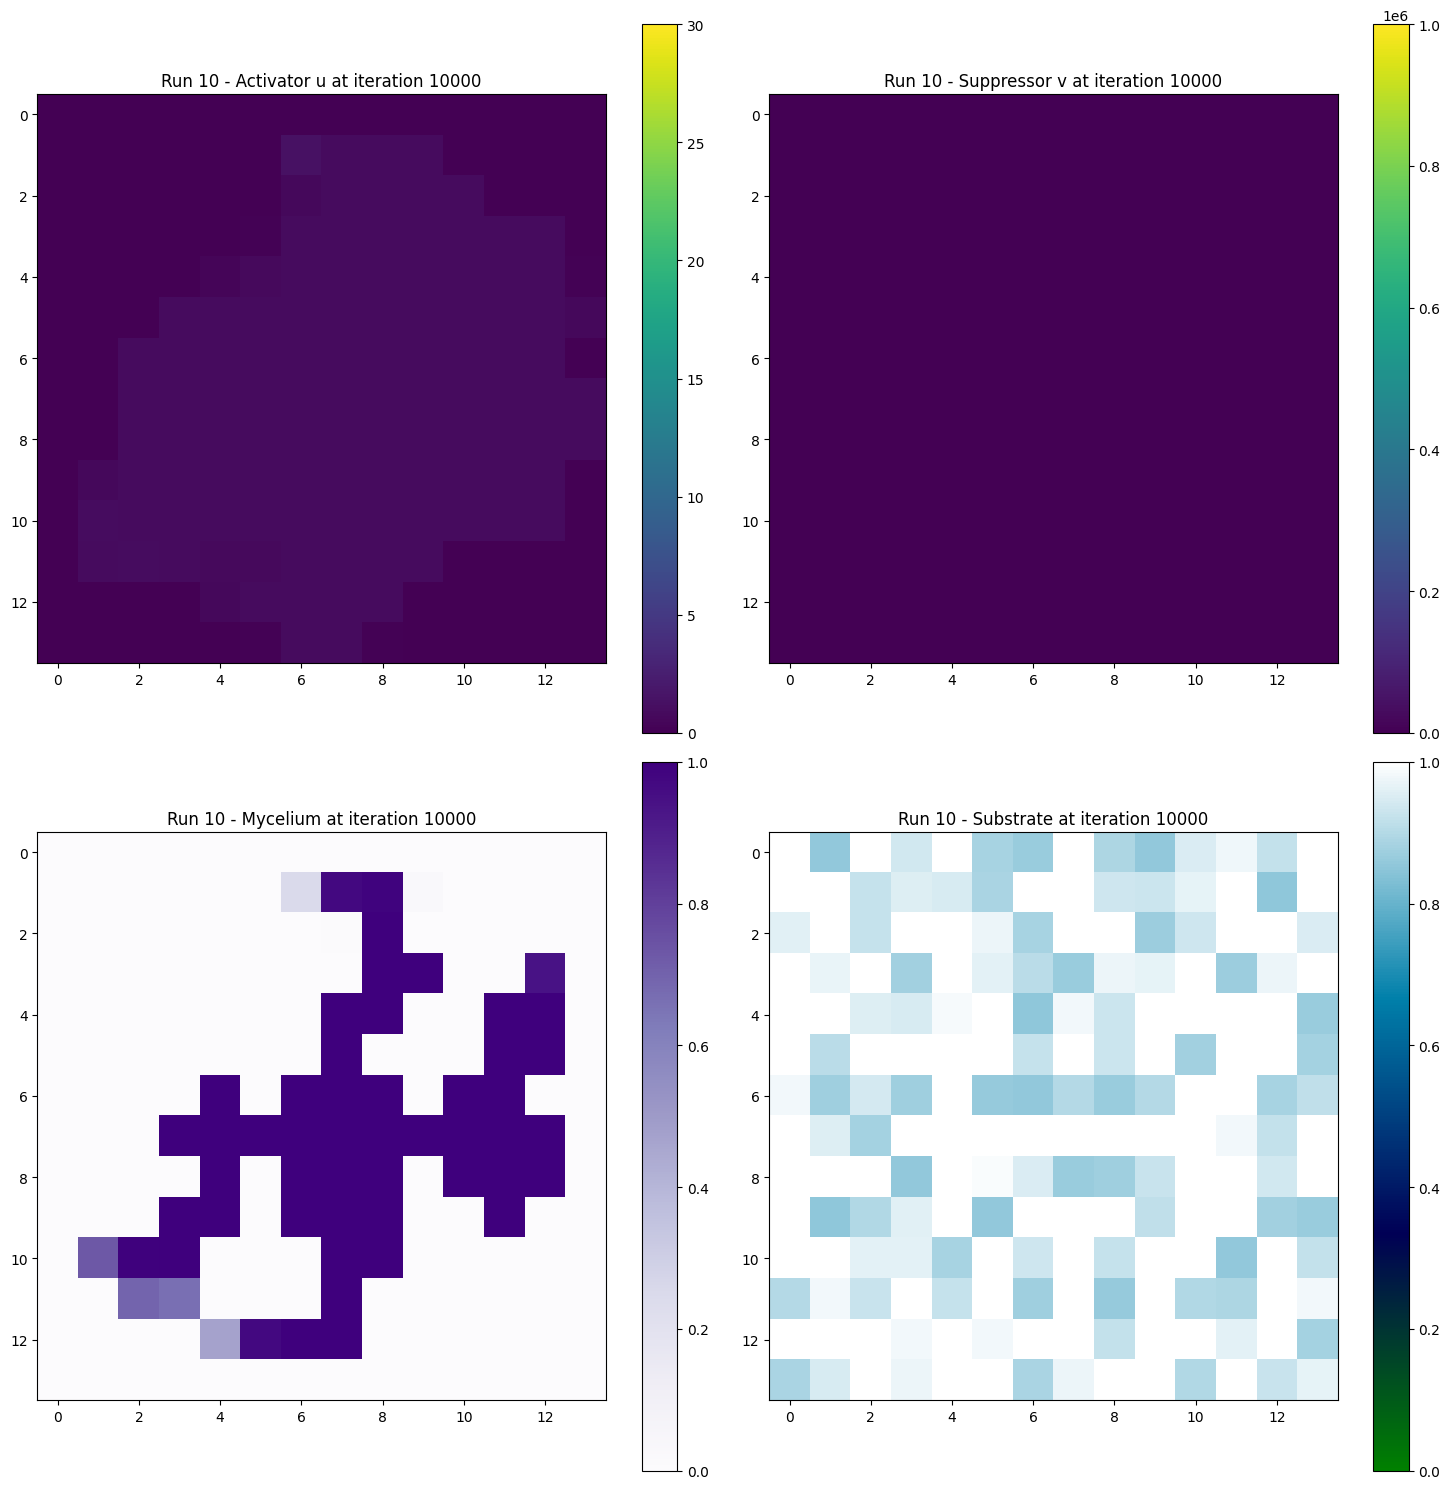

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_10_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_10_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_10_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_10_step_0.csv using NumPy with double precision.


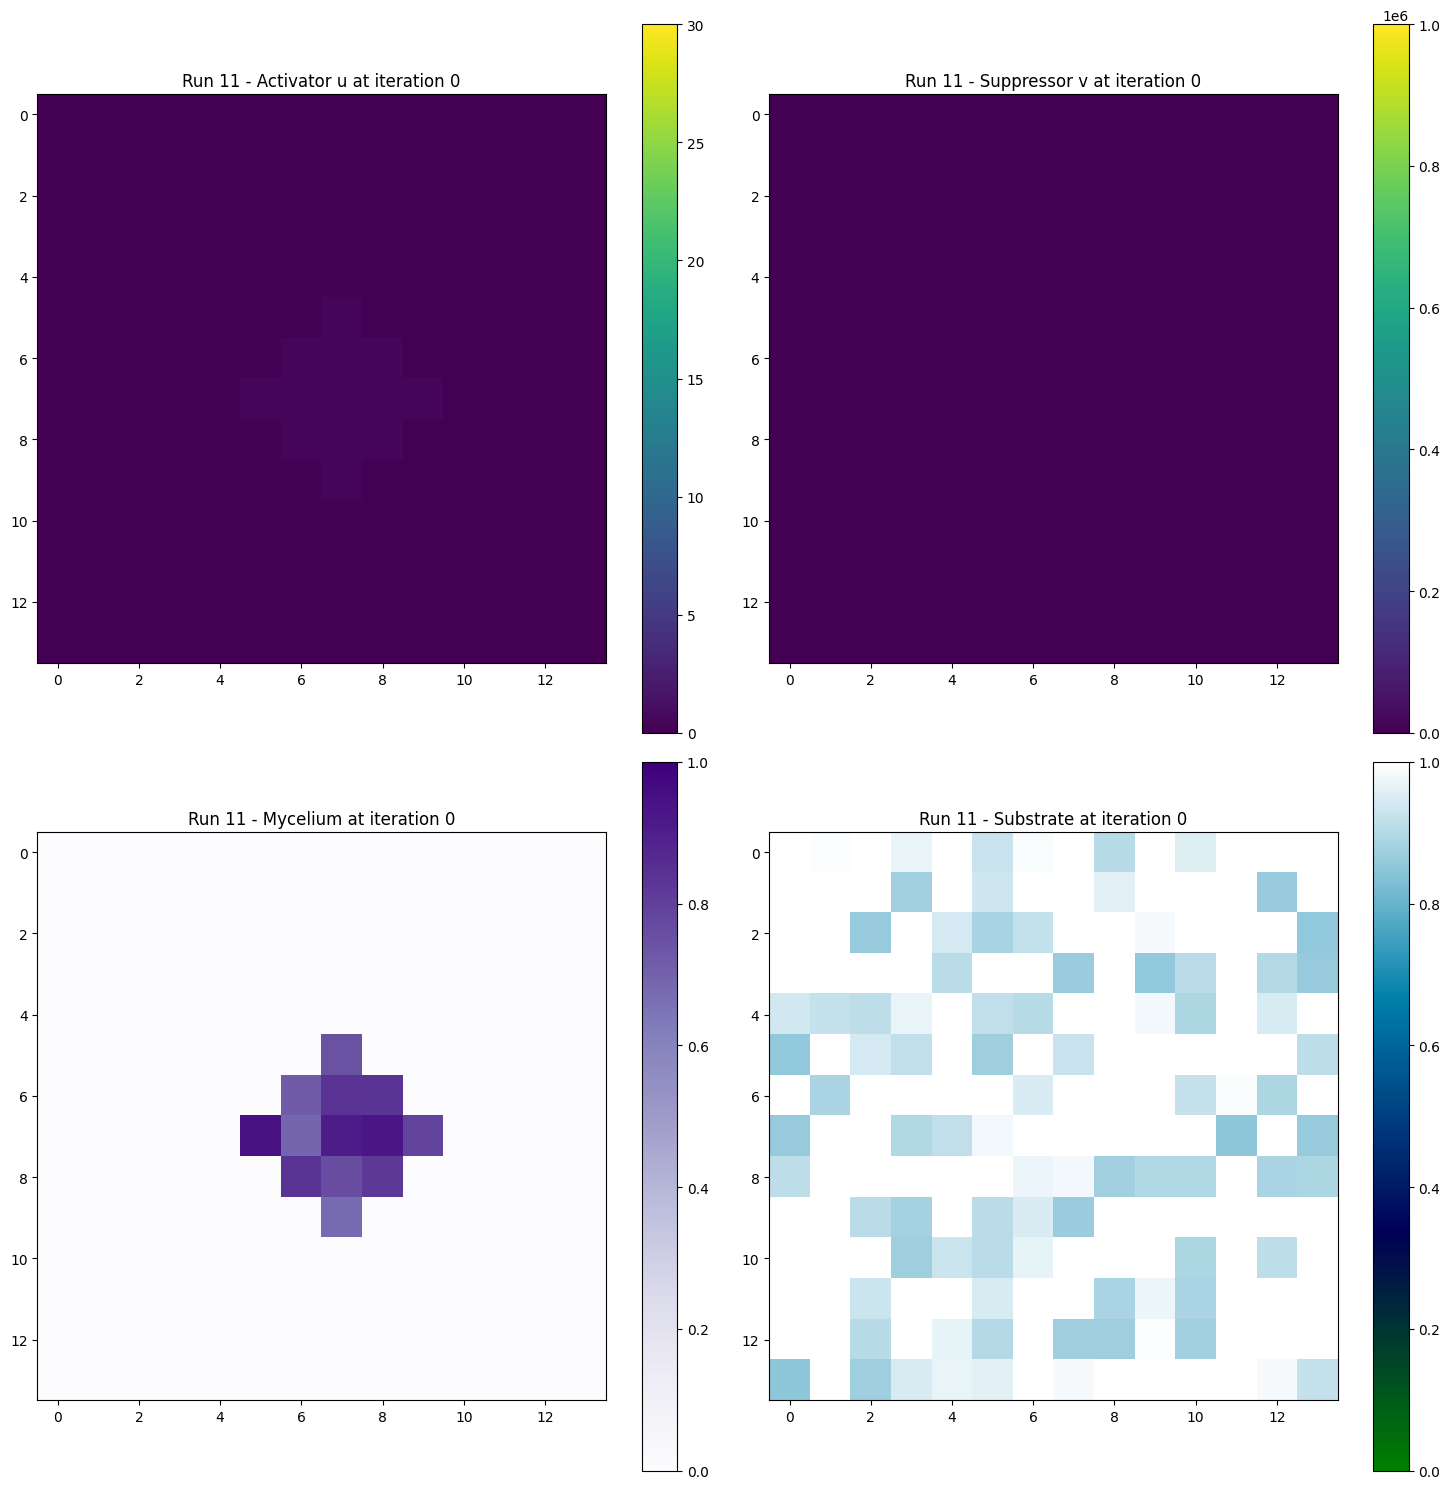

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_10_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_10_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_10_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_10_step_10000.csv using NumPy with double precision.


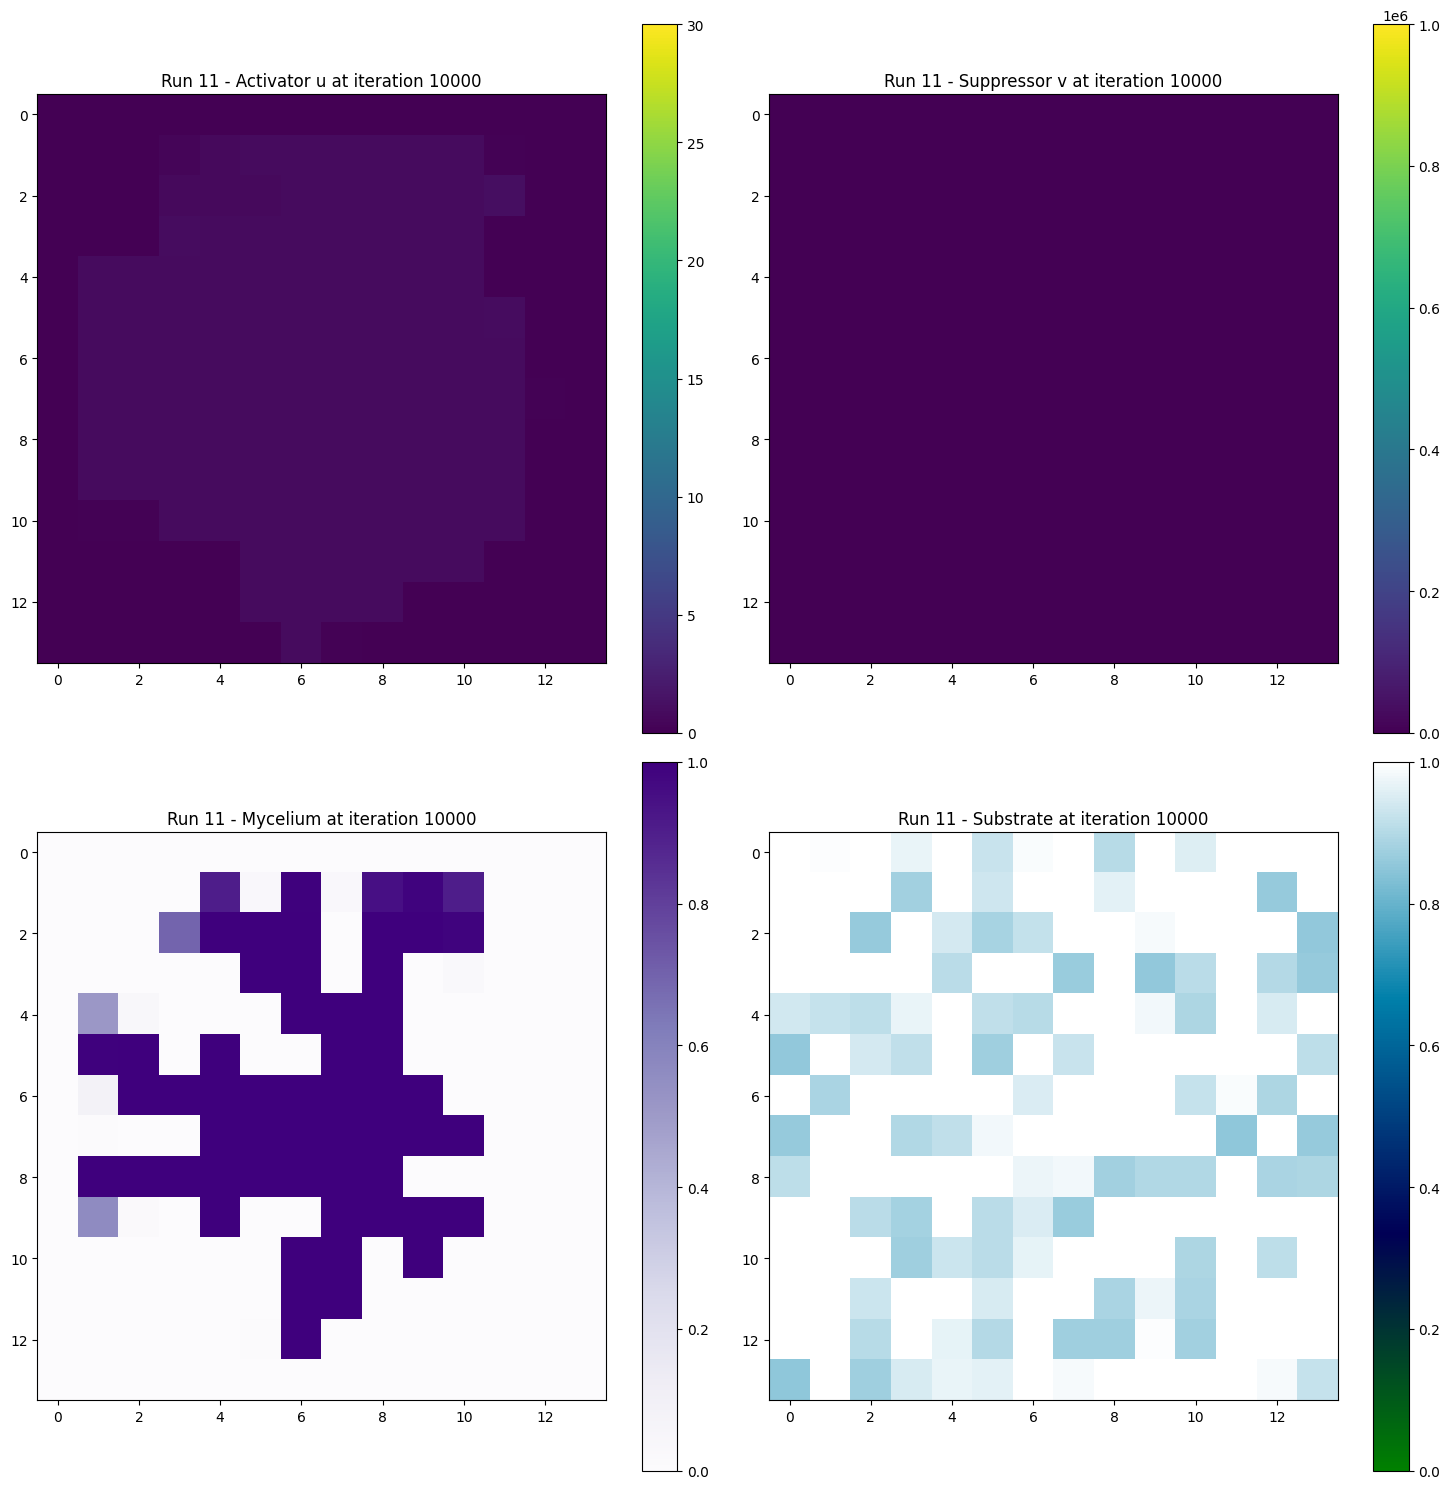

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_11_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_11_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_11_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_11_step_0.csv using NumPy with double precision.


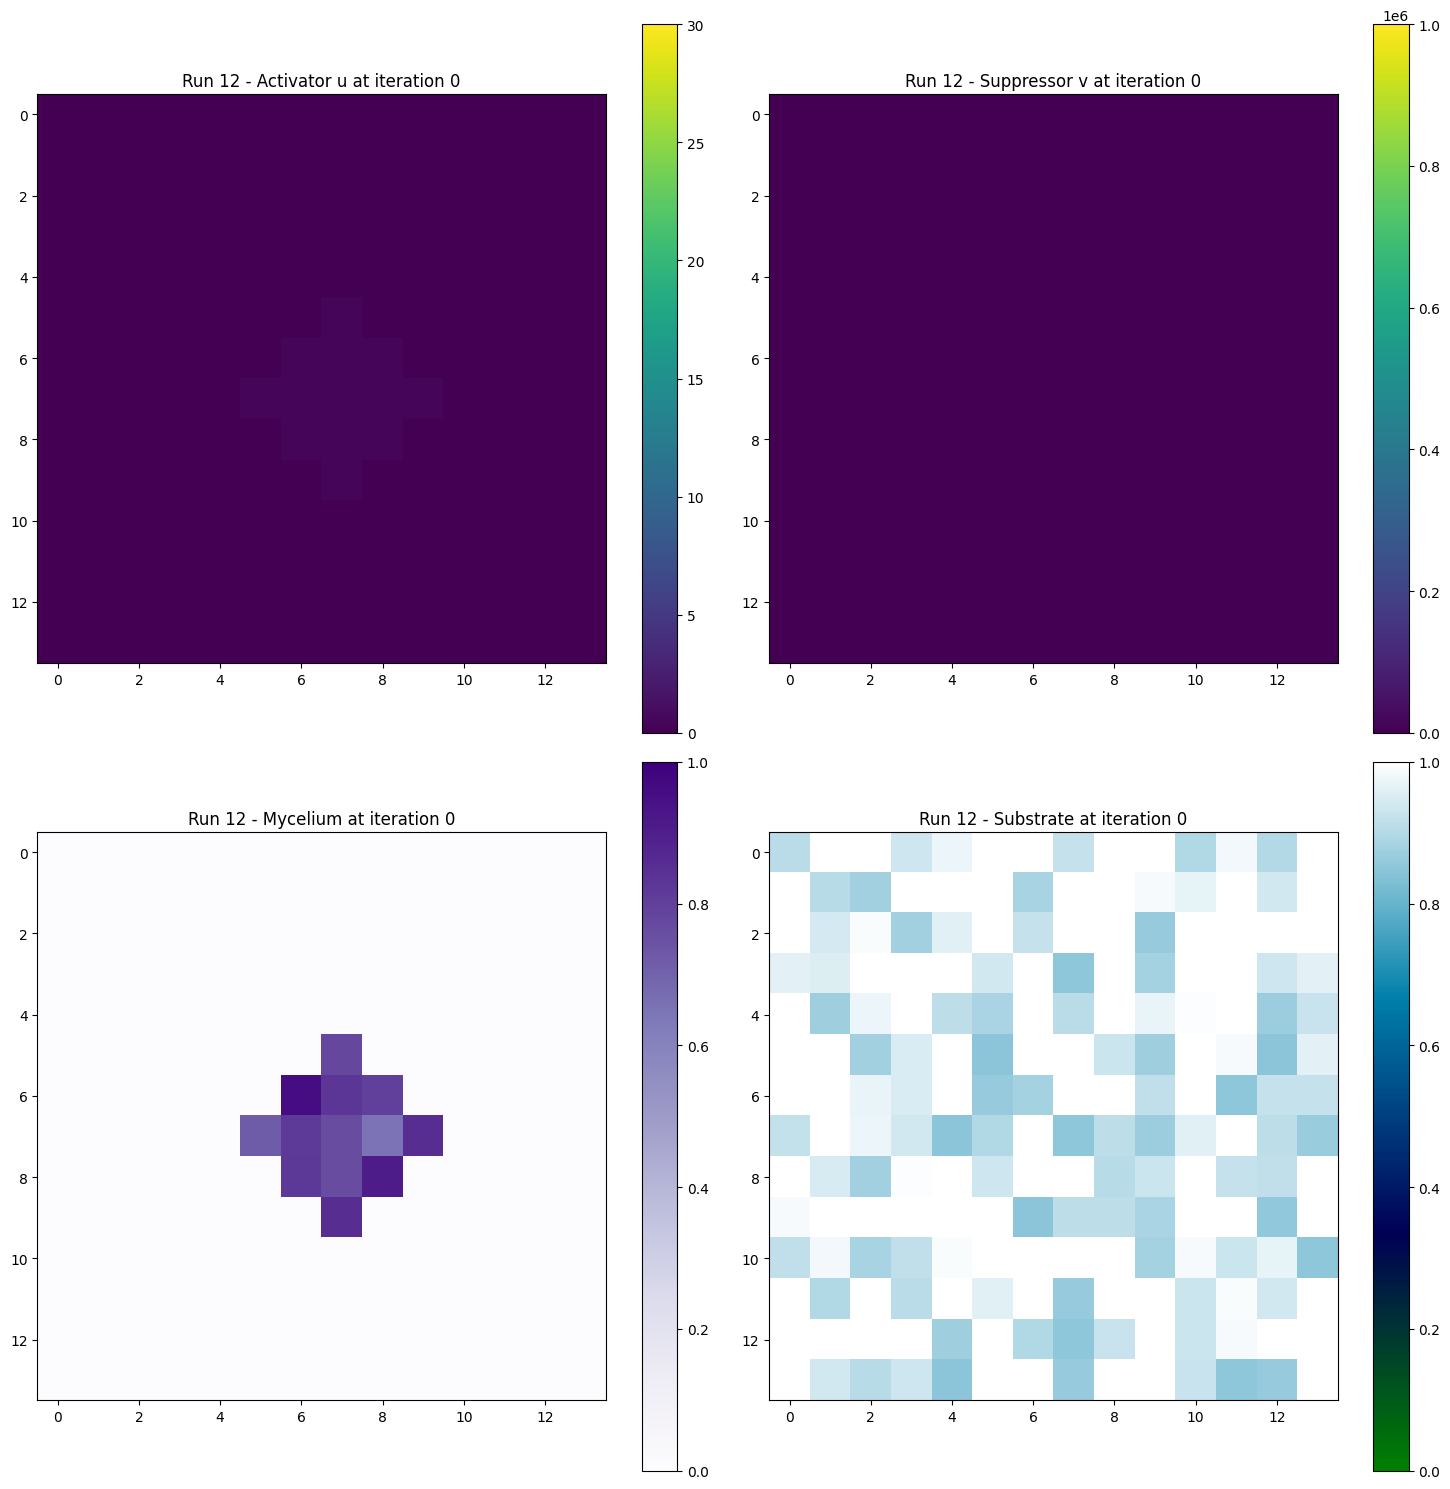

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_11_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_11_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_11_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_11_step_10000.csv using NumPy with double precision.


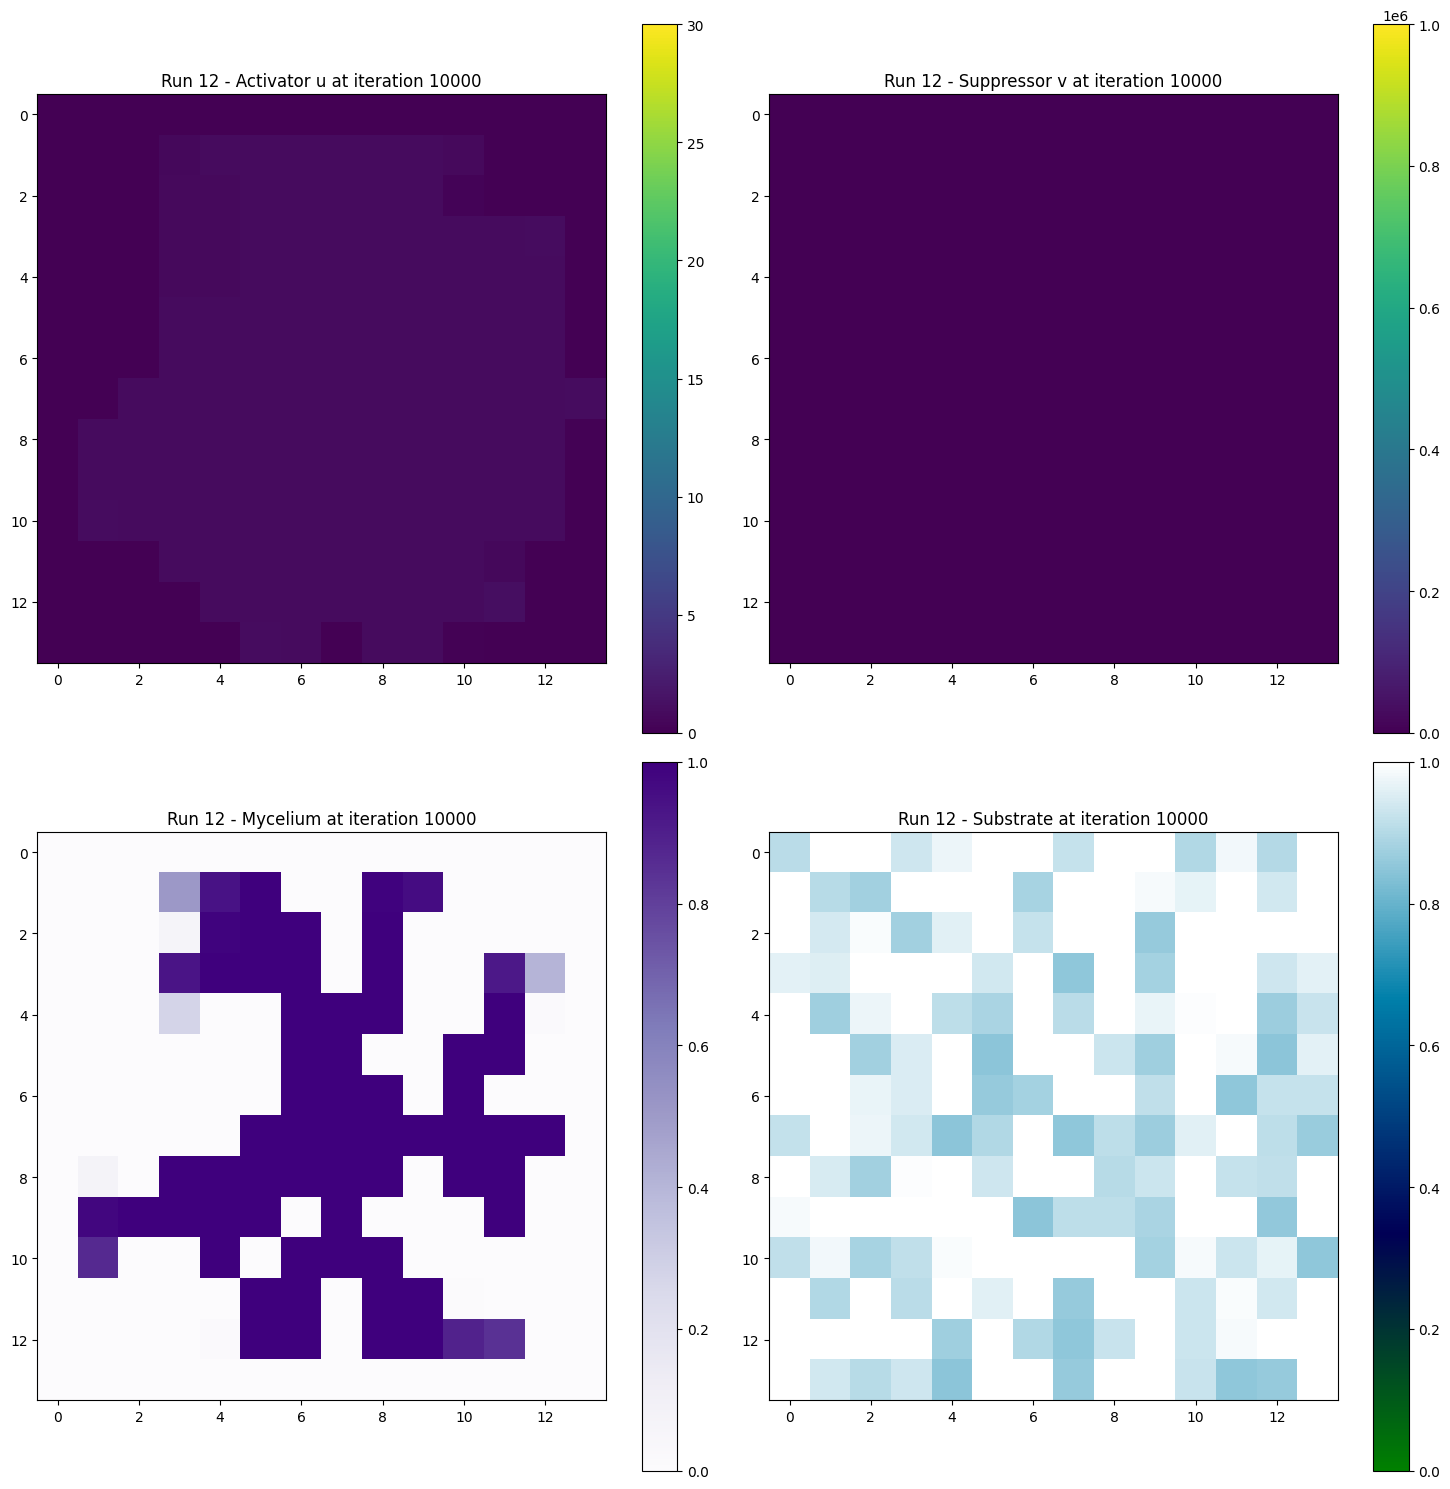

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_12_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_12_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_12_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_12_step_0.csv using NumPy with double precision.


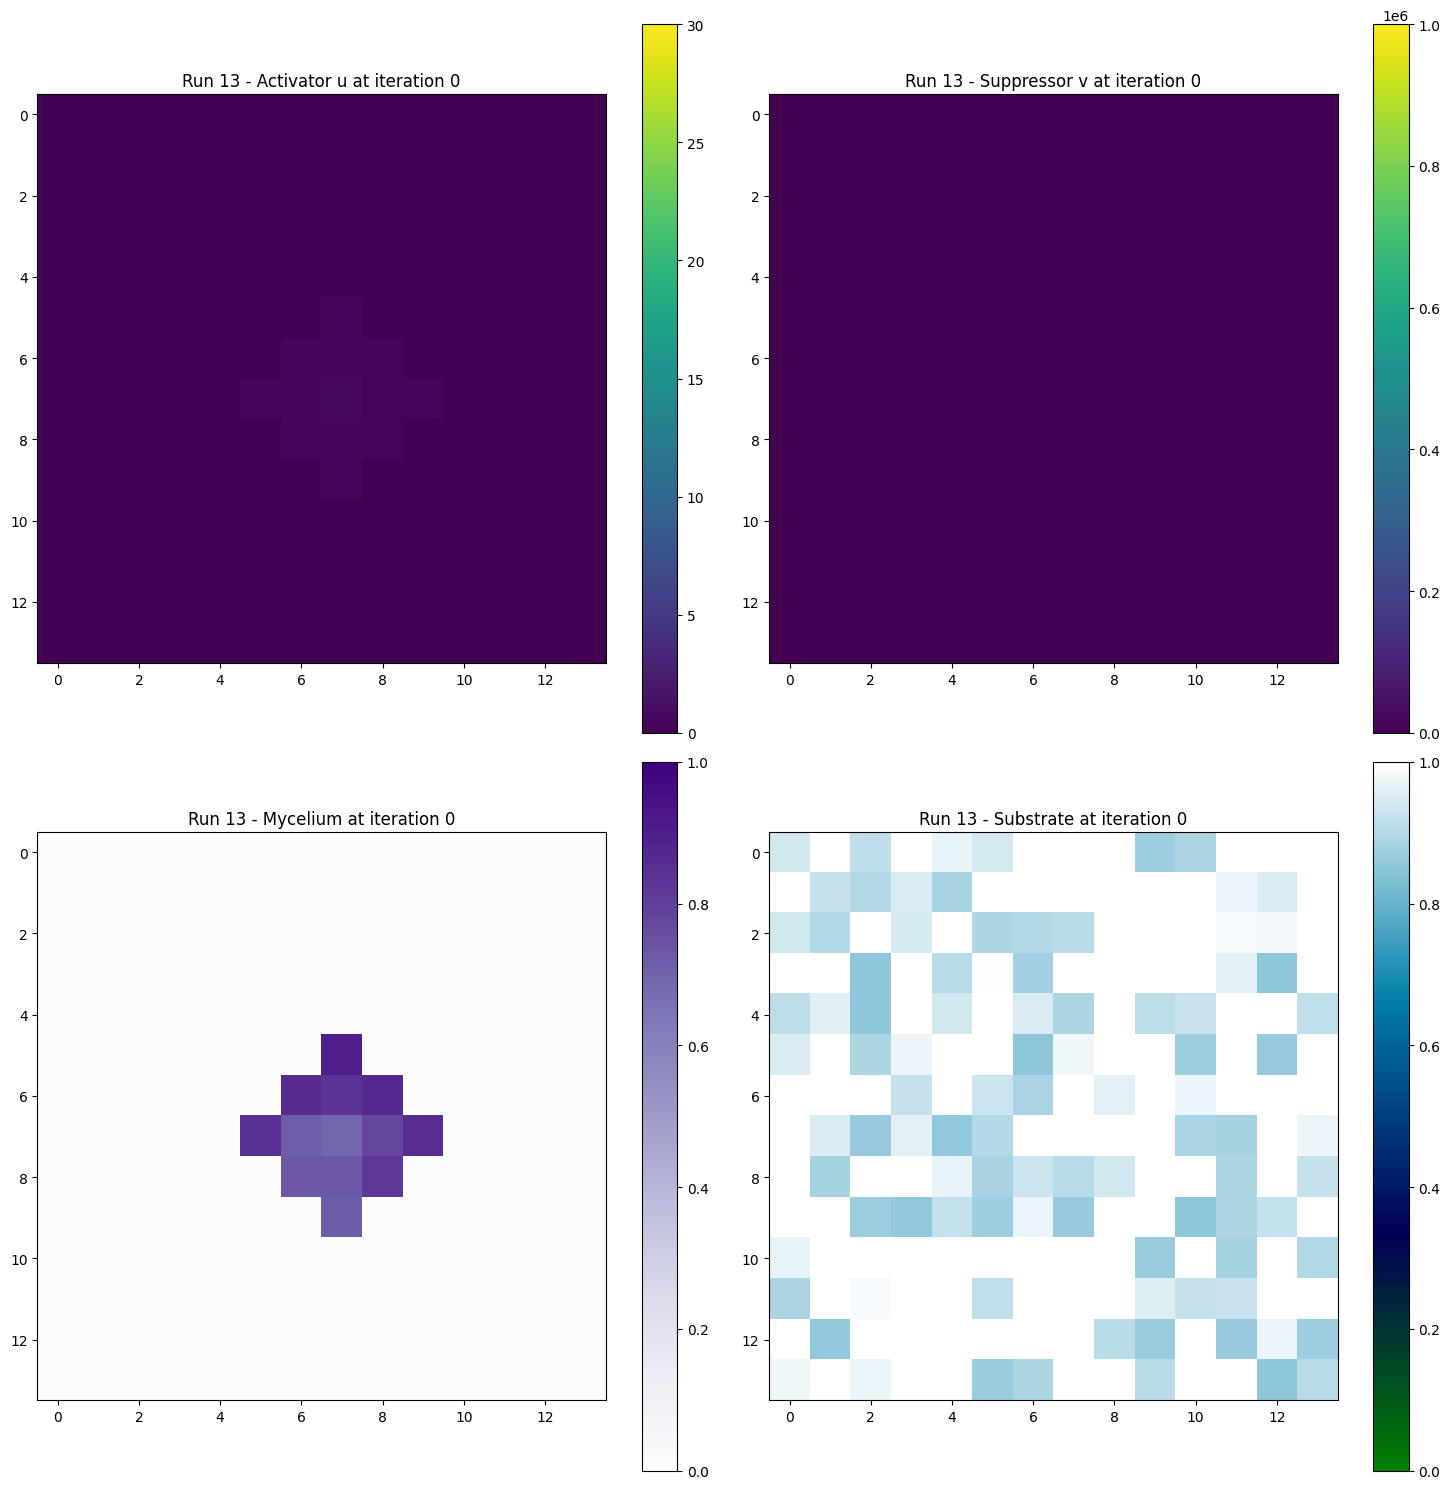

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_12_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_12_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_12_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_12_step_10000.csv using NumPy with double precision.


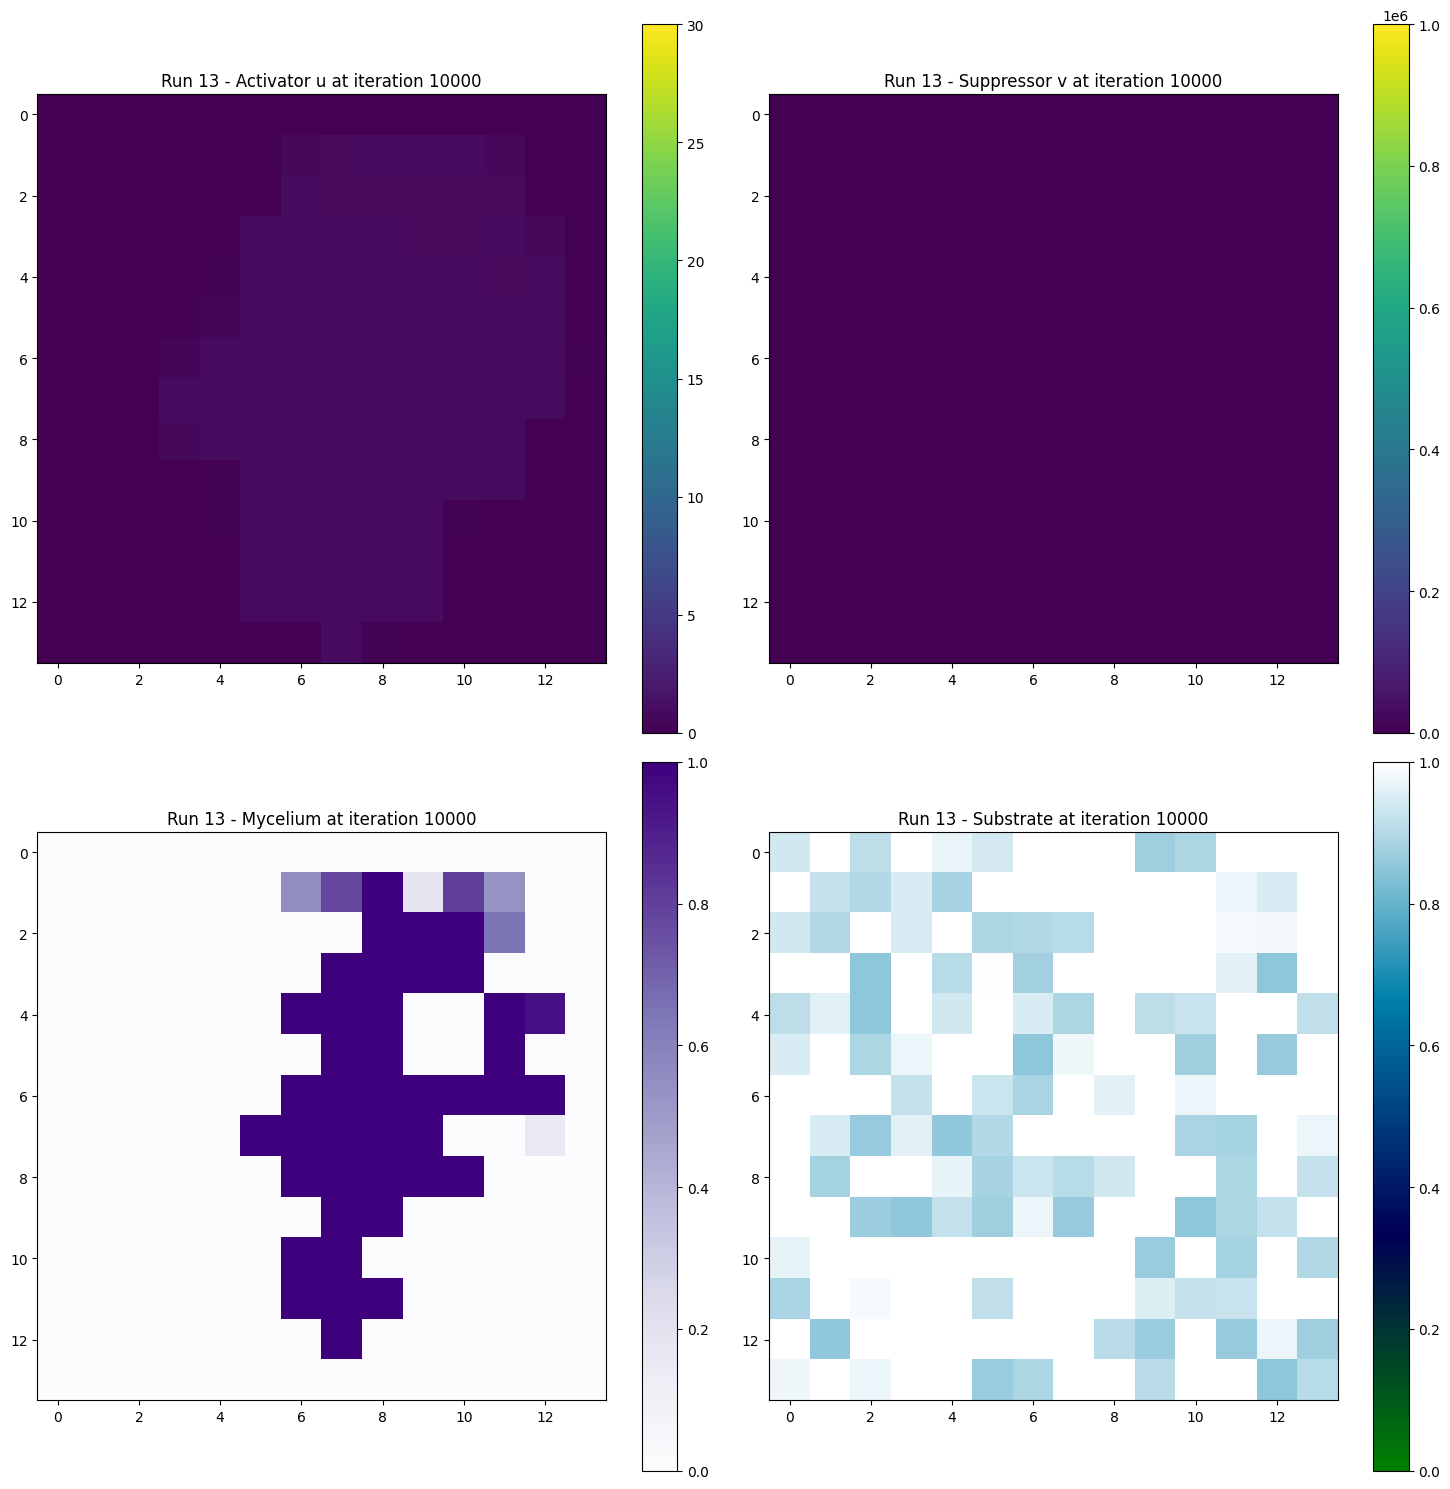

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_13_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_13_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_13_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_13_step_0.csv using NumPy with double precision.


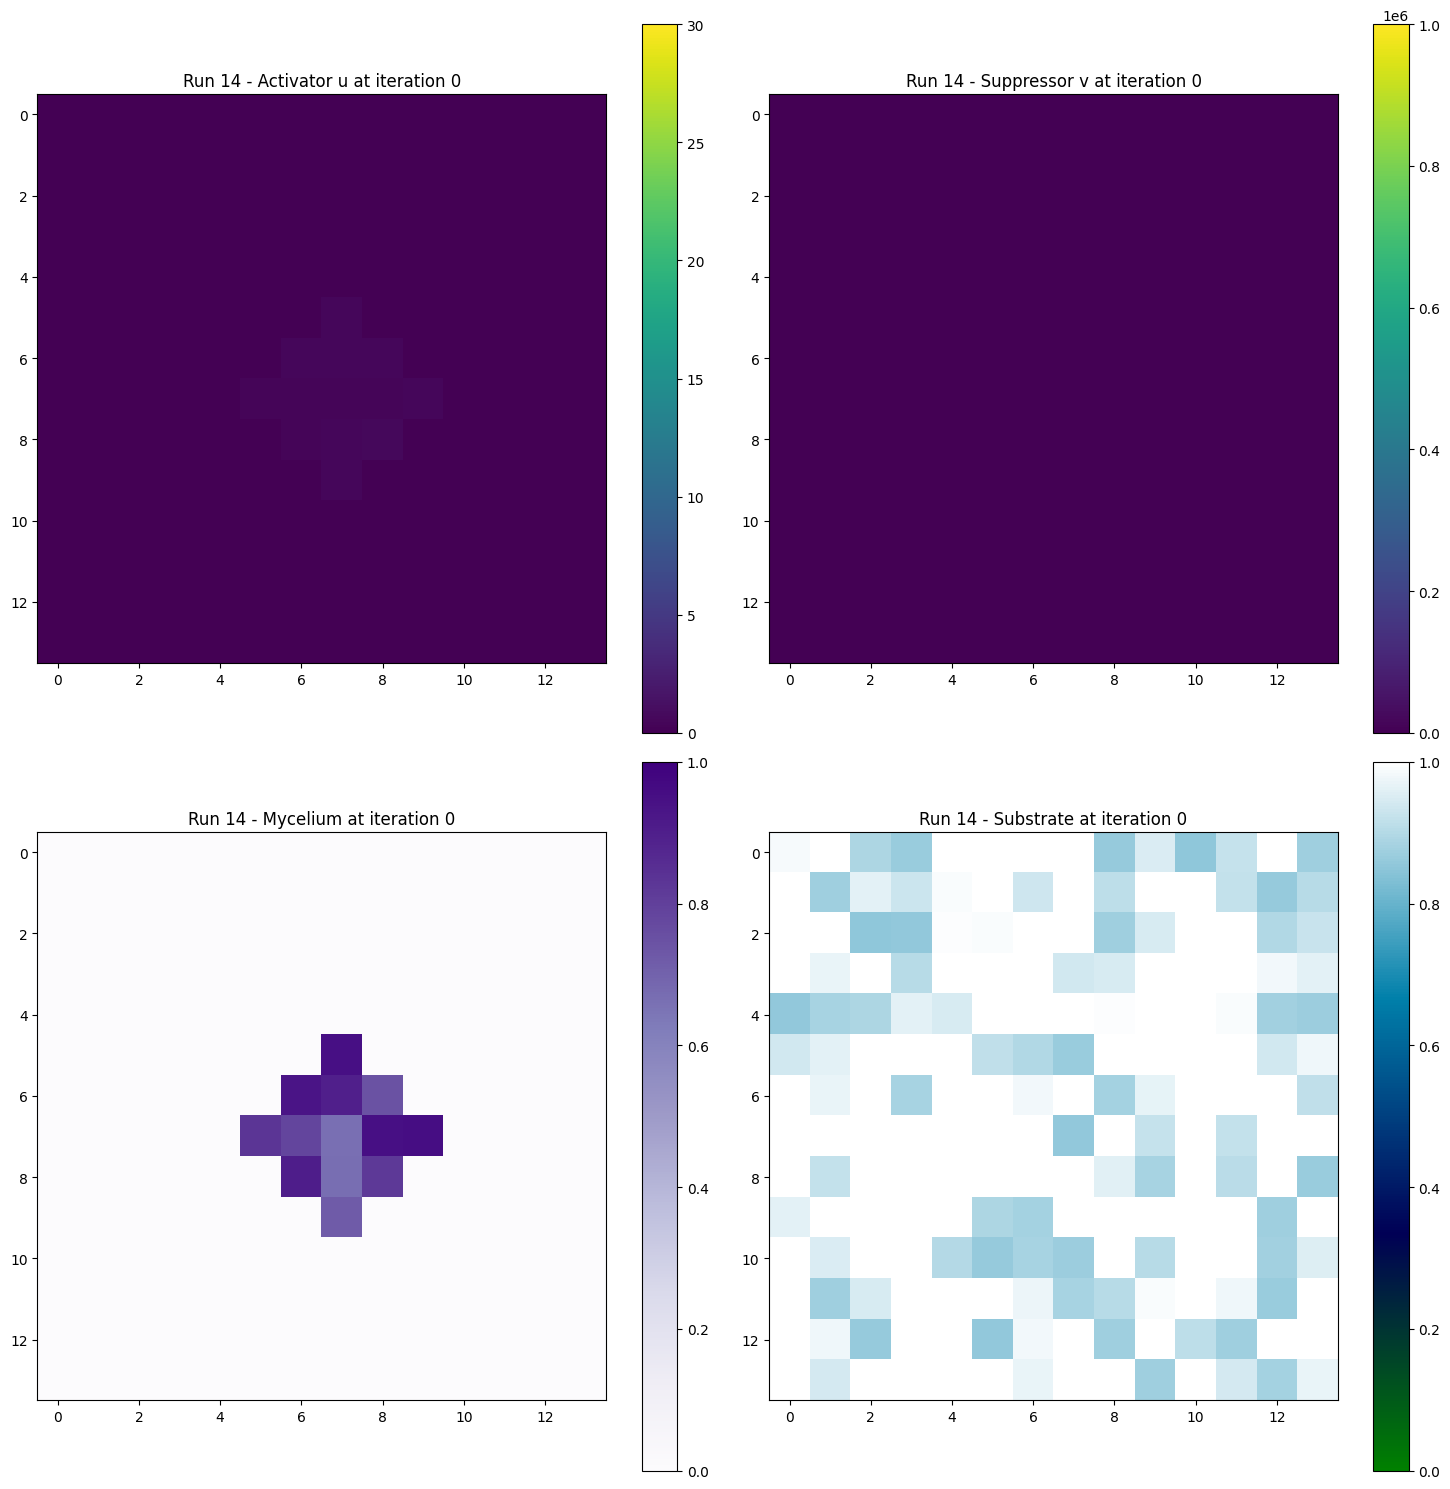

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_13_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_13_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_13_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_13_step_10000.csv using NumPy with double precision.


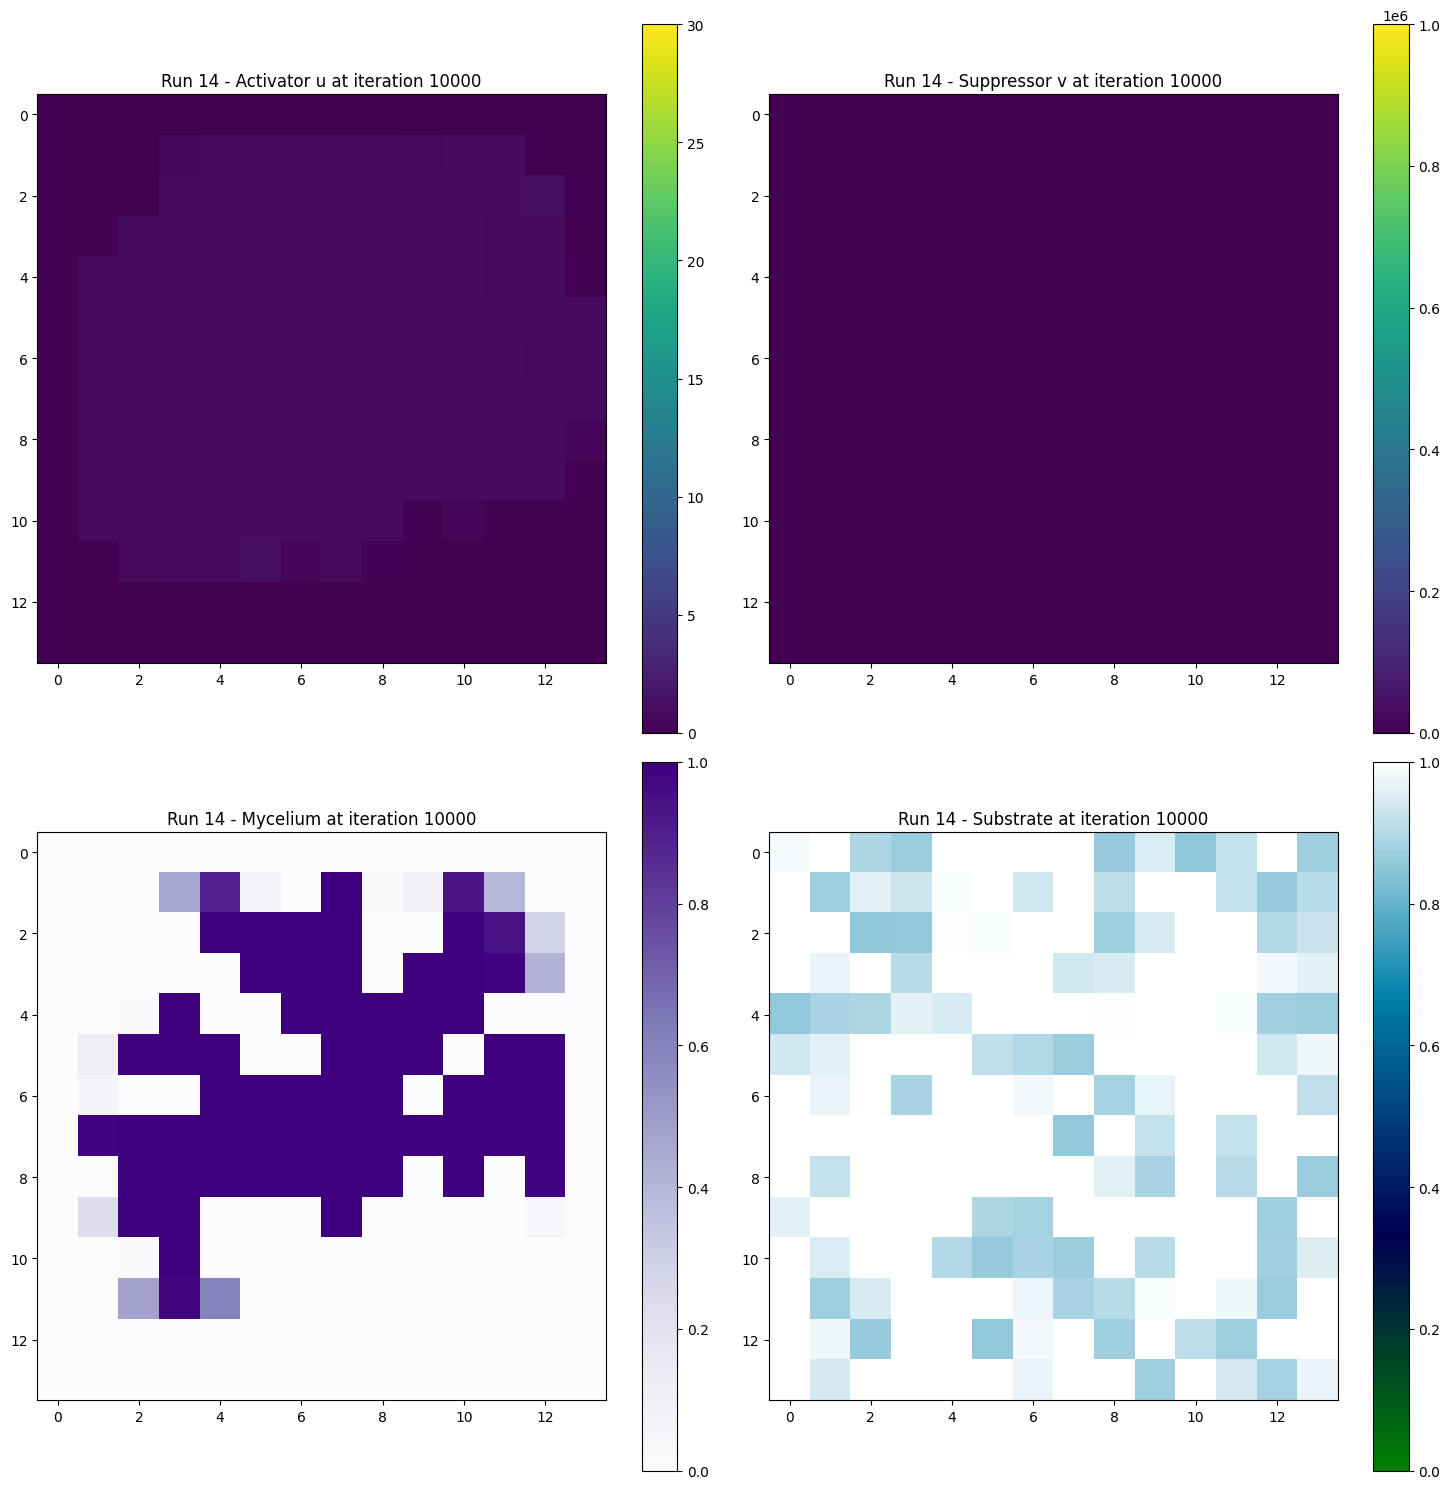

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_14_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_14_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_14_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_14_step_0.csv using NumPy with double precision.


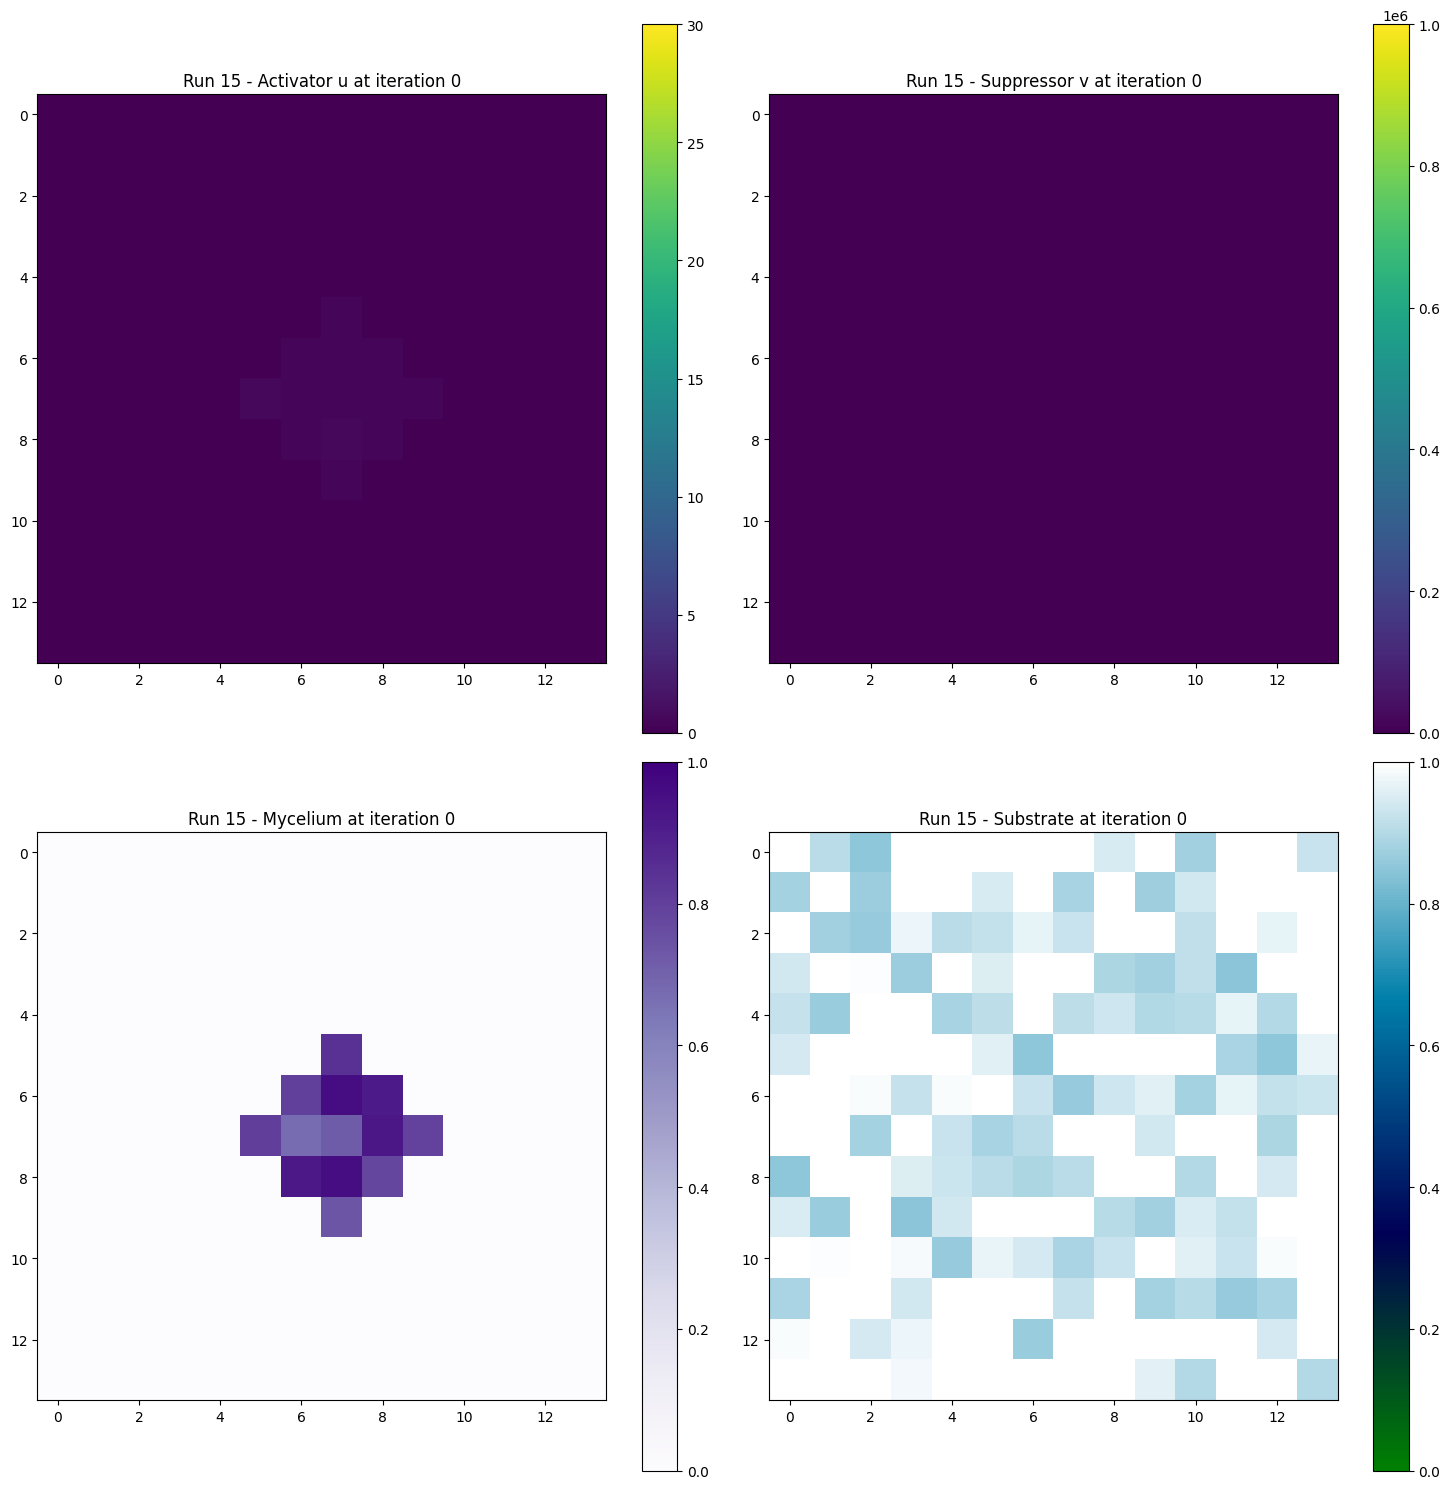

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_14_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_14_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_14_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_14_step_10000.csv using NumPy with double precision.


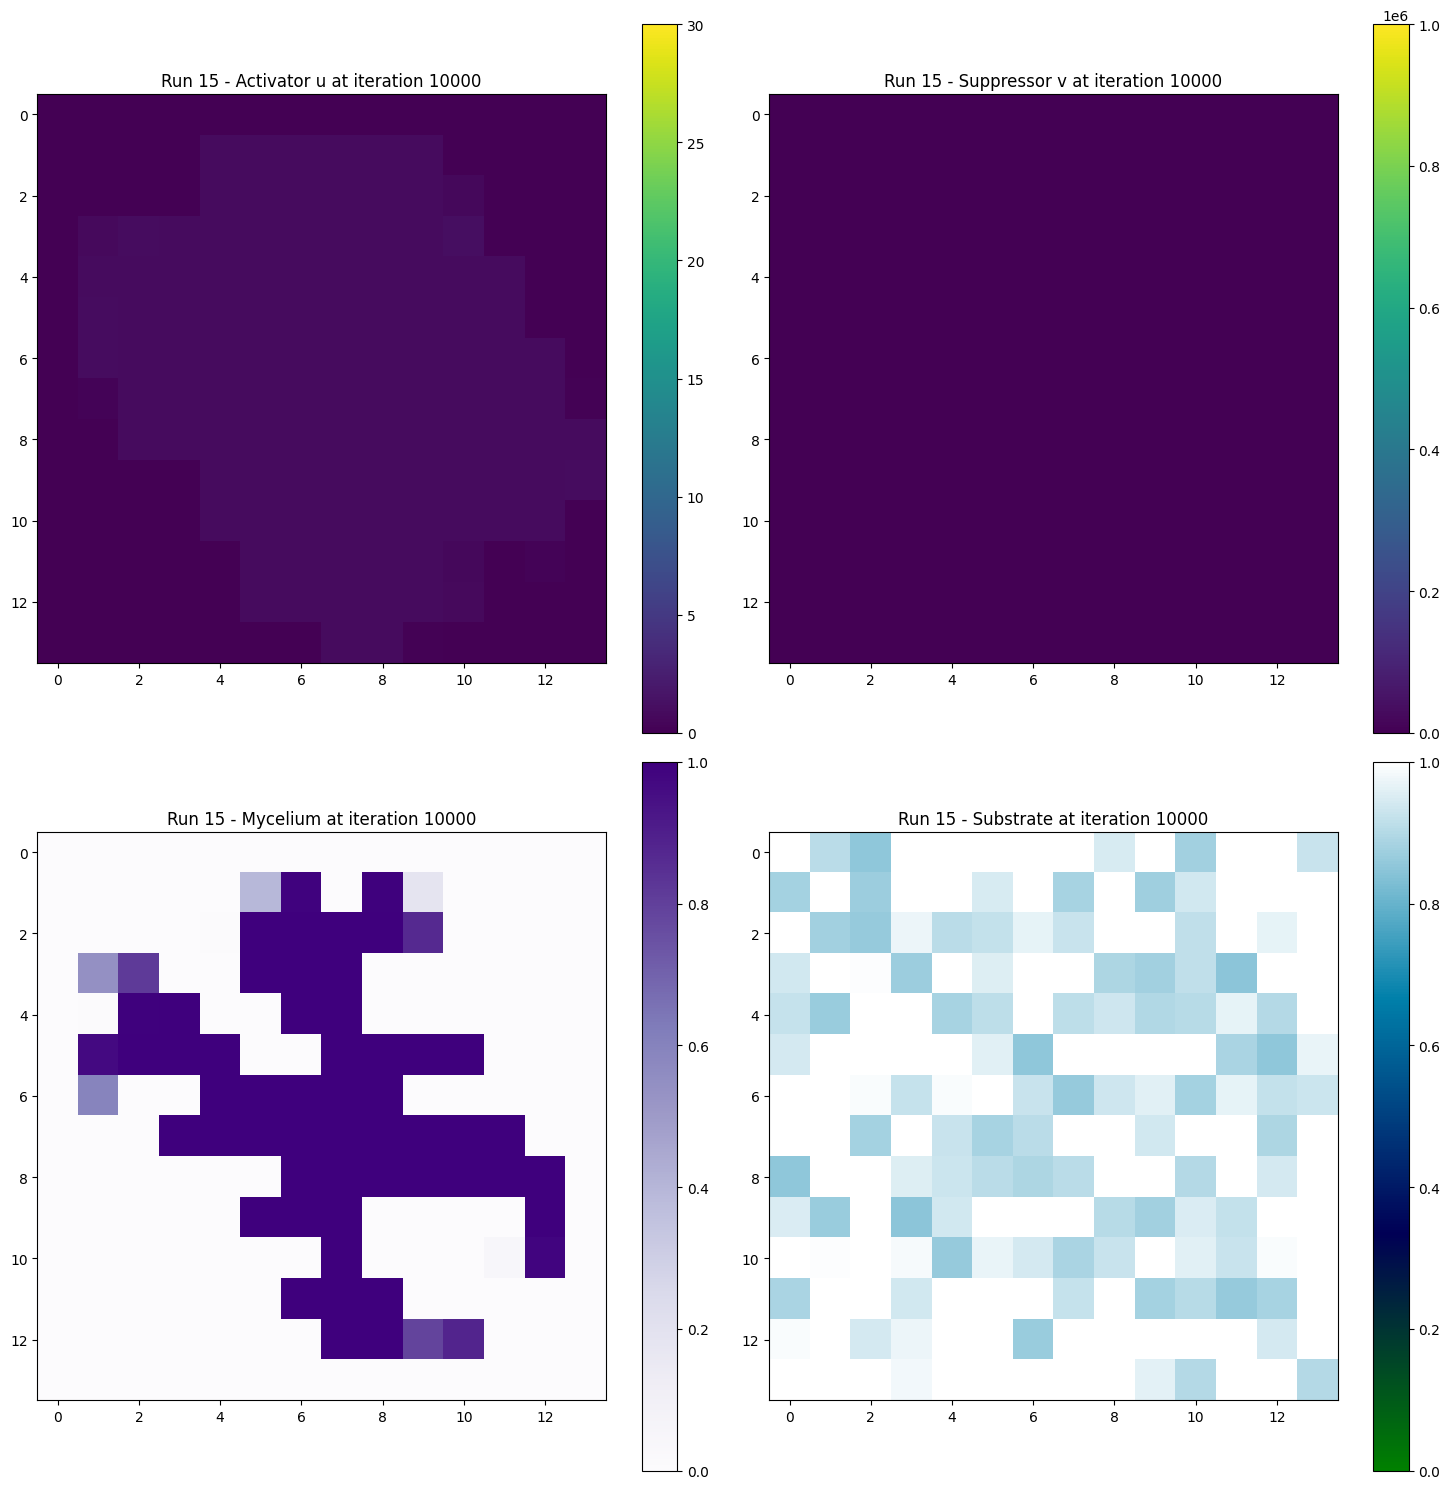

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_15_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_15_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_15_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_15_step_0.csv using NumPy with double precision.


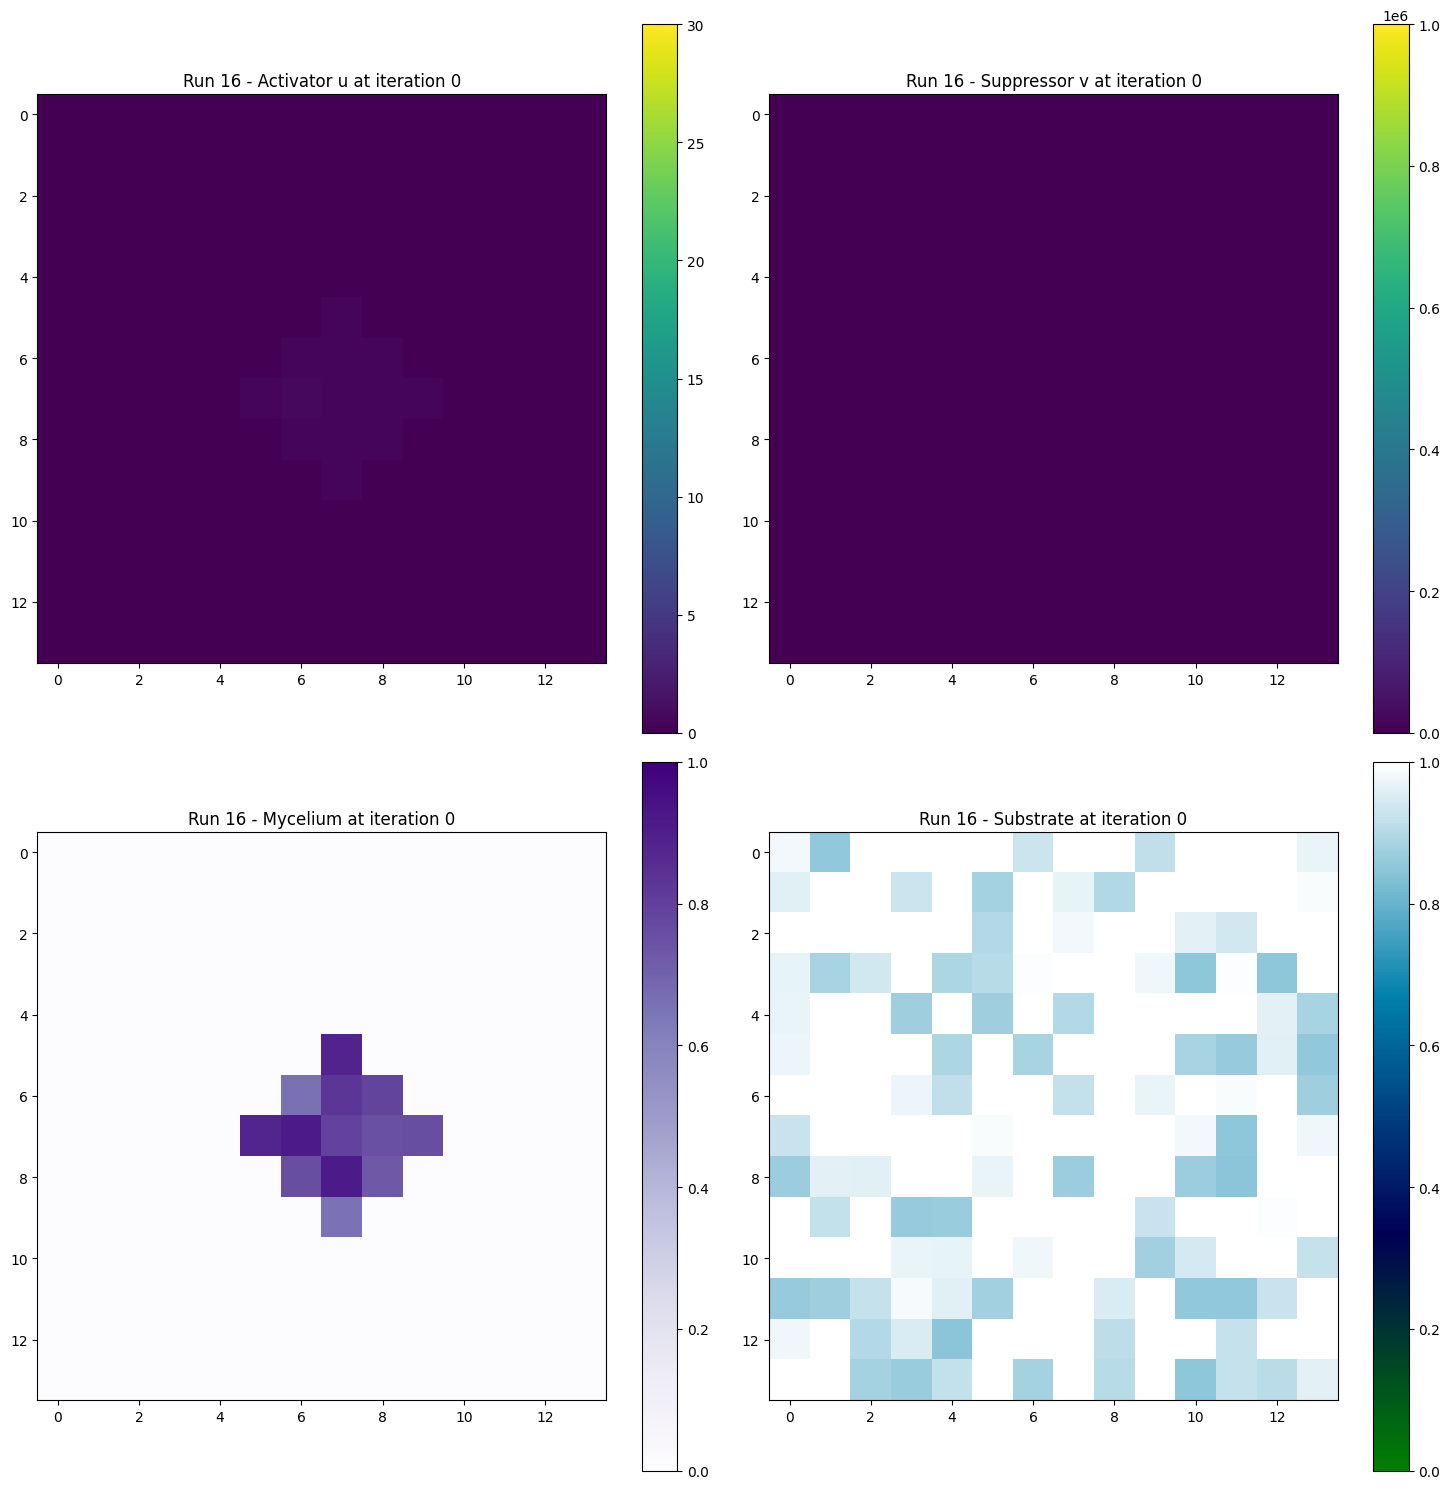

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_15_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_15_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_15_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_15_step_10000.csv using NumPy with double precision.


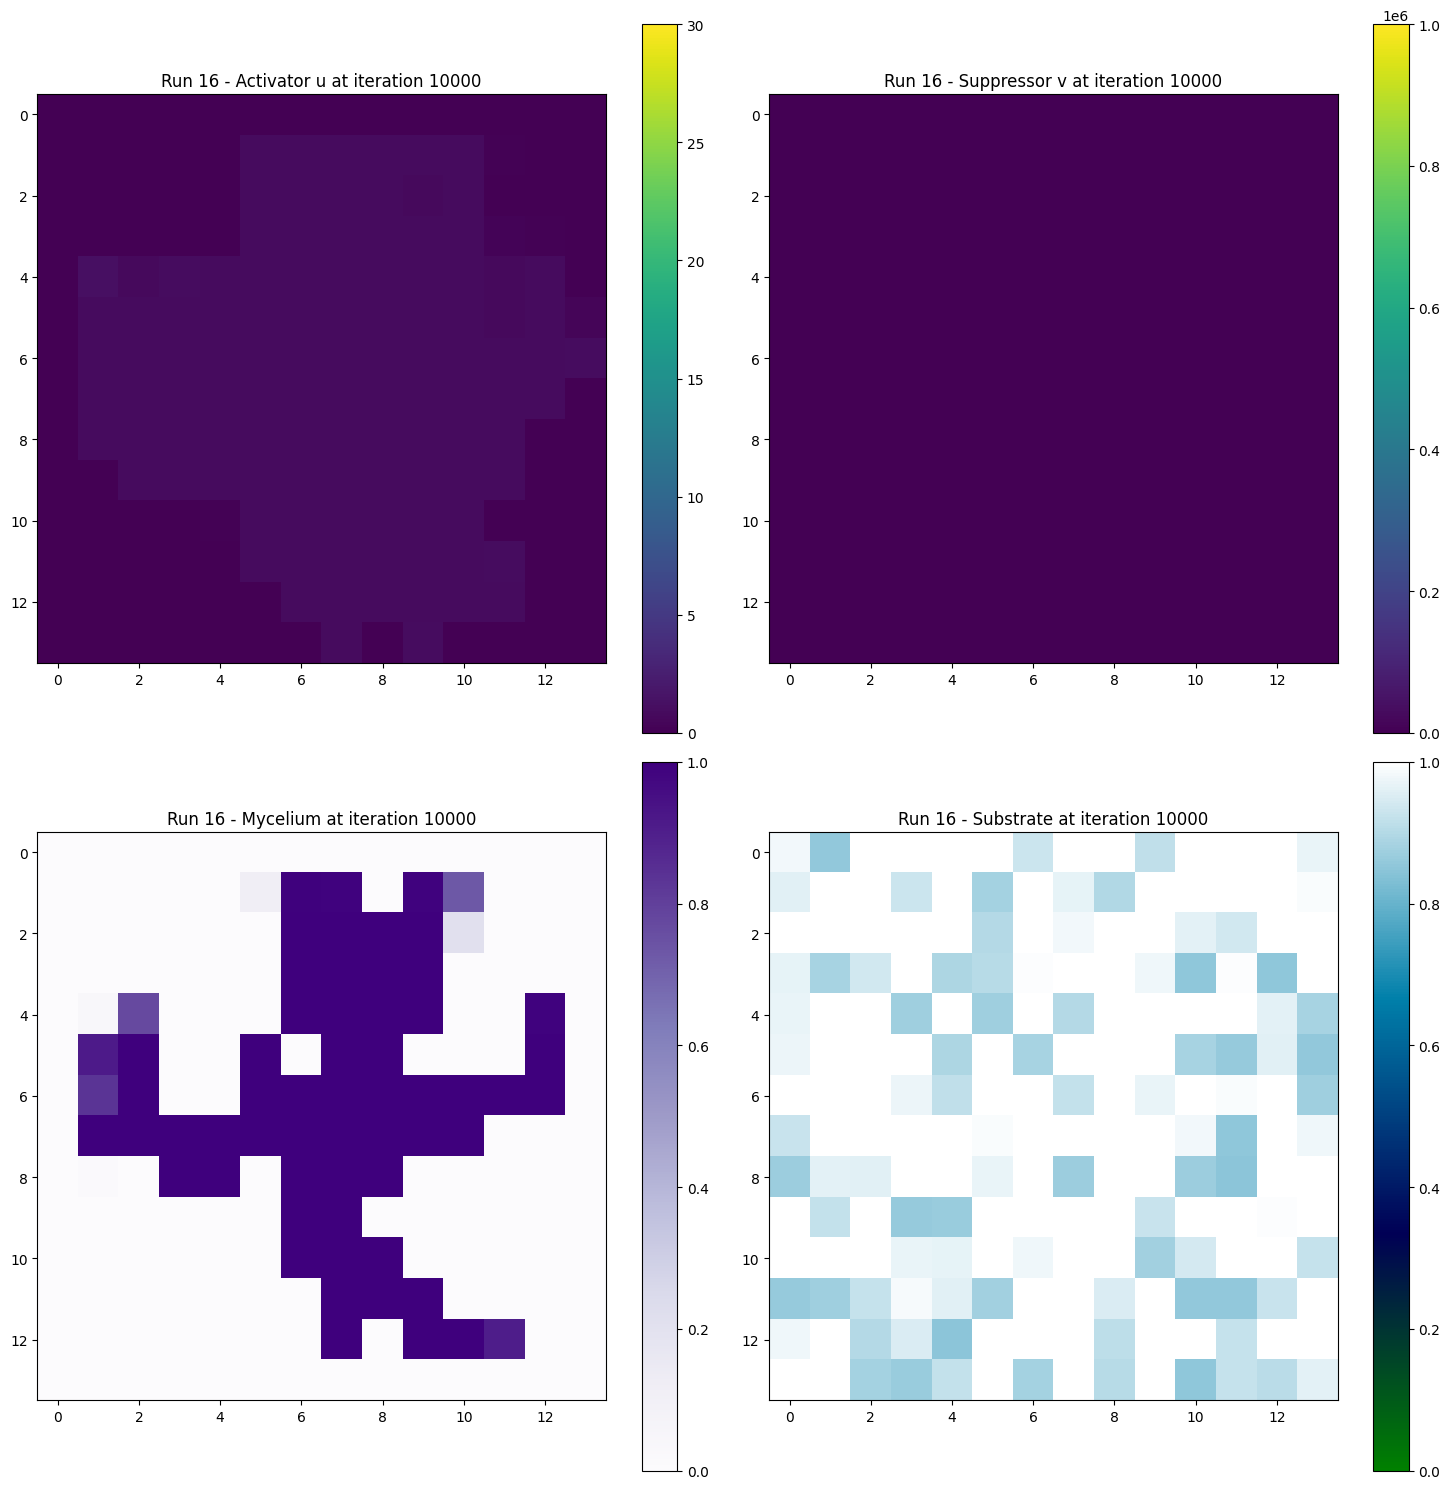

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_16_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_16_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_16_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_16_step_0.csv using NumPy with double precision.


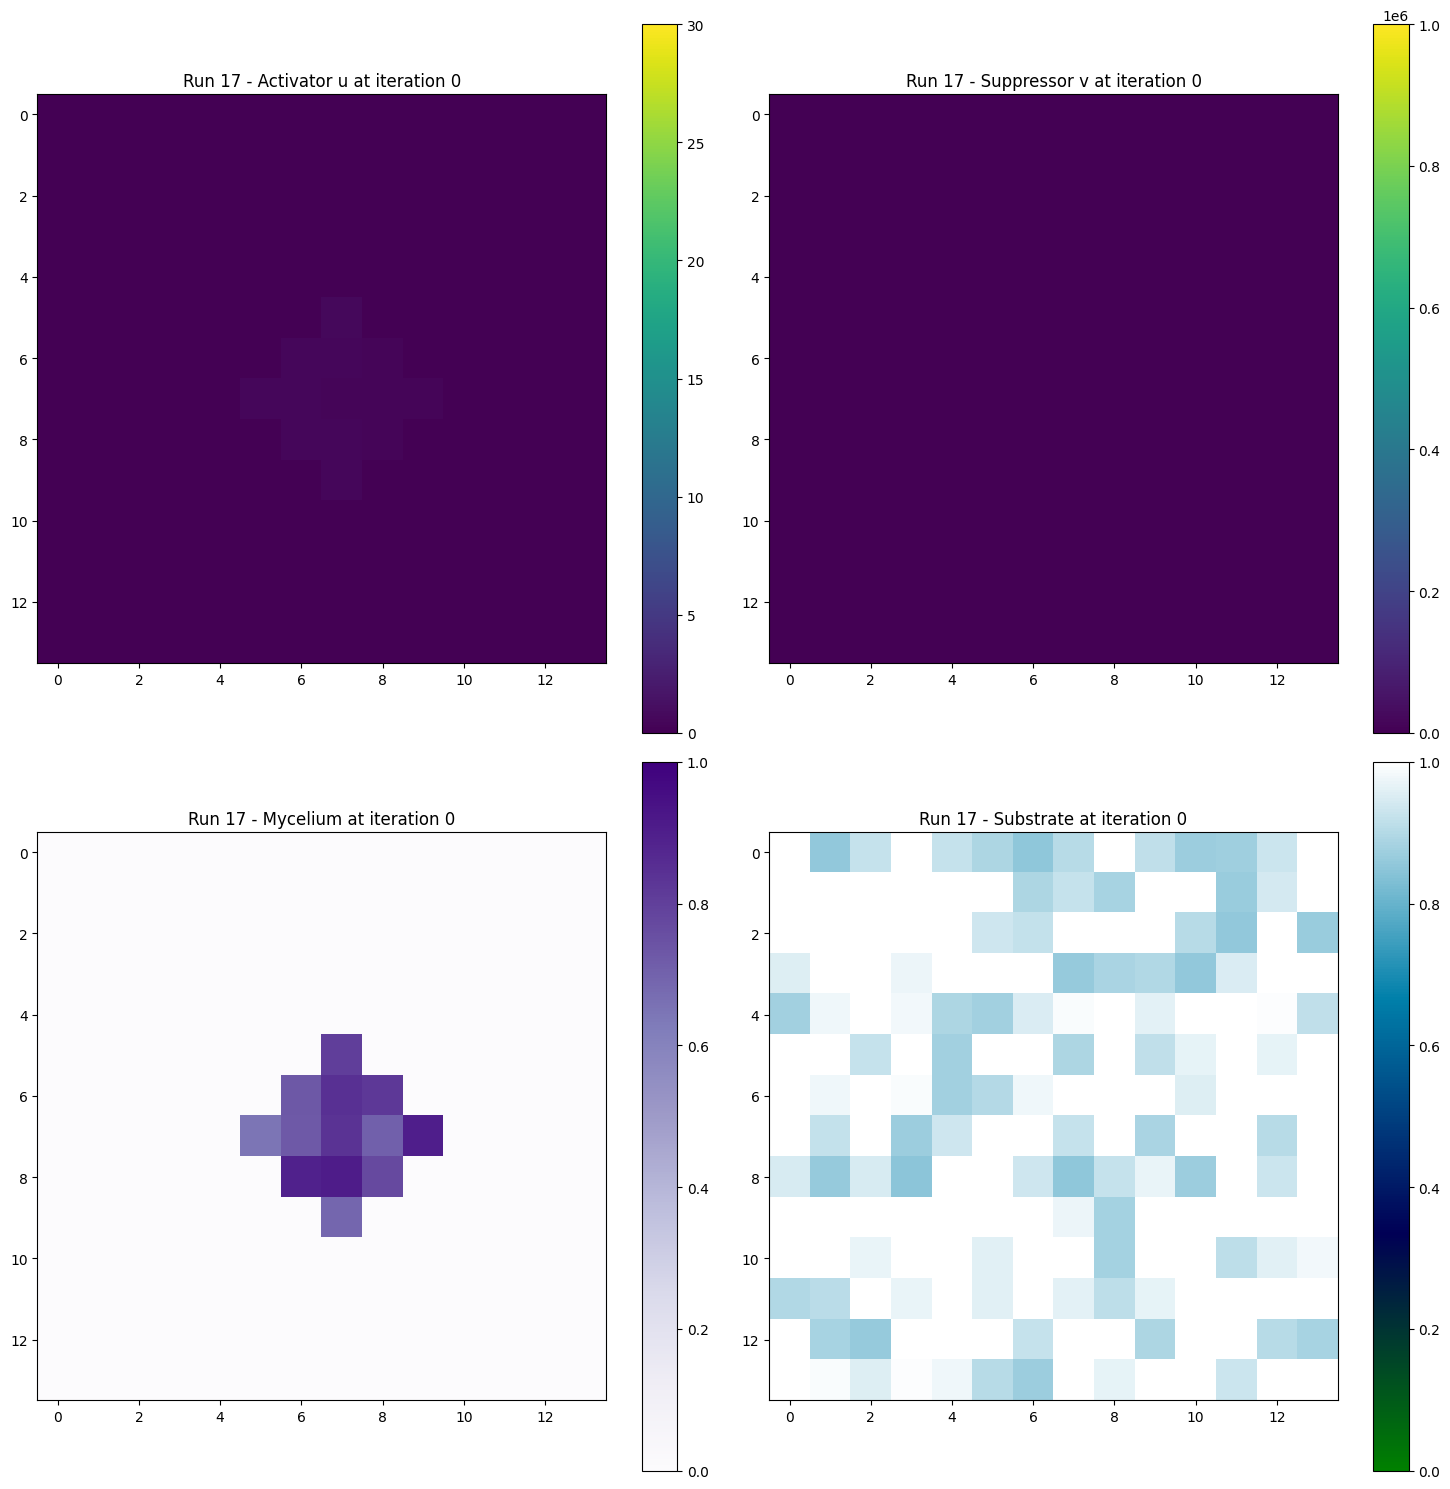

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_16_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_16_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_16_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_16_step_10000.csv using NumPy with double precision.


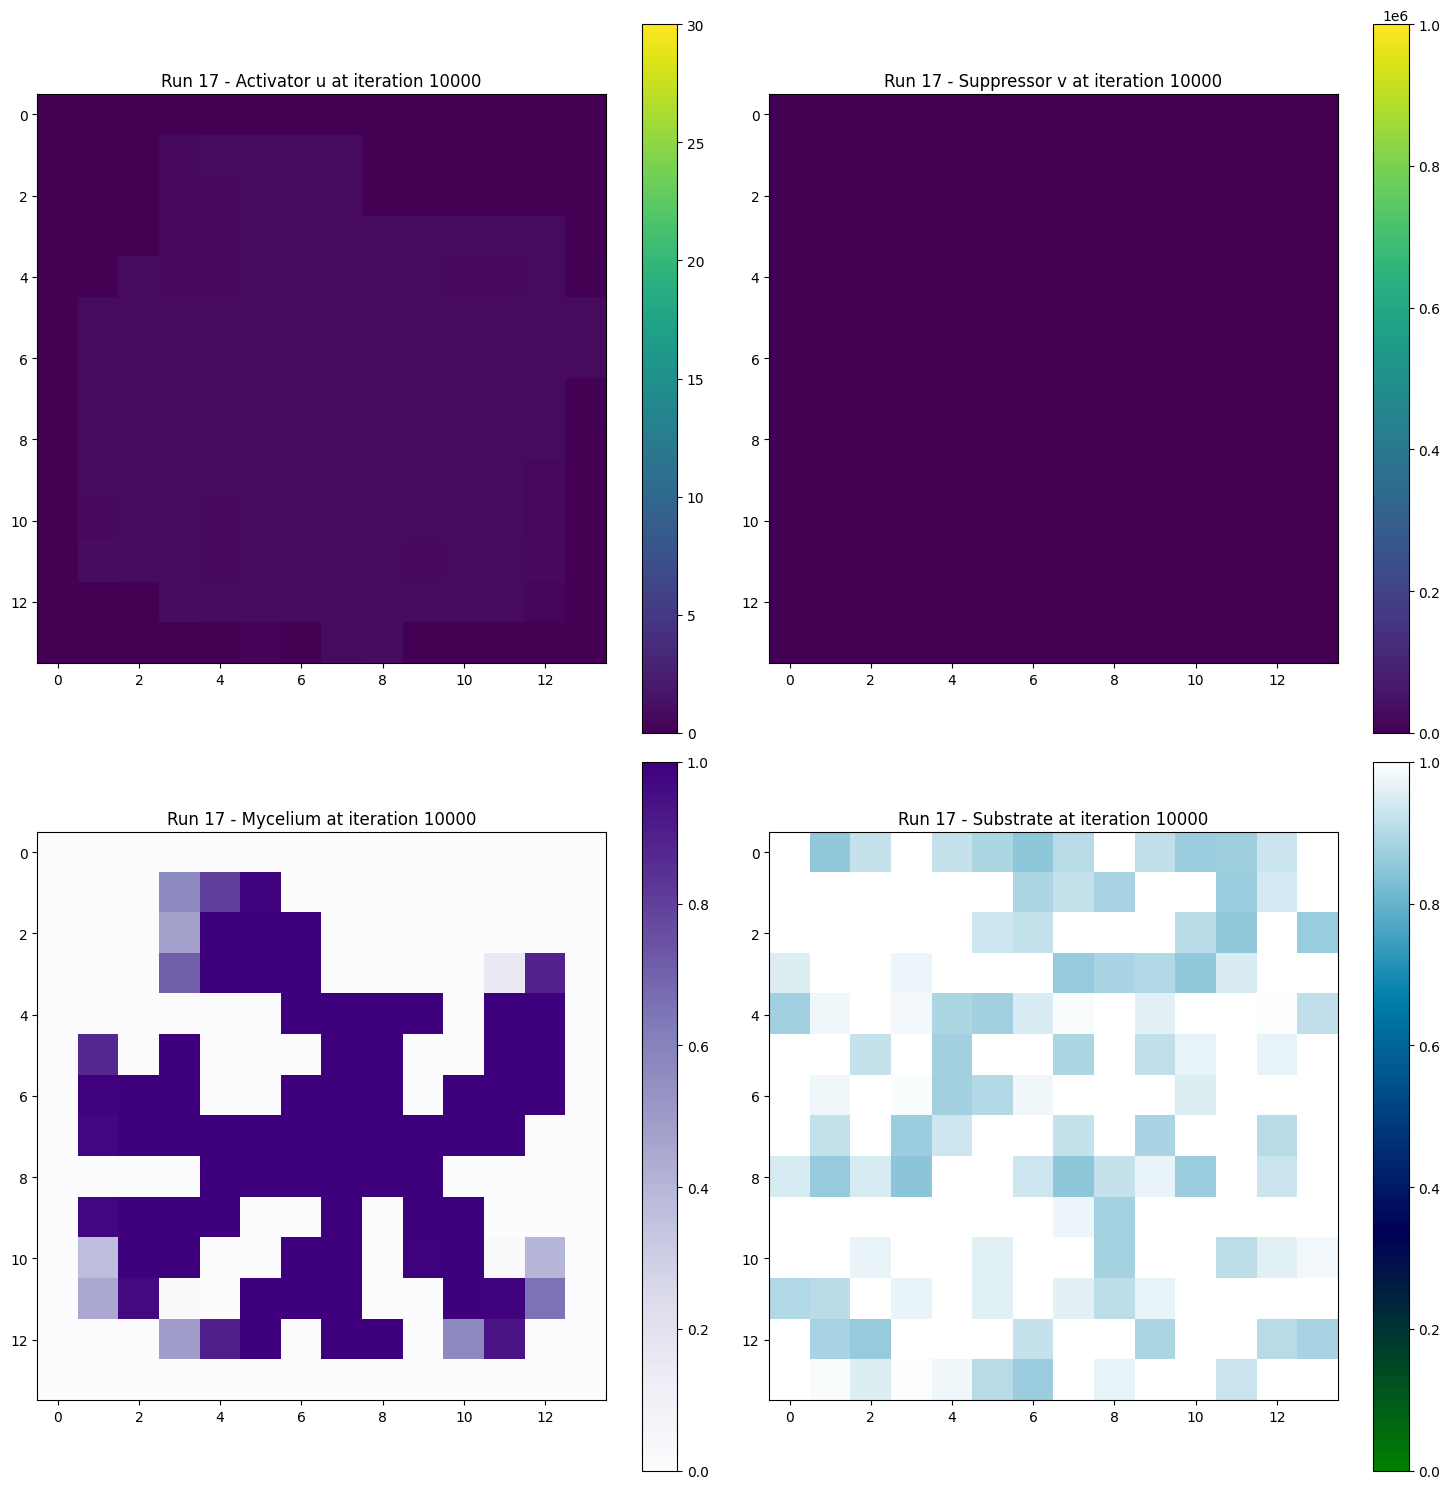

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_17_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_17_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_17_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_17_step_0.csv using NumPy with double precision.


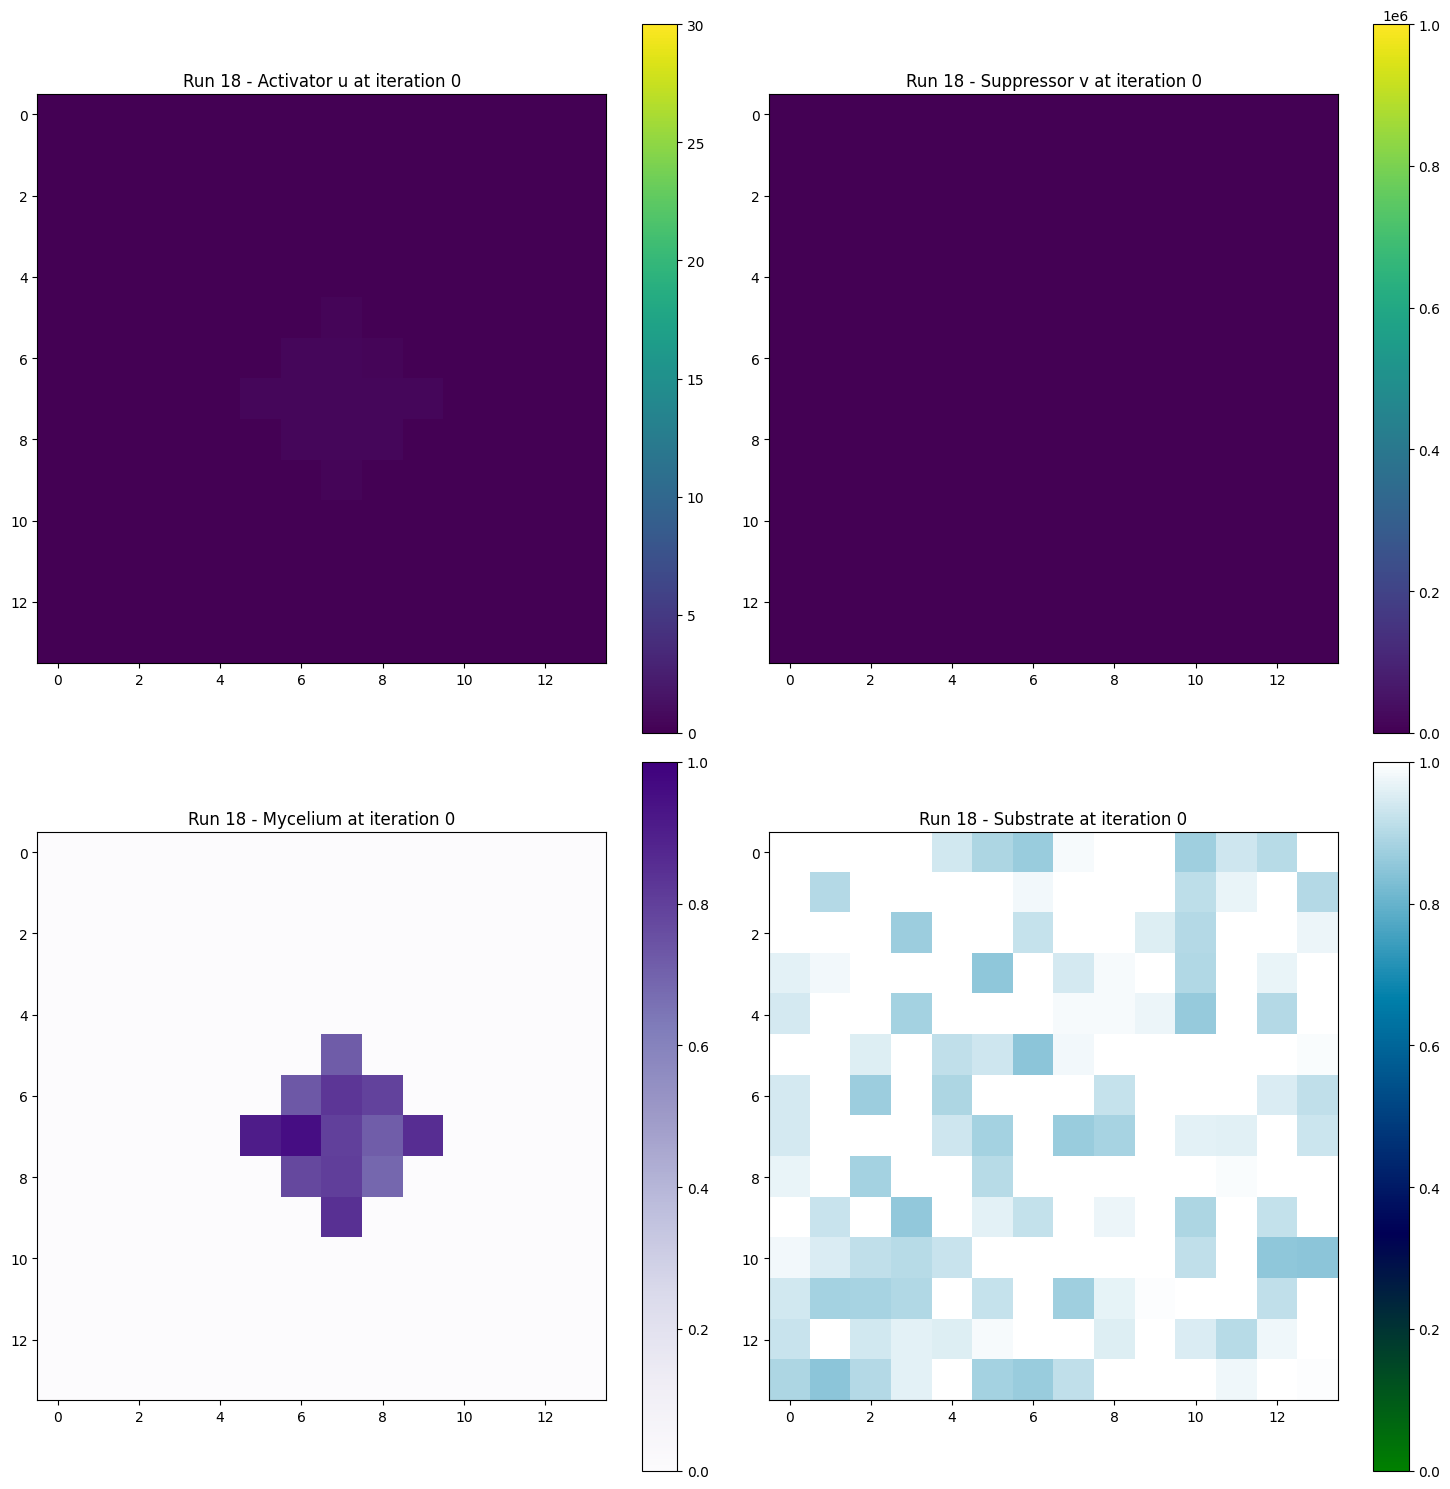

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_17_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_17_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_17_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_17_step_10000.csv using NumPy with double precision.


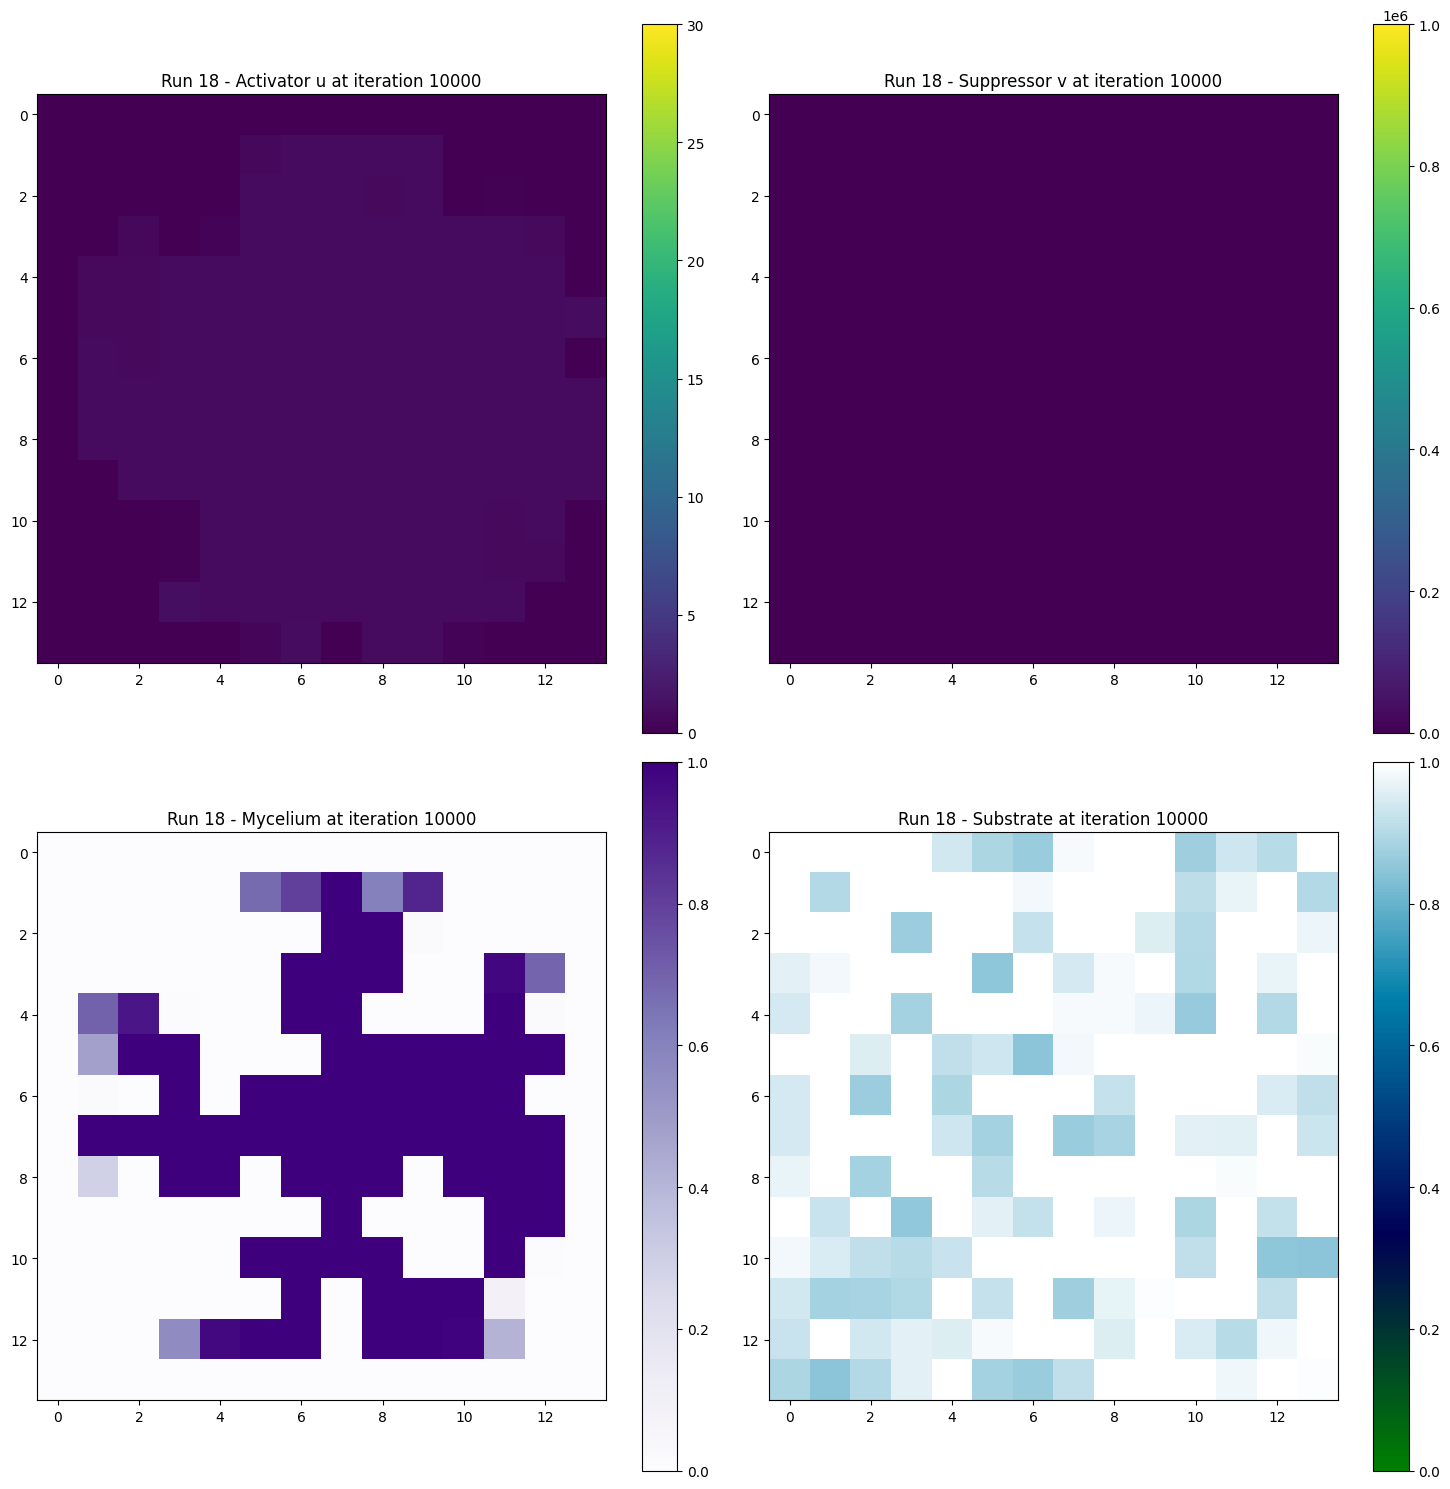

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_18_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_18_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_18_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_18_step_0.csv using NumPy with double precision.


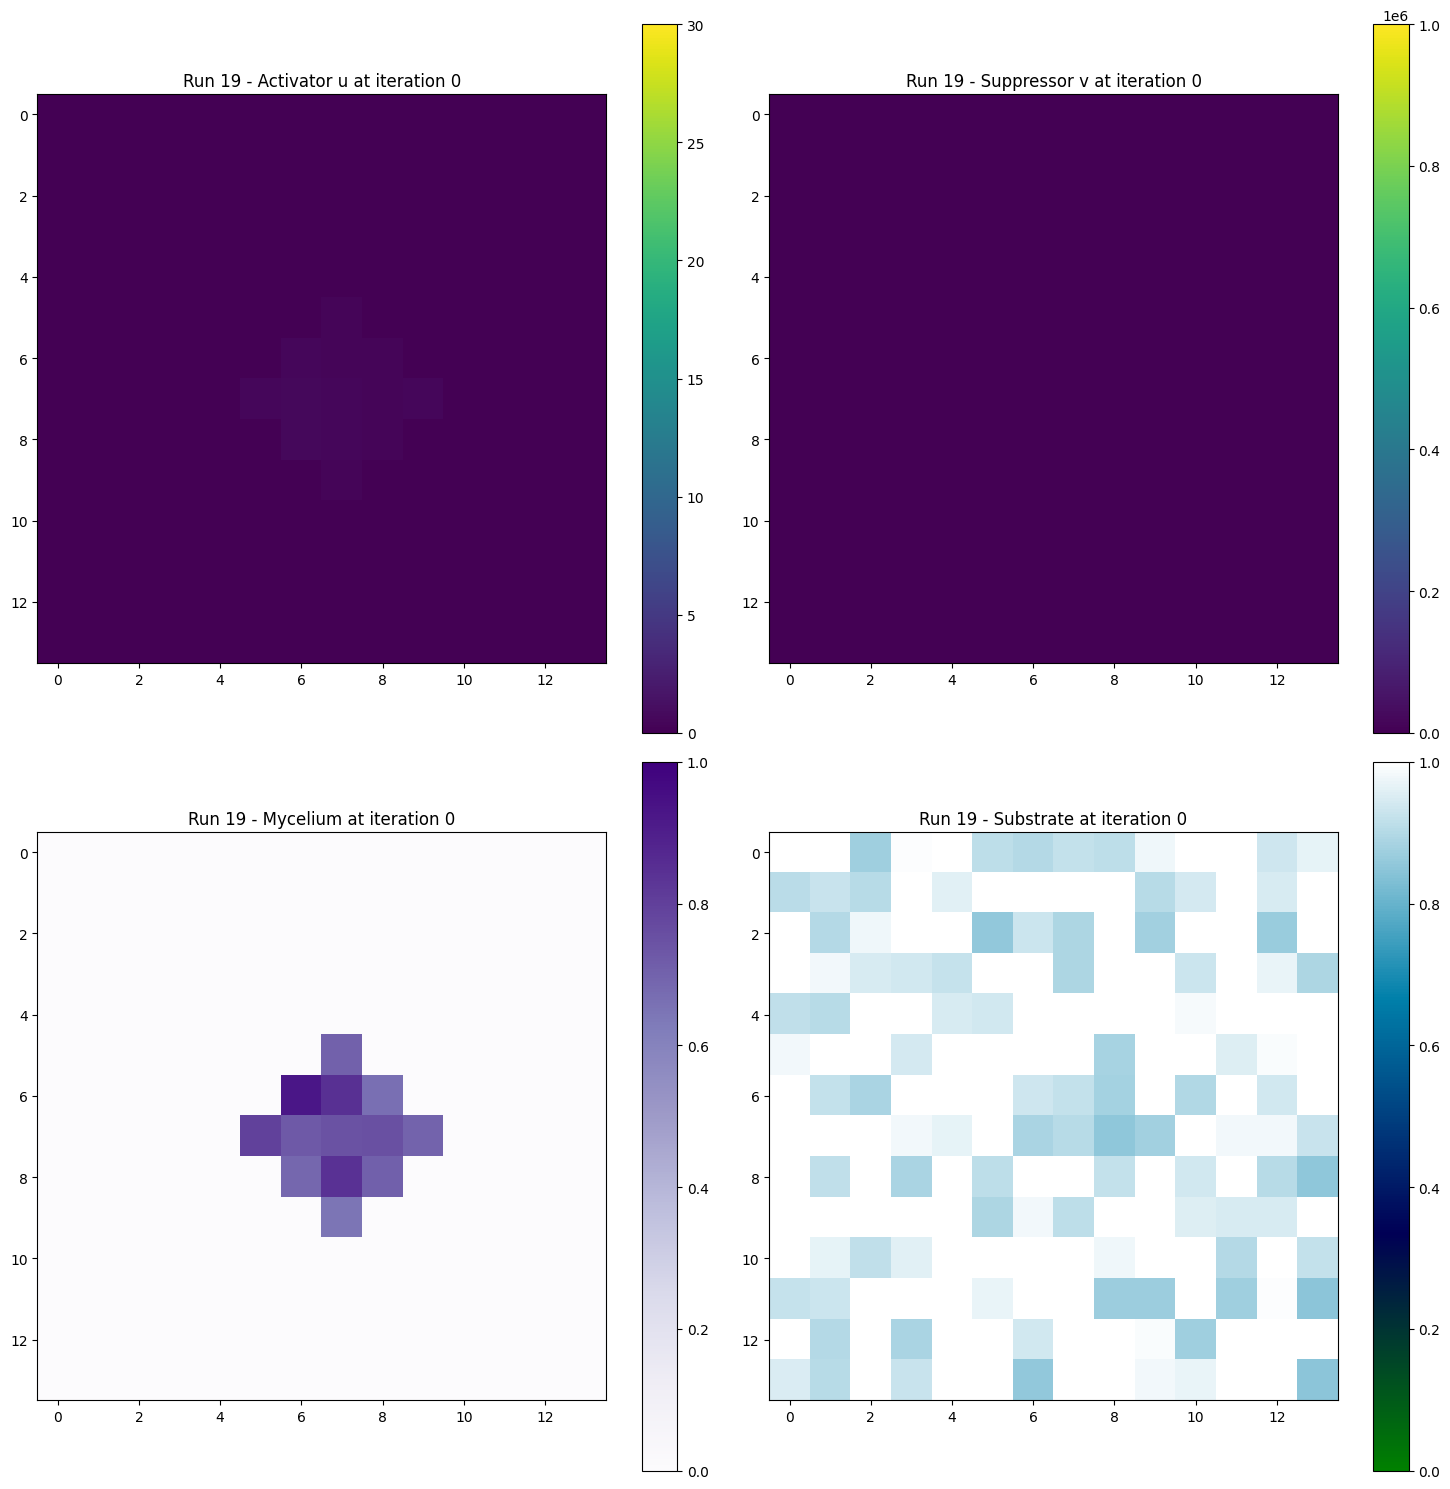

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_18_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_18_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_18_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_18_step_10000.csv using NumPy with double precision.


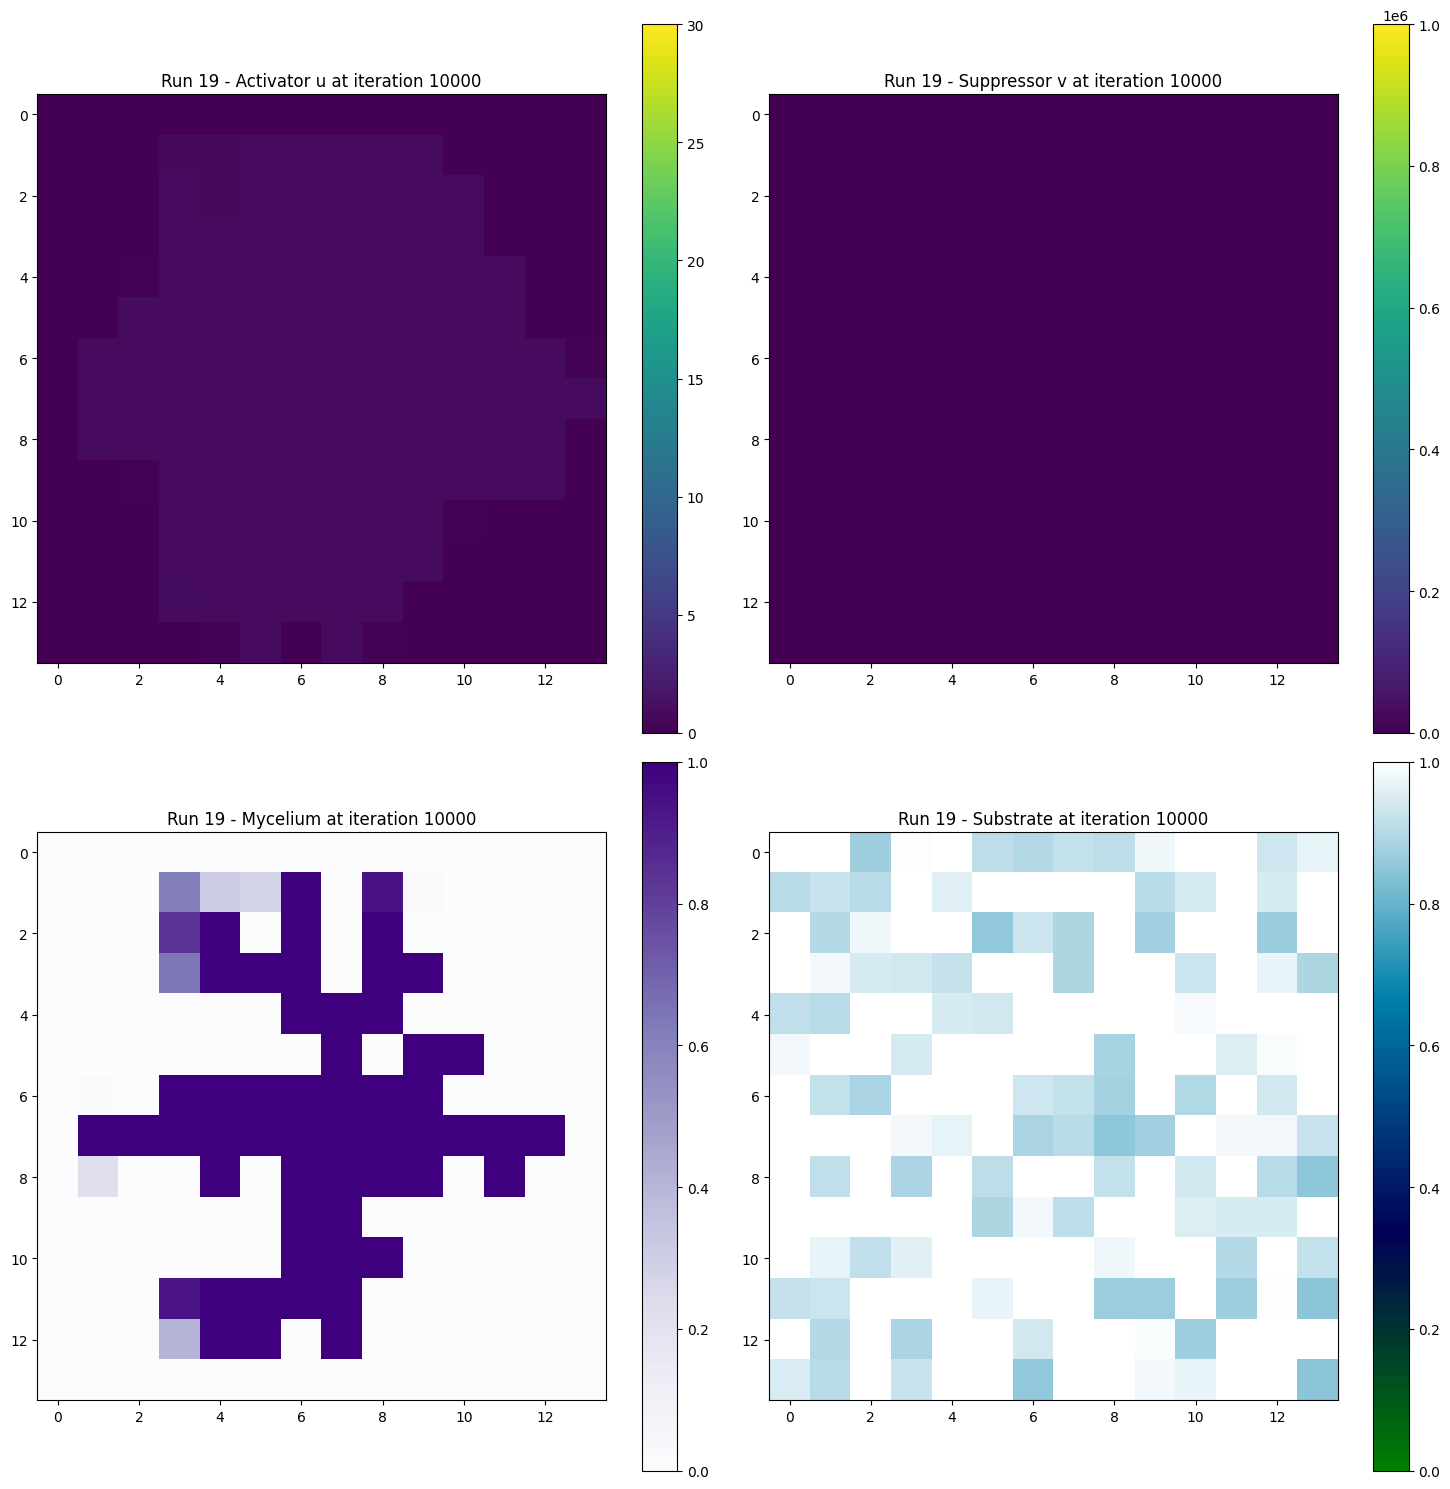

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_19_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_19_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_19_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_19_step_0.csv using NumPy with double precision.


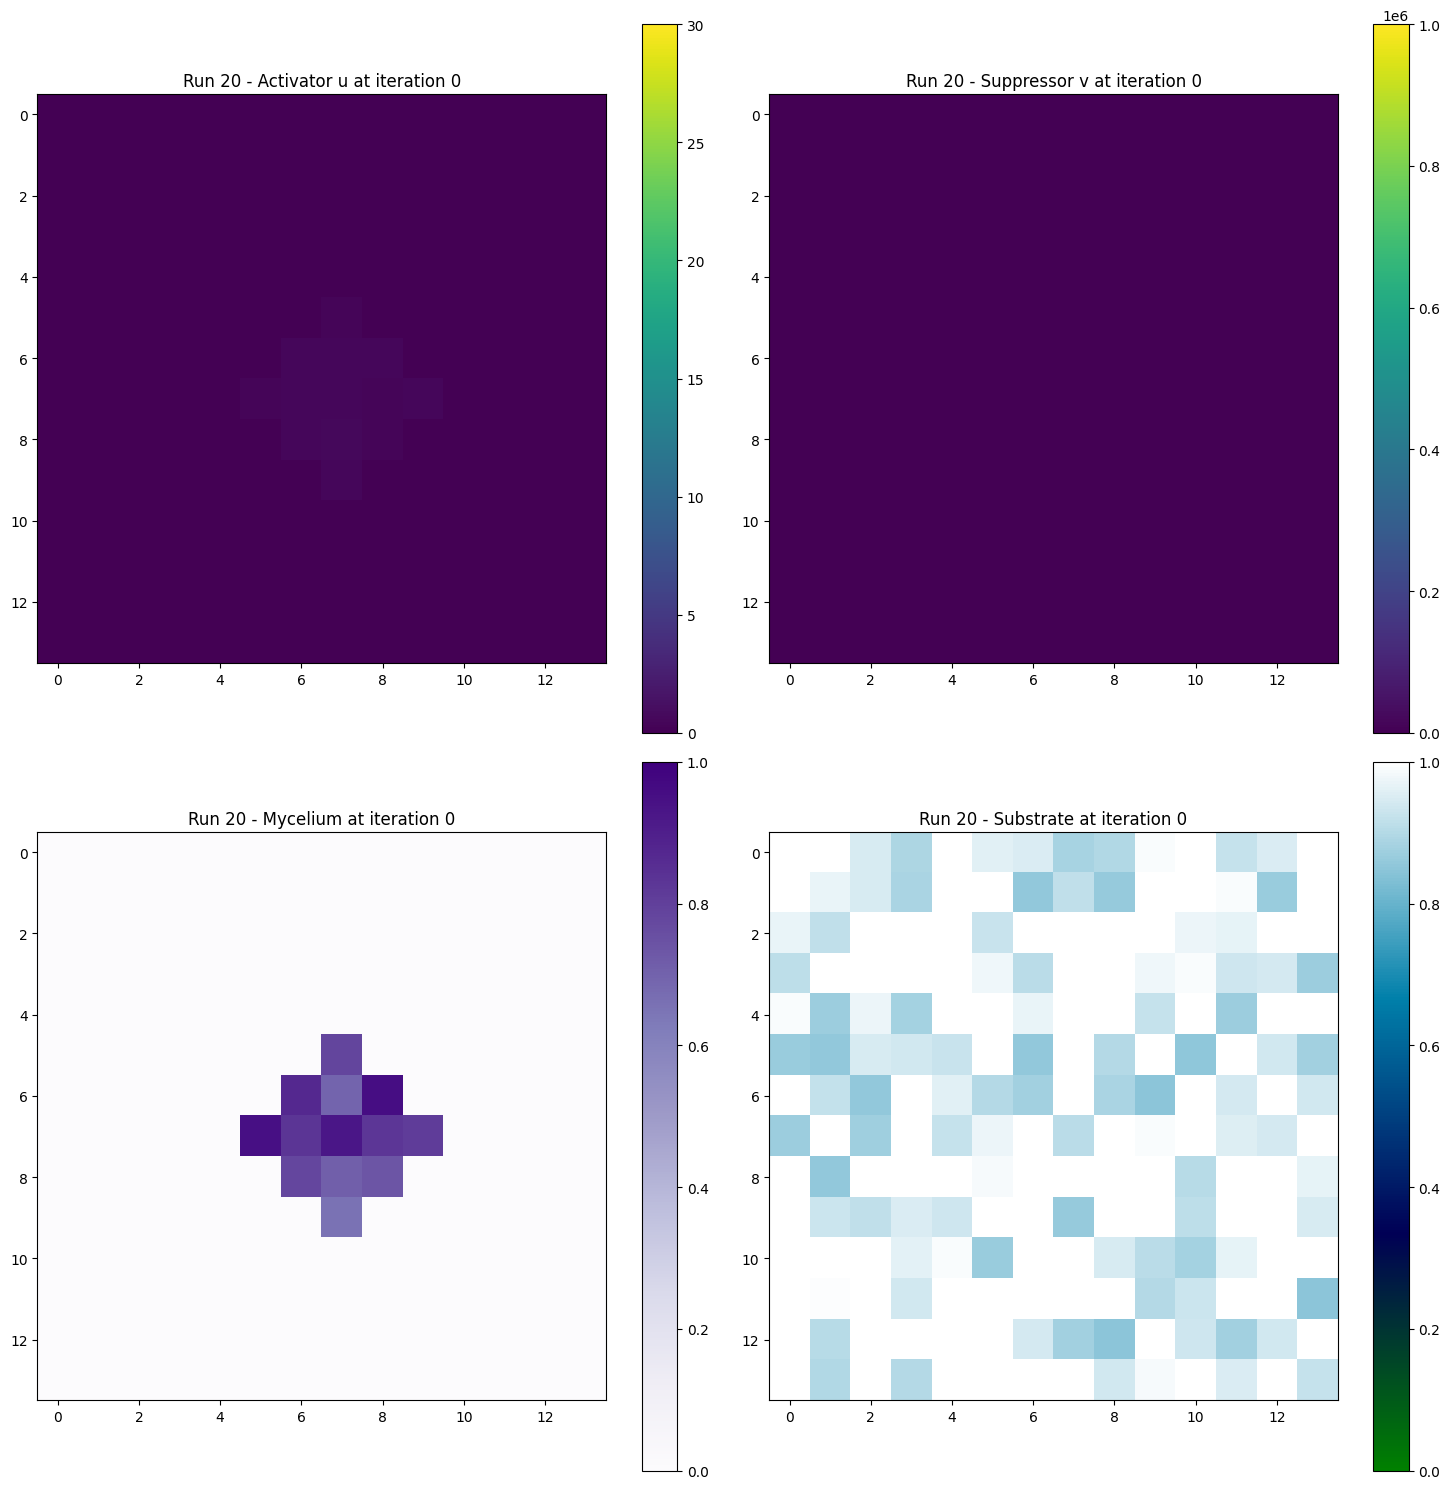

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_19_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_19_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_19_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_19_step_10000.csv using NumPy with double precision.


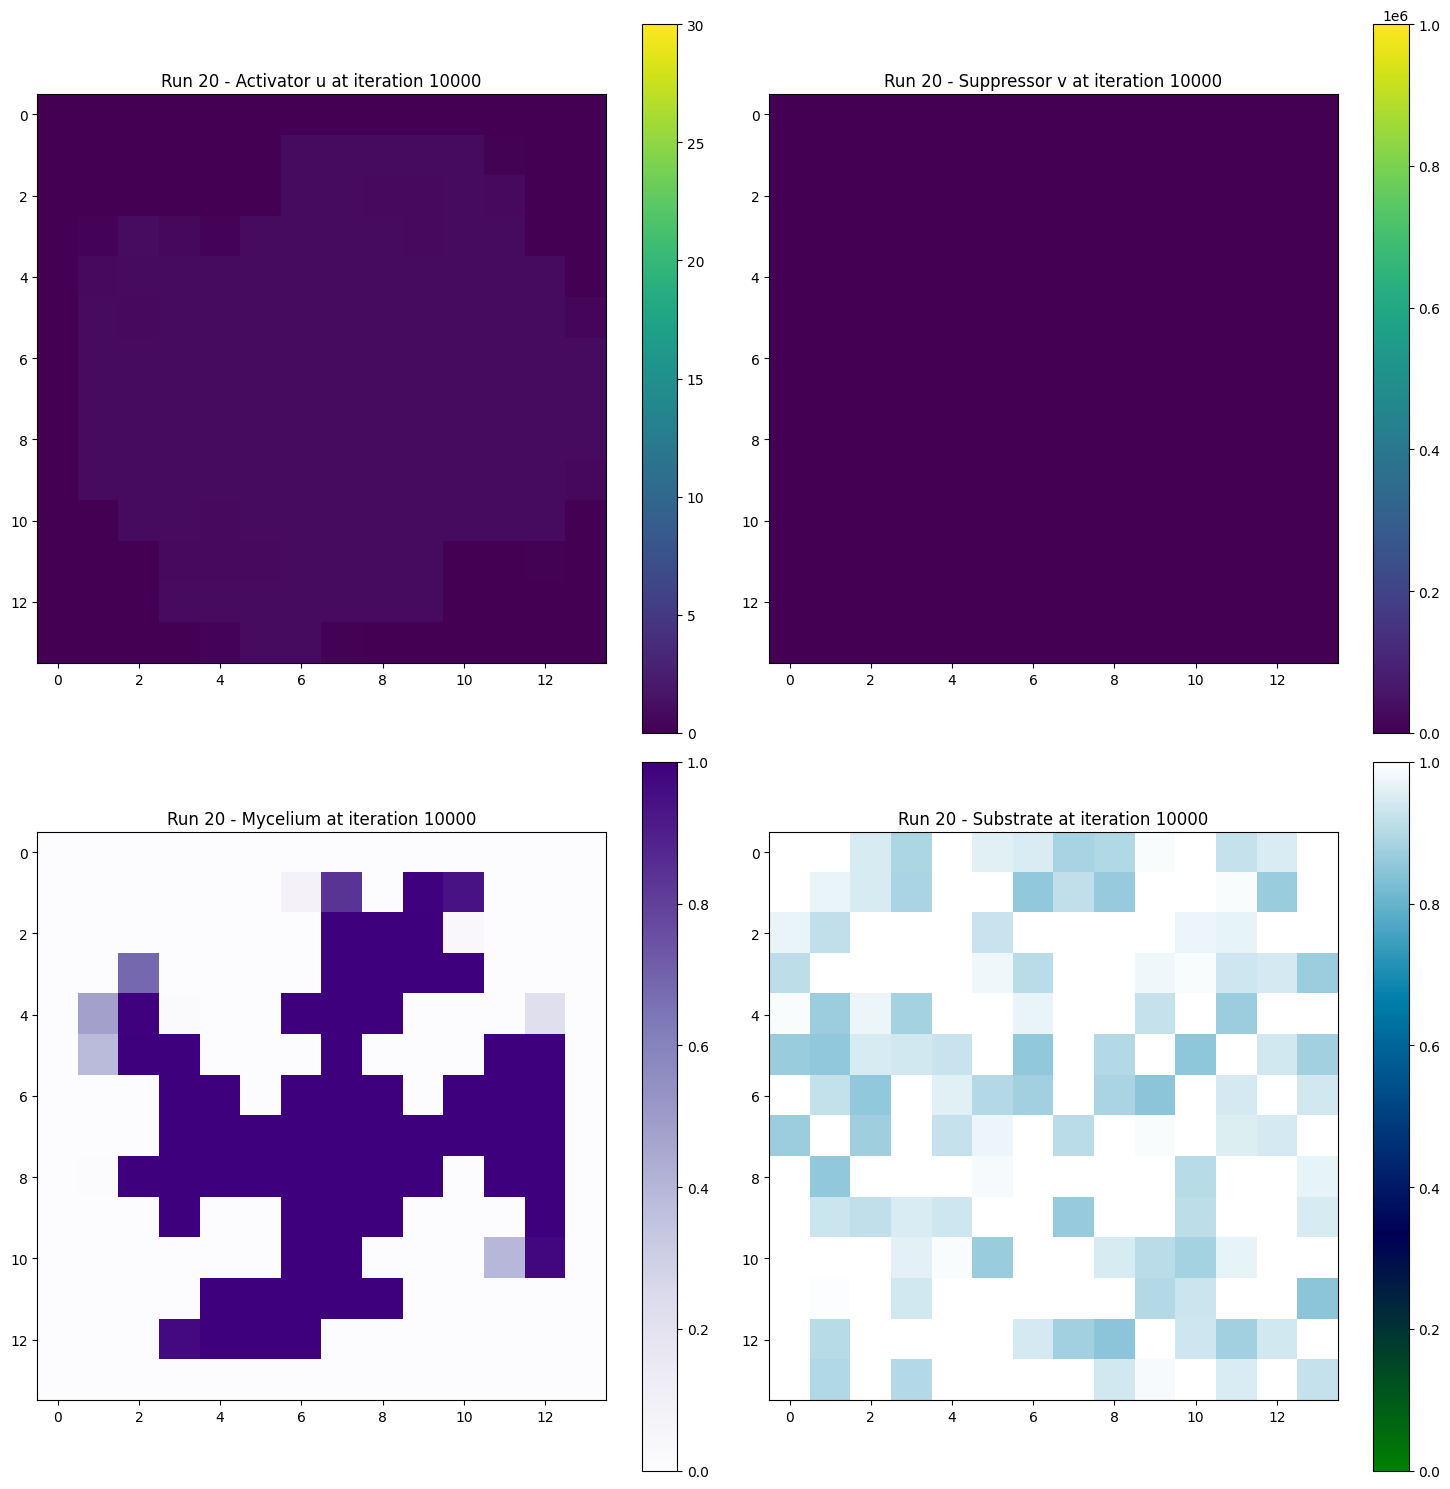

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_20_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_20_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_20_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_20_step_0.csv using NumPy with double precision.


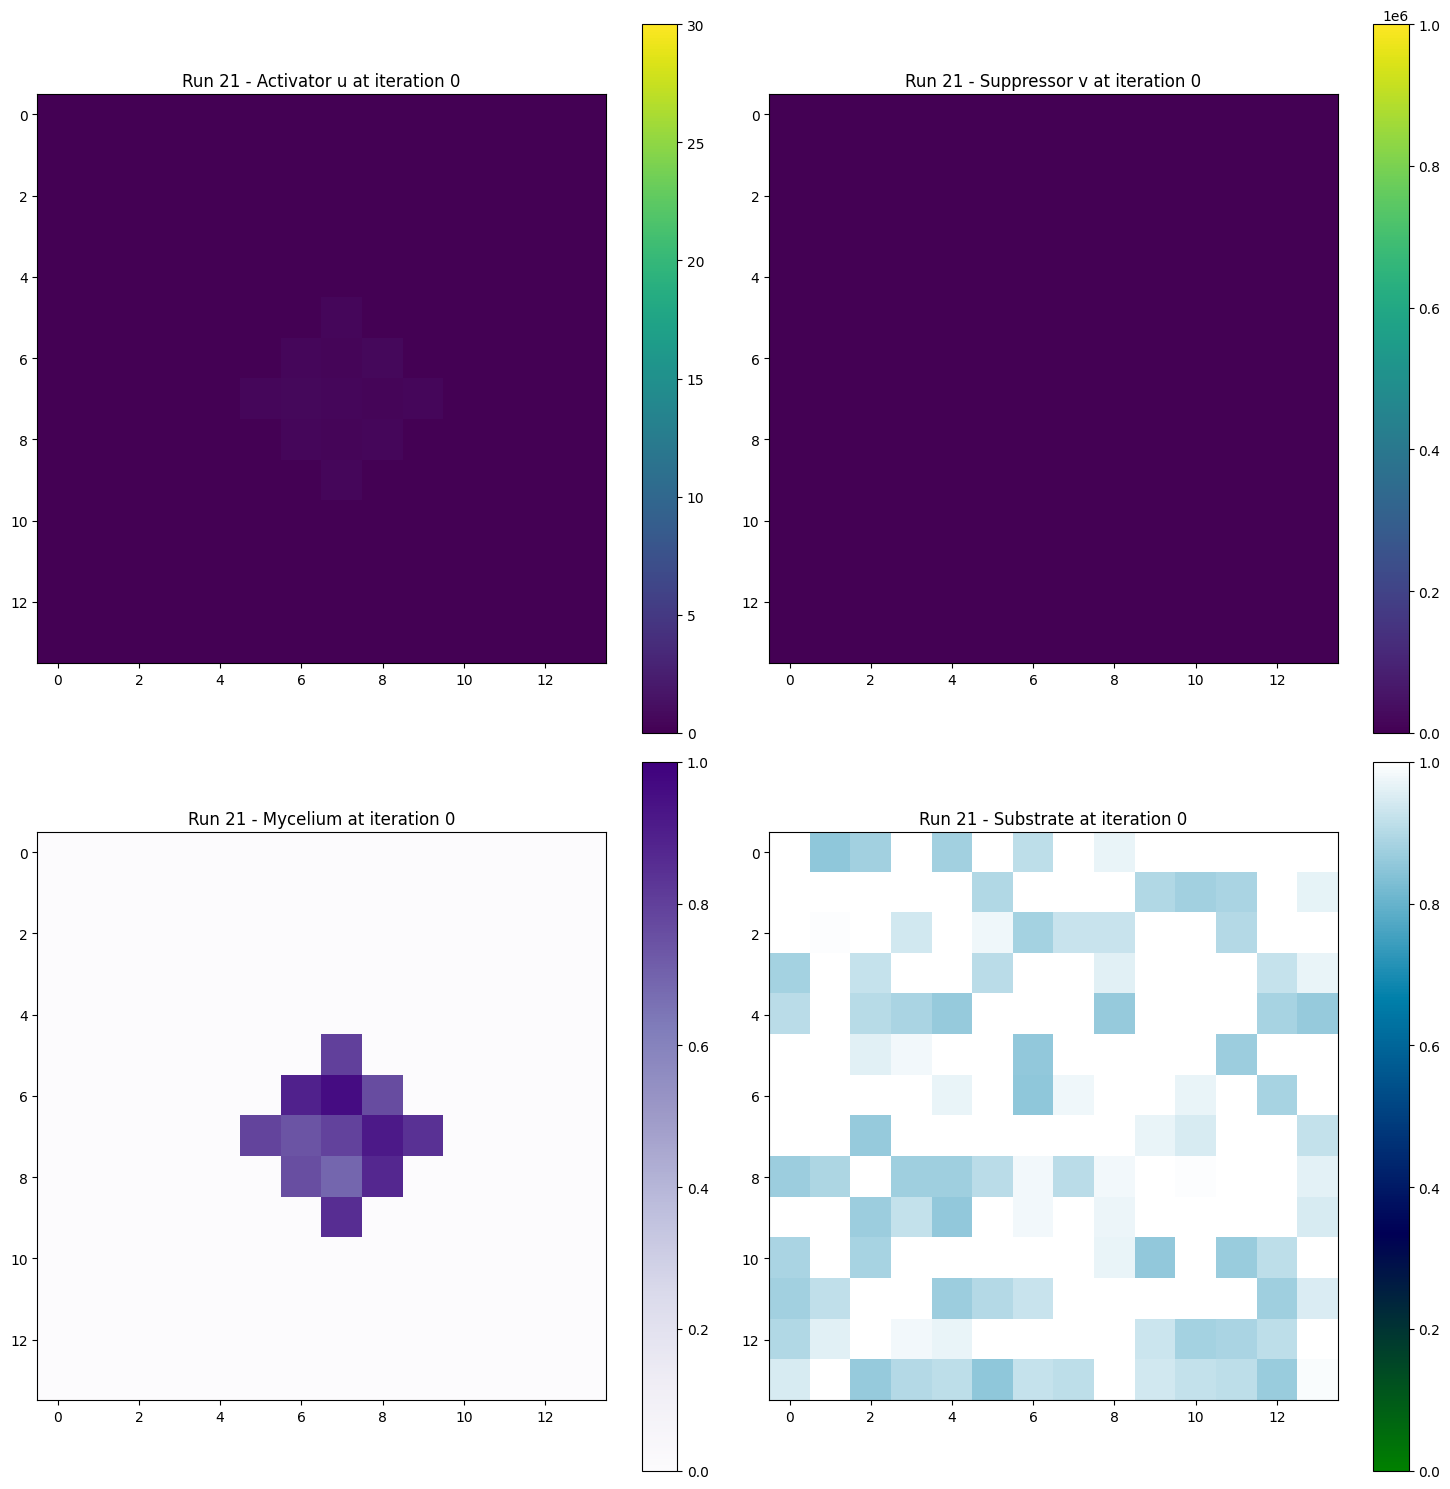

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_20_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_20_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_20_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_20_step_10000.csv using NumPy with double precision.


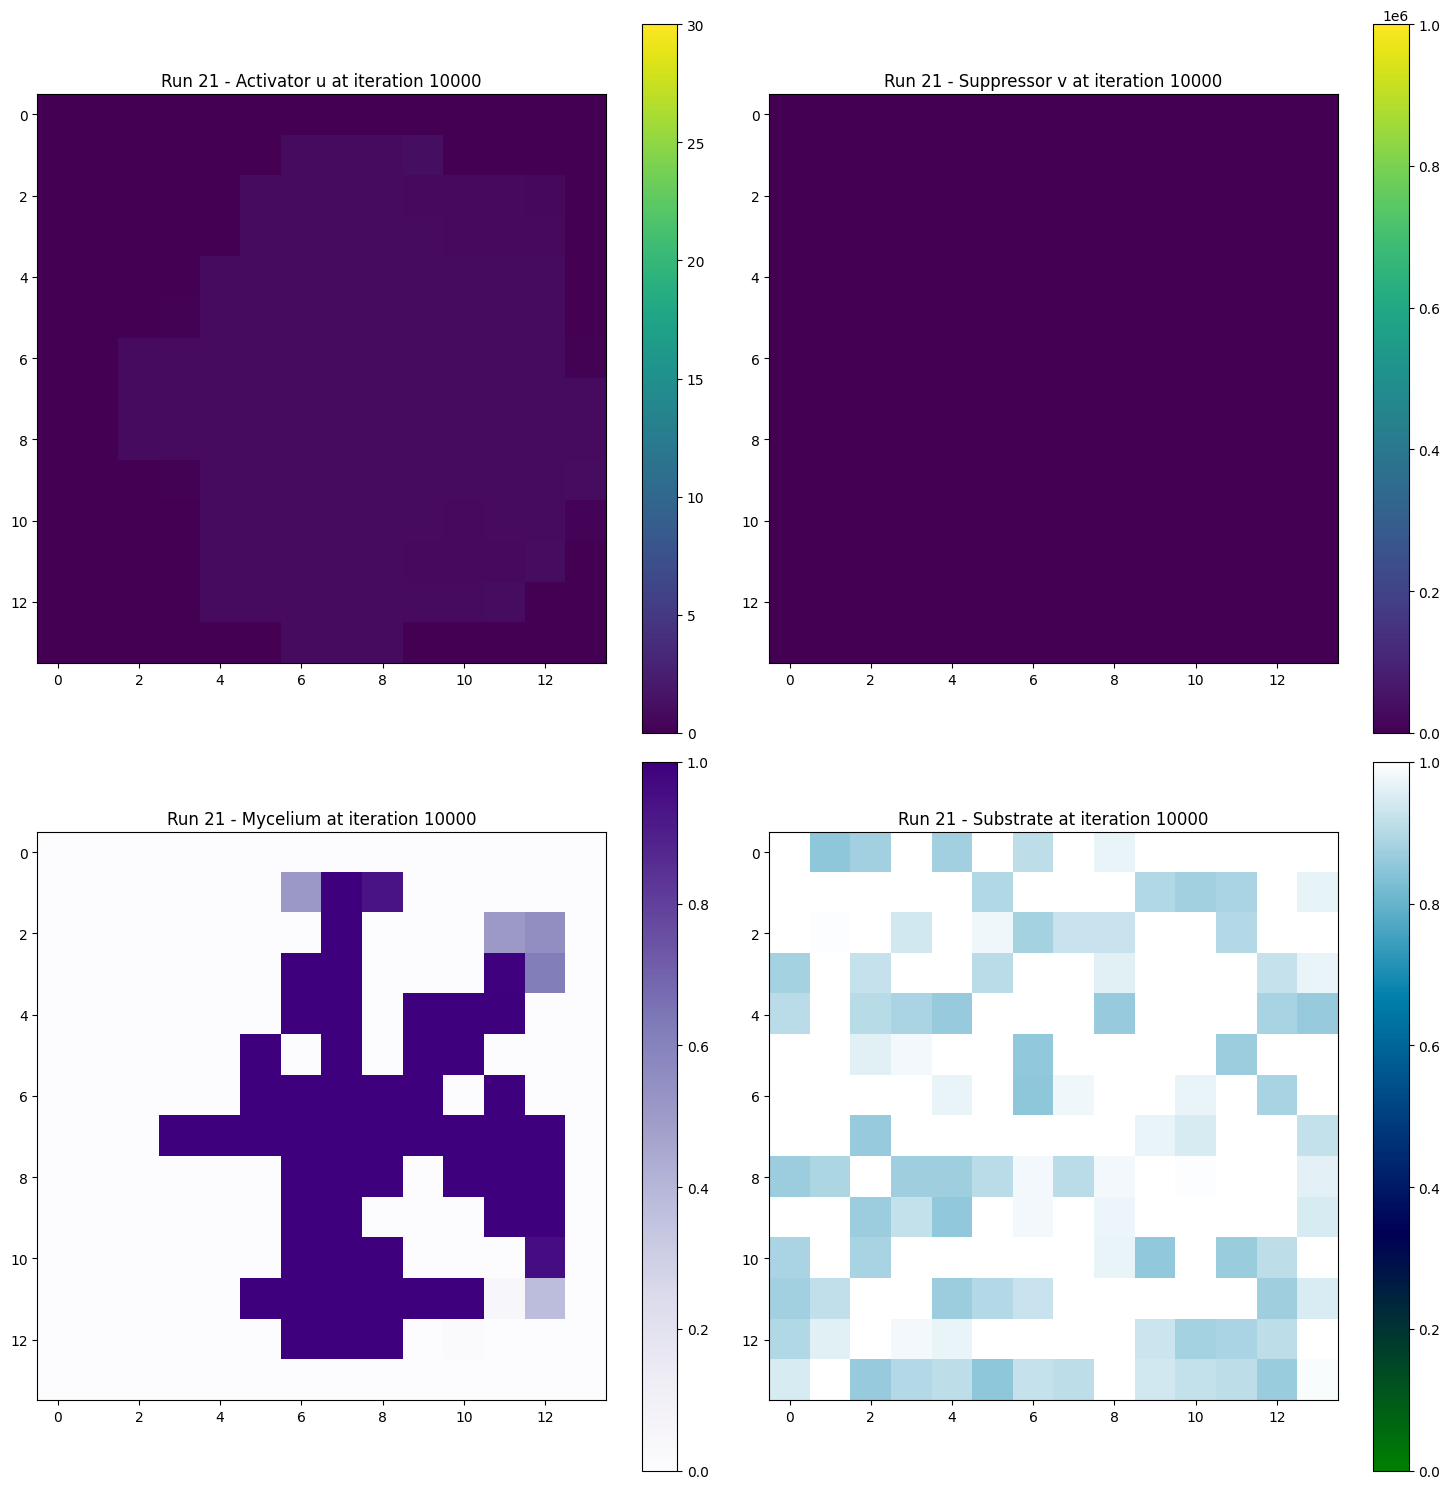

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_21_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_21_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_21_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_21_step_0.csv using NumPy with double precision.


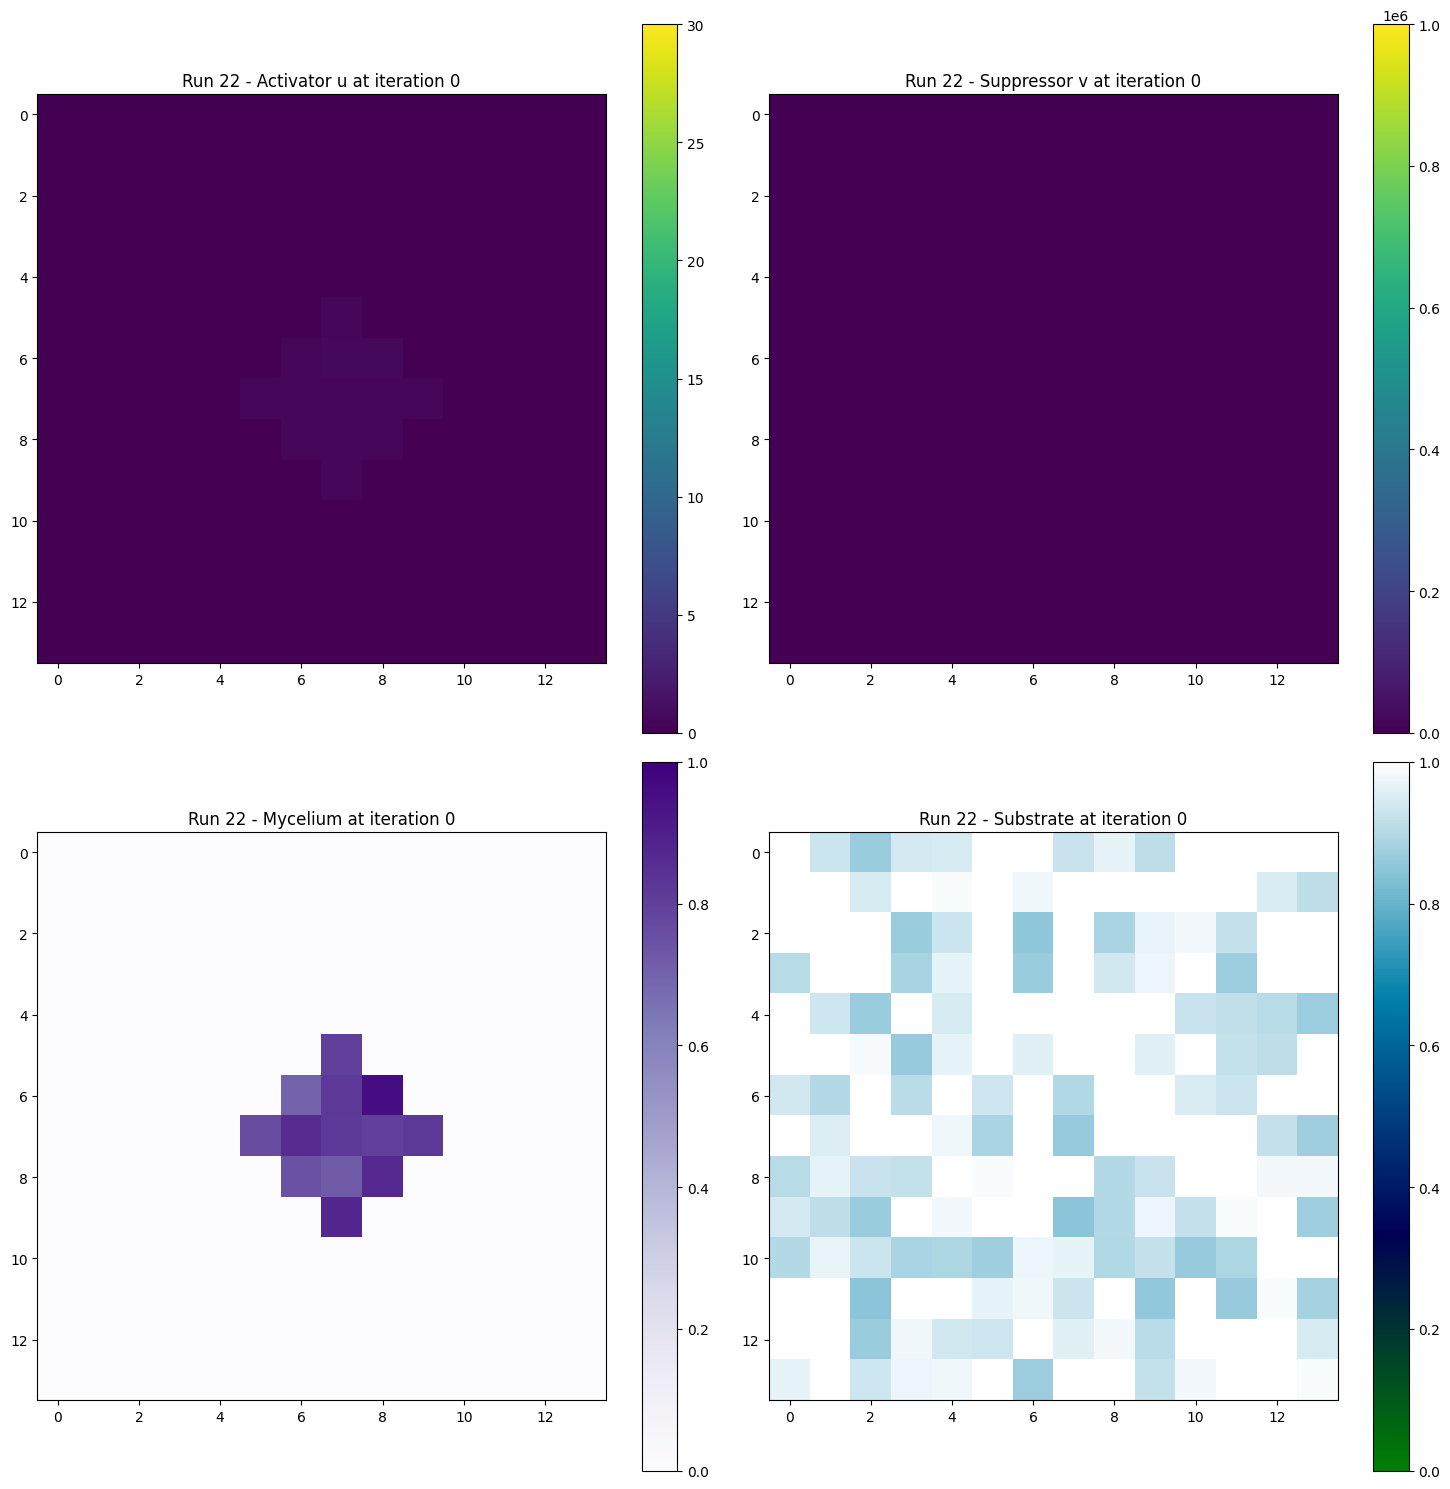

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_21_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_21_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_21_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_21_step_10000.csv using NumPy with double precision.


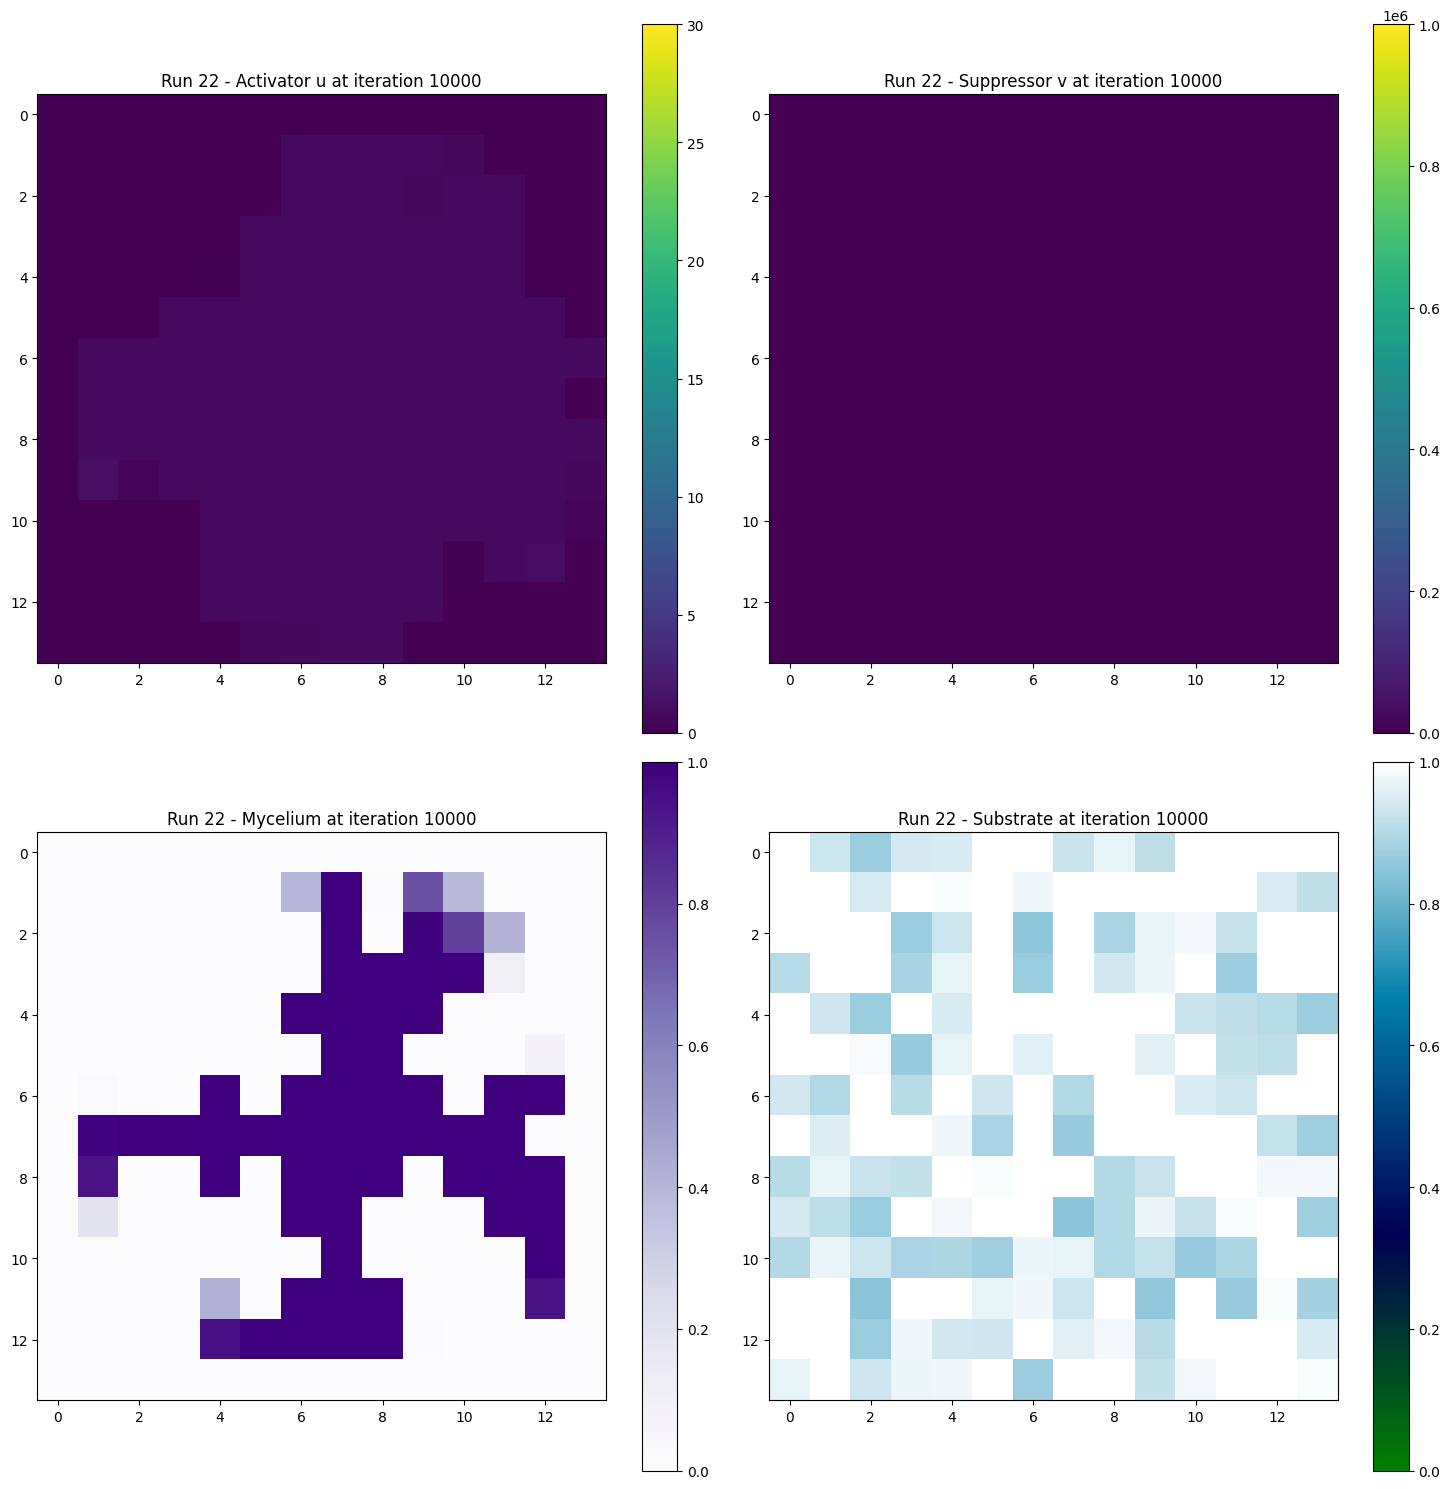

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_22_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_22_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_22_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_22_step_0.csv using NumPy with double precision.


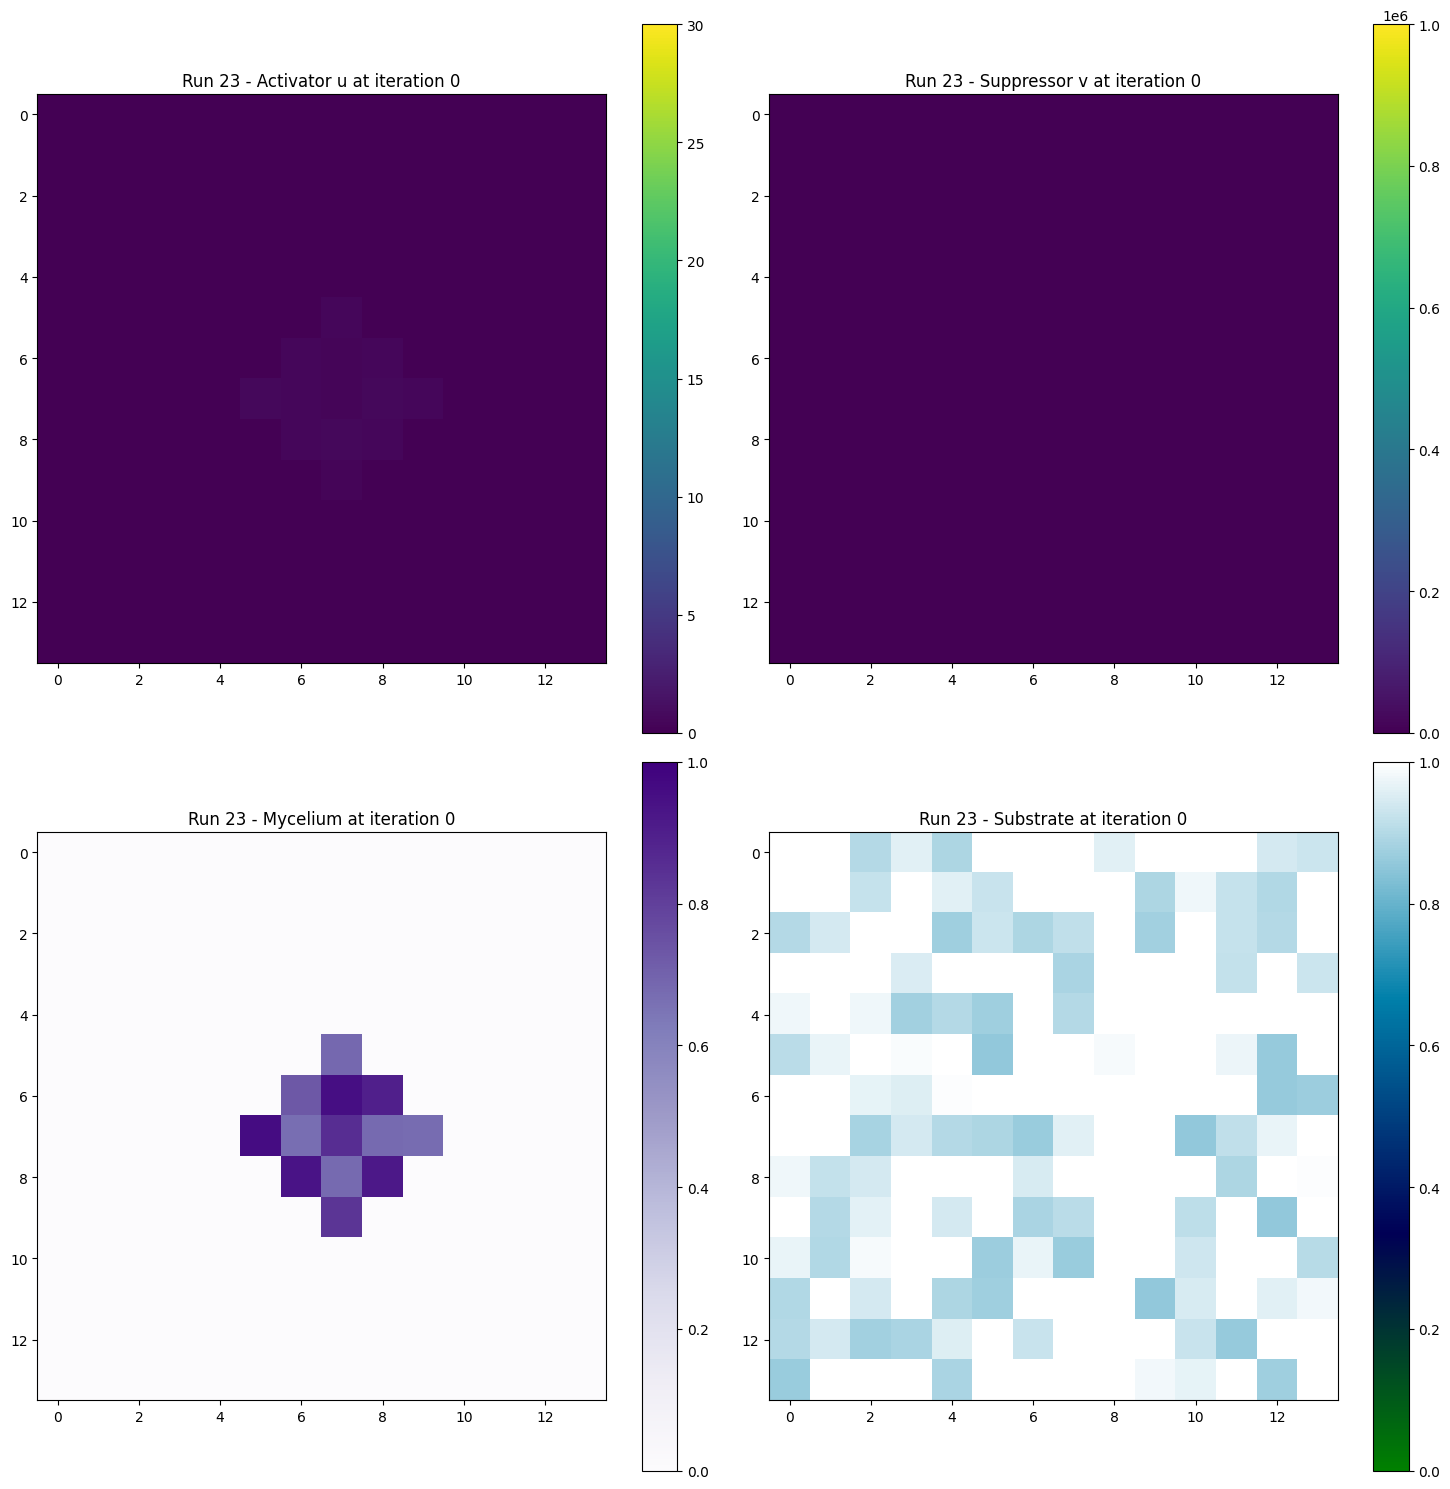

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_22_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_22_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_22_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_22_step_10000.csv using NumPy with double precision.


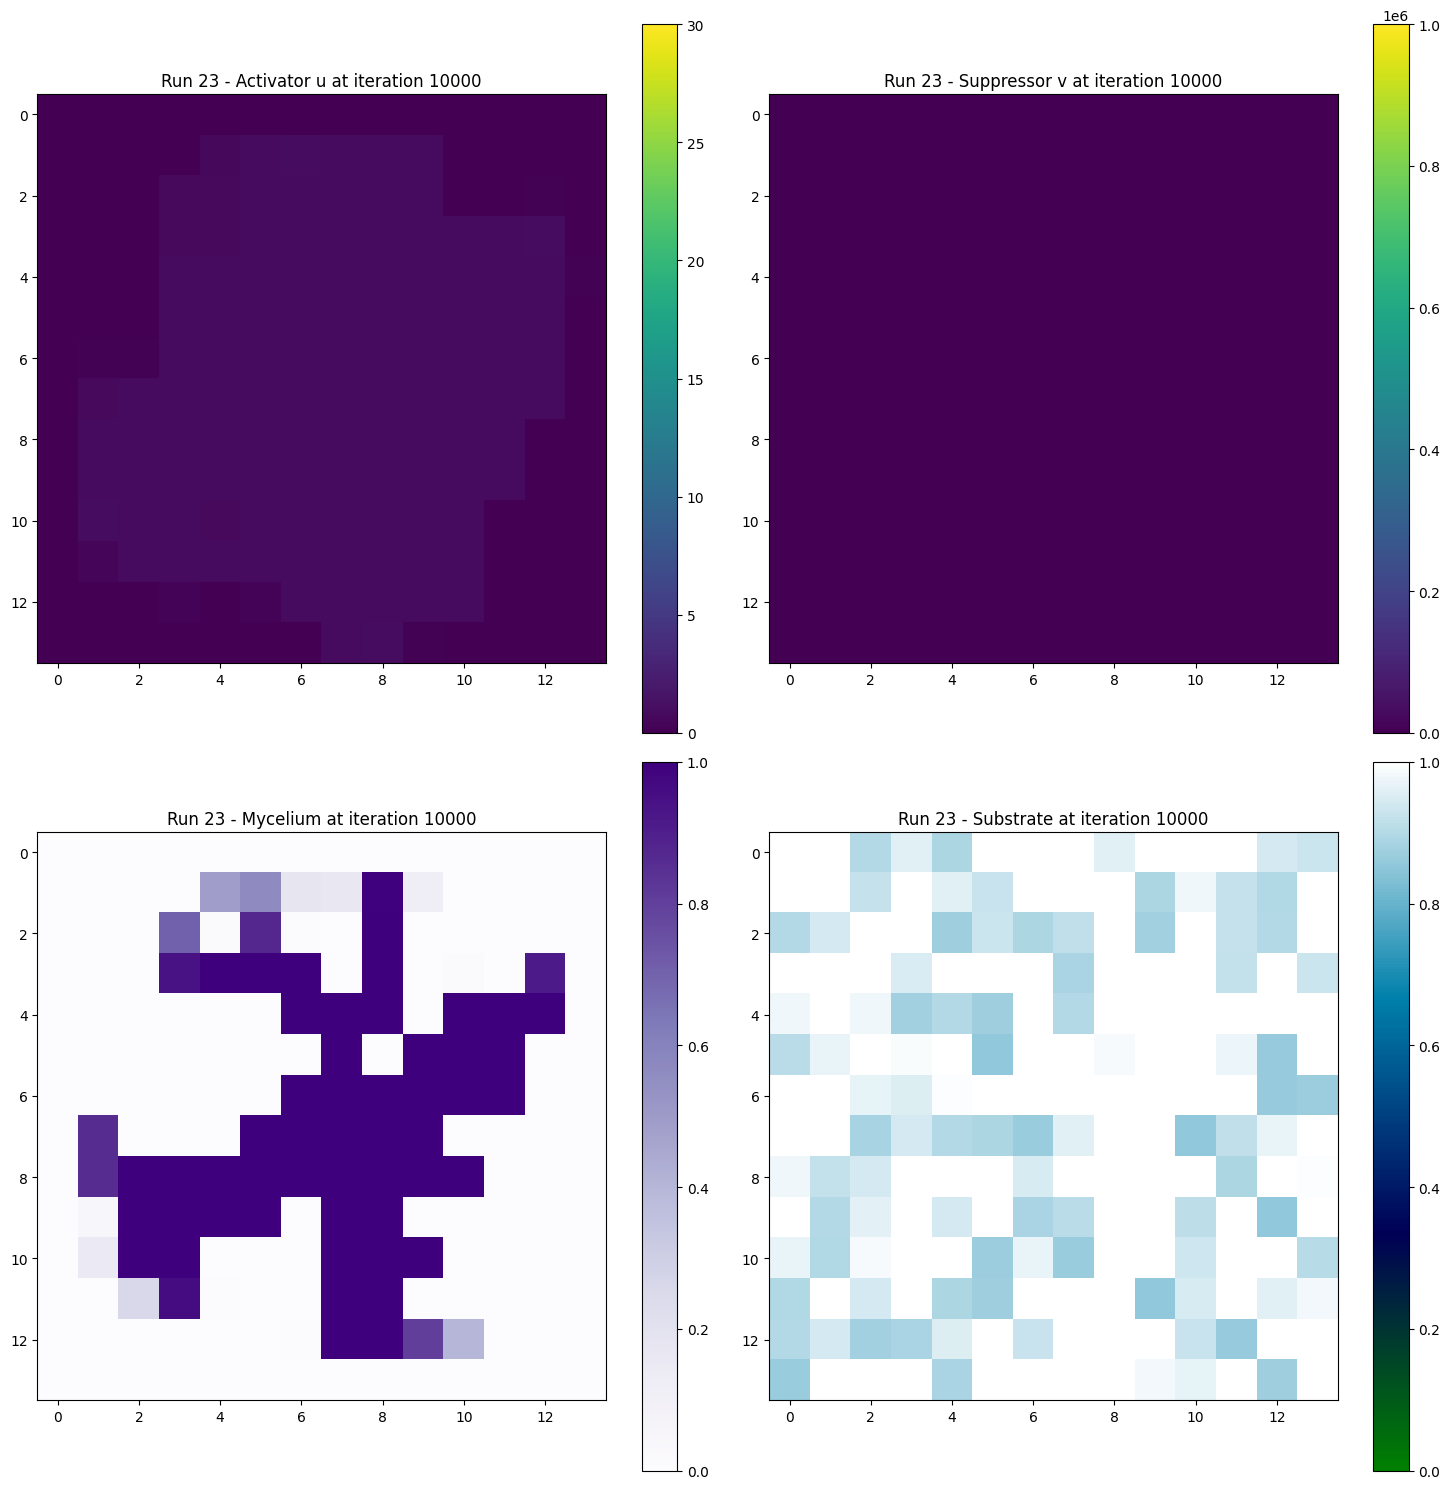

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_23_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_23_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_23_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_23_step_0.csv using NumPy with double precision.


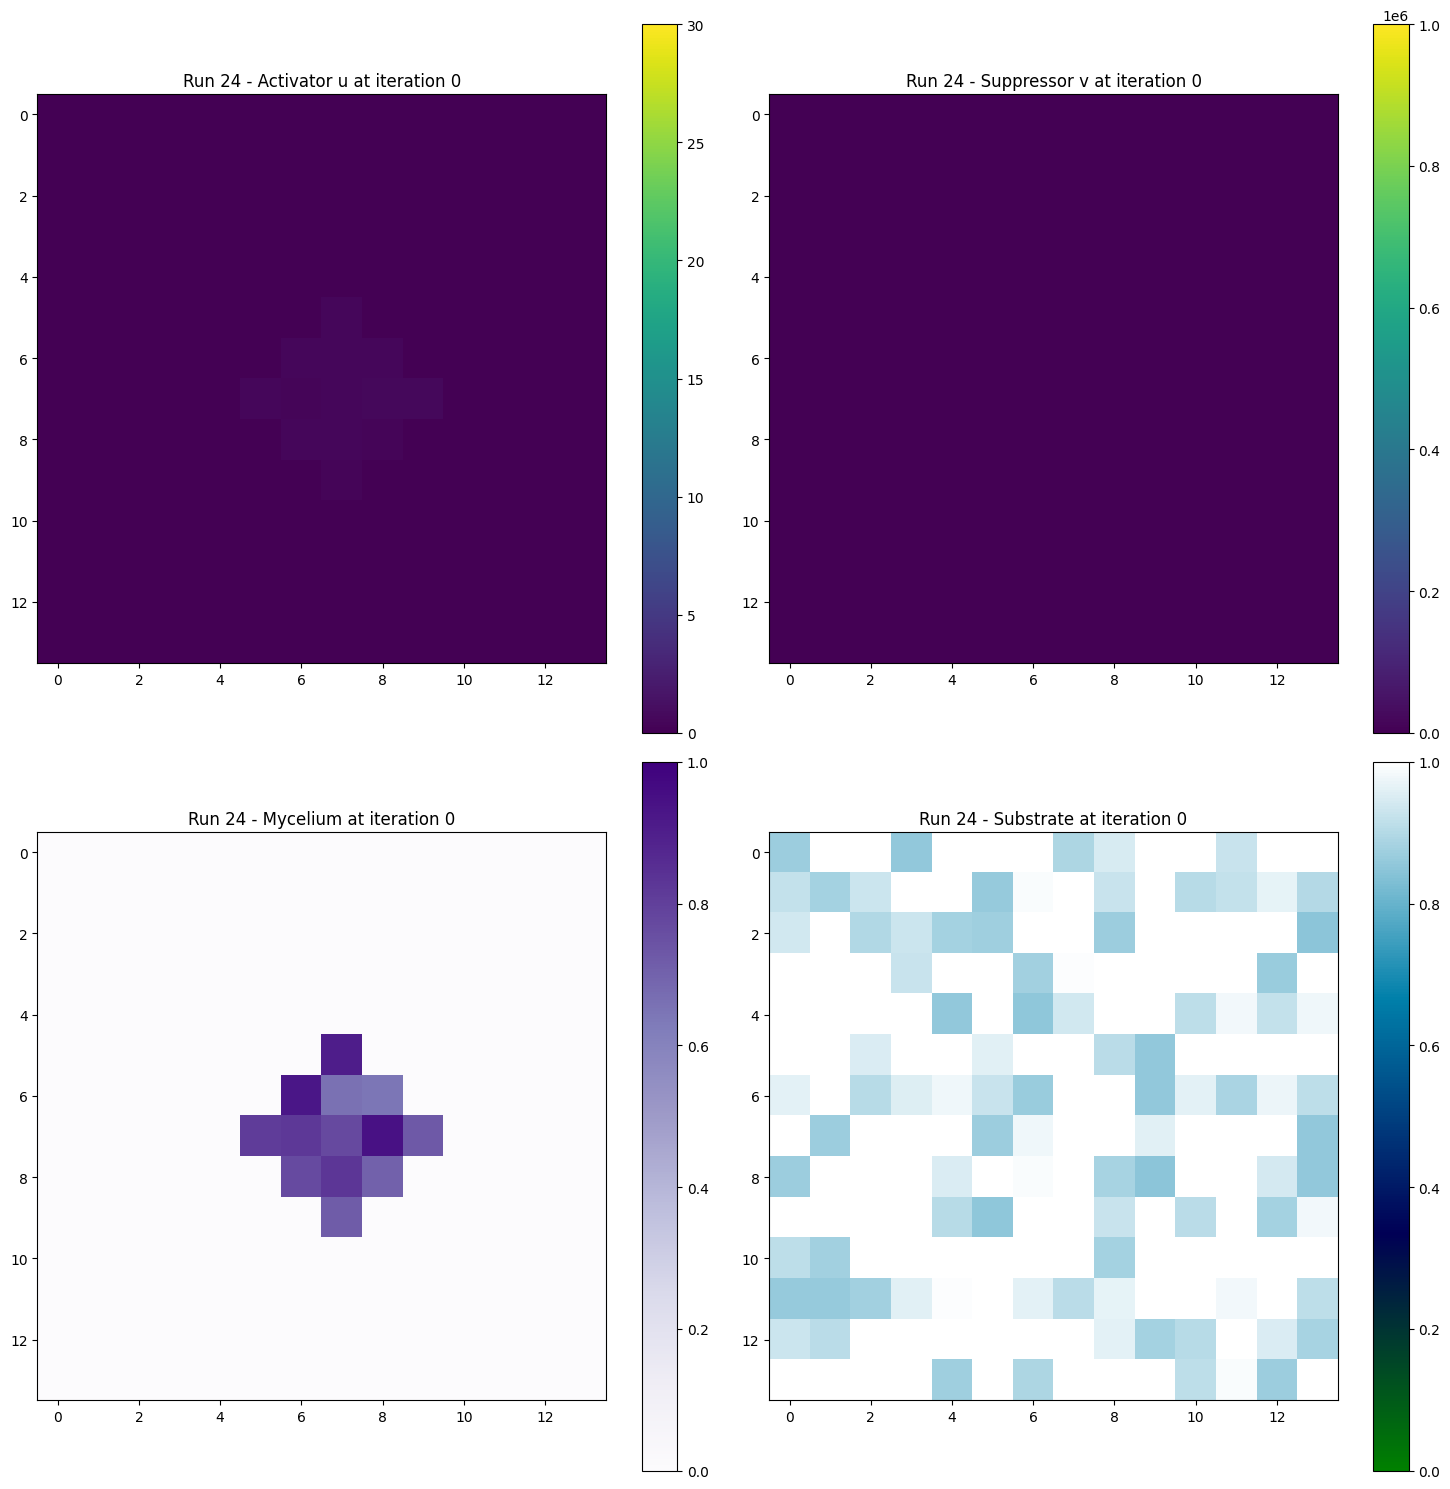

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_23_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_23_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_23_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_23_step_10000.csv using NumPy with double precision.


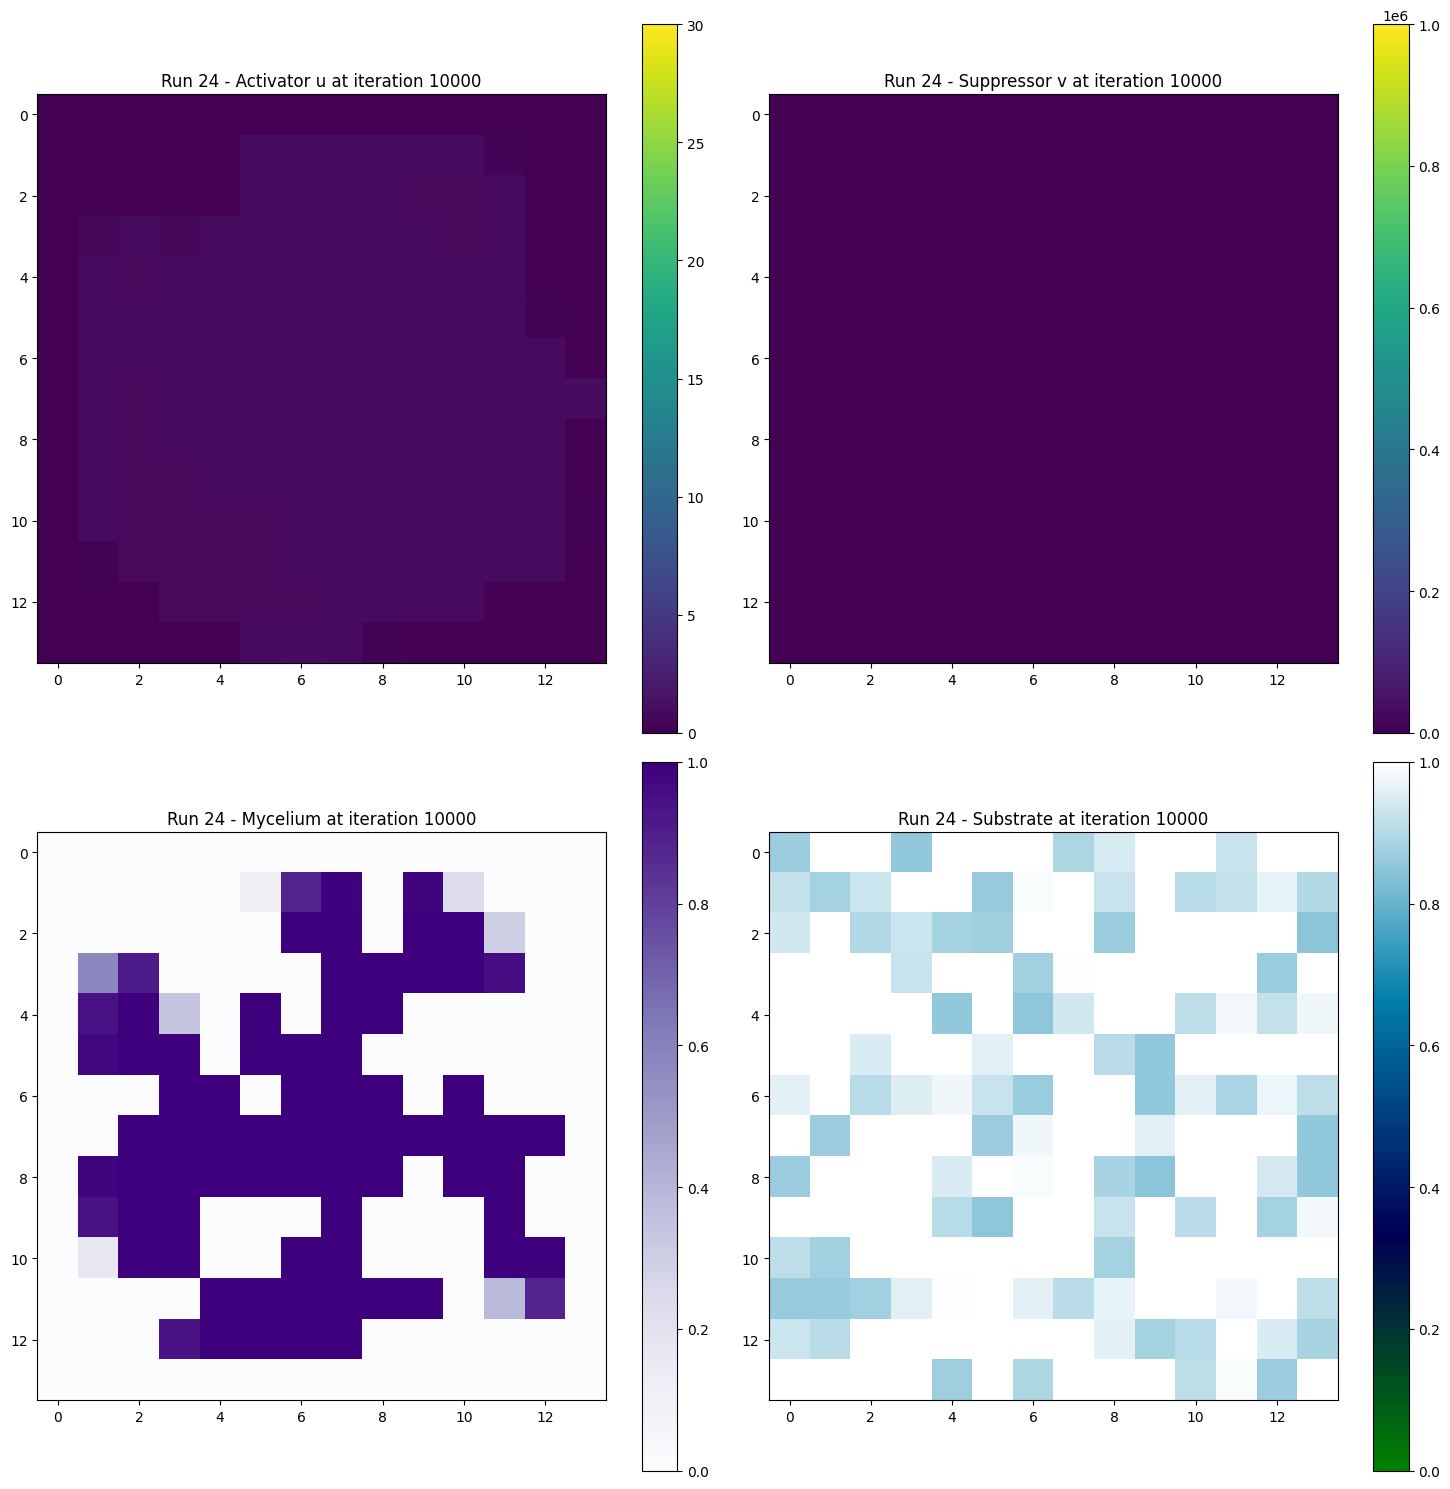

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_24_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_24_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_24_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_24_step_0.csv using NumPy with double precision.


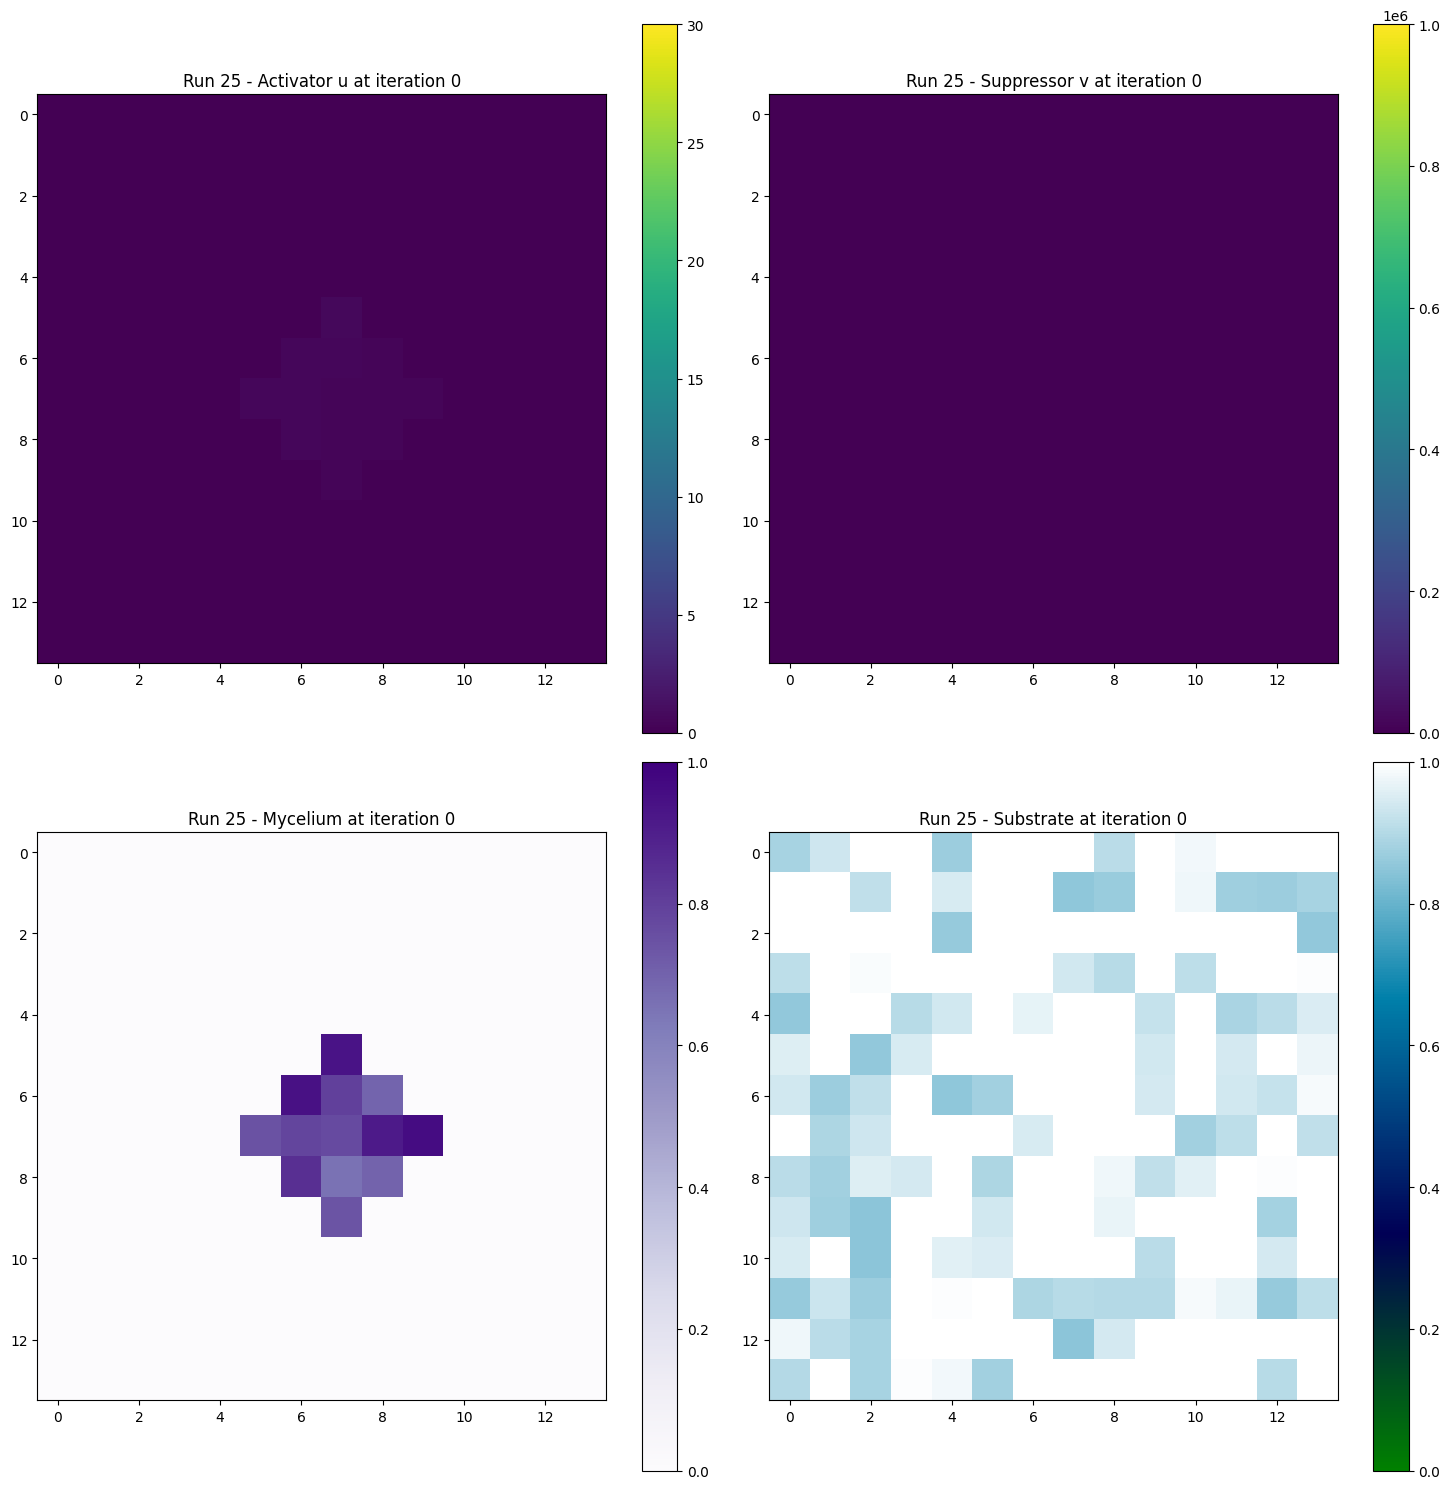

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_24_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_24_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_24_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_24_step_10000.csv using NumPy with double precision.


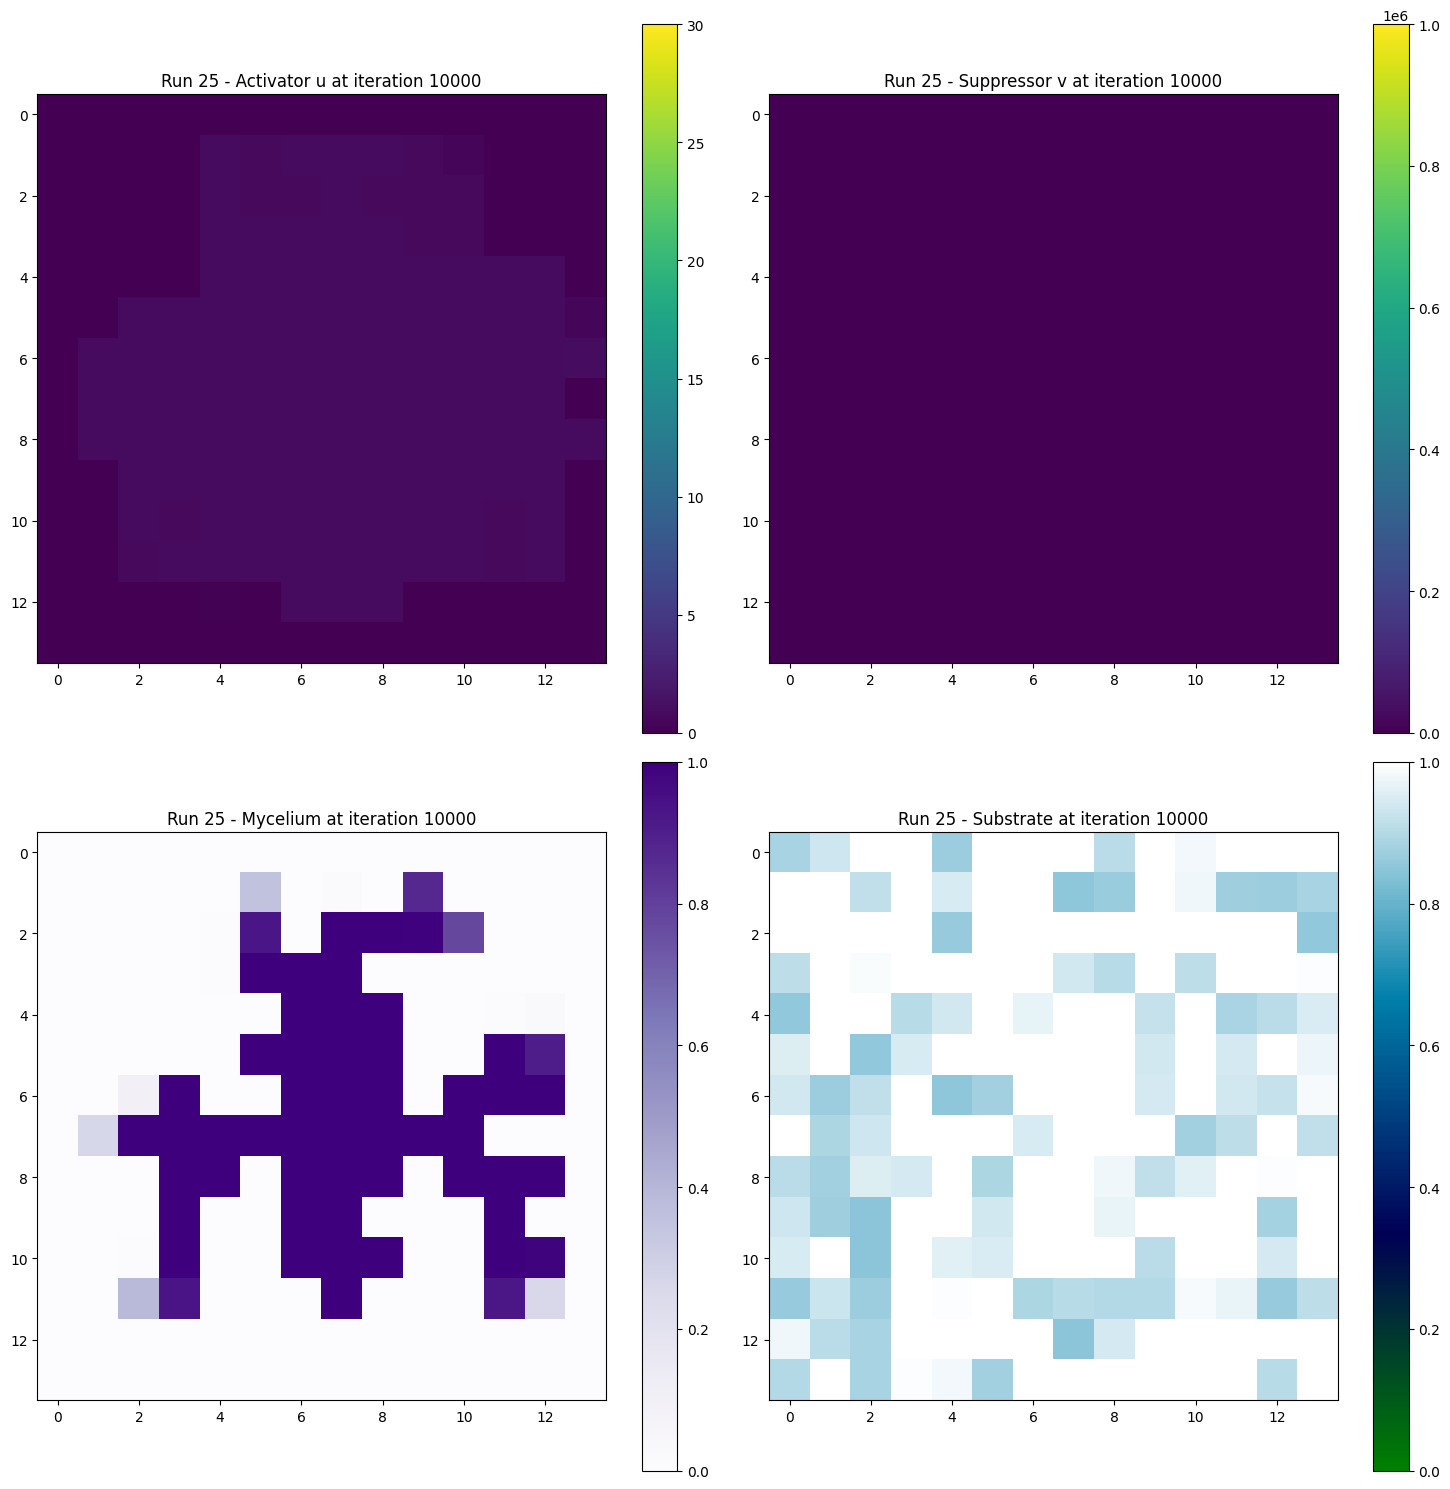

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_25_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_25_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_25_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_25_step_0.csv using NumPy with double precision.


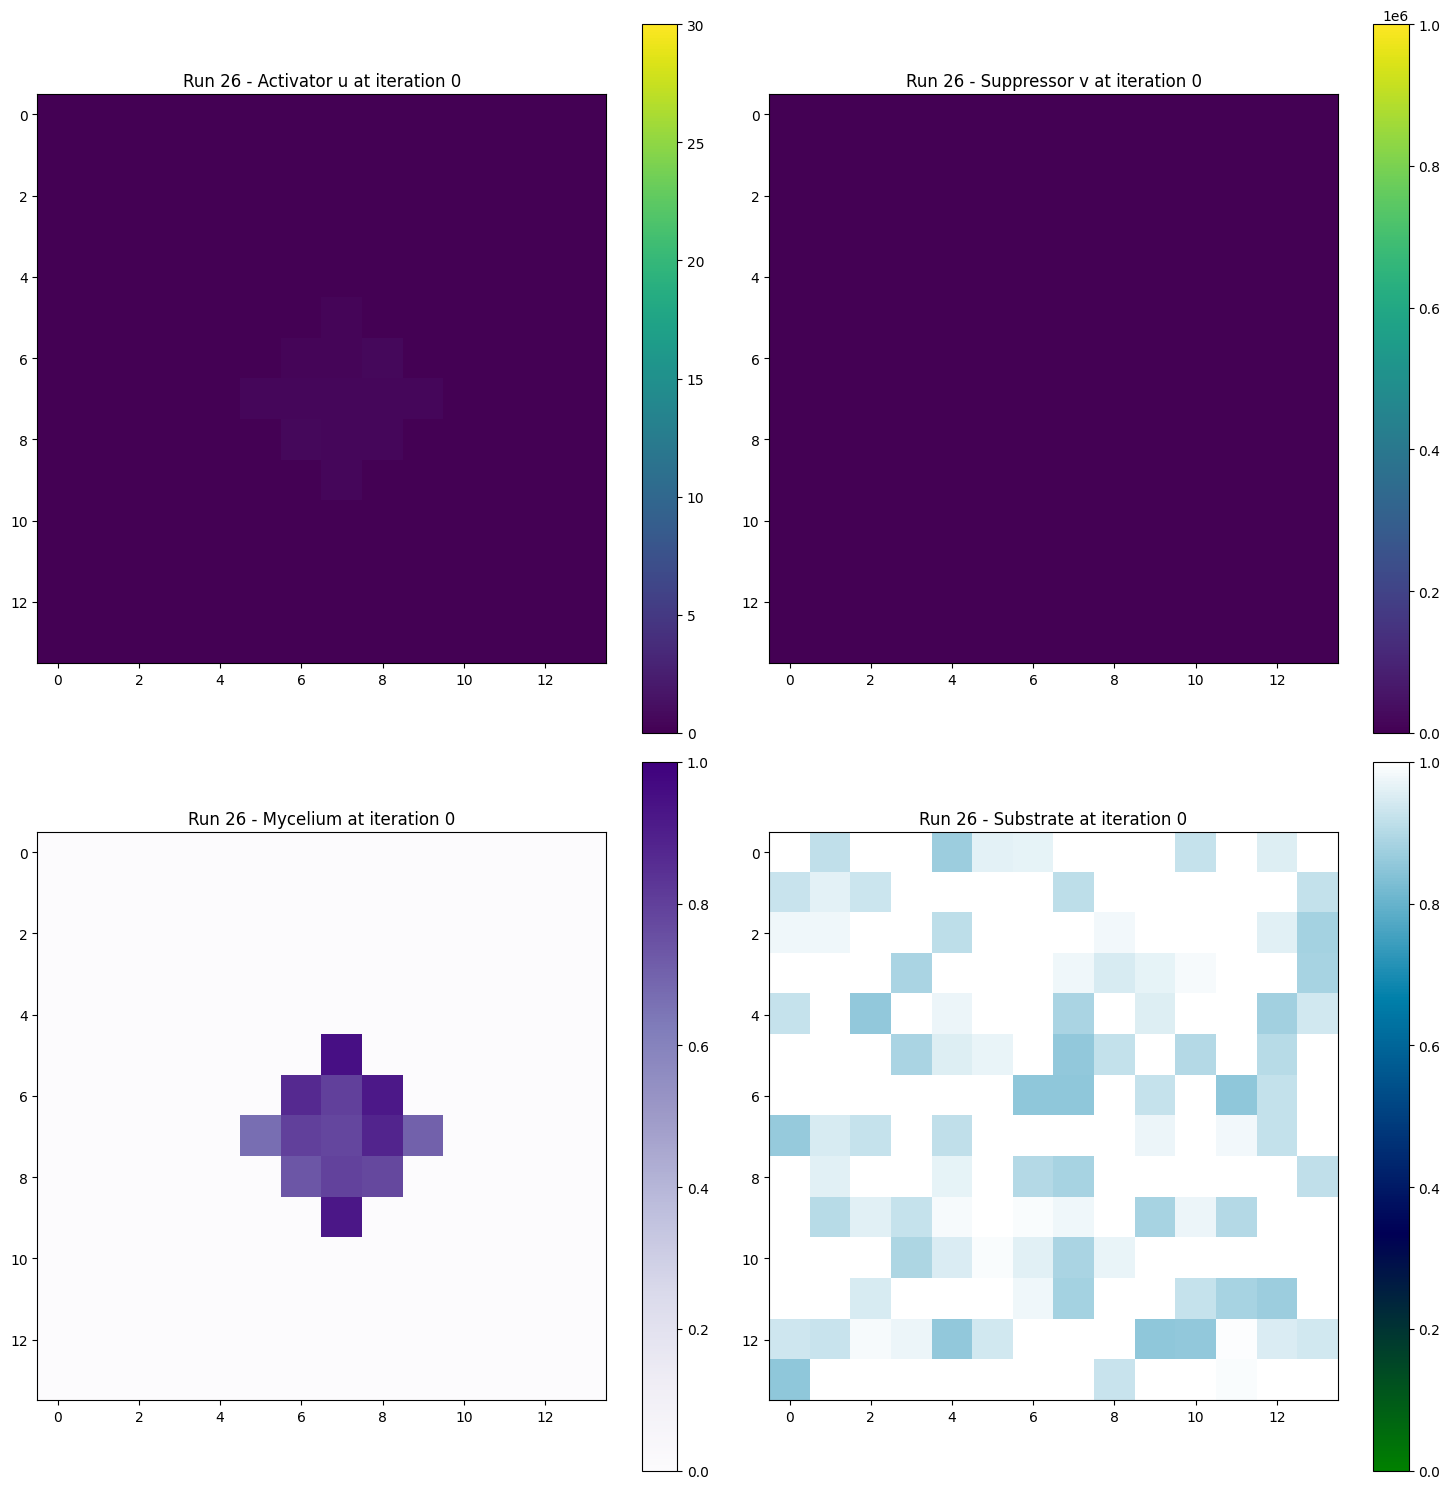

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_25_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_25_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_25_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_25_step_10000.csv using NumPy with double precision.


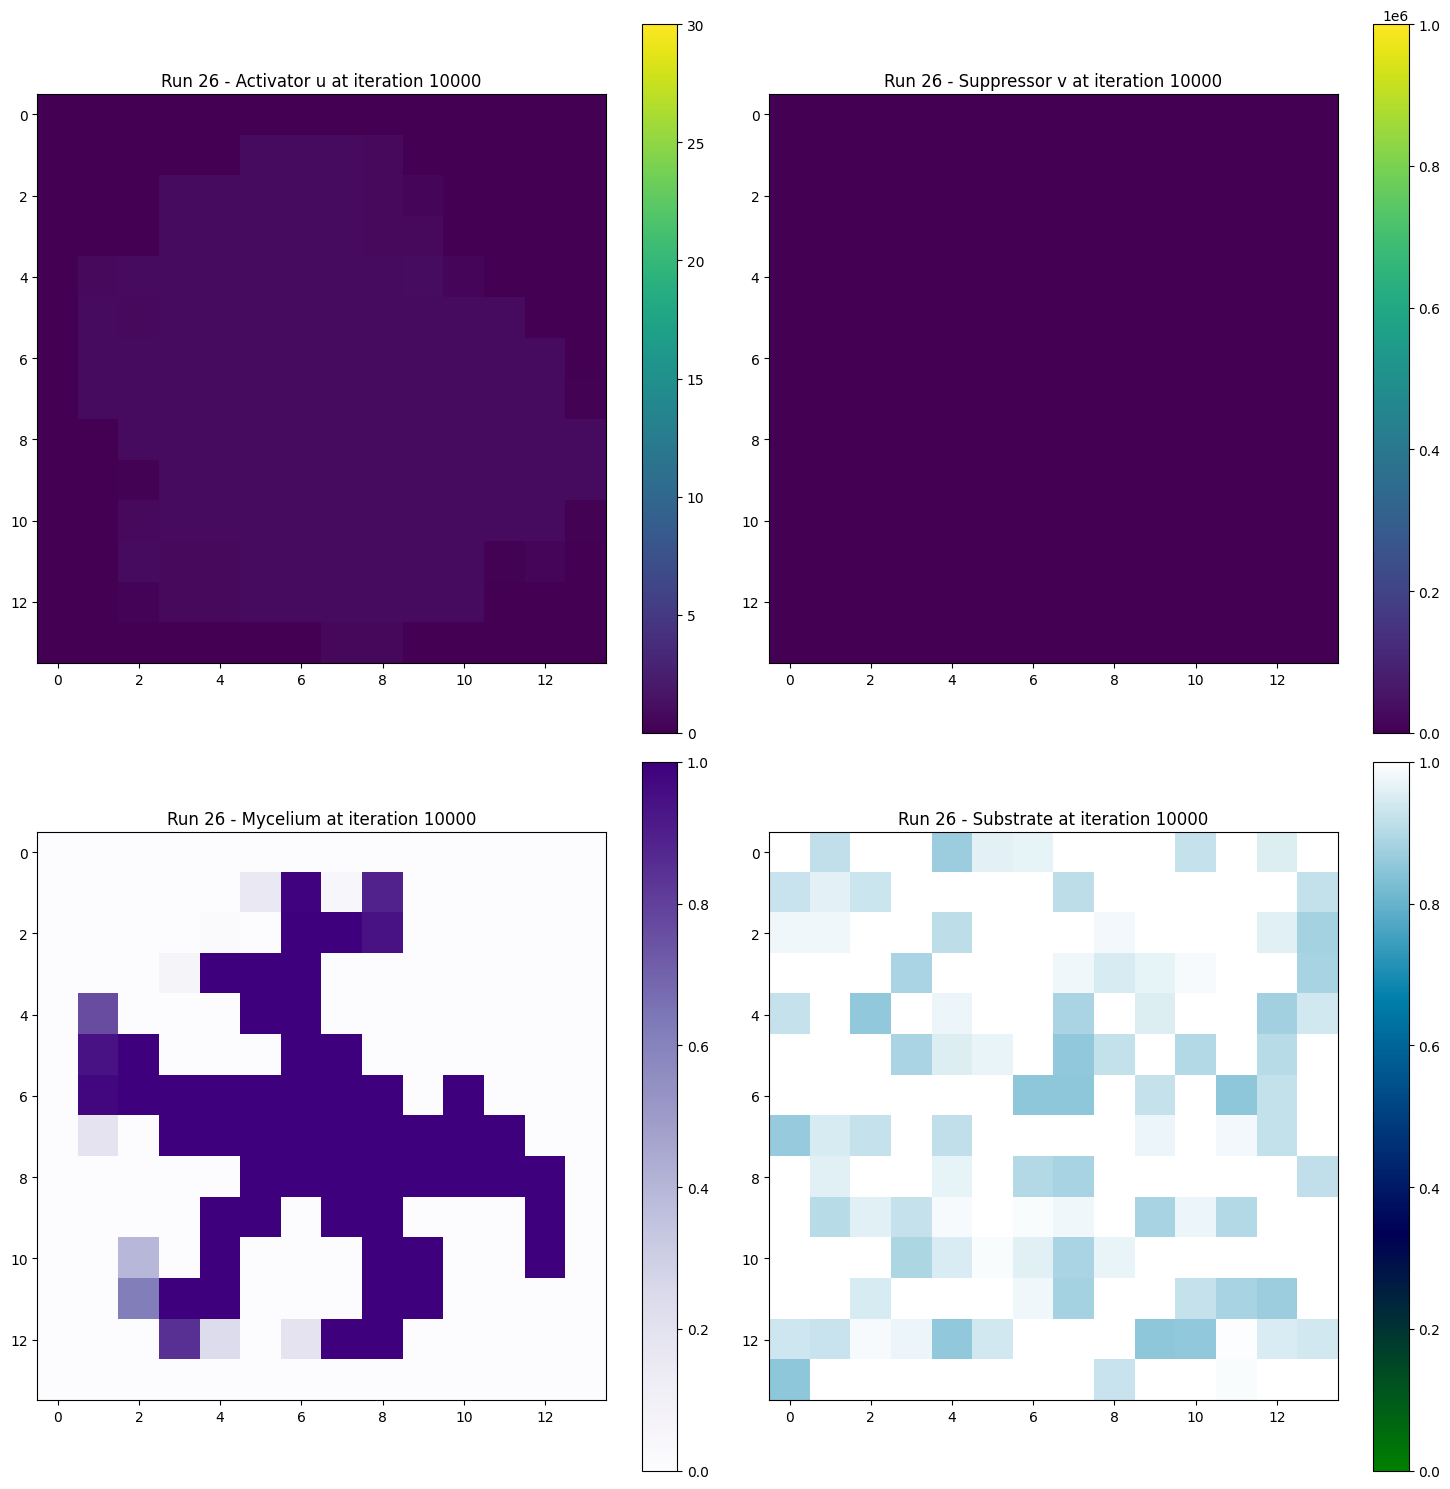

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_26_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_26_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_26_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_26_step_0.csv using NumPy with double precision.


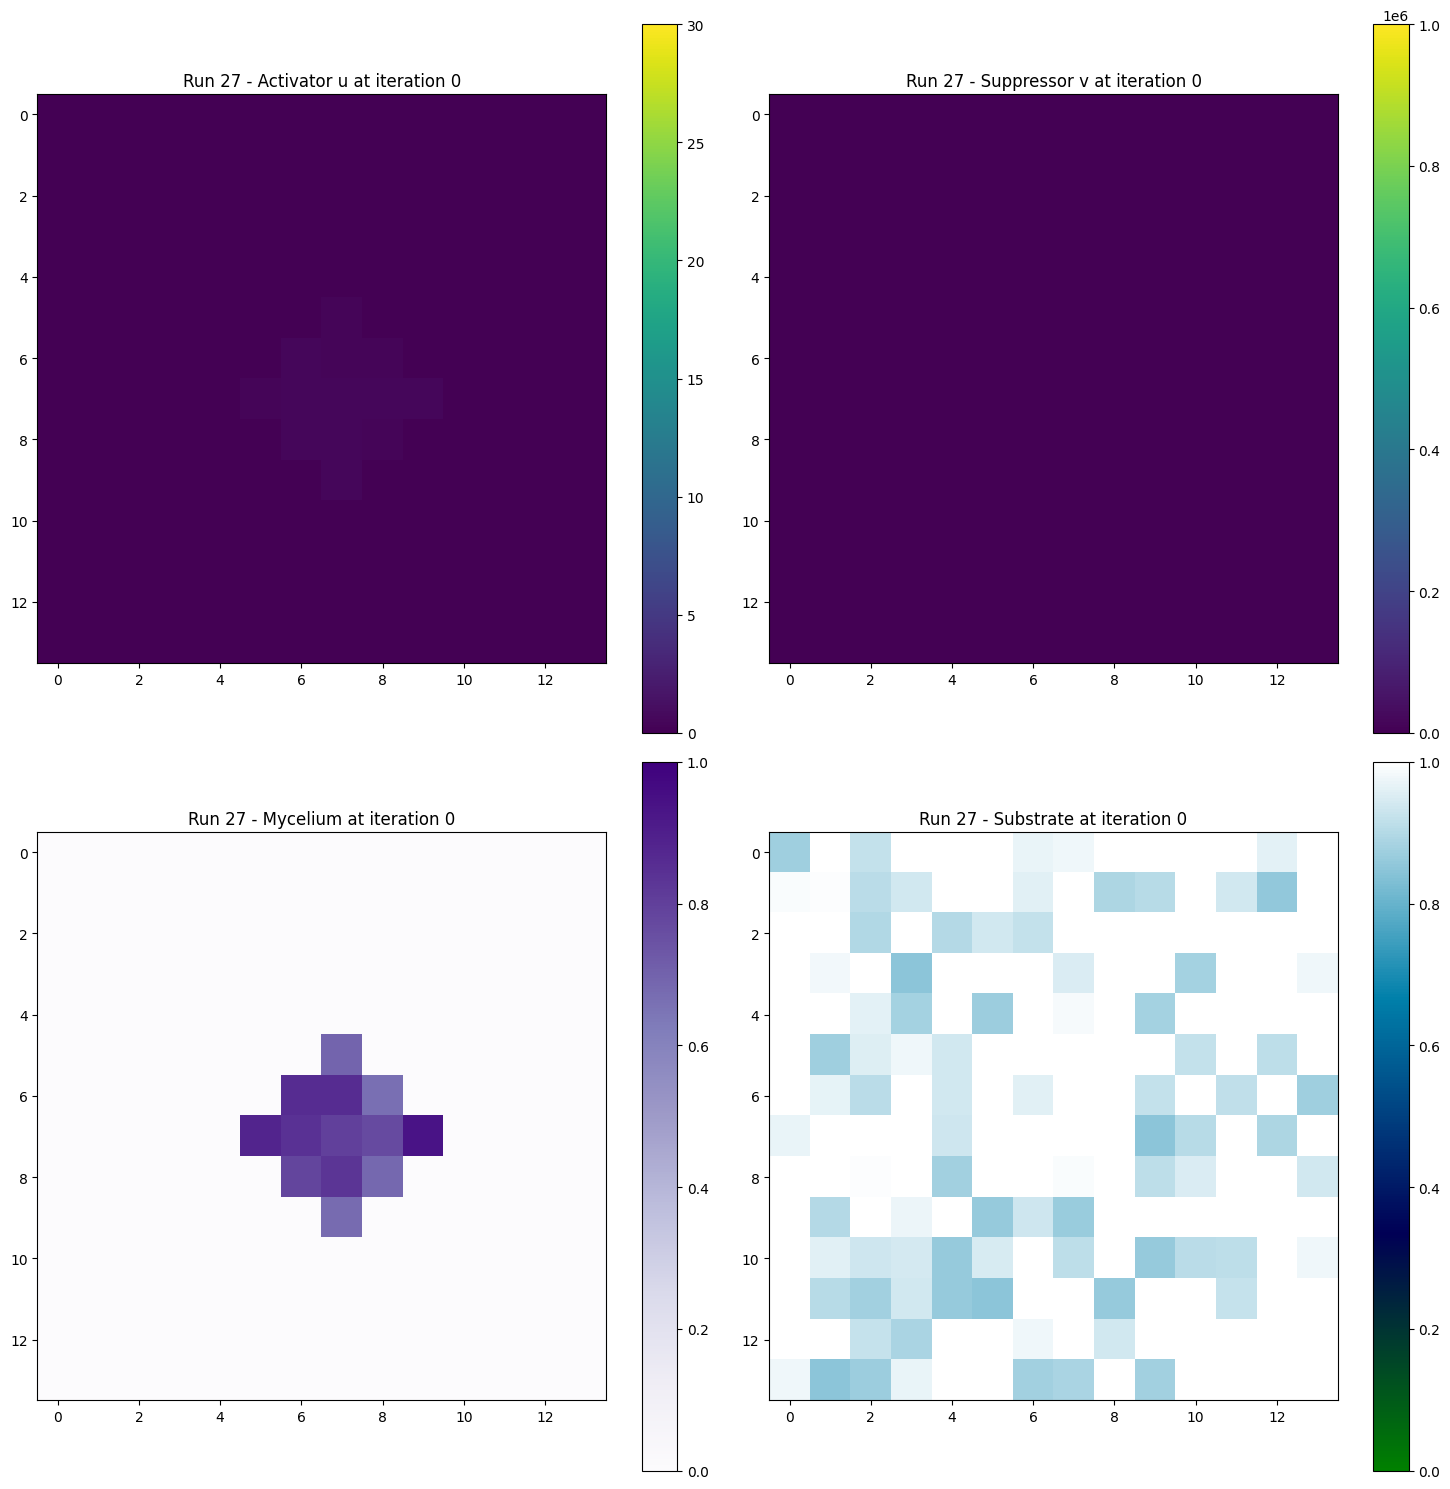

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_26_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_26_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_26_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_26_step_10000.csv using NumPy with double precision.


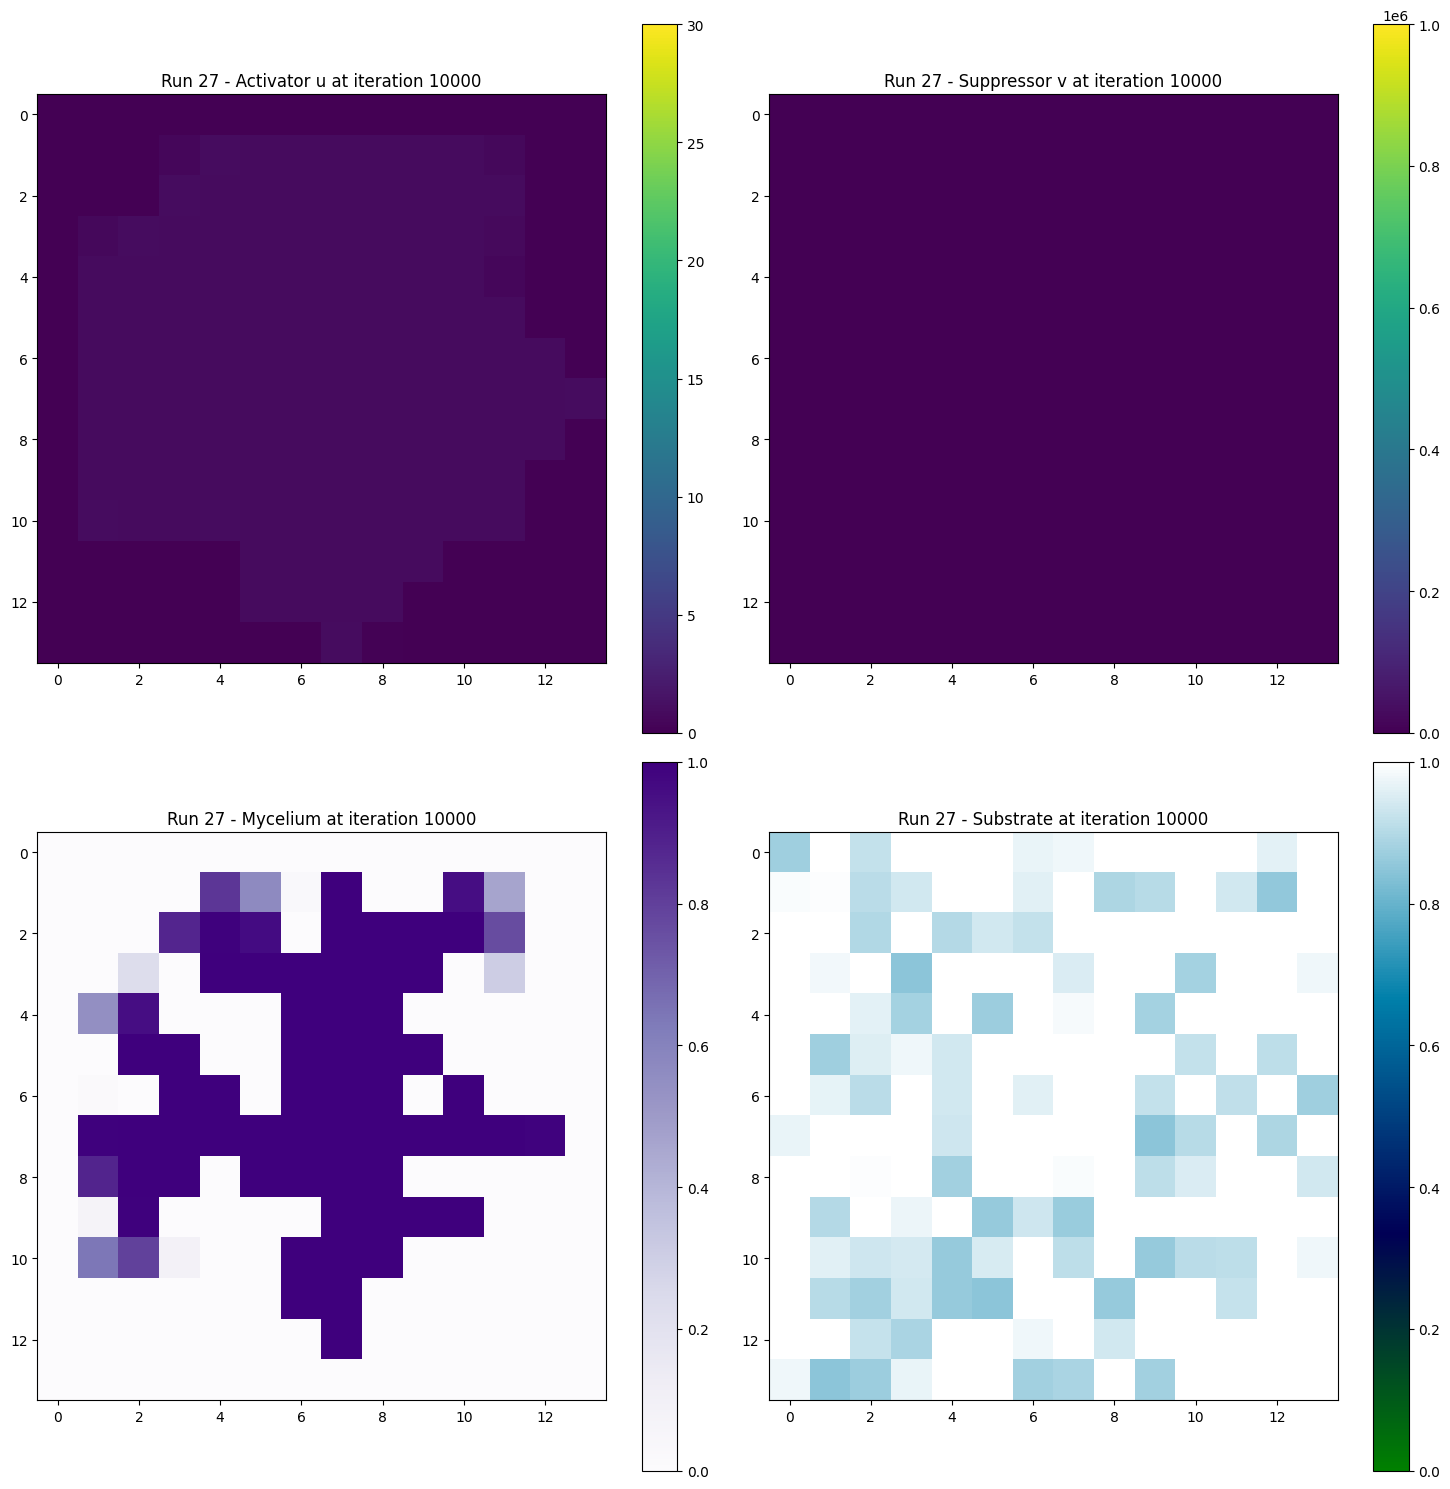

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_27_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_27_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_27_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_27_step_0.csv using NumPy with double precision.


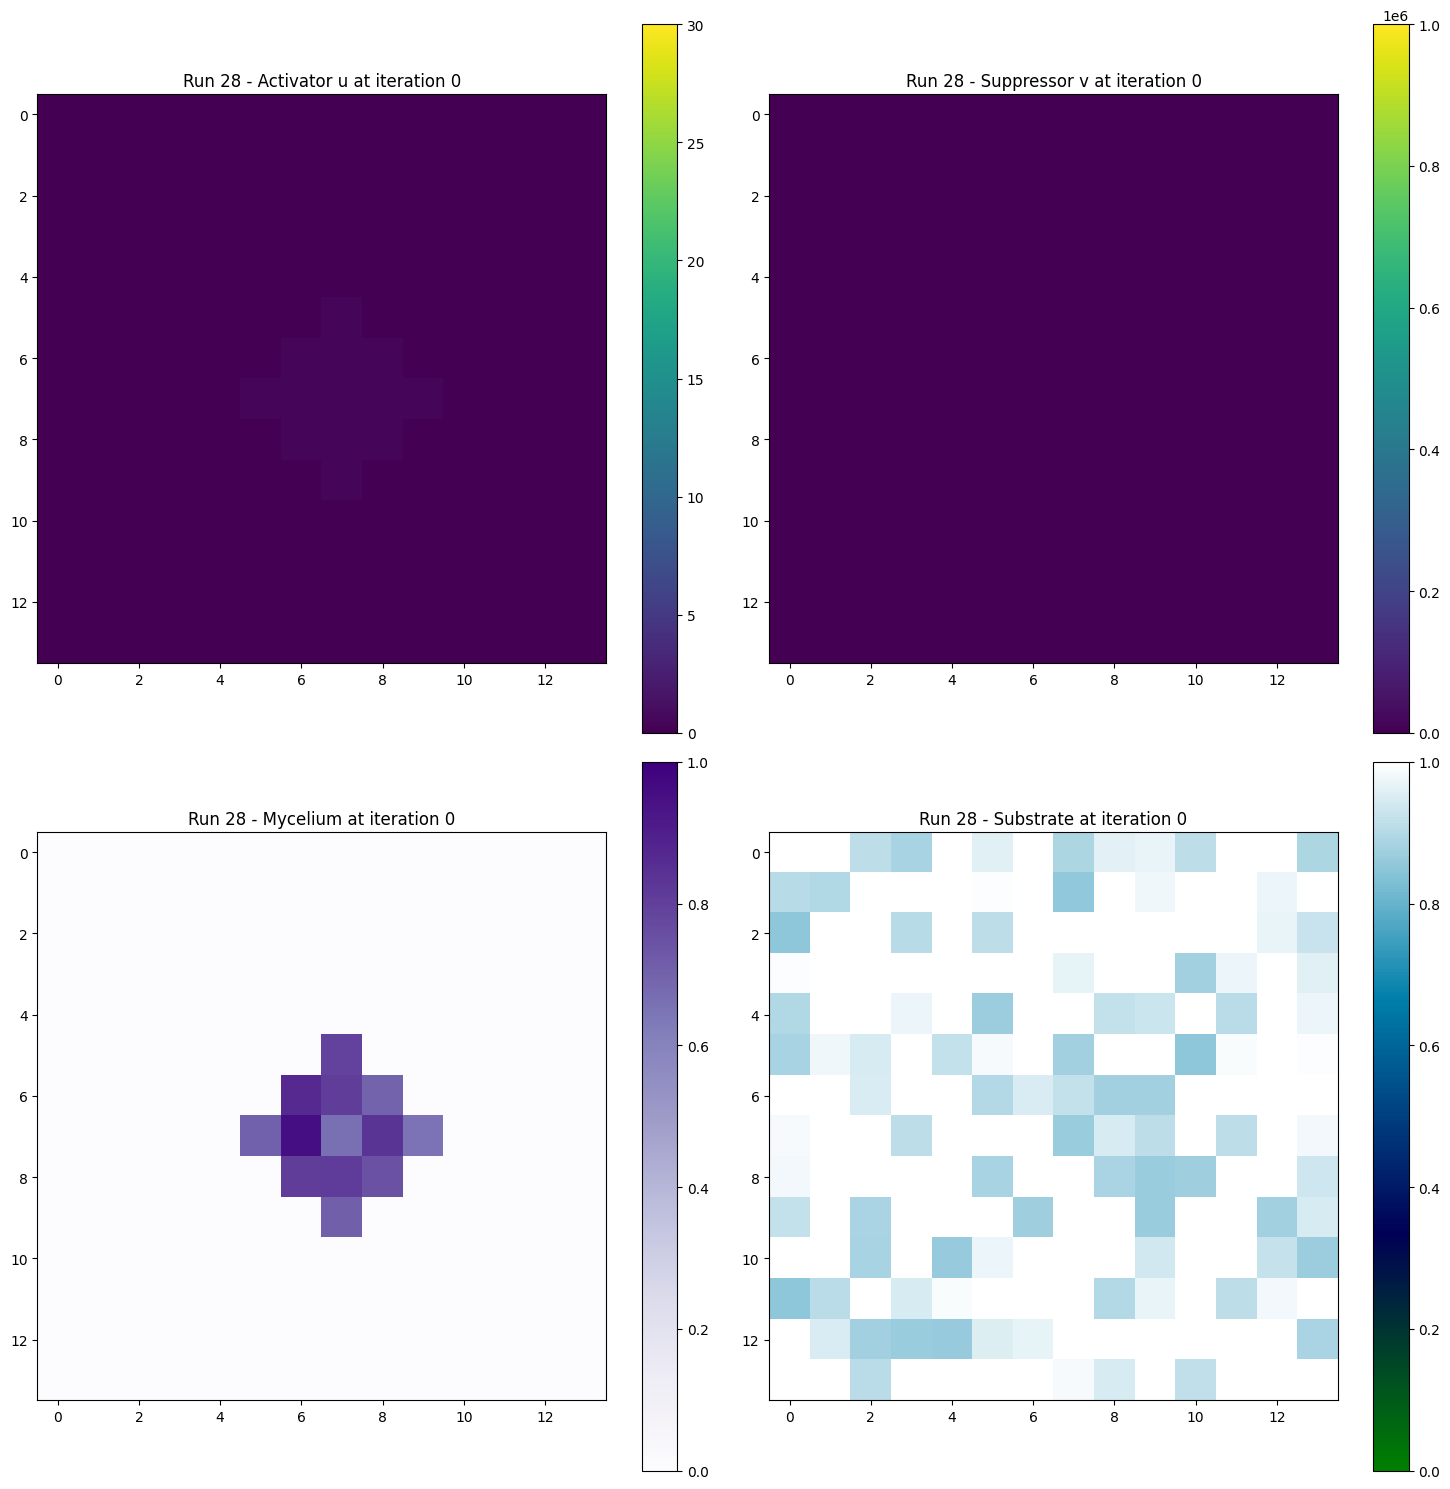

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_27_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_27_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_27_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_27_step_10000.csv using NumPy with double precision.


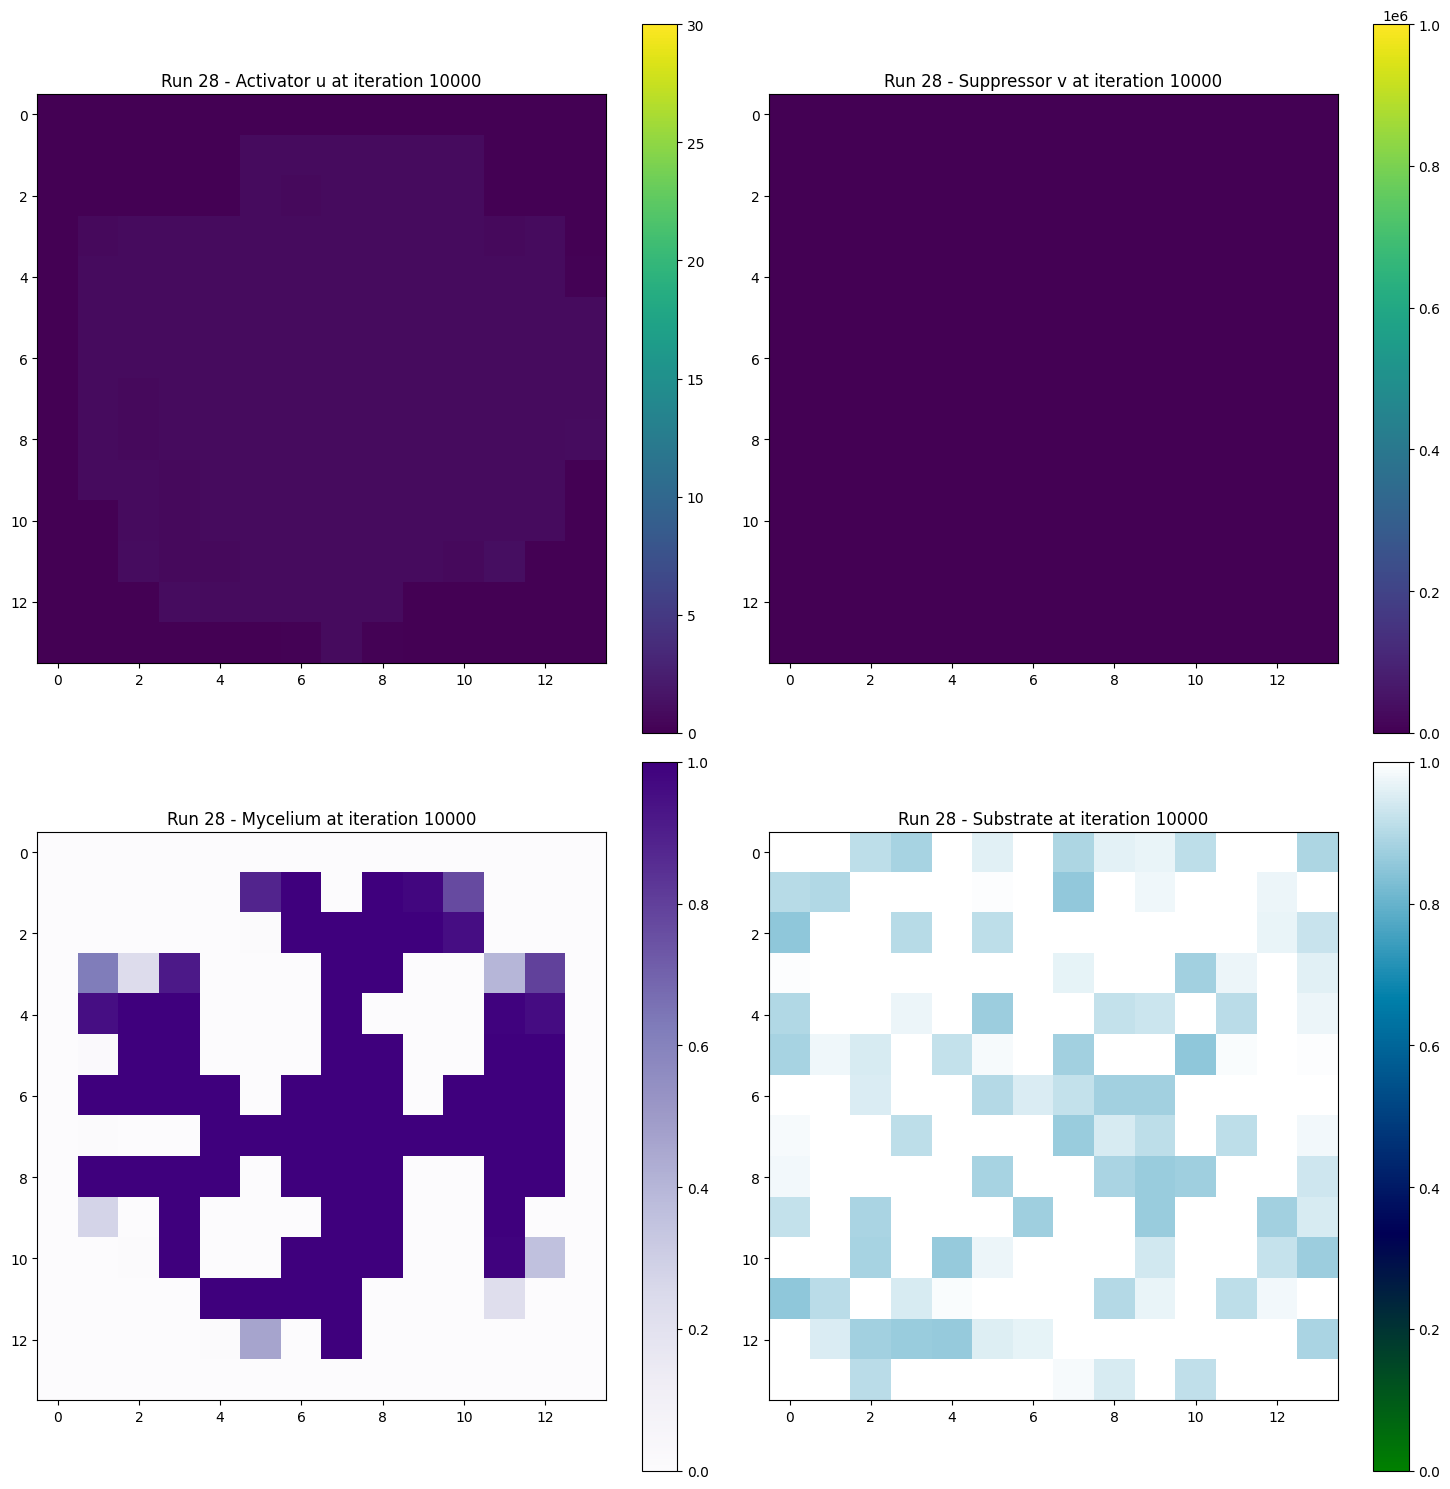

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_28_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_28_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_28_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_28_step_0.csv using NumPy with double precision.


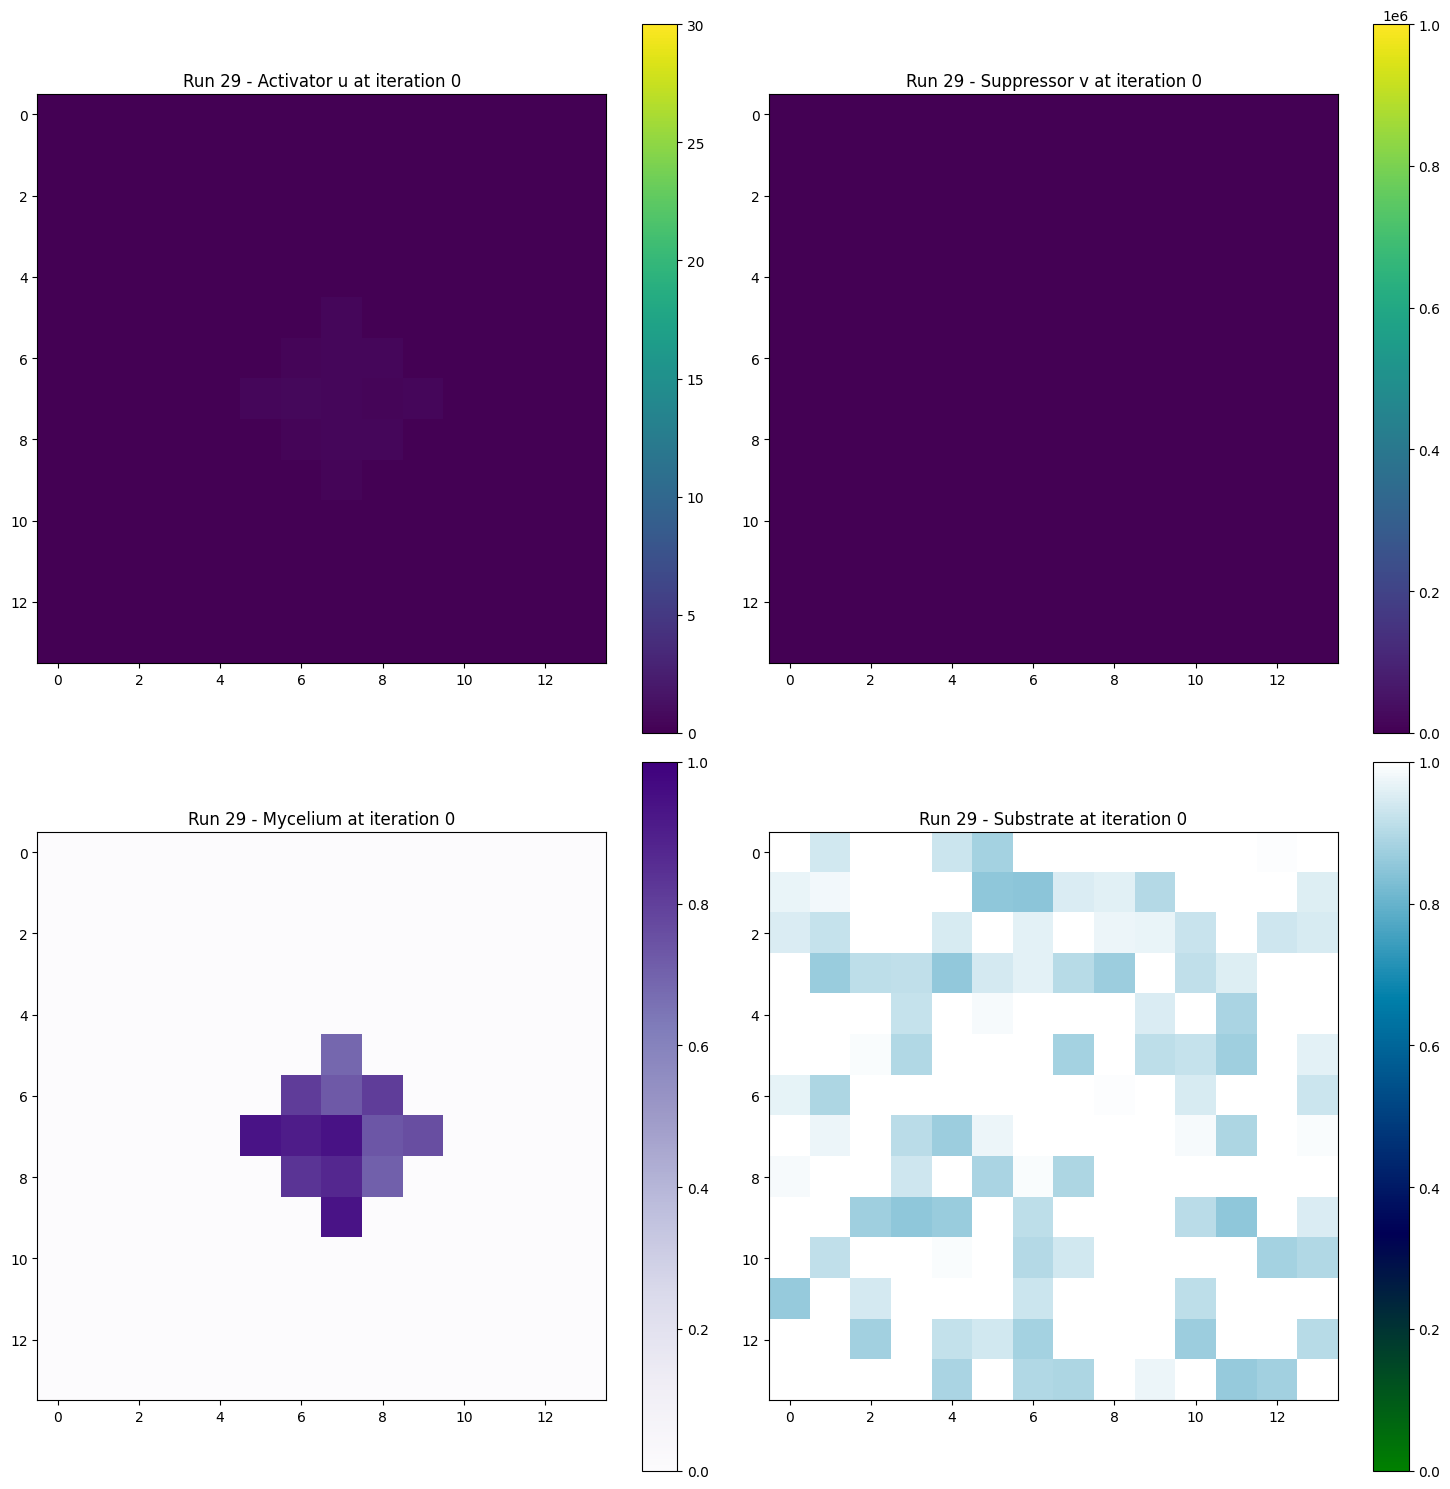

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_28_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_28_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_28_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_28_step_10000.csv using NumPy with double precision.


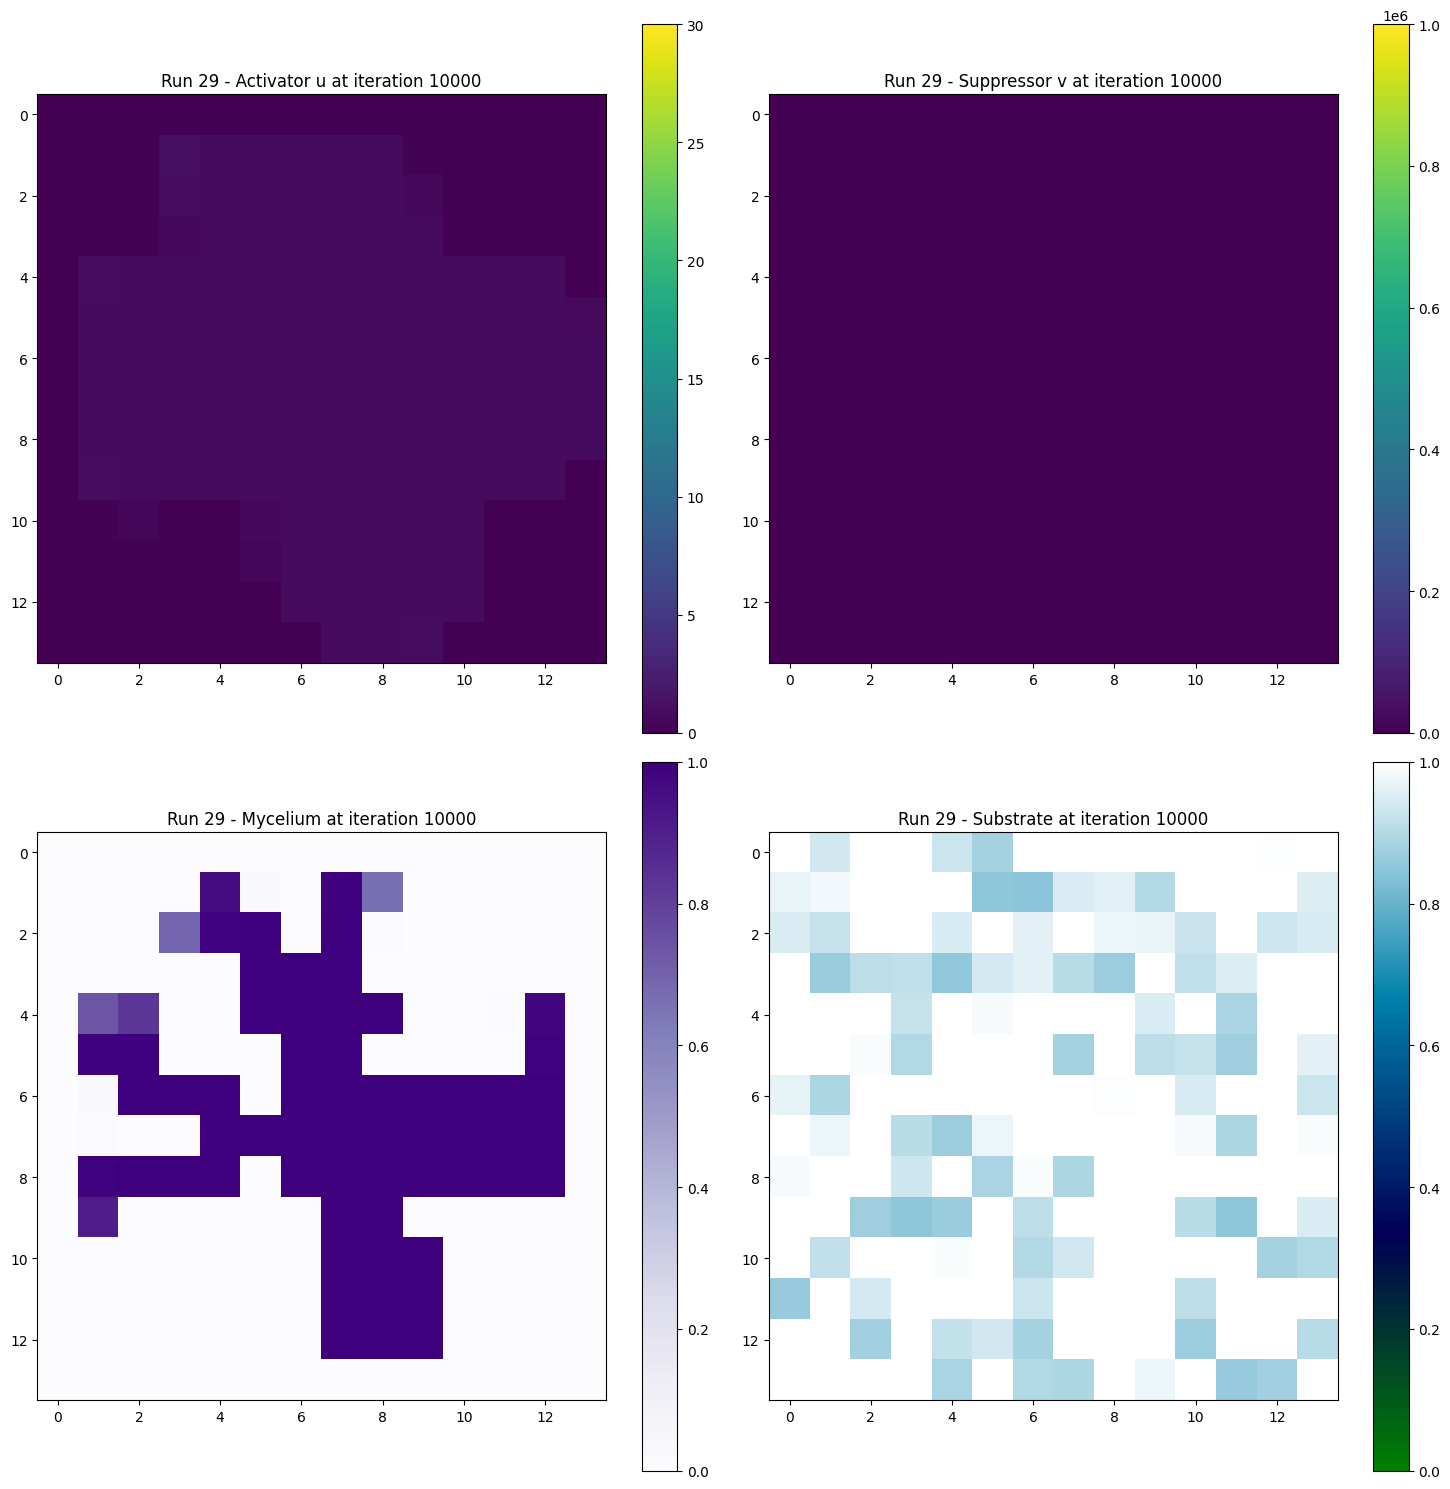

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_29_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_29_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_29_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_29_step_0.csv using NumPy with double precision.


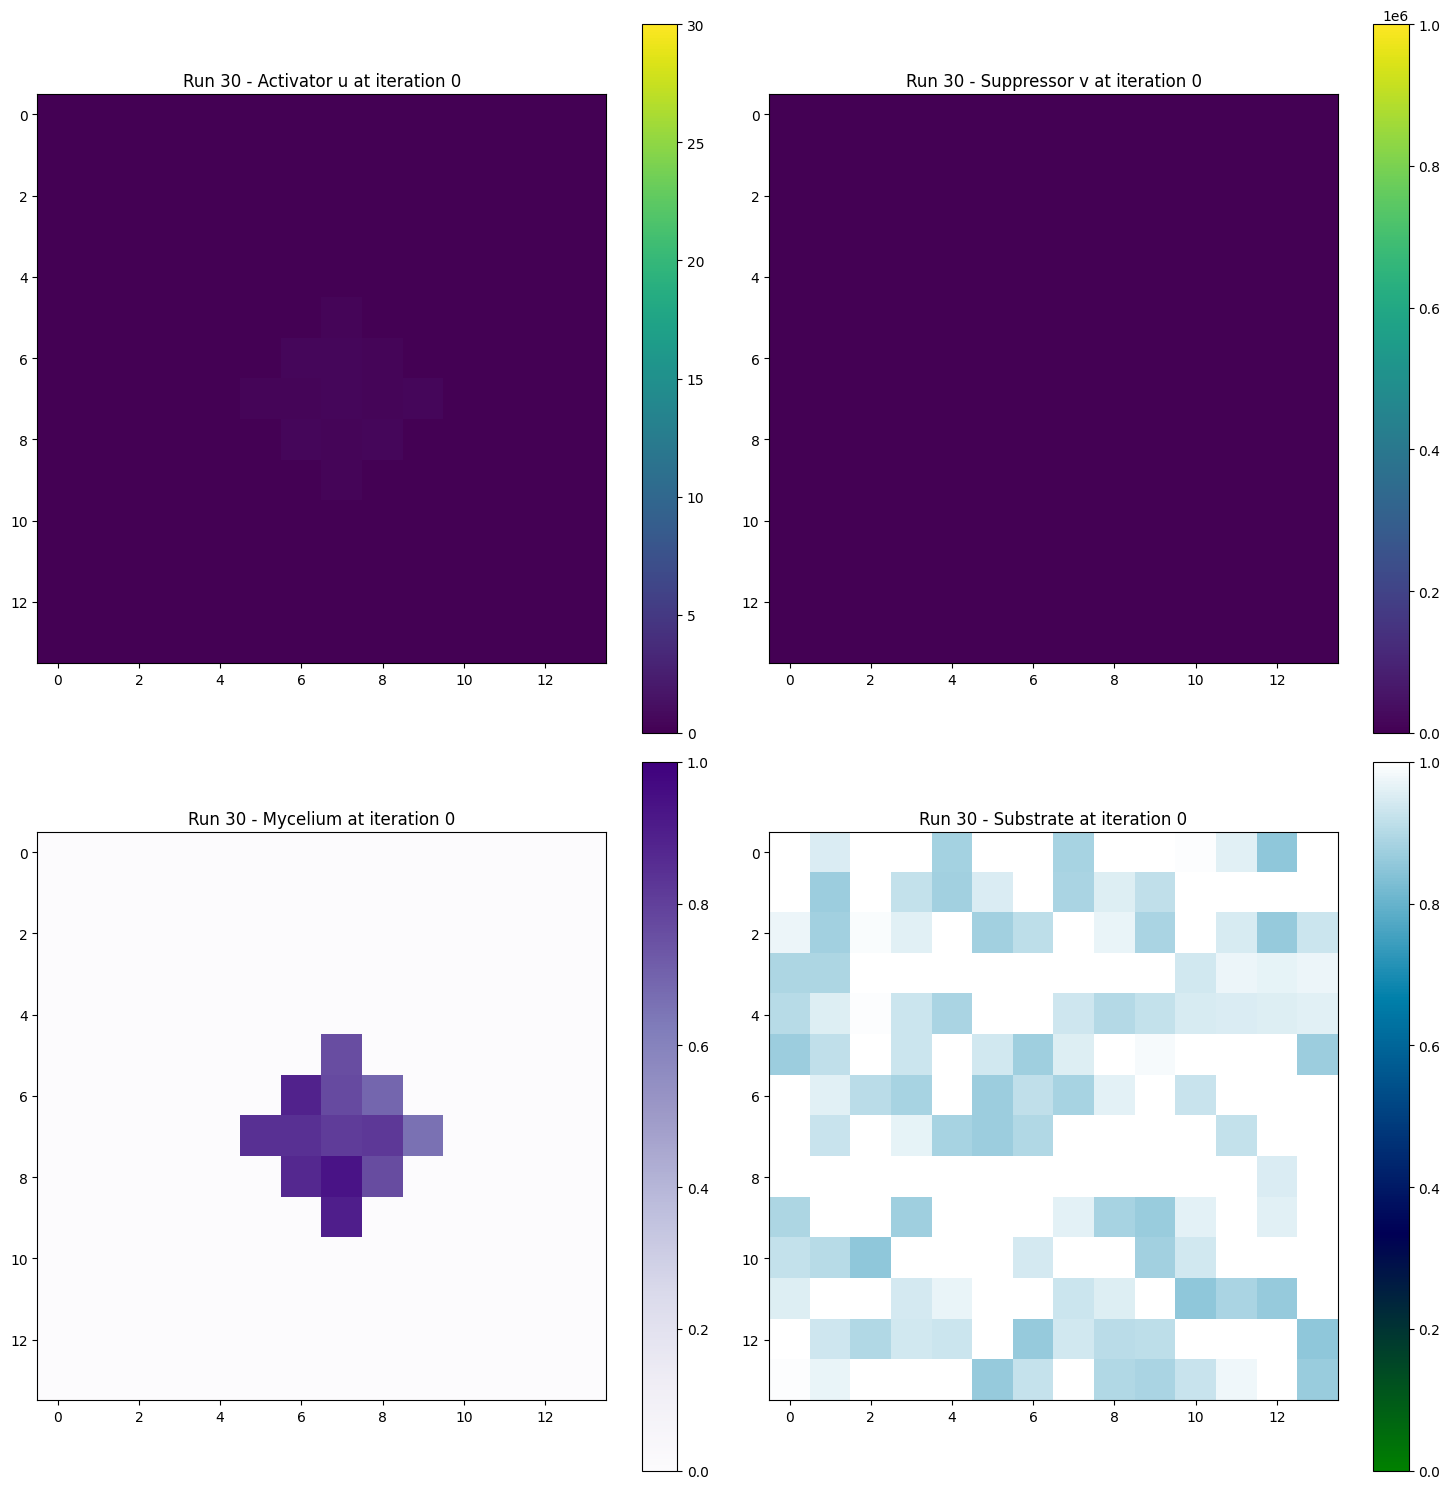

Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\c_run_29_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\u_run_29_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\v_run_29_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Desktop\Mycelium\woSubstrate\n_run_29_step_10000.csv using NumPy with double precision.


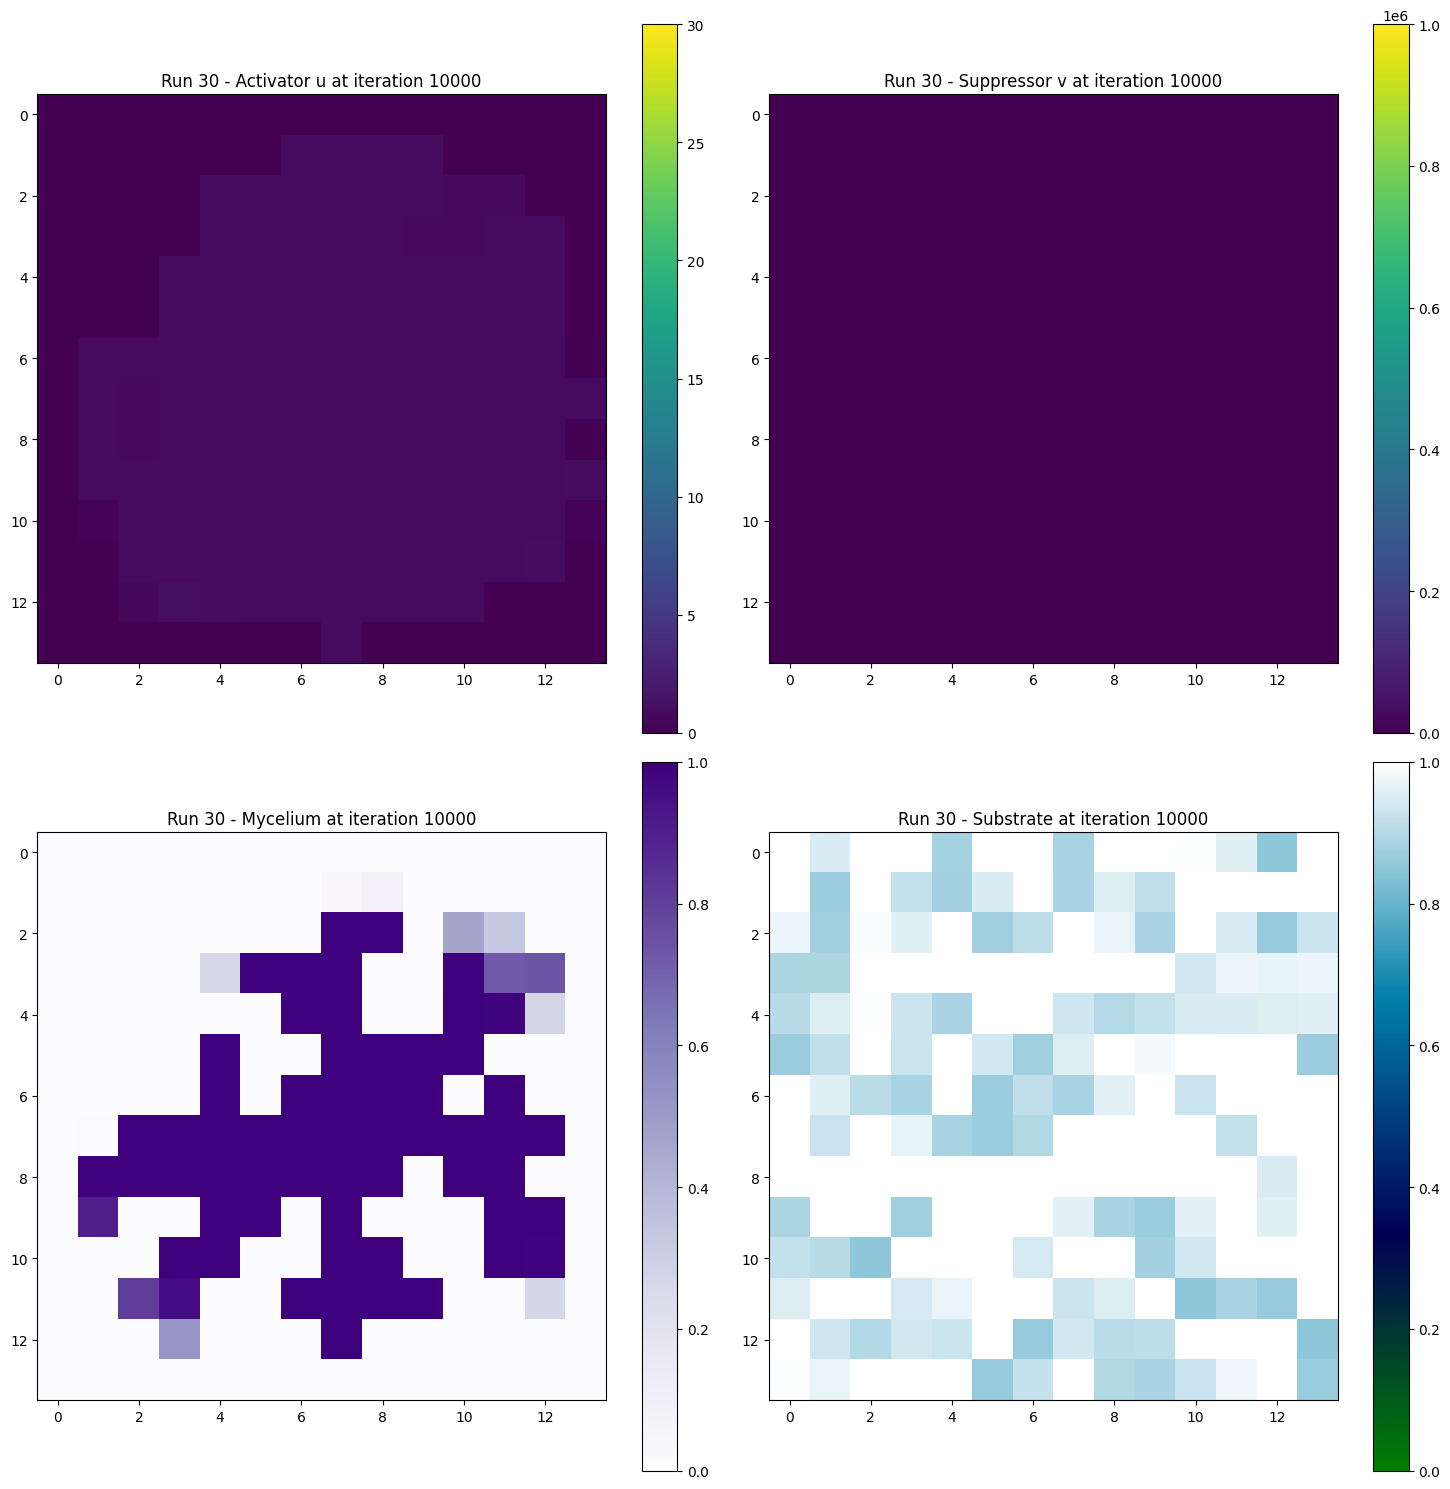

In [212]:
# %%
# Precompute the possible shifts and their corresponding weights based on depth
# Since depth is fixed, shifts and weights can be precomputed
shifts = []
weights = []
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            continue  # Skip the center
        distance = (dx**2 + dy**2) ** 0.5
        if distance <= 1:
            weight = 1.0
        else:
            weight = 1.0 / distance
        shifts.append((dx, dy))
        weights.append(weight)

# Convert weights to a tensor for vectorized operations
weights = torch.tensor(weights, dtype=torch.float32, device=device)

# Main simulation loop over runs
for run in range(no_runs):
    # Initialize u_run, v_run, c_run, n_run for the current run
    u_run = u[run]
    v_run = v[run]
    c_run = c[run]
    n_run = n[run]
    
    for step in range(total_iterations + 1):
        # # (Optional) Print progress at specific intervals
        # if step % 100 == 0:
        #     print(f"Run {run + 1}/{no_runs}, Step {step + 1}/{total_iterations} - Starting")
    
        # 1. Calculate Reaction Terms
        f_uv = (pa * u_run + u_run ** 2 - pb * u_run * v_run) * n_run
        g_uv = pe * u_run ** 3 - v_run
    
        # 2. Create a binary mask where c > 0.5
        c_positive = (c_run > 0.5).float()
    
        # 3. Initialize a list to store all shifted contributions
        shifted_contributions = []
    
        for idx, (dx, dy) in enumerate(shifts):
            weight = weights[idx]
    
            # Shift the c_positive mask
            if dx > 0:
                shifted = F.pad(c_positive, (0, 0, dx, 0))[:-dx, :]
            elif dx < 0:
                shifted = F.pad(c_positive, (0, 0, 0, -dx))[-dx:, :]
            else:
                shifted = c_positive.clone()
    
            if dy > 0:
                shifted = F.pad(shifted, (dy, 0, 0, 0))[:, :-dy]
            elif dy < 0:
                shifted = F.pad(shifted, (0, -dy, 0, 0))[:, -dy:]
            # else dy == 0: no padding needed
    
            # Multiply by the corresponding weight
            contribution = shifted * weight
    
            # Append to the list
            shifted_contributions.append(contribution)
    
        # 4. Stack all contributions and take the element-wise maximum
        if shifted_contributions:
            # Stack along a new dimension and compute max across that dimension
            stacked_contributions = torch.stack(shifted_contributions, dim=0)  # Shape: (num_shifts, H, W)
            ij_mat = torch.max(stacked_contributions, dim=0).values  # Shape: (H, W)
        else:
            ij_mat = torch.zeros_like(c_positive, device=device)
    
        # 5. For cells where distance <=1, set ij_mat to 1 where c >0.5
        # This ensures that cells with c > 0.5 have their ij_mat neighbors set correctly
        # According to MATLAB logic, cells within distance <=1 should be set to 1
        ij_mat = torch.where(c_positive == 1, torch.ones_like(ij_mat), ij_mat)
    
        # 6. Update ij_new based on neighbor conditions
        # Pad ij_mat to handle boundary conditions
        pad_ij = F.pad(ij_mat, (1, 1, 1, 1), mode='constant', value=0)
    
        # Extract immediate neighbors (up, down, left, right)
        neighbors_immediate = torch.stack([
            pad_ij[:-2, 1:-1],  # Up
            pad_ij[2:, 1:-1],   # Down
            pad_ij[1:-1, :-2],  # Left
            pad_ij[1:-1, 2:]    # Right
        ], dim=0)
        has_zero_immediate = (neighbors_immediate == 0).any(dim=0)
    
        # Extract diagonal neighbors (up-left, up-right, down-left, down-right)
        neighbors_diagonal = torch.stack([
            pad_ij[:-2, :-2],  # Up-Left
            pad_ij[:-2, 2:],   # Up-Right
            pad_ij[2:, :-2],   # Down-Left
            pad_ij[2:, 2:]     # Down-Right
        ], dim=0)
        has_zero_diagonal = (neighbors_diagonal == 0).any(dim=0)
    
        # Initialize ij_new as a clone of ij_mat
        ij_new = ij_mat.clone()
    
        # Apply conditions to update ij_new
        ij_new = torch.where(
            (ij_mat > 0) & has_zero_immediate,
            torch.zeros_like(ij_new),
            ij_new
        )
        ij_new = torch.where(
            (ij_mat > 0) & has_zero_diagonal,
            ij_mat / 2.0,
            ij_new
        )
    
        # 7. Compute Diffusion Using Convolution with Laplacian Kernel L
        conv_u = conv2_same(u_run, L)
        conv_v = conv2_same(v_run, L)
    
        # 8. Update Concentrations
        v_new = v_run + dt * (d * conv_v + gamma * g_uv)
        u_new = u_run + dt * (ij_new * (conv_u + gamma * f_uv))
    
        # 9. Apply Constraints Based on n
        u_new = torch.where(n_run == -1, torch.zeros_like(u_new), u_new)
    
        # 10. Compute alpha
        alpha = torch.where(
            u_run <= threshold,
            torch.tensor(0.49, device=device),
            0.49 - 2.5 * (u_run - threshold)
        )
    
        # 11. Update c_new
        c_new = c_run + dt * gamma * ph * c_run * (alpha - c_run) * (c_run - 1)
    
        # 12. Apply Random Noise Where alpha < 0
        noise_condition = (alpha < 0)
        random_noise = torch.rand_like(c_run) * rnd_subs / 10
        c_new = torch.where(noise_condition, c_new + random_noise, c_new)
    
        # 13. Ensure u_new and v_new Are Non-Negative and Clamp Values
        u_new = torch.clamp(u_new, min=0, max=amax)
        v_new = torch.clamp(v_new, min=0)
        c_new = torch.clamp(c_new, max=1)
    
        # 14. Check for NaNs or Infs
        if torch.isnan(u_new).any() or torch.isnan(v_new).any() or torch.isnan(c_new).any():
            print(f"NaN detected at run {run + 1}, step {step + 1}. Terminating simulation for this run.")
            break
        if torch.isinf(u_new).any() or torch.isinf(v_new).any() or torch.isinf(c_new).any():
            print(f"Infinity detected at run {run + 1}, step {step + 1}. Terminating simulation for this run.")
            break
    
        # 15. Update Variables for the Next Iteration
        u_run, v_run, c_run = u_new, v_new, c_new
    
        # Save the updated tensors back to the main 3D tensors
        u[run] = u_run
        v[run] = v_run
        c[run] = c_run
    
        if step % 10000 == 0:
            # Define filenames with run and step number
            filename_c = os.path.join(output_dir, f'c_run_{run}_step_{step}.csv')
            filename_u = os.path.join(output_dir, f'u_run_{run}_step_{step}.csv')
            filename_v = os.path.join(output_dir, f'v_run_{run}_step_{step}.csv')
            filename_n = os.path.join(output_dir, f'n_run_{run}_step_{step}.csv')
            
            # Export tensors to CSV using NumPy
            export_tensor_to_csv_numpy(c_run, filename_c)
            export_tensor_to_csv_numpy(u_run, filename_u)
            export_tensor_to_csv_numpy(v_run, filename_v)
            export_tensor_to_csv_numpy(n_run, filename_n)

            update_visualization(run, step, u_run, v_run, c_run, n_run)


In [213]:
import os
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import pandas as pd
import scipy

def grid_to_adjacency(grid):
    """
    Converts a 2D grid to an adjacency matrix.

    Parameters:
    - grid (numpy.ndarray): 2D array of shape (grid_size, grid_size), binary values (0 or 1).

    Returns:
    - adjacency (numpy.ndarray): Adjacency matrix of shape (grid_size*grid_size, grid_size*grid_size).
    """
    grid_size_row, grid_size_col = grid.shape
    if grid_size_row != grid_size_col:
        raise ValueError("The grid must be square (grid_size x grid_size).")
    grid_size = grid_size_row
    n_nodes = grid_size * grid_size
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    
    # Right connections
    right = grid[:, :-1] & grid[:, 1:]
    indices_right = np.where(right)
    node_indices_right = indices_right[0] * grid_size + indices_right[1]
    neighbor_indices_right = indices_right[0] * grid_size + (indices_right[1] + 1)
    adjacency[node_indices_right, neighbor_indices_right] = 1
    adjacency[neighbor_indices_right, node_indices_right] = 1  # Symmetric
    
    # Down connections
    down = grid[:-1, :] & grid[1:, :]
    indices_down = np.where(down)
    node_indices_down = indices_down[0] * grid_size + indices_down[1]
    neighbor_indices_down = (indices_down[0] + 1) * grid_size + indices_down[1]
    adjacency[node_indices_down, neighbor_indices_down] = 1
    adjacency[neighbor_indices_down, node_indices_down] = 1  # Symmetric
    
    return adjacency

def compute_metrics(input_matrix, run_number, output_dir):
    """
    Computes various graph metrics from the input grid and saves plots.

    Parameters:
    - input_matrix (numpy.ndarray or torch.Tensor): A 2D tensor of shape (grid_size, grid_size).
    - run_number (int): The run number.
    - output_dir (str): Directory to save the plots.

    Returns:
    - metrics (dict): A dictionary containing computed metrics and plot paths.
    """
    # Convert input_matrix to numpy array if it's a tensor
    if isinstance(input_matrix, torch.Tensor):
        input_matrix = input_matrix.cpu().numpy()
    elif not isinstance(input_matrix, np.ndarray):
        raise TypeError("input_matrix must be a NumPy array or a PyTorch tensor.")

    
    # Generate a graph from the input matrix with weights
    G = nx.from_scipy_sparse_array(scipy.sparse.csr_matrix(input_matrix))

    # Ensure binary values
    input_matrix = (input_matrix != 0).astype(int)
    
    # Validate dimensions
    if input_matrix.ndim != 2:
        raise ValueError("input_matrix must be 2D.")
    grid_size_row, grid_size_col = input_matrix.shape
    if grid_size_row != grid_size_col:
        raise ValueError("Grid must be square (grid_size x grid_size).")
    grid_size = grid_size_row
    n_nodes = grid_size * grid_size
    
    # Create adjacency matrix
    adjacency_matrix = grid_to_adjacency(input_matrix)
    
    # Plot and save the adjacency matrix
    adj_plot_path = os.path.join(output_dir, f"adj_matrix_run_{run_number}.png")
    plt.figure(figsize=(10, 10))
    plt.imshow(adjacency_matrix, cmap='Greys', interpolation='none')
    plt.title(f"Adjacency Matrix for Run {run_number}")
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.colorbar(label='Connection (1=Connected, 0=Not Connected)')
    plt.tight_layout()
    plt.savefig(adj_plot_path)
    plt.close()
    
    # Plot and save the c matrix
    c_plot_path = os.path.join(output_dir, f"c_matrix_run_{run_number}.png")
    plt.figure(figsize=(8, 6))
    plt.imshow(input_matrix, cmap='viridis')
    plt.title(f"C Matrix for Run {run_number}")
    plt.colorbar()
    plt.savefig(c_plot_path)
    plt.close()
    
      # Compute Density
    density = np.sum(adjacency_matrix) / (len(adjacency_matrix) * (len(adjacency_matrix) - 1))
    
    # Calculate Average Path Length considering all pairs
    path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    total_length = 0
    reachable_pairs = 0
    for source, targets in path_lengths.items():
        for target, length in targets.items():
            if source != target:
                total_length += length
                reachable_pairs += 1

    # Normalize by the number of possible connections
    if reachable_pairs > 0:
        apl = total_length / reachable_pairs
    else:
        apl = np.nan  # Not defined if no pairs are reachable

    n = adjacency_matrix.shape[0]
    clustering_coeffs = np.zeros(n)
    degrees = np.sum(adjacency_matrix, axis=1).astype(int)  # Properly compute degrees

    for i in range(n):
        neighbors = np.where(adjacency_matrix[i] > 0)[0]
        if len(neighbors) < 2:
            continue  # No triangles possible

        # Calculate local clustering coefficient
        actual_triangles = 0
        for j in range(len(neighbors)):
            for k in range(j + 1, len(neighbors)):  # Avoid double counting
                if adjacency_matrix[neighbors[j], neighbors[k]] > 0:
                    actual_triangles += 1  # Count each triangle once

        # Compute the possible number of triangles
        if degrees[i] > 1:
            possible_triangles = degrees[i] * (degrees[i] - 1) / 2
            clustering_coeffs[i] = 2 * actual_triangles / possible_triangles  # Compute clustering coefficient

    average_clustering = nx.average_clustering(G)

    eigenvalues = np.linalg.eigvals(adjacency_matrix)
    # Compute the spectral radius (the largest absolute value of the eigenvalues)
    spectral_radius = max(abs(eigenvalues))

    memory_capacity = {}
    max_cycle_length = 4
    A = np.array(adjacency_matrix)  # Ensure it's a NumPy array for matrix operations

    current_power = A.copy()  # Start with A itself for A^1
    for cycle_length in range(1, max_cycle_length + 1):
        if cycle_length > 1:  # We already have A for cycle_length=1
            current_power = np.dot(current_power, A)
        # Trace of the current power matrix gives us the number of cycles of length n
        cycle_count = np.trace(current_power)
        memory_capacity[cycle_length] = cycle_count

    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(G)

    # Degree Distribution
    degrees = np.sum(adjacency_matrix, axis=1).astype(int)
    degree_counts = np.bincount(degrees)
    degree_values = np.arange(len(degree_counts))

    return {
        "Run": run_number,
        "Density": density,
        "Average Path Length": apl,
        "Clustering Coefficient": average_clustering,
        "Spectral Radius": spectral_radius,
        "Memory Capacity": memory_capacity,
        "Degree Distribution": degree_values.tolist(),
        "Betweenness": betweenness,
        "C Matrix Plot": c_plot_path,
        "Adjacency Matrix Plot": adj_plot_path
    }

def export_metrics_for_runs(c, output_filename, output_dir):
    """
    Exports computed metrics for all runs to a CSV file.

    Parameters:
    - c (numpy.ndarray or torch.Tensor): A 3D tensor of shape (no_runs, grid_size, grid_size).
    - output_filename (str): Path to the output CSV file.
    - output_dir (str): Directory to save the plots.

    Returns:
    - None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    results = []
    no_runs = c.shape[0]
    for run in range(no_runs):
        print(f"Processing run {run + 1}/{no_runs}")
        metrics = compute_metrics(c[run], run + 1, output_dir)  # Assuming runs start at 1
        results.append(metrics)
    
    # Normalize Memory Capacity and Betweenness for CSV compatibility
    # Convert dictionaries to strings
    for result in results:
        result["Memory Capacity"] = str(result["Memory Capacity"])
        result["Betweenness"] = str(result["Betweenness"])
        result["Degree Distribution"] = str(result["Degree Distribution"])
    
    df = pd.DataFrame(results)
    df.to_csv(output_filename, index=False)
    print(f"Metrics exported to {output_filename}")

# Define output directory and filename
output_dir = os.path.join(os.getcwd(), "output_plots")
output_filename = os.path.join(os.getcwd(), "Reservoir_Metrics_1.csv")

# Call the export function
export_metrics_for_runs(c, output_filename, output_dir)

Processing run 1/30
Processing run 2/30
Processing run 3/30
Processing run 4/30
Processing run 5/30
Processing run 6/30
Processing run 7/30
Processing run 8/30
Processing run 9/30
Processing run 10/30
Processing run 11/30
Processing run 12/30
Processing run 13/30
Processing run 14/30
Processing run 15/30
Processing run 16/30
Processing run 17/30
Processing run 18/30
Processing run 19/30
Processing run 20/30
Processing run 21/30
Processing run 22/30
Processing run 23/30
Processing run 24/30
Processing run 25/30
Processing run 26/30
Processing run 27/30
Processing run 28/30
Processing run 29/30
Processing run 30/30
Metrics exported to c:\Users\itomp\Desktop\Mycelium\Reservoir_Metrics_1.csv
